# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
import imageio
from collections import deque, Counter
%matplotlib inline

# Set directory to Project Base Dir due to the unique way in which VS functions
ProjectDir = "C:/GitRepo/Udacity_Training/Finding-Lane-Lines-on-the-Road/CarND-LaneLines-P1"
os.chdir(ProjectDir)
cwd = os.getcwd()
print('current working dir is: '+ cwd)

#Create array for storing gradients
leftLineGradArray = []
rightLineGradArray = []

# Create array for storing average x values
xLeftAverageArray = []
xRightAverageArray = []

xMovingAverage = deque([], maxlen = 15)

# Counter for tracking frame number
count = Counter()

current working dir is: C:\GitRepo\Udacity_Training\Finding-Lane-Lines-on-the-Road\CarND-LaneLines-P1


## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


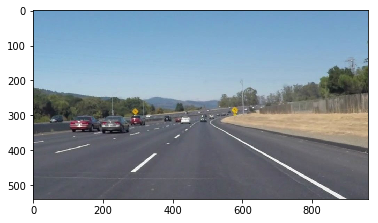

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')

# Initialise File Count (for File Export)
fileCount = 1

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')


## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines,leftLineGradArray, rightLineGradArray, xLeftAverageArray, xRightAverageArray, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    imgWidth = img.shape[1]
    imgHeight = img.shape[0]

    x_left  = []
    y_left  = []

    x_right = []
    y_right = []


    # Update Frame Count
    count.update('F')
    frameCount=count.get('F')
    print('')
    print ('Frame Count : %s'%frameCount)


    # Append to left line array
    leftGradAppend = leftLineGradArray.append

    # Append to right line array
    rightGradAppend = rightLineGradArray.append

    xLeftAverageAppend = xLeftAverageArray.append
    xRightAverageAppend = xRightAverageArray.append
    

    for line in lines:
        for x1,y1,x2,y2 in line:

            # Calculate gradient
            m = (y2-y1)/(x2-x1)
            
            
            # If gradient is positive, line is right line
            if 5 > m > 0.5:
                #print('right Line gradient: %s' %(m))
                rightLineGrad = m
                rightGradAppend(m)  
                
                # Add right x & y coordinates to Array
                x_right += [x1, x2]
                y_right += [y1, y2]

            # If gradient is negative, line is left line
            elif -5 < m < -0.5:
                #print('left line gradient: %s' % (m))
                leftLineGrad = m
                leftGradAppend(m)

                # Add left x & y coordinates to Array
                x_left += [x1, x2]
                y_left += [y1, y2]
            
            
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


    # If no line is detected, do not process & print error
    if not x_left :
        print('Empty x_left list, No lines found in this image')
    elif not x_right :
        print('Empty x_right list, No lines found in this image')
    elif not y_left :
        print('Empty y_left list, No lines found in this image')
    elif not y_right :
        print('Empty y_right list, No lines found in this image')

    # If line is detected, continue
    else :
        # Calculate average x & y for right line from the array of all detected lines in frame
        xRightAverage = sum(x_right)/len(x_right)
        yRightAverage = sum(y_right)/len(y_right)
        print('Right Line average x is : %s'%xRightAverage)
        print('Right Line average y is : %s'%yRightAverage)

        # Calculate average x & y for left line from the array of all detected lines in frame
        xLeftAverage = sum(x_left)/len(x_left)
        yLeftAverage = sum(y_left)/len(y_left)

        # Create array to store the average over multiple frames, using the value from single frames above
        xLeftAverageAppend (int(round(xLeftAverage)))
        xRightAverageAppend (int(round(xRightAverage)))

        # calculate average gradient of right line
        rightGradAverage = sum(rightLineGradArray)/len(rightLineGradArray)
        print('Manual Right line Gradient Average: %s'%rightGradAverage)
        
        #calculate average gradient of left line
        leftGradAverage = sum(leftLineGradArray)/len(leftLineGradArray)
        print('Manual left Line Gradient Average: %s'%leftGradAverage)
    
        # Right Line: y=mx+c, therefore, to calculate c, we need c=y-mx
        cRightAverage = yRightAverage - (rightGradAverage*xRightAverage)
        print('c right average :   %s'%cRightAverage)

        # Left Line:  y=mx+c, therefore, to calculate c, we need c=y-mx
        cLeftAverage = yLeftAverage - (leftGradAverage*xLeftAverage)
        print('c left average :   %s'%cLeftAverage)
        print('yLeftAverage : %s'%yLeftAverage)
        print('xLeftAverage : %s'%xLeftAverage)
        print('')

        # Rearanging for x: x = (y-c)/m
        #Start of line should be at y = image height
        x_RightLineStart = int(round((imgHeight-cRightAverage)/rightGradAverage))
        x_LeftLineStart = int(round((imgHeight-cLeftAverage)/leftGradAverage))


        #End of line should be at y = 320
        y_LineEnd = 320

        # Find end of each line by largest/smallest value in line array
        x_RightLineEnd = min(x_right)
        x_LeftLineEnd = max(x_left)


        # Calculate end of line by extrapolating using y=mx+c
        x_ExtrapRightLineEnd = int(round((y_LineEnd-cRightAverage)/rightGradAverage))
        x_ExtrapLeftLineEnd = int(round((y_LineEnd-cLeftAverage)/leftGradAverage))

        #Take conglomerated average of extrapolated expected value and min/max of array (end of detected line)
        # A weighting has been added to the more stable y=mx+c calculated x values
        x_RightLineEndConglomerate = int(round((x_RightLineEnd + x_ExtrapRightLineEnd + x_ExtrapRightLineEnd)/3))
        x_LeftLineEndConglomerate = int(round((x_LeftLineEnd + x_ExtrapLeftLineEnd + x_ExtrapLeftLineEnd)/3))

        # Append values to moving average array
        xMovingAverage.append((x_RightLineStart, x_RightLineEndConglomerate, x_LeftLineStart, x_LeftLineEndConglomerate))
        
        # Calculate sum of terms within array
        x_LineAverageSum = np.sum(xMovingAverage, -2)
        print('x_LineAverageSum : %s'%x_LineAverageSum)

        # If frame count is below the averaging window threshold (sliding window size), display raw values
        if frameCount <= 15 :
            cv2.line(img, (x_RightLineStart, imgHeight), (x_ExtrapRightLineEnd , y_LineEnd), color, thickness)
            cv2.line(img, (x_LeftLineStart, imgHeight), (x_ExtrapLeftLineEnd , y_LineEnd), color, thickness)

        # Otherwise, use averaged values
        else :
            x_RightLineStartAverage = int(x_LineAverageSum[0]/len(xMovingAverage))
            x_RightLineEndAverage = int(x_LineAverageSum[1]/len(xMovingAverage))
            x_LeftLineStartAverage = int(x_LineAverageSum[2]/len(xMovingAverage))
            x_LeftLineEndAverage = int(x_LineAverageSum[3]/len(xMovingAverage))

            cv2.line(img, (x_RightLineStartAverage, imgHeight), (x_RightLineEndAverage , y_LineEnd), color, thickness)
            cv2.line(img, (x_LeftLineStartAverage, imgHeight), (x_LeftLineEndAverage , y_LineEnd), color, thickness)

    return rightLineGradArray, leftLineGradArray, xLeftAverageArray, xRightAverageArray

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    draw_lines(line_img, lines, leftLineGradArray, rightLineGradArray, xLeftAverageArray, xRightAverageArray)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def detect_lanes(image, fileCount):

    # Convert Image to Greyscale
    grey = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    BlurredImage = gaussian_blur(grey, kernel_size)

    # Define parameters for Canny Edge Detection
    low_threshold = 50
    high_threshold = 150
    BlurredImageCanny = canny(BlurredImage, low_threshold, high_threshold)

    # Mask Edges of Defined Polygon
    imshape = image.shape
    vertices = np.array([[(150,imshape[0]),(450, 320), (imshape[1]-450, 320), (imshape[1]-50,imshape[0])]], dtype=np.int32)
    MaskedImage = region_of_interest(BlurredImageCanny, vertices)

    # Hough Transform Parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = 0.027*np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 5     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 2    # maximum gap in pixels between connectable line segments
    DetectedLines = hough_lines(MaskedImage, rho, theta, threshold, min_line_length, max_line_gap)

    # Merge Images
    ProcessedImage = weighted_img(DetectedLines, image, α=0.8, β=1., λ=0.)

    outputDir = 'test_images/ProcessedImages/'

    figure = plt.figure(figsize=(20,10))

    plotImage=figure.add_subplot(1,4,1)
    plt.imshow(image)
    plotImage.set_title('Unprocessed Image')

    plotImage=figure.add_subplot(1,4,2)
    plt.imshow(BlurredImageCanny)
    plotImage.set_title('Post-Canny Image')

    plotImage=figure.add_subplot(1,4,3)
    plt.imshow(MaskedImage)
    plotImage.set_title('Masked Image')

    plotImage=figure.add_subplot(1,4,4)
    plt.imshow(ProcessedImage)
    plotImage.set_title('Processed Image')

    plt.savefig(outputDir + 'ProcessedImage' + str(fileCount) + '.jpg')
    
    return BlurredImageCanny, MaskedImage, ProcessedImage


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

Test Images: test_images\solidWhiteCurve.jpg

Frame Count : 1
Right Line average x is : 693.291666667
Right Line average y is : 429.208333333
Manual Right line Gradient Average: 0.559406317965
Manual left Line Gradient Average: -0.763408329198
c right average :   41.3765948074
c left average :   677.056069304
yLeftAverage : 394.722222222
xLeftAverage : 369.833333333

x_LineAverageSum : [891 501 180 468]
Test Images: test_images\solidWhiteRight.jpg

Frame Count : 2
Right Line average x is : 632.166666667
Right Line average y is : 403.833333333
Manual Right line Gradient Average: 0.594101435633
Manual left Line Gradient Average: -0.733930907447
c right average :   28.2622091071
c left average :   656.042144031
yLeftAverage : 381.388888889
xLeftAverage : 374.222222222

x_LineAverageSum : [1752  995  338  928]
Test Images: test_images\solidYellowCurve.jpg

Frame Count : 3
Right Line average x is : 580.8
Right Line average y is : 374.6
Manual Right line Gradient Average: 0.587425446904
Manu

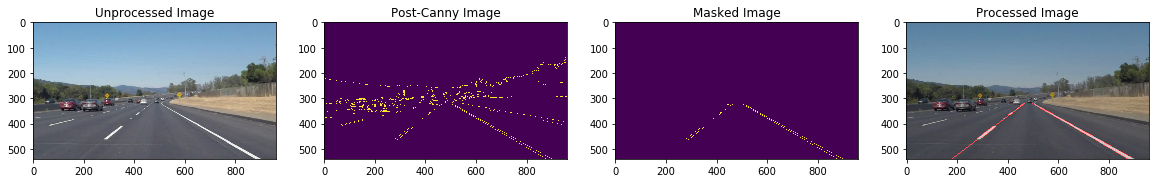

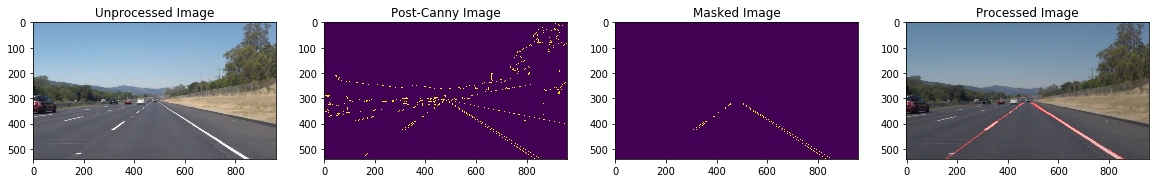

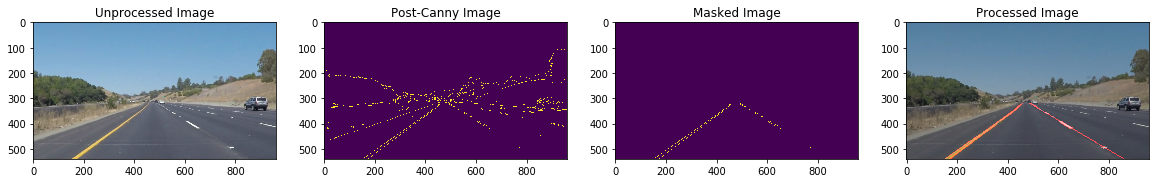

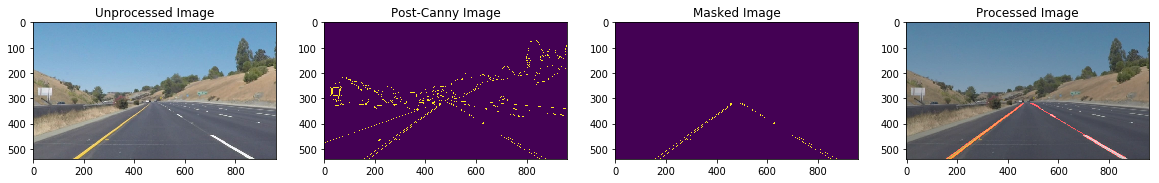

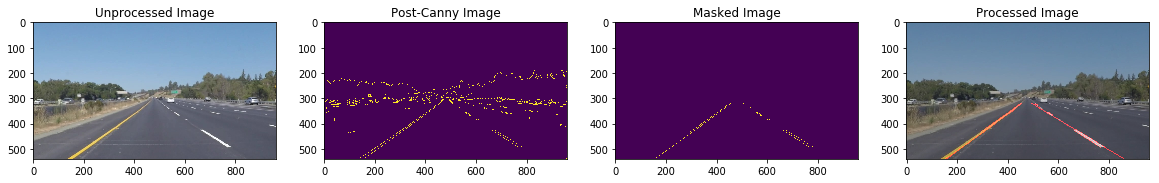

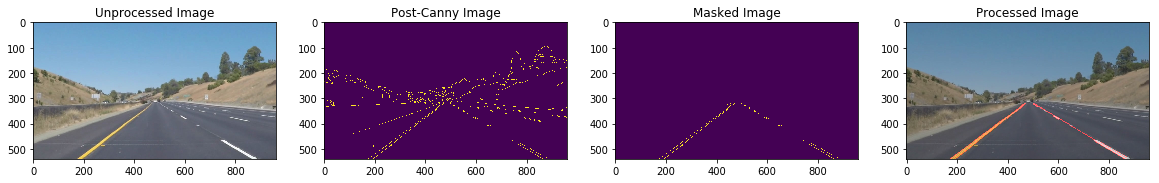

In [4]:
for images in glob.iglob('test_images/*.jpg'):
    loadedImage = images
    image = mpimg.imread(loadedImage)
    print('Test Images: %s' % images)
    detect_lanes(image, fileCount)
    fileCount += 1

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    # Convert Image to Greyscale
    grey = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    BlurredImage = gaussian_blur(grey, kernel_size)

    # Define parameters for Canny Edge Detection
    low_threshold = 50
    high_threshold = 150
    BlurredImageCanny = canny(BlurredImage, low_threshold, high_threshold)

    # Mask Edges of Defined Polygon using measurements based on image size for scaling
    imshape = image.shape
    vertices = np.array([[(int(round(imshape[1]/6.4)),imshape[0]),(int(round(imshape[1]/2.133)), int(round(imshape[0]/1.6875))), (int(round(imshape[1]/1.88)), int(round(imshape[0]/1.6875))), (int(round(imshape[1]/1.055)),imshape[0])]], dtype=np.int32)
    MaskedImage = region_of_interest(BlurredImageCanny, vertices)

    # Hough Transform Parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = 0.027*np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 5     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 2    # maximum gap in pixels between connectable line segments
    DetectedLines = hough_lines(MaskedImage, rho, theta, threshold, min_line_length, max_line_gap)

    # Merge Images
    ProcessedImage = weighted_img(DetectedLines, image, α=0.8, β=1., λ=0.)

    return ProcessedImage

Let's try the one with the solid white lane on the right first ...

In [8]:
count.clear()
xLeftAverageAppend = []
xRightAverageAppend = []
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


Frame Count : 1
Right Line average x is : 669.529411765
Right Line average y is : 422.647058824
Manual Right line Gradient Average: 0.601461952153
Manual left Line Gradient Average: -0.764384727437
c right average :   19.9505917997
c left average :   664.811218628
yLeftAverage : 419.666666667
xLeftAverage : 320.708333333

x_LineAverageSum : [6081 3484 1183 3229]
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|          | 0/222 [00:00<?, ?it/s]


Frame Count : 2
Right Line average x is : 669.529411765
Right Line average y is : 422.647058824
Manual Right line Gradient Average: 0.604182838566
Manual left Line Gradient Average: -0.762163026068
c right average :   18.1288783202
c left average :   664.098700485
yLeftAverage : 419.666666667
xLeftAverage : 320.708333333

x_LineAverageSum : [6945 3985 1346 3681]


  0%|          | 1/222 [00:00<00:39,  5.53it/s]


Frame Count : 3
Right Line average x is : 689.409090909
Right Line average y is : 435.75
Manual Right line Gradient Average: 0.604541145635
Manual left Line Gradient Average: -0.759709961065
c right average :   18.9738383707
c left average :   663.697038506
yLeftAverage : 446.392857143
xLeftAverage : 286.035714286

x_LineAverageSum : [7807 4484 1509 4134]


  1%|          | 2/222 [00:00<00:38,  5.72it/s]


Frame Count : 4
Right Line average x is : 705.583333333
Right Line average y is : 444.416666667
Manual Right line Gradient Average: 0.605929754061
Manual left Line Gradient Average: -0.759322434264
c right average :   16.8827310303
c left average :   664.600282837
yLeftAverage : 420.409090909
xLeftAverage : 321.590909091

x_LineAverageSum : [8670 4984 1673 4590]


  1%|▏         | 3/222 [00:00<00:37,  5.85it/s]


Frame Count : 5
Right Line average x is : 690.066666667
Right Line average y is : 435.233333333
Manual Right line Gradient Average: 0.606361584848
Manual left Line Gradient Average: -0.758188717196
c right average :   16.8034156825
c left average :   664.984163846
yLeftAverage : 407.2
xLeftAverage : 340.0

x_LineAverageSum : [9533 5485 1838 5045]


  2%|▏         | 4/222 [00:00<00:35,  6.10it/s]


Frame Count : 6
Right Line average x is : 660.708333333
Right Line average y is : 416.875
Manual Right line Gradient Average: 0.607386429719
Manual left Line Gradient Average: -0.757239184276
c right average :   15.5697243311
c left average :   664.826001762
yLeftAverage : 356.142857143
xLeftAverage : 407.642857143

x_LineAverageSum : [10396  5986  2003  5502]


  2%|▏         | 5/222 [00:00<00:33,  6.54it/s]


Frame Count : 7
Right Line average x is : 708.928571429
Right Line average y is : 446.0
Manual Right line Gradient Average: 0.607746447953
Manual left Line Gradient Average: -0.754506656611
c right average :   15.1511788618
c left average :   663.60511594
yLeftAverage : 359.0
xLeftAverage : 403.714285714

x_LineAverageSum : [11260  6488  2167  5959]


  3%|▎         | 6/222 [00:00<00:31,  6.90it/s]


Frame Count : 8
Right Line average x is : 660.307692308
Right Line average y is : 415.461538462
Manual Right line Gradient Average: 0.60796682572
Manual left Line Gradient Average: -0.754353544785
c right average :   14.0163667706
c left average :   662.667253657
yLeftAverage : 370.166666667
xLeftAverage : 387.75

x_LineAverageSum : [12125  6993  2330  6415]


  3%|▎         | 7/222 [00:01<00:29,  7.25it/s]


Frame Count : 9
Right Line average x is : 658.466666667
Right Line average y is : 414.133333333
Manual Right line Gradient Average: 0.606373703273
Manual left Line Gradient Average: -0.752170234383
c right average :   14.8564621848
c left average :   660.470359173
yLeftAverage : 378.3125
xLeftAverage : 375.125

x_LineAverageSum : [12991  7499  2490  6870]


  4%|▎         | 8/222 [00:01<00:28,  7.48it/s]


Frame Count : 10
Right Line average x is : 645.461538462
Right Line average y is : 406.615384615
Manual Right line Gradient Average: 0.606897551088
Manual left Line Gradient Average: -0.749000438197
c right average :   14.8863576014
c left average :   659.310082122
yLeftAverage : 376.5
xLeftAverage : 377.583333333

x_LineAverageSum : [12965  7501  2469  6857]


  4%|▍         | 9/222 [00:01<00:28,  7.54it/s]


Frame Count : 11
Right Line average x is : 658.411764706
Right Line average y is : 417.176470588
Manual Right line Gradient Average: 0.608119773821
Manual left Line Gradient Average: -0.747668862246
c right average :   16.7832571545
c left average :   661.350263599
yLeftAverage : 391.0
xLeftAverage : 361.590909091

x_LineAverageSum : [12964  7506  2473  6856]


  5%|▍         | 10/222 [00:01<00:28,  7.32it/s]


Frame Count : 12
Right Line average x is : 644.681818182
Right Line average y is : 410.590909091
Manual Right line Gradient Average: 0.60848167638
Manual left Line Gradient Average: -0.744926509897
c right average :   18.313835632
c left average :   661.729351954
yLeftAverage : 401.75
xLeftAverage : 349.0

x_LineAverageSum : [12959  7514  2468  6857]


  5%|▍         | 11/222 [00:01<00:29,  7.09it/s]


Frame Count : 13
Right Line average x is : 624.382352941
Right Line average y is : 400.058823529
Manual Right line Gradient Average: 0.609413641934
Manual left Line Gradient Average: -0.743612418967
c right average :   19.5516998643
c left average :   659.864492436
yLeftAverage : 408.833333333
xLeftAverage : 337.583333333

x_LineAverageSum : [12945  7510  2459  6855]


  5%|▌         | 12/222 [00:01<00:30,  6.83it/s]


Frame Count : 14
Right Line average x is : 671.0
Right Line average y is : 428.194444444
Manual Right line Gradient Average: 0.611246096381
Manual left Line Gradient Average: -0.741465201754
c right average :   18.0483137731
c left average :   659.460366399
yLeftAverage : 406.25
xLeftAverage : 341.5

x_LineAverageSum : [12937  7505  2460  6860]


  6%|▌         | 13/222 [00:01<00:31,  6.71it/s]


Frame Count : 15
Right Line average x is : 649.866666667
Right Line average y is : 413.866666667
Manual Right line Gradient Average: 0.612632757486
Manual left Line Gradient Average: -0.740242672959
c right average :   15.7370586687
c left average :   659.531840315
yLeftAverage : 413.277777778
xLeftAverage : 332.666666667

x_LineAverageSum : [12921  7500  2437  6848]


  6%|▋         | 14/222 [00:02<00:31,  6.61it/s]


Frame Count : 16
Right Line average x is : 677.466666667
Right Line average y is : 430.566666667
Manual Right line Gradient Average: 0.614088825557
Manual left Line Gradient Average: -0.740338466517
c right average :   14.5419569796
c left average :   657.074970738
yLeftAverage : 432.9375
xLeftAverage : 302.75

x_LineAverageSum : [12912  7499  2432  6850]


  7%|▋         | 15/222 [00:02<00:30,  6.88it/s]


Frame Count : 17
Right Line average x is : 652.4375
Right Line average y is : 413.25
Manual Right line Gradient Average: 0.614944871992
Manual left Line Gradient Average: -0.740321118177
c right average :   12.0369050796
c left average :   655.561532171
yLeftAverage : 428.071428571
xLeftAverage : 307.285714286

x_LineAverageSum : [12907  7500  2425  6850]


  7%|▋         | 16/222 [00:02<00:28,  7.23it/s]


Frame Count : 18
Right Line average x is : 671.5625
Right Line average y is : 425.5
Manual Right line Gradient Average: 0.615805715467
Manual left Line Gradient Average: -0.740529637974
c right average :   11.9479742064
c left average :   655.132869843
yLeftAverage : 455.375
xLeftAverage : 269.75

x_LineAverageSum : [12902  7503  2417  6829]


  8%|▊         | 17/222 [00:02<00:27,  7.53it/s]


Frame Count : 19
Right Line average x is : 646.8
Right Line average y is : 411.6
Manual Right line Gradient Average: 0.616771103216
Manual left Line Gradient Average: -0.74067858709
c right average :   12.6724504397
c left average :   657.19316648
yLeftAverage : 384.5
xLeftAverage : 368.166666667

x_LineAverageSum : [12894  7503  2411  6804]


  8%|▊         | 18/222 [00:02<00:26,  7.83it/s]


Frame Count : 20
Right Line average x is : 656.035714286
Right Line average y is : 416.714285714
Manual Right line Gradient Average: 0.617845507301
Manual left Line Gradient Average: -0.740524137809
c right average :   11.3855670141
c left average :   655.888386161
yLeftAverage : 375.6
xLeftAverage : 378.5

x_LineAverageSum : [12887  7503  2402  6801]


  9%|▊         | 19/222 [00:02<00:25,  8.01it/s]


Frame Count : 21
Right Line average x is : 695.863636364
Right Line average y is : 442.272727273
Manual Right line Gradient Average: 0.618486918795
Manual left Line Gradient Average: -0.739957564957
c right average :   11.890170917
c left average :   657.164497064
yLeftAverage : 386.833333333
xLeftAverage : 365.333333333

x_LineAverageSum : [12878  7501  2395  6800]


  9%|▉         | 20/222 [00:02<00:25,  8.07it/s]


Frame Count : 22
Right Line average x is : 643.708333333
Right Line average y is : 411.583333333
Manual Right line Gradient Average: 0.619221646976
Manual left Line Gradient Average: -0.739336672996
c right average :   12.9851989947
c left average :   658.3305021
yLeftAverage : 391.388888889
xLeftAverage : 361.055555556

x_LineAverageSum : [12865  7496  2391  6803]


  9%|▉         | 21/222 [00:02<00:25,  7.97it/s]


Frame Count : 23
Right Line average x is : 661.25
Right Line average y is : 421.285714286
Manual Right line Gradient Average: 0.619800528441
Manual left Line Gradient Average: -0.738874862132
c right average :   11.4426148544
c left average :   658.623553546
yLeftAverage : 387.333333333
xLeftAverage : 367.166666667

x_LineAverageSum : [12853  7489  2389  6804]


 10%|▉         | 22/222 [00:03<00:27,  7.39it/s]


Frame Count : 24
Right Line average x is : 668.333333333
Right Line average y is : 425.833333333
Manual Right line Gradient Average: 0.620056502554
Manual left Line Gradient Average: -0.738314587106
c right average :   11.4289041263
c left average :   658.367996256
yLeftAverage : 387.576923077
xLeftAverage : 366.769230769

x_LineAverageSum : [12839  7481  2389  6809]


 10%|█         | 23/222 [00:03<00:26,  7.42it/s]


Frame Count : 25
Right Line average x is : 644.454545455
Right Line average y is : 411.090909091
Manual Right line Gradient Average: 0.620733745076
Manual left Line Gradient Average: -0.736895932517
c right average :   11.05622556
c left average :   657.893057326
yLeftAverage : 397.821428571
xLeftAverage : 352.928571429

x_LineAverageSum : [12826  7477  2390  6814]


 11%|█         | 24/222 [00:03<00:26,  7.56it/s]


Frame Count : 26
Right Line average x is : 647.727272727
Right Line average y is : 411.636363636
Manual Right line Gradient Average: 0.621221589316
Manual left Line Gradient Average: -0.736682271417
c right average :   9.25419782958
c left average :   658.094039858
yLeftAverage : 412.3
xLeftAverage : 333.65

x_LineAverageSum : [12820  7478  2388  6813]


 11%|█▏        | 25/222 [00:03<00:25,  7.71it/s]


Frame Count : 27
Right Line average x is : 656.285714286
Right Line average y is : 417.392857143
Manual Right line Gradient Average: 0.621988931454
Manual left Line Gradient Average: -0.736263373859
c right average :   9.19040698551
c left average :   657.725164044
yLeftAverage : 432.863636364
xLeftAverage : 305.409090909

x_LineAverageSum : [12816  7482  2385  6812]


 12%|█▏        | 26/222 [00:03<00:25,  7.74it/s]


Frame Count : 28
Right Line average x is : 623.291666667
Right Line average y is : 397.708333333
Manual Right line Gradient Average: 0.622497182035
Manual left Line Gradient Average: -0.736444218825
c right average :   9.71102724734
c left average :   658.467063922
yLeftAverage : 431.9
xLeftAverage : 307.65

x_LineAverageSum : [12814  7487  2385  6811]


 12%|█▏        | 27/222 [00:03<00:25,  7.80it/s]


Frame Count : 29
Right Line average x is : 699.733333333
Right Line average y is : 443.833333333
Manual Right line Gradient Average: 0.623099777533
Manual left Line Gradient Average: -0.736844005163
c right average :   7.8296490007
c left average :   658.737448648
yLeftAverage : 423.5
xLeftAverage : 319.25

x_LineAverageSum : [12814  7493  2385  6812]


 13%|█▎        | 28/222 [00:03<00:24,  7.86it/s]


Frame Count : 30
Right Line average x is : 628.222222222
Right Line average y is : 400.722222222
Manual Right line Gradient Average: 0.623454817769
Manual left Line Gradient Average: -0.73705929998
c right average :   9.05405114801
c left average :   658.654997436
yLeftAverage : 378.25
xLeftAverage : 380.4375

x_LineAverageSum : [12810  7495  2385  6812]


 13%|█▎        | 29/222 [00:03<00:24,  7.96it/s]


Frame Count : 31
Right Line average x is : 676.4
Right Line average y is : 430.366666667
Manual Right line Gradient Average: 0.624203117182
Manual left Line Gradient Average: -0.73683678471
c right average :   8.15567820456
c left average :   657.211684576
yLeftAverage : 362.0625
xLeftAverage : 400.5625

x_LineAverageSum : [12806  7496  2386  6817]


 14%|█▎        | 30/222 [00:04<00:23,  8.03it/s]


Frame Count : 32
Right Line average x is : 638.291666667
Right Line average y is : 404.375
Manual Right line Gradient Average: 0.624486335115
Manual left Line Gradient Average: -0.736626343766
c right average :   5.77057634921
c left average :   656.474032879
yLeftAverage : 368.166666667
xLeftAverage : 391.388888889

x_LineAverageSum : [12802  7497  2388  6823]


 14%|█▍        | 31/222 [00:04<00:23,  8.14it/s]


Frame Count : 33
Right Line average x is : 629.607142857
Right Line average y is : 399.678571429
Manual Right line Gradient Average: 0.624665811833
Manual left Line Gradient Average: -0.736951440434
c right average :   6.38451440006
c left average :   656.649766019
yLeftAverage : 386.25
xLeftAverage : 366.916666667

x_LineAverageSum : [12799  7497  2391  6849]


 14%|█▍        | 32/222 [00:04<00:23,  8.22it/s]


Frame Count : 34
Right Line average x is : 621.769230769
Right Line average y is : 394.423076923
Manual Right line Gradient Average: 0.624768702963
Manual left Line Gradient Average: -0.736234840008
c right average :   5.96112107318
c left average :   655.018917212
yLeftAverage : 373.409090909
xLeftAverage : 382.5

x_LineAverageSum : [12799  7500  2389  6875]


 15%|█▍        | 33/222 [00:04<00:23,  8.13it/s]


Frame Count : 35
Right Line average x is : 643.115384615
Right Line average y is : 408.846153846
Manual Right line Gradient Average: 0.625012380016
Manual left Line Gradient Average: -0.735687138879
c right average :   6.8910766829
c left average :   655.251474165
yLeftAverage : 383.333333333
xLeftAverage : 369.611111111

x_LineAverageSum : [12796  7500  2390  6879]


 15%|█▌        | 34/222 [00:04<00:23,  8.09it/s]


Frame Count : 36
Right Line average x is : 608.547619048
Right Line average y is : 387.452380952
Manual Right line Gradient Average: 0.624935834711
Manual left Line Gradient Average: -0.734678158847
c right average :   7.14916668143
c left average :   655.571256201
yLeftAverage : 409.05
xLeftAverage : 335.55

x_LineAverageSum : [12795  7502  2389  6866]


 16%|█▌        | 35/222 [00:04<00:23,  8.04it/s]


Frame Count : 37
Right Line average x is : 692.305555556
Right Line average y is : 440.666666667
Manual Right line Gradient Average: 0.625805780959
Manual left Line Gradient Average: -0.734732558779
c right average :   7.41784781007
c left average :   655.170241479
yLeftAverage : 425.75
xLeftAverage : 312.25

x_LineAverageSum : [12795  7505  2386  6862]


 16%|█▌        | 36/222 [00:04<00:23,  7.94it/s]


Frame Count : 38
Right Line average x is : 621.538461538
Right Line average y is : 396.461538462
Manual Right line Gradient Average: 0.62590068296
Manual left Line Gradient Average: -0.734461971456
c right average :   7.44019089857
c left average :   657.008589493
yLeftAverage : 423.65625
xLeftAverage : 317.71875

x_LineAverageSum : [12793  7506  2384  6866]


 17%|█▋        | 37/222 [00:04<00:23,  7.77it/s]


Frame Count : 39
Right Line average x is : 652.842105263
Right Line average y is : 416.657894737
Manual Right line Gradient Average: 0.62656878794
Manual left Line Gradient Average: -0.733853142958
c right average :   7.60740812623
c left average :   656.714920343
yLeftAverage : 416.041666667
xLeftAverage : 327.958333333

x_LineAverageSum : [12791  7508  2383  6867]


 17%|█▋        | 38/222 [00:05<00:24,  7.66it/s]


Frame Count : 40
Right Line average x is : 653.818181818
Right Line average y is : 416.227272727
Manual Right line Gradient Average: 0.626741059161
Manual left Line Gradient Average: -0.734195517565
c right average :   6.45257295613
c left average :   657.966559516
yLeftAverage : 425.3
xLeftAverage : 316.9

x_LineAverageSum : [12790  7510  2384  6868]


 18%|█▊        | 39/222 [00:05<00:23,  7.74it/s]


Frame Count : 41
Right Line average x is : 636.236842105
Right Line average y is : 405.368421053
Manual Right line Gradient Average: 0.627242134923
Manual left Line Gradient Average: -0.734297971597
c right average :   6.29386589406
c left average :   656.619875742
yLeftAverage : 421.583333333
xLeftAverage : 320.083333333

x_LineAverageSum : [12787  7511  2383  6848]


 18%|█▊        | 40/222 [00:05<00:23,  7.80it/s]


Frame Count : 42
Right Line average x is : 661.888888889
Right Line average y is : 421.166666667
Manual Right line Gradient Average: 0.627589539203
Manual left Line Gradient Average: -0.734494708898
c right average :   5.77212388558
c left average :   655.859386046
yLeftAverage : 410.125
xLeftAverage : 334.5625

x_LineAverageSum : [12785  7513  2381  6844]


 18%|█▊        | 41/222 [00:05<00:22,  7.91it/s]


Frame Count : 43
Right Line average x is : 669.363636364
Right Line average y is : 426.318181818
Manual Right line Gradient Average: 0.627920074999
Manual left Line Gradient Average: -0.734328667026
c right average :   6.01131707121
c left average :   654.238500808
yLeftAverage : 365.857142857
xLeftAverage : 392.714285714

x_LineAverageSum : [12783  7515  2376  6841]


 19%|█▉        | 42/222 [00:05<00:22,  8.04it/s]


Frame Count : 44
Right Line average x is : 620.363636364
Right Line average y is : 393.454545455
Manual Right line Gradient Average: 0.628137843129
Manual left Line Gradient Average: -0.734494426926
c right average :   3.78066895317
c left average :   653.86386518
yLeftAverage : 378.0
xLeftAverage : 375.583333333

x_LineAverageSum : [12783  7517  2370  6836]


 19%|█▉        | 43/222 [00:05<00:22,  8.08it/s]


Frame Count : 45
Right Line average x is : 639.138888889
Right Line average y is : 406.027777778
Manual Right line Gradient Average: 0.628296396432
Manual left Line Gradient Average: -0.734321499486
c right average :   4.4591170692
c left average :   653.421731436
yLeftAverage : 383.375
xLeftAverage : 367.75

x_LineAverageSum : [12783  7520  2363  6818]


 20%|█▉        | 44/222 [00:05<00:21,  8.18it/s]


Frame Count : 46
Right Line average x is : 664.058823529
Right Line average y is : 421.588235294
Manual Right line Gradient Average: 0.628563960507
Manual left Line Gradient Average: -0.734367668943
c right average :   4.18479116669
c left average :   654.051909762
yLeftAverage : 375.8
xLeftAverage : 378.9

x_LineAverageSum : [12783  7522  2359  6815]


 20%|██        | 45/222 [00:05<00:22,  7.99it/s]


Frame Count : 47
Right Line average x is : 646.9
Right Line average y is : 411.233333333
Manual Right line Gradient Average: 0.628915893582
Manual left Line Gradient Average: -0.73414545439
c right average :   4.38764177513
c left average :   654.787615849
yLeftAverage : 372.1875
xLeftAverage : 384.9375

x_LineAverageSum : [12780  7521  2357  6814]


 21%|██        | 46/222 [00:06<00:21,  8.03it/s]


Frame Count : 48
Right Line average x is : 675.227272727
Right Line average y is : 429.772727273
Manual Right line Gradient Average: 0.629274067132
Manual left Line Gradient Average: -0.73421014212
c right average :   4.86971512552
c left average :   654.800128728
yLeftAverage : 397.9
xLeftAverage : 349.9

x_LineAverageSum : [12776  7521  2355  6797]


 21%|██        | 47/222 [00:06<00:21,  8.08it/s]


Frame Count : 49
Right Line average x is : 646.45
Right Line average y is : 411.3
Manual Right line Gradient Average: 0.62957619217
Manual left Line Gradient Average: -0.734407135973
c right average :   4.31047057161
c left average :   654.785707849
yLeftAverage : 396.6875
xLeftAverage : 351.4375

x_LineAverageSum : [12772  7520  2355  6795]


 22%|██▏       | 48/222 [00:06<00:21,  8.15it/s]


Frame Count : 50
Right Line average x is : 670.8
Right Line average y is : 425.8
Manual Right line Gradient Average: 0.629781925981
Manual left Line Gradient Average: -0.734588792885
c right average :   3.34228405165
c left average :   655.797650899
yLeftAverage : 418.25
xLeftAverage : 323.375

x_LineAverageSum : [12771  7522  2356  6795]


 22%|██▏       | 49/222 [00:06<00:21,  8.11it/s]


Frame Count : 51
Right Line average x is : 645.833333333
Right Line average y is : 410.111111111
Manual Right line Gradient Average: 0.630014641781
Manual left Line Gradient Average: -0.734456549293
c right average :   3.2266549611
c left average :   654.888222524
yLeftAverage : 435.285714286
xLeftAverage : 299.0

x_LineAverageSum : [12770  7524  2355  6790]


 23%|██▎       | 50/222 [00:06<00:21,  8.06it/s]


Frame Count : 52
Right Line average x is : 678.846153846
Right Line average y is : 432.730769231
Manual Right line Gradient Average: 0.630149003106
Manual left Line Gradient Average: -0.734284654708
c right average :   4.95654212211
c left average :   654.749475623
yLeftAverage : 432.785714286
xLeftAverage : 302.285714286

x_LineAverageSum : [12768  7525  2354  6789]


 23%|██▎       | 51/222 [00:06<00:21,  8.00it/s]


Frame Count : 53
Right Line average x is : 668.476190476
Right Line average y is : 427.404761905
Manual Right line Gradient Average: 0.630245285456
Manual left Line Gradient Average: -0.734142383502
c right average :   6.10079441749
c left average :   653.534416574
yLeftAverage : 445.142857143
xLeftAverage : 283.857142857

x_LineAverageSum : [12764  7525  2350  6782]


 23%|██▎       | 52/222 [00:06<00:21,  8.02it/s]


Frame Count : 54
Right Line average x is : 673.05
Right Line average y is : 427.45
Manual Right line Gradient Average: 0.630413727655
Manual left Line Gradient Average: -0.73398773114
c right average :   3.15004060194
c left average :   653.702208922
yLeftAverage : 426.9
xLeftAverage : 309.0

x_LineAverageSum : [12766  7528  2346  6777]


 24%|██▍       | 53/222 [00:06<00:20,  8.15it/s]


Frame Count : 55
Right Line average x is : 647.678571429
Right Line average y is : 412.428571429
Manual Right line Gradient Average: 0.630714929958
Manual left Line Gradient Average: -0.73367446208
c right average :   3.92802661465
c left average :   653.50204601
yLeftAverage : 348.0
xLeftAverage : 416.4

x_LineAverageSum : [12765  7528  2340  6772]


 24%|██▍       | 54/222 [00:07<00:20,  8.27it/s]


Frame Count : 56
Right Line average x is : 687.875
Right Line average y is : 441.25
Manual Right line Gradient Average: 0.631023797843
Manual left Line Gradient Average: -0.733360506593
c right average :   7.18450505907
c left average :   653.217375648
yLeftAverage : 364.2
xLeftAverage : 394.1

x_LineAverageSum : [12758  7525  2335  6790]


 25%|██▍       | 55/222 [00:07<00:20,  8.35it/s]


Frame Count : 57
Right Line average x is : 664.625
Right Line average y is : 423.53125
Manual Right line Gradient Average: 0.631369458457
Manual left Line Gradient Average: -0.732934828533
c right average :   3.90732367281
c left average :   652.363930005
yLeftAverage : 381.666666667
xLeftAverage : 369.333333333

x_LineAverageSum : [12756  7524  2330  6775]


 25%|██▌       | 56/222 [00:07<00:20,  8.28it/s]


Frame Count : 58
Right Line average x is : 652.625
Right Line average y is : 416.833333333
Manual Right line Gradient Average: 0.63149986536
Manual left Line Gradient Average: -0.732389731102
c right average :   4.70073370295
c left average :   654.145044135
yLeftAverage : 363.857142857
xLeftAverage : 396.357142857

x_LineAverageSum : [12754  7522  2330  6777]


 26%|██▌       | 57/222 [00:07<00:19,  8.32it/s]


Frame Count : 59
Right Line average x is : 634.85
Right Line average y is : 406.95
Manual Right line Gradient Average: 0.631661703749
Manual left Line Gradient Average: -0.731361713479
c right average :   5.939567375
c left average :   653.808188828
yLeftAverage : 368.333333333
xLeftAverage : 390.333333333

x_LineAverageSum : [12745  7516  2331  6779]


 26%|██▌       | 58/222 [00:07<00:19,  8.41it/s]


Frame Count : 60
Right Line average x is : 651.333333333
Right Line average y is : 417.708333333
Manual Right line Gradient Average: 0.631909503169
Manual left Line Gradient Average: -0.730841116836
c right average :   6.12461026939
c left average :   653.458502875
yLeftAverage : 371.5
xLeftAverage : 385.8

x_LineAverageSum : [12738  7510  2332  6795]


 27%|██▋       | 59/222 [00:07<00:19,  8.36it/s]


Frame Count : 61
Right Line average x is : 659.041666667
Right Line average y is : 422.708333333
Manual Right line Gradient Average: 0.632126586532
Manual left Line Gradient Average: -0.730936223532
c right average :   6.11057420127
c left average :   651.840076526
yLeftAverage : 404.875
xLeftAverage : 337.875

x_LineAverageSum : [12731  7505  2330  6794]


 27%|██▋       | 60/222 [00:07<00:19,  8.33it/s]


Frame Count : 62
Right Line average x is : 659.566666667
Right Line average y is : 424.333333333
Manual Right line Gradient Average: 0.632373388344
Manual left Line Gradient Average: -0.730309896926
c right average :   7.24092549484
c left average :   652.576113225
yLeftAverage : 399.888888889
xLeftAverage : 346.0

x_LineAverageSum : [12721  7499  2328  6795]


 27%|██▋       | 61/222 [00:07<00:19,  8.15it/s]


Frame Count : 63
Right Line average x is : 671.909090909
Right Line average y is : 433.5
Manual Right line Gradient Average: 0.632667905136
Manual left Line Gradient Average: -0.729661332901
c right average :   8.4046830124
c left average :   651.449557319
yLeftAverage : 401.65
xLeftAverage : 342.35

x_LineAverageSum : [12711  7492  2325  6811]


 28%|██▊       | 62/222 [00:08<00:19,  8.11it/s]


Frame Count : 64
Right Line average x is : 686.0
Right Line average y is : 440.583333333
Manual Right line Gradient Average: 0.632857720164
Manual left Line Gradient Average: -0.728965453927
c right average :   6.44293730052
c left average :   651.272430394
yLeftAverage : 401.277777778
xLeftAverage : 342.944444444

x_LineAverageSum : [12703  7486  2322  6813]


 28%|██▊       | 63/222 [00:08<00:19,  8.05it/s]


Frame Count : 65
Right Line average x is : 701.9
Right Line average y is : 450.266666667
Manual Right line Gradient Average: 0.633350100486
Manual left Line Gradient Average: -0.728740459768
c right average :   5.71823113533
c left average :   650.74852475
yLeftAverage : 410.75
xLeftAverage : 329.333333333

x_LineAverageSum : [12695  7479  2316  6812]


 29%|██▉       | 64/222 [00:08<00:19,  8.12it/s]


Frame Count : 66
Right Line average x is : 654.692307692
Right Line average y is : 421.653846154
Manual Right line Gradient Average: 0.633708982994
Manual left Line Gradient Average: -0.728555448669
c right average :   6.76944967184
c left average :   652.354967897
yLeftAverage : 357.8
xLeftAverage : 404.3

x_LineAverageSum : [12684  7471  2314  6832]


 29%|██▉       | 65/222 [00:08<00:18,  8.30it/s]


Frame Count : 67
Right Line average x is : 651.076923077
Right Line average y is : 417.807692308
Manual Right line Gradient Average: 0.633970724475
Manual left Line Gradient Average: -0.728494092301
c right average :   5.04398369558
c left average :   651.607657867
yLeftAverage : 370.5
xLeftAverage : 385.875

x_LineAverageSum : [12679  7467  2311  6831]


 30%|██▉       | 66/222 [00:08<00:18,  8.50it/s]


Frame Count : 68
Right Line average x is : 646.4
Right Line average y is : 415.3
Manual Right line Gradient Average: 0.634251667389
Manual left Line Gradient Average: -0.728233469857
c right average :   5.31972219994
c left average :   651.432189581
yLeftAverage : 351.4
xLeftAverage : 412.0

x_LineAverageSum : [12675  7465  2309  6834]


 30%|███       | 67/222 [00:08<00:18,  8.47it/s]


Frame Count : 69
Right Line average x is : 626.416666667
Right Line average y is : 401.458333333
Manual Right line Gradient Average: 0.63445848827
Manual left Line Gradient Average: -0.727896651684
c right average :   4.0229619731
c left average :   649.760531138
yLeftAverage : 381.166666667
xLeftAverage : 369.0

x_LineAverageSum : [12668  7461  2305  6819]


 31%|███       | 68/222 [00:08<00:18,  8.30it/s]


Frame Count : 70
Right Line average x is : 715.65
Right Line average y is : 460.1
Manual Right line Gradient Average: 0.634649001836
Manual left Line Gradient Average: -0.727430930302
c right average :   5.91344183596
c left average :   649.579485492
yLeftAverage : 367.7
xLeftAverage : 387.5

x_LineAverageSum : [12660  7456  2301  6816]


 31%|███       | 69/222 [00:08<00:18,  8.36it/s]


Frame Count : 71
Right Line average x is : 651.727272727
Right Line average y is : 419.318181818
Manual Right line Gradient Average: 0.634908957614
Manual left Line Gradient Average: -0.727120450401
c right average :   5.53069844197
c left average :   649.269313615
yLeftAverage : 379.75
xLeftAverage : 370.666666667

x_LineAverageSum : [12658  7454  2297  6813]


 32%|███▏      | 70/222 [00:08<00:18,  8.27it/s]


Frame Count : 72
Right Line average x is : 639.1
Right Line average y is : 410.95
Manual Right line Gradient Average: 0.635111960139
Manual left Line Gradient Average: -0.726707470882
c right average :   5.04994627522
c left average :   649.603820481
yLeftAverage : 388.625
xLeftAverage : 359.125

x_LineAverageSum : [12651  7453  2295  6811]


 32%|███▏      | 71/222 [00:09<00:17,  8.41it/s]


Frame Count : 73
Right Line average x is : 625.777777778
Right Line average y is : 401.833333333
Manual Right line Gradient Average: 0.635371284919
Manual left Line Gradient Average: -0.726644457964
c right average :   4.2321025931
c left average :   649.616234627
yLeftAverage : 381.0
xLeftAverage : 369.666666667

x_LineAverageSum : [12646  7452  2290  6791]


 32%|███▏      | 72/222 [00:09<00:18,  8.01it/s]


Frame Count : 74
Right Line average x is : 640.230769231
Right Line average y is : 413.884615385
Manual Right line Gradient Average: 0.635632945422
Manual left Line Gradient Average: -0.726382474161
c right average :   6.93284578897
c left average :   649.973842242
yLeftAverage : 361.6
xLeftAverage : 397.0

x_LineAverageSum : [12640  7450  2285  6789]


 33%|███▎      | 73/222 [00:09<00:19,  7.76it/s]


Frame Count : 75
Right Line average x is : 680.7
Right Line average y is : 437.633333333
Manual Right line Gradient Average: 0.635933690451
Manual left Line Gradient Average: -0.725901421036
c right average :   4.75327024342
c left average :   651.350267351
yLeftAverage : 341.1
xLeftAverage : 427.4

x_LineAverageSum : [12637  7450  2283  6789]


 33%|███▎      | 74/222 [00:09<00:18,  7.93it/s]


Frame Count : 76
Right Line average x is : 662.289473684
Right Line average y is : 428.210526316
Manual Right line Gradient Average: 0.636550694012
Manual left Line Gradient Average: -0.725643472643
c right average :   6.62970220496
c left average :   650.174095488
yLeftAverage : 348.125
xLeftAverage : 416.25

x_LineAverageSum : [12630  7447  2282  6790]


 34%|███▍      | 75/222 [00:09<00:18,  8.10it/s]


Frame Count : 77
Right Line average x is : 672.159090909
Right Line average y is : 434.954545455
Manual Right line Gradient Average: 0.636943210231
Manual left Line Gradient Average: -0.725274153633
c right average :   6.82737630466
c left average :   649.116521796
yLeftAverage : 349.125
xLeftAverage : 413.625

x_LineAverageSum : [12625  7446  2278  6787]


 34%|███▍      | 76/222 [00:09<00:17,  8.17it/s]


Frame Count : 78
Right Line average x is : 652.2
Right Line average y is : 421.533333333
Manual Right line Gradient Average: 0.637345712825
Manual left Line Gradient Average: -0.725118653169
c right average :   5.85645942881
c left average :   648.518431537
yLeftAverage : 364.0
xLeftAverage : 392.375

x_LineAverageSum : [12623  7446  2275  6785]


 35%|███▍      | 77/222 [00:09<00:17,  8.28it/s]


Frame Count : 79
Right Line average x is : 641.192307692
Right Line average y is : 413.038461538
Manual Right line Gradient Average: 0.637707557851
Manual left Line Gradient Average: -0.725755542745
c right average :   4.14528088739
c left average :   648.051428011
yLeftAverage : 346.5
xLeftAverage : 415.5

x_LineAverageSum : [12620  7446  2271  6780]


 35%|███▌      | 78/222 [00:09<00:17,  8.34it/s]


Frame Count : 80
Right Line average x is : 623.294117647
Right Line average y is : 402.911764706
Manual Right line Gradient Average: 0.637866124445
Manual left Line Gradient Average: -0.725333004198
c right average :   5.33356149291
c left average :   649.370263837
yLeftAverage : 349.3
xLeftAverage : 413.7

x_LineAverageSum : [12614  7445  2270  6781]


 36%|███▌      | 79/222 [00:10<00:16,  8.53it/s]


Frame Count : 81
Right Line average x is : 613.178571429
Right Line average y is : 396.857142857
Manual Right line Gradient Average: 0.638322495394
Manual left Line Gradient Average: -0.725043535247
c right average :   5.45146702069
c left average :   647.532890802
yLeftAverage : 377.333333333
xLeftAverage : 372.666666667

x_LineAverageSum : [12610  7445  2264  6763]


 36%|███▌      | 80/222 [00:10<00:16,  8.65it/s]


Frame Count : 82
Right Line average x is : 617.205882353
Right Line average y is : 399.882352941
Manual Right line Gradient Average: 0.6387076823
Manual left Line Gradient Average: -0.724961889277
c right average :   5.66821432167
c left average :   647.011699358
yLeftAverage : 394.0
xLeftAverage : 349.0

x_LineAverageSum : [12603  7444  2259  6728]


 36%|███▋      | 81/222 [00:10<00:16,  8.80it/s]


Frame Count : 83
Empty x_left list, No lines found in this image

Frame Count : 84
Right Line average x is : 609.083333333
Right Line average y is : 394.222222222
Manual Right line Gradient Average: 0.639504685306
Manual left Line Gradient Average: -0.724965116705
c right average :   4.71057681373
c left average :   648.073494357
yLeftAverage : 357.0
xLeftAverage : 401.5

x_LineAverageSum : [12597  7442  2255  6709]


 37%|███▋      | 83/222 [00:10<00:15,  8.94it/s]


Frame Count : 85
Right Line average x is : 589.333333333
Right Line average y is : 379.208333333
Manual Right line Gradient Average: 0.63967676094
Manual left Line Gradient Average: -0.724838437214
c right average :   2.22549555245
c left average :   648.054488402
yLeftAverage : 359.75
xLeftAverage : 397.75

x_LineAverageSum : [12593  7441  2253  6705]


 38%|███▊      | 84/222 [00:10<00:15,  8.92it/s]


Frame Count : 86
Right Line average x is : 630.55
Right Line average y is : 408.7
Manual Right line Gradient Average: 0.64091063762
Manual left Line Gradient Average: -0.724908330444
c right average :   4.57379744844
c left average :   647.986590456
yLeftAverage : 344.25
xLeftAverage : 419.0

x_LineAverageSum : [12586  7440  2251  6704]


 38%|███▊      | 85/222 [00:10<00:15,  8.90it/s]


Frame Count : 87
Right Line average x is : 604.875
Right Line average y is : 392.09375
Manual Right line Gradient Average: 0.641575044754
Manual left Line Gradient Average: -0.724658281208
c right average :   4.02104480447
c left average :   648.143684254
yLeftAverage : 352.0
xLeftAverage : 408.666666667

x_LineAverageSum : [12579  7440  2250  6704]


 39%|███▊      | 86/222 [00:10<00:15,  8.95it/s]


Frame Count : 88
Right Line average x is : 631.166666667
Right Line average y is : 407.5
Manual Right line Gradient Average: 0.641960699804
Manual left Line Gradient Average: -0.72430481978
c right average :   2.31580497356
c left average :   649.104033643
yLeftAverage : 347.25
xLeftAverage : 416.75

x_LineAverageSum : [12575  7438  2250  6721]


 39%|███▉      | 87/222 [00:10<00:15,  8.90it/s]


Frame Count : 89
Right Line average x is : 603.166666667
Right Line average y is : 388.694444444
Manual Right line Gradient Average: 0.642198545405
Manual left Line Gradient Average: -0.723815613655
c right average :   1.34168847421
c left average :   648.967591934
yLeftAverage : 350.333333333
xLeftAverage : 412.583333333

x_LineAverageSum : [12571  7437  2250  6739]


 40%|███▉      | 88/222 [00:11<00:15,  8.72it/s]


Frame Count : 90
Right Line average x is : 602.136363636
Right Line average y is : 388.863636364
Manual Right line Gradient Average: 0.642517717169
Manual left Line Gradient Average: -0.723571523439
c right average :   1.98035457533
c left average :   649.142985289
yLeftAverage : 352.75
xLeftAverage : 409.625

x_LineAverageSum : [12569  7439  2250  6740]


 40%|████      | 89/222 [00:11<00:15,  8.71it/s]


Frame Count : 91
Right Line average x is : 636.666666667
Right Line average y is : 411.738095238
Manual Right line Gradient Average: 0.643102827598
Manual left Line Gradient Average: -0.723269331629
c right average :   2.29596166715
c left average :   649.266832955
yLeftAverage : 347.4375
xLeftAverage : 417.3125

x_LineAverageSum : [12563  7438  2248  6739]


 41%|████      | 90/222 [00:11<00:15,  8.51it/s]


Frame Count : 92
Right Line average x is : 600.894736842
Right Line average y is : 388.5
Manual Right line Gradient Average: 0.643533905108
Manual left Line Gradient Average: -0.723024266853
c right average :   1.80386344087
c left average :   648.970441071
yLeftAverage : 375.125
xLeftAverage : 378.75

x_LineAverageSum : [12561  7440  2247  6735]


 41%|████      | 91/222 [00:11<00:15,  8.43it/s]


Frame Count : 93
Right Line average x is : 631.131578947
Right Line average y is : 409.078947368
Manual Right line Gradient Average: 0.643990005756
Manual left Line Gradient Average: -0.722704265919
c right average :   2.63651820906
c left average :   648.290536811
yLeftAverage : 368.875
xLeftAverage : 386.625

x_LineAverageSum : [12558  7440  2247  6735]


 41%|████▏     | 92/222 [00:11<00:15,  8.38it/s]


Frame Count : 94
Right Line average x is : 623.233333333
Right Line average y is : 403.3
Manual Right line Gradient Average: 0.644349568053
Manual left Line Gradient Average: -0.722424135076
c right average :   1.71987087045
c left average :   647.8471117
yLeftAverage : 379.9
xLeftAverage : 370.9

x_LineAverageSum : [12555  7441  2246  6735]


 42%|████▏     | 93/222 [00:11<00:15,  8.35it/s]


Frame Count : 95
Right Line average x is : 664.0
Right Line average y is : 430.25
Manual Right line Gradient Average: 0.64481106132
Manual left Line Gradient Average: -0.722346680427
c right average :   2.09545528384
c left average :   647.592574005
yLeftAverage : 379.0
xLeftAverage : 371.833333333

x_LineAverageSum : [12549  7441  2246  6738]


 42%|████▏     | 94/222 [00:11<00:15,  8.28it/s]


Frame Count : 96
Right Line average x is : 641.433333333
Right Line average y is : 414.333333333
Manual Right line Gradient Average: 0.645288225798
Manual left Line Gradient Average: -0.721945605677
c right average :   0.423955698867
c left average :   647.729602129
yLeftAverage : 377.0
xLeftAverage : 375.0

x_LineAverageSum : [12547  7444  2244  6722]


 43%|████▎     | 95/222 [00:11<00:15,  8.42it/s]


Frame Count : 97
Right Line average x is : 658.339285714
Right Line average y is : 425.357142857
Manual Right line Gradient Average: 0.645635467877
Manual left Line Gradient Average: -0.722014014482
c right average :   0.309950102935
c left average :   647.80794813
yLeftAverage : 367.125
xLeftAverage : 388.75

x_LineAverageSum : [12546  7447  2245  6735]


 43%|████▎     | 96/222 [00:12<00:14,  8.46it/s]


Frame Count : 98
Right Line average x is : 676.473684211
Right Line average y is : 437.421052632
Manual Right line Gradient Average: 0.646078761993
Manual left Line Gradient Average: -0.721849481014
c right average :   0.365772216219
c left average :   647.986437735
yLeftAverage : 352.75
xLeftAverage : 409.0

x_LineAverageSum : [12544  7450  2247  6769]


 44%|████▎     | 97/222 [00:12<00:14,  8.64it/s]


Frame Count : 99
Right Line average x is : 643.961538462
Right Line average y is : 414.192307692
Manual Right line Gradient Average: 0.646518071432
Manual left Line Gradient Average: -0.721875874286
c right average :   -2.14046423015
c left average :   648.798805137
yLeftAverage : 345.25
xLeftAverage : 420.5

x_LineAverageSum : [12546  7456  2249  6786]


 44%|████▍     | 98/222 [00:12<00:14,  8.63it/s]


Frame Count : 100
Right Line average x is : 661.307692308
Right Line average y is : 425.115384615
Manual Right line Gradient Average: 0.646883099501
Manual left Line Gradient Average: -0.721834629982
c right average :   -2.67338510842
c left average :   648.435251787
yLeftAverage : 338.166666667
xLeftAverage : 429.833333333

x_LineAverageSum : [12544  7460  2250  6804]


 45%|████▍     | 99/222 [00:12<00:14,  8.46it/s]


Frame Count : 101
Right Line average x is : 647.035714286
Right Line average y is : 415.25
Manual Right line Gradient Average: 0.647388373333
Manual left Line Gradient Average: -0.72205634606
c right average :   -3.63339855992
c left average :   648.441885892
yLeftAverage : 355.166666667
xLeftAverage : 406.166666667

x_LineAverageSum : [12549  7468  2251  6805]


 45%|████▌     | 100/222 [00:12<00:14,  8.38it/s]


Frame Count : 102
Right Line average x is : 651.730769231
Right Line average y is : 421.038461538
Manual Right line Gradient Average: 0.64784079978
Manual left Line Gradient Average: -0.72196644626
c right average :   -1.17932124095
c left average :   648.987033683
yLeftAverage : 377.166666667
xLeftAverage : 376.5

x_LineAverageSum : [12549  7471  2253  6786]


 45%|████▌     | 101/222 [00:12<00:14,  8.20it/s]


Frame Count : 103
Right Line average x is : 676.95
Right Line average y is : 436.55
Manual Right line Gradient Average: 0.648102657692
Manual left Line Gradient Average: -0.721563313893
c right average :   -2.18309412476
c left average :   649.990554845
yLeftAverage : 365.875
xLeftAverage : 393.75

x_LineAverageSum : [12548  7473  2254  6789]


 46%|████▌     | 102/222 [00:12<00:14,  8.32it/s]


Frame Count : 104
Right Line average x is : 619.111111111
Right Line average y is : 397.333333333
Manual Right line Gradient Average: 0.648357547371
Manual left Line Gradient Average: -0.721117610312
c right average :   -4.07202821699
c left average :   650.403485007
yLeftAverage : 356.1875
xLeftAverage : 408.0

x_LineAverageSum : [12548  7478  2256  6793]


 46%|████▋     | 103/222 [00:12<00:14,  8.33it/s]


Frame Count : 105
Right Line average x is : 650.227272727
Right Line average y is : 420.045454545
Manual Right line Gradient Average: 0.648615049721
Manual left Line Gradient Average: -0.720873282048
c right average :   -1.70174028474
c left average :   649.369472219
yLeftAverage : 380.7
xLeftAverage : 372.7

x_LineAverageSum : [12546  7479  2257  6794]


 47%|████▋     | 104/222 [00:12<00:14,  8.41it/s]


Frame Count : 106
Right Line average x is : 624.96875
Right Line average y is : 401.46875
Manual Right line Gradient Average: 0.648878439415
Manual left Line Gradient Average: -0.720543503126
c right average :   -4.05999718309
c left average :   650.091023842
yLeftAverage : 379.166666667
xLeftAverage : 376.0

x_LineAverageSum : [12548  7483  2259  6798]


 47%|████▋     | 105/222 [00:13<00:13,  8.43it/s]


Frame Count : 107
Right Line average x is : 689.066666667
Right Line average y is : 442.7
Manual Right line Gradient Average: 0.649315293931
Manual left Line Gradient Average: -0.720518994029
c right average :   -4.72152520487
c left average :   649.339568812
yLeftAverage : 395.416666667
xLeftAverage : 352.416666667

x_LineAverageSum : [12551  7489  2260  6790]


 48%|████▊     | 106/222 [00:13<00:13,  8.34it/s]


Frame Count : 108
Right Line average x is : 641.461538462
Right Line average y is : 410.307692308
Manual Right line Gradient Average: 0.649571290591
Manual left Line Gradient Average: -0.72005723124
c right average :   -6.36730709494
c left average :   648.894019895
yLeftAverage : 381.0
xLeftAverage : 372.045454545

x_LineAverageSum : [12558  7497  2261  6793]


 48%|████▊     | 107/222 [00:13<00:13,  8.30it/s]


Frame Count : 109
Right Line average x is : 609.076923077
Right Line average y is : 388.346153846
Manual Right line Gradient Average: 0.649800667677
Manual left Line Gradient Average: -0.719420013007
c right average :   -7.43243743578
c left average :   648.359638226
yLeftAverage : 377.777777778
xLeftAverage : 376.111111111

x_LineAverageSum : [12565  7506  2263  6795]


 49%|████▊     | 108/222 [00:13<00:13,  8.21it/s]


Frame Count : 110
Right Line average x is : 660.541666667
Right Line average y is : 423.666666667
Manual Right line Gradient Average: 0.649981678862
Manual left Line Gradient Average: -0.719148310381
c right average :   -5.67331479156
c left average :   648.373662388
yLeftAverage : 421.071428571
xLeftAverage : 316.071428571

x_LineAverageSum : [12571  7512  2265  6781]


 49%|████▉     | 109/222 [00:13<00:13,  8.10it/s]


Frame Count : 111
Right Line average x is : 637.184210526
Right Line average y is : 406.473684211
Manual Right line Gradient Average: 0.649914783501
Manual left Line Gradient Average: -0.718848870606
c right average :   -7.64175402372
c left average :   648.786381454
yLeftAverage : 435.909090909
xLeftAverage : 296.136363636

x_LineAverageSum : [12578  7518  2267  6800]


 50%|████▉     | 110/222 [00:13<00:14,  7.96it/s]


Frame Count : 112
Right Line average x is : 633.694444444
Right Line average y is : 405.277777778
Manual Right line Gradient Average: 0.650141850555
Manual left Line Gradient Average: -0.718712983692
c right average :   -6.71350101981
c left average :   649.211225567
yLeftAverage : 409.769230769
xLeftAverage : 333.153846154

x_LineAverageSum : [12583  7523  2270  6807]


 50%|█████     | 111/222 [00:13<00:14,  7.86it/s]


Frame Count : 113
Right Line average x is : 639.416666667
Right Line average y is : 410.416666667
Manual Right line Gradient Average: 0.65040401971
Manual left Line Gradient Average: -0.718227734261
c right average :   -5.46250360276
c left average :   648.950583076
yLeftAverage : 407.136363636
xLeftAverage : 336.681818182

x_LineAverageSum : [12587  7525  2272  6814]


 50%|█████     | 112/222 [00:13<00:14,  7.83it/s]


Frame Count : 114
Right Line average x is : 632.727272727
Right Line average y is : 403.954545455
Manual Right line Gradient Average: 0.650575819257
Manual left Line Gradient Average: -0.717799156656
c right average :   -7.68251836618
c left average :   648.067281528
yLeftAverage : 411.05
xLeftAverage : 330.2

x_LineAverageSum : [12590  7529  2272  6817]


 51%|█████     | 113/222 [00:14<00:13,  7.90it/s]


Frame Count : 115
Right Line average x is : 659.636363636
Right Line average y is : 422.181818182
Manual Right line Gradient Average: 0.650643170235
Manual left Line Gradient Average: -0.717600891988
c right average :   -7.00607665697
c left average :   648.669299197
yLeftAverage : 354.333333333
xLeftAverage : 410.166666667

x_LineAverageSum : [12592  7530  2273  6822]


 51%|█████▏    | 114/222 [00:14<00:13,  8.16it/s]


Frame Count : 116
Right Line average x is : 683.911764706
Right Line average y is : 436.235294118
Manual Right line Gradient Average: 0.650923802021
Manual left Line Gradient Average: -0.717398556904
c right average :   -8.93915201134
c left average :   648.546448908
yLeftAverage : 354.7
xLeftAverage : 409.6

x_LineAverageSum : [12595  7532  2274  6827]


 52%|█████▏    | 115/222 [00:14<00:12,  8.25it/s]


Frame Count : 117
Right Line average x is : 666.807692308
Right Line average y is : 424.653846154
Manual Right line Gradient Average: 0.651057413478
Manual left Line Gradient Average: -0.717035763799
c right average :   -9.47624528756
c left average :   647.876784311
yLeftAverage : 366.5
xLeftAverage : 392.416666667

x_LineAverageSum : [12604  7538  2273  6851]


 52%|█████▏    | 116/222 [00:14<00:12,  8.30it/s]


Frame Count : 118
Right Line average x is : 680.470588235
Right Line average y is : 434.264705882
Manual Right line Gradient Average: 0.651172105842
Manual left Line Gradient Average: -0.717094337281
c right average :   -8.83876002219
c left average :   647.99626335
yLeftAverage : 402.75
xLeftAverage : 342.0

x_LineAverageSum : [12610  7543  2272  6818]


 53%|█████▎    | 117/222 [00:14<00:13,  7.95it/s]


Frame Count : 119
Right Line average x is : 630.192307692
Right Line average y is : 400.346153846
Manual Right line Gradient Average: 0.651255352472
Manual left Line Gradient Average: -0.717074516681
c right average :   -10.0699596249
c left average :   648.427359572
yLeftAverage : 365.9
xLeftAverage : 394.0

x_LineAverageSum : [12616  7547  2270  6816]


 53%|█████▎    | 118/222 [00:14<00:12,  8.04it/s]


Frame Count : 120
Right Line average x is : 661.652173913
Right Line average y is : 422.434782609
Manual Right line Gradient Average: 0.651228127648
Manual left Line Gradient Average: -0.716685304058
c right average :   -8.45172376317
c left average :   647.73186322
yLeftAverage : 383.8125
xLeftAverage : 368.25

x_LineAverageSum : [12623  7553  2268  6815]


 54%|█████▎    | 119/222 [00:14<00:12,  8.03it/s]


Frame Count : 121
Right Line average x is : 666.84375
Right Line average y is : 427.0
Manual Right line Gradient Average: 0.651260499012
Manual left Line Gradient Average: -0.716638981687
c right average :   -7.28899338827
c left average :   648.497449159
yLeftAverage : 397.571428571
xLeftAverage : 350.142857143

x_LineAverageSum : [12625  7556  2266  6815]


 54%|█████▍    | 120/222 [00:14<00:12,  8.04it/s]


Frame Count : 122
Right Line average x is : 703.0
Right Line average y is : 450.071428571
Manual Right line Gradient Average: 0.651287043838
Manual left Line Gradient Average: -0.716357206828
c right average :   -7.78336324641
c left average :   649.356516661
yLeftAverage : 382.8
xLeftAverage : 372.1

x_LineAverageSum : [12627  7557  2267  6833]


 55%|█████▍    | 121/222 [00:15<00:12,  7.90it/s]


Frame Count : 123
Right Line average x is : 642.833333333
Right Line average y is : 411.633333333
Manual Right line Gradient Average: 0.651170000661
Manual left Line Gradient Average: -0.716082837249
c right average :   -6.96044875822
c left average :   649.188563424
yLeftAverage : 391.9
xLeftAverage : 359.3

x_LineAverageSum : [12626  7556  2268  6837]


 55%|█████▍    | 122/222 [00:15<00:12,  7.78it/s]


Frame Count : 124
Right Line average x is : 694.195652174
Right Line average y is : 441.695652174
Manual Right line Gradient Average: 0.651155130262
Manual left Line Gradient Average: -0.715781164761
c right average :   -10.3334081448
c left average :   649.344059092
yLeftAverage : 402.041666667
xLeftAverage : 345.5

x_LineAverageSum : [12629  7556  2270  6842]


 55%|█████▌    | 123/222 [00:15<00:13,  7.49it/s]


Frame Count : 125
Right Line average x is : 675.857142857
Right Line average y is : 431.428571429
Manual Right line Gradient Average: 0.651130473876
Manual left Line Gradient Average: -0.715357924559
c right average :   -8.64261027236
c left average :   648.987451748
yLeftAverage : 407.166666667
xLeftAverage : 338.041666667

x_LineAverageSum : [12632  7558  2271  6863]


 56%|█████▌    | 124/222 [00:15<00:13,  7.43it/s]


Frame Count : 126
Right Line average x is : 696.5
Right Line average y is : 443.95
Manual Right line Gradient Average: 0.651116921993
Manual left Line Gradient Average: -0.715238084693
c right average :   -9.55293616796
c left average :   649.651138732
yLeftAverage : 369.85
xLeftAverage : 391.2

x_LineAverageSum : [12633  7559  2273  6867]


 56%|█████▋    | 125/222 [00:15<00:12,  7.56it/s]


Frame Count : 127
Right Line average x is : 660.45
Right Line average y is : 419.3
Manual Right line Gradient Average: 0.651094575243
Manual left Line Gradient Average: -0.715224500155
c right average :   -10.7154122193
c left average :   650.232109206
yLeftAverage : 356.785714286
xLeftAverage : 410.285714286

x_LineAverageSum : [12638  7563  2275  6870]


 57%|█████▋    | 126/222 [00:15<00:12,  7.67it/s]


Frame Count : 128
Right Line average x is : 626.222222222
Right Line average y is : 396.777777778
Manual Right line Gradient Average: 0.65104513647
Manual left Line Gradient Average: -0.714935766059
c right average :   -10.9211543495
c left average :   647.700037824
yLeftAverage : 388.416666667
xLeftAverage : 362.666666667

x_LineAverageSum : [12645  7568  2274  6843]


 57%|█████▋    | 127/222 [00:15<00:11,  7.95it/s]


Frame Count : 129
Right Line average x is : 647.45
Right Line average y is : 409.75
Manual Right line Gradient Average: 0.650965223521
Manual left Line Gradient Average: -0.715427606441
c right average :   -11.7174339685
c left average :   650.229675924
yLeftAverage : 367.6
xLeftAverage : 395.05

x_LineAverageSum : [12651  7571  2277  6849]


 58%|█████▊    | 128/222 [00:16<00:11,  8.02it/s]


Frame Count : 130
Right Line average x is : 641.3125
Right Line average y is : 405.53125
Manual Right line Gradient Average: 0.650866122042
Manual left Line Gradient Average: -0.715369663999
c right average :   -11.8773298918
c left average :   650.137303771
yLeftAverage : 384.428571429
xLeftAverage : 371.428571429

x_LineAverageSum : [12658  7575  2280  6850]


 58%|█████▊    | 129/222 [00:16<00:11,  7.87it/s]


Frame Count : 131
Right Line average x is : 715.147058824
Right Line average y is : 451.323529412
Manual Right line Gradient Average: 0.650764280022
Manual left Line Gradient Average: -0.715017702097
c right average :   -14.0686314332
c left average :   650.666701048
yLeftAverage : 380.0
xLeftAverage : 378.545454545

x_LineAverageSum : [12666  7579  2284  6856]


 59%|█████▊    | 130/222 [00:16<00:11,  7.85it/s]


Frame Count : 132
Right Line average x is : 662.571428571
Right Line average y is : 421.214285714
Manual Right line Gradient Average: 0.650680590295
Manual left Line Gradient Average: -0.714959495743
c right average :   -9.90808254098
c left average :   651.350683172
yLeftAverage : 382.590909091
xLeftAverage : 375.909090909

x_LineAverageSum : [12667  7579  2290  6863]


 59%|█████▉    | 131/222 [00:16<00:11,  7.84it/s]


Frame Count : 133
Right Line average x is : 691.625
Right Line average y is : 437.375
Manual Right line Gradient Average: 0.65060000081
Manual left Line Gradient Average: -0.714925636084
c right average :   -12.5962255603
c left average :   650.575295075
yLeftAverage : 394.576923077
xLeftAverage : 358.076923077

x_LineAverageSum : [12673  7582  2294  6901]


 59%|█████▉    | 132/222 [00:16<00:11,  7.74it/s]


Frame Count : 134
Right Line average x is : 661.233333333
Right Line average y is : 418.033333333
Manual Right line Gradient Average: 0.650426623106
Manual left Line Gradient Average: -0.714855262617
c right average :   -12.0504307516
c left average :   652.016222391
yLeftAverage : 392.583333333
xLeftAverage : 362.916666667

x_LineAverageSum : [12677  7584  2300  6908]


 60%|█████▉    | 133/222 [00:16<00:11,  7.62it/s]


Frame Count : 135
Right Line average x is : 641.772727273
Right Line average y is : 407.0
Manual Right line Gradient Average: 0.650306004211
Manual left Line Gradient Average: -0.714740352388
c right average :   -10.3486578846
c left average :   651.151203242
yLeftAverage : 421.464285714
xLeftAverage : 321.357142857

x_LineAverageSum : [12681  7587  2306  6915]


 60%|██████    | 134/222 [00:16<00:11,  7.68it/s]


Frame Count : 136
Right Line average x is : 628.541666667
Right Line average y is : 395.708333333
Manual Right line Gradient Average: 0.650238972383
Manual left Line Gradient Average: -0.714830664807
c right average :   -12.9939540997
c left average :   651.794240392
yLeftAverage : 443.85
xLeftAverage : 290.9

x_LineAverageSum : [12691  7594  2311  6898]


 61%|██████    | 135/222 [00:16<00:11,  7.75it/s]


Frame Count : 137
Right Line average x is : 655.5
Right Line average y is : 413.75
Manual Right line Gradient Average: 0.650185846739
Manual left Line Gradient Average: -0.715020423361
c right average :   -12.4468225373
c left average :   650.390770065
yLeftAverage : 426.5
xLeftAverage : 313.125

x_LineAverageSum : [12700  7601  2312  6897]


 61%|██████▏   | 136/222 [00:17<00:10,  7.86it/s]


Frame Count : 138
Right Line average x is : 703.178571429
Right Line average y is : 442.714285714
Manual Right line Gradient Average: 0.65017327252
Manual left Line Gradient Average: -0.714981180135
c right average :   -14.4736272371
c left average :   649.424316401
yLeftAverage : 433.5
xLeftAverage : 302.0

x_LineAverageSum : [12713  7613  2313  6874]


 62%|██████▏   | 137/222 [00:17<00:10,  7.94it/s]


Frame Count : 139
Right Line average x is : 662.09375
Right Line average y is : 417.0
Manual Right line Gradient Average: 0.649896757815
Manual left Line Gradient Average: -0.71491158867
c right average :   -13.2925814943
c left average :   648.848863433
yLeftAverage : 380.9
xLeftAverage : 374.8

x_LineAverageSum : [12719  7619  2312  6849]


 62%|██████▏   | 138/222 [00:17<00:10,  8.15it/s]


Frame Count : 140
Right Line average x is : 662.722222222
Right Line average y is : 418.222222222
Manual Right line Gradient Average: 0.649752555255
Manual left Line Gradient Average: -0.714866037096
c right average :   -12.3832350907
c left average :   649.063392203
yLeftAverage : 369.857142857
xLeftAverage : 390.571428571

x_LineAverageSum : [12726  7625  2313  6848]


 63%|██████▎   | 139/222 [00:17<00:10,  7.79it/s]


Frame Count : 141
Right Line average x is : 656.616666667
Right Line average y is : 416.333333333
Manual Right line Gradient Average: 0.649276981059
Manual left Line Gradient Average: -0.71481663216
c right average :   -9.99275371311
c left average :   650.776362871
yLeftAverage : 374.857142857
xLeftAverage : 386.0

x_LineAverageSum : [12729  7626  2315  6849]


 63%|██████▎   | 140/222 [00:17<00:10,  7.85it/s]


Frame Count : 142
Right Line average x is : 636.3
Right Line average y is : 403.0
Manual Right line Gradient Average: 0.649221395935
Manual left Line Gradient Average: -0.714746265463
c right average :   -10.0995742333
c left average :   651.759952313
yLeftAverage : 371.5
xLeftAverage : 392.111111111

x_LineAverageSum : [12730  7625  2317  6851]


 64%|██████▎   | 141/222 [00:17<00:10,  7.82it/s]


Frame Count : 143
Right Line average x is : 667.5
Right Line average y is : 422.833333333
Manual Right line Gradient Average: 0.649174872066
Manual left Line Gradient Average: -0.71457177968
c right average :   -10.4908937709
c left average :   651.775867363
yLeftAverage : 379.0
xLeftAverage : 381.733333333

x_LineAverageSum : [12732  7625  2322  6883]


 64%|██████▍   | 142/222 [00:17<00:10,  7.76it/s]


Frame Count : 144
Right Line average x is : 656.4375
Right Line average y is : 417.125
Manual Right line Gradient Average: 0.649089977913
Manual left Line Gradient Average: -0.714590386226
c right average :   -8.96200237645
c left average :   652.456484543
yLeftAverage : 385.95
xLeftAverage : 372.95

x_LineAverageSum : [12730  7622  2325  6885]


 64%|██████▍   | 143/222 [00:17<00:10,  7.81it/s]


Frame Count : 145
Right Line average x is : 660.0
Right Line average y is : 419.0
Manual Right line Gradient Average: 0.648970399309
Manual left Line Gradient Average: -0.714873263943
c right average :   -9.32046354421
c left average :   652.429111999
yLeftAverage : 398.291666667
xLeftAverage : 355.5

x_LineAverageSum : [12728  7620  2328  6890]


 65%|██████▍   | 144/222 [00:18<00:10,  7.80it/s]


Frame Count : 146
Right Line average x is : 648.2
Right Line average y is : 411.45
Manual Right line Gradient Average: 0.648904496503
Manual left Line Gradient Average: -0.714855249944
c right average :   -9.16989463309
c left average :   653.292697174
yLeftAverage : 416.318181818
xLeftAverage : 331.5

x_LineAverageSum : [12723  7617  2331  6893]


 65%|██████▌   | 145/222 [00:18<00:09,  7.73it/s]


Frame Count : 147
Right Line average x is : 653.2
Right Line average y is : 412.566666667
Manual Right line Gradient Average: 0.64877050104
Manual left Line Gradient Average: -0.714982447844
c right average :   -11.2102246124
c left average :   652.184195399
yLeftAverage : 415.735294118
xLeftAverage : 330.705882353

x_LineAverageSum : [12728  7620  2332  6894]


 66%|██████▌   | 146/222 [00:18<00:10,  7.44it/s]


Frame Count : 148
Right Line average x is : 640.444444444
Right Line average y is : 404.055555556
Manual Right line Gradient Average: 0.648711873521
Manual left Line Gradient Average: -0.715184917631
c right average :   -11.4083598859
c left average :   652.007904557
yLeftAverage : 457.807692308
xLeftAverage : 271.538461538

x_LineAverageSum : [12729  7621  2334  6875]


 66%|██████▌   | 147/222 [00:18<00:10,  7.32it/s]


Frame Count : 149
Right Line average x is : 670.933333333
Right Line average y is : 421.066666667
Manual Right line Gradient Average: 0.648536076746
Manual left Line Gradient Average: -0.715233119313
c right average :   -14.0578050917
c left average :   652.208980123
yLeftAverage : 452.961538462
xLeftAverage : 278.576923077

x_LineAverageSum : [12734  7625  2334  6871]


 67%|██████▋   | 148/222 [00:18<00:10,  7.08it/s]


Frame Count : 150
Right Line average x is : 674.96875
Right Line average y is : 422.90625
Manual Right line Gradient Average: 0.648346440034
Manual left Line Gradient Average: -0.715342938039
c right average :   -14.7073361965
c left average :   651.568773991
yLeftAverage : 433.681818182
xLeftAverage : 304.590909091

x_LineAverageSum : [12744  7631  2334  6871]


 67%|██████▋   | 149/222 [00:18<00:10,  6.92it/s]


Frame Count : 151
Right Line average x is : 677.263157895
Right Line average y is : 422.526315789
Manual Right line Gradient Average: 0.64810409917
Manual left Line Gradient Average: -0.715488935978
c right average :   -16.4107130592
c left average :   652.035926518
yLeftAverage : 361.666666667
xLeftAverage : 405.833333333

x_LineAverageSum : [12753  7635  2335  6892]


 68%|██████▊   | 150/222 [00:18<00:10,  6.91it/s]


Frame Count : 152
Right Line average x is : 651.785714286
Right Line average y is : 409.285714286
Manual Right line Gradient Average: 0.647893283482
Manual left Line Gradient Average: -0.715559344229
c right average :   -13.0018722697
c left average :   652.739604577
yLeftAverage : 377.666666667
xLeftAverage : 384.416666667

x_LineAverageSum : [12757  7636  2339  6896]


 68%|██████▊   | 151/222 [00:19<00:10,  7.04it/s]


Frame Count : 153
Right Line average x is : 661.833333333
Right Line average y is : 415.095238095
Manual Right line Gradient Average: 0.647471567757
Manual left Line Gradient Average: -0.715564963204
c right average :   -13.423027832
c left average :   653.757489666
yLeftAverage : 379.875
xLeftAverage : 382.75

x_LineAverageSum : [12759  7633  2345  6923]


 68%|██████▊   | 152/222 [00:19<00:09,  7.10it/s]


Frame Count : 154
Right Line average x is : 639.75
Right Line average y is : 401.678571429
Manual Right line Gradient Average: 0.647358364291
Manual left Line Gradient Average: -0.71577769725
c right average :   -12.4689421266
c left average :   653.412458917
yLeftAverage : 387.0
xLeftAverage : 372.2

x_LineAverageSum : [12761  7635  2351  6951]


 69%|██████▉   | 153/222 [00:19<00:09,  7.32it/s]


Frame Count : 155
Right Line average x is : 699.351851852
Right Line average y is : 439.222222222
Manual Right line Gradient Average: 0.647123188238
Manual left Line Gradient Average: -0.715878429444
c right average :   -13.3445778483
c left average :   652.048384318
yLeftAverage : 410.916666667
xLeftAverage : 336.833333333

x_LineAverageSum : [12766  7637  2355  6921]


 69%|██████▉   | 154/222 [00:19<00:09,  7.17it/s]


Frame Count : 156
Right Line average x is : 624.45
Right Line average y is : 391.4
Manual Right line Gradient Average: 0.647038592697
Manual left Line Gradient Average: -0.715982396939
c right average :   -12.6432492093
c left average :   652.885253891
yLeftAverage : 402.9
xLeftAverage : 349.15

x_LineAverageSum : [12773  7643  2358  6908]


 70%|██████▉   | 155/222 [00:19<00:09,  7.24it/s]


Frame Count : 157
Right Line average x is : 690.5
Right Line average y is : 431.738095238
Manual Right line Gradient Average: 0.646709230624
Manual left Line Gradient Average: -0.71620441853
c right average :   -14.8146285077
c left average :   652.794187685
yLeftAverage : 423.0
xLeftAverage : 320.85

x_LineAverageSum : [12784  7652  2359  6892]


 70%|███████   | 156/222 [00:19<00:09,  7.03it/s]


Frame Count : 158
Right Line average x is : 678.0
Right Line average y is : 424.861111111
Manual Right line Gradient Average: 0.646466443937
Manual left Line Gradient Average: -0.716428629882
c right average :   -13.4431378779
c left average :   652.979840363
yLeftAverage : 420.916666667
xLeftAverage : 323.916666667

x_LineAverageSum : [12792  7662  2361  6890]


 71%|███████   | 157/222 [00:19<00:09,  6.87it/s]


Frame Count : 159
Right Line average x is : 669.958333333
Right Line average y is : 418.625
Manual Right line Gradient Average: 0.646335782556
Manual left Line Gradient Average: -0.717056895569
c right average :   -14.3930436551
c left average :   654.400278982
yLeftAverage : 446.4
xLeftAverage : 290.075

x_LineAverageSum : [12804  7670  2364  6888]


 71%|███████   | 158/222 [00:20<00:09,  6.87it/s]


Frame Count : 160
Right Line average x is : 666.25
Right Line average y is : 415.964285714
Manual Right line Gradient Average: 0.646178560815
Manual left Line Gradient Average: -0.717264794854
c right average :   -14.5521804285
c left average :   654.543001307
yLeftAverage : 446.416666667
xLeftAverage : 290.166666667

x_LineAverageSum : [12816  7679  2367  6886]


 72%|███████▏  | 159/222 [00:20<00:09,  6.83it/s]


Frame Count : 161
Right Line average x is : 637.333333333
Right Line average y is : 397.875
Manual Right line Gradient Average: 0.646016966154
Manual left Line Gradient Average: -0.717431966154
c right average :   -13.8531464291
c left average :   656.63243129
yLeftAverage : 429.625
xLeftAverage : 316.416666667

x_LineAverageSum : [12827  7686  2372  6887]


 72%|███████▏  | 160/222 [00:20<00:09,  6.82it/s]


Frame Count : 162
Right Line average x is : 685.227272727
Right Line average y is : 426.181818182
Manual Right line Gradient Average: 0.645459600211
Manual left Line Gradient Average: -0.717987081277
c right average :   -16.1047033263
c left average :   655.985154113
yLeftAverage : 432.136363636
xLeftAverage : 311.772727273

x_LineAverageSum : [12839  7694  2377  6888]


 73%|███████▎  | 161/222 [00:20<00:08,  6.89it/s]


Frame Count : 163
Right Line average x is : 660.136363636
Right Line average y is : 411.0
Manual Right line Gradient Average: 0.645256170462
Manual left Line Gradient Average: -0.718215273575
c right average :   -14.9570619827
c left average :   655.882636589
yLeftAverage : 361.833333333
xLeftAverage : 409.416666667

x_LineAverageSum : [12849  7699  2381  6911]


 73%|███████▎  | 162/222 [00:20<00:08,  7.19it/s]


Frame Count : 164
Right Line average x is : 635.4
Right Line average y is : 395.2
Manual Right line Gradient Average: 0.645146447306
Manual left Line Gradient Average: -0.718469864866
c right average :   -14.7260526183
c left average :   655.949624916
yLeftAverage : 356.4375
xLeftAverage : 416.875

x_LineAverageSum : [12855  7708  2385  6918]


 73%|███████▎  | 163/222 [00:20<00:07,  7.41it/s]


Frame Count : 165
Right Line average x is : 679.027777778
Right Line average y is : 421.722222222
Manual Right line Gradient Average: 0.644651696026
Manual left Line Gradient Average: -0.718653769363
c right average :   -16.0141863712
c left average :   657.134810166
yLeftAverage : 380.333333333
xLeftAverage : 385.166666667

x_LineAverageSum : [12862  7710  2392  6921]


 74%|███████▍  | 164/222 [00:20<00:07,  7.55it/s]


Frame Count : 166
Right Line average x is : 670.466666667
Right Line average y is : 417.166666667
Manual Right line Gradient Average: 0.64432930464
Manual left Line Gradient Average: -0.718870147449
c right average :   -14.8346544512
c left average :   658.649262009
yLeftAverage : 388.833333333
xLeftAverage : 375.333333333

x_LineAverageSum : [12864  7711  2400  6925]


 74%|███████▍  | 165/222 [00:21<00:07,  7.50it/s]


Frame Count : 167
Right Line average x is : 676.090909091
Right Line average y is : 420.636363636
Manual Right line Gradient Average: 0.644063555078
Manual left Line Gradient Average: -0.719335124388
c right average :   -14.8091508285
c left average :   660.23992991
yLeftAverage : 390.888888889
xLeftAverage : 374.444444444

x_LineAverageSum : [12871  7714  2409  6932]


 75%|███████▍  | 166/222 [00:21<00:07,  7.36it/s]


Frame Count : 168
Right Line average x is : 703.055555556
Right Line average y is : 436.62962963
Manual Right line Gradient Average: 0.64355332362
Manual left Line Gradient Average: -0.719763135052
c right average :   -15.8241098376
c left average :   661.756162968
yLeftAverage : 407.0
xLeftAverage : 353.944444444

x_LineAverageSum : [12880  7719  2419  6939]


 75%|███████▌  | 167/222 [00:21<00:07,  6.99it/s]


Frame Count : 169
Right Line average x is : 697.090909091
Right Line average y is : 434.590909091
Manual Right line Gradient Average: 0.643291077661
Manual left Line Gradient Average: -0.720198514462
c right average :   -13.8414530462
c left average :   660.992244342
yLeftAverage : 406.15
xLeftAverage : 353.85

x_LineAverageSum : [12888  7720  2429  6944]


 76%|███████▌  | 168/222 [00:21<00:07,  7.11it/s]


Frame Count : 170
Right Line average x is : 680.142857143
Right Line average y is : 423.071428571
Manual Right line Gradient Average: 0.642956530126
Manual left Line Gradient Average: -0.720564071034
c right average :   -14.2308628469
c left average :   660.819313275
yLeftAverage : 415.5
xLeftAverage : 340.454545455

x_LineAverageSum : [12895  7723  2440  6983]


 76%|███████▌  | 169/222 [00:21<00:07,  7.15it/s]


Frame Count : 171
Right Line average x is : 663.611111111
Right Line average y is : 414.666666667
Manual Right line Gradient Average: 0.642776022081
Manual left Line Gradient Average: -0.721614285496
c right average :   -11.8866435421
c left average :   662.933691452
yLeftAverage : 446.15625
xLeftAverage : 300.40625

x_LineAverageSum : [12900  7723  2452  7005]


 77%|███████▋  | 170/222 [00:21<00:07,  6.88it/s]


Frame Count : 172
Right Line average x is : 656.368421053
Right Line average y is : 410.131578947
Manual Right line Gradient Average: 0.642279624081
Manual left Line Gradient Average: -0.722541437792
c right average :   -11.440483785
c left average :   665.455311626
yLeftAverage : 452.233333333
xLeftAverage : 295.1

x_LineAverageSum : [12901  7724  2469  7031]


 77%|███████▋  | 171/222 [00:21<00:07,  6.93it/s]


Frame Count : 173
Right Line average x is : 710.95
Right Line average y is : 441.425
Manual Right line Gradient Average: 0.641920292958
Manual left Line Gradient Average: -0.723186679728
c right average :   -14.9482322784
c left average :   666.577324735
yLeftAverage : 461.192307692
xLeftAverage : 284.0

x_LineAverageSum : [12910  7724  2486  7044]


 77%|███████▋  | 172/222 [00:22<00:07,  6.98it/s]


Frame Count : 174
Right Line average x is : 658.583333333
Right Line average y is : 410.194444444
Manual Right line Gradient Average: 0.641491691459
Manual left Line Gradient Average: -0.723593080123
c right average :   -12.281292022
c left average :   666.355208772
yLeftAverage : 451.166666667
xLeftAverage : 297.388888889

x_LineAverageSum : [12913  7724  2501  7053]


 78%|███████▊  | 173/222 [00:22<00:07,  6.97it/s]


Frame Count : 175
Right Line average x is : 642.307692308
Right Line average y is : 401.461538462
Manual Right line Gradient Average: 0.641206046781
Manual left Line Gradient Average: -0.723846870043
c right average :   -10.3900377402
c left average :   660.529891837
yLeftAverage : 381.125
xLeftAverage : 386.0

x_LineAverageSum : [12913  7721  2508  7036]


 78%|███████▊  | 174/222 [00:22<00:06,  7.14it/s]


Frame Count : 176
Right Line average x is : 680.423076923
Right Line average y is : 423.038461538
Manual Right line Gradient Average: 0.640981160353
Manual left Line Gradient Average: -0.723985347035
c right average :   -13.0999118383
c left average :   661.104987169
yLeftAverage : 373.9
xLeftAverage : 396.7

x_LineAverageSum : [12919  7723  2512  7038]


 79%|███████▉  | 175/222 [00:22<00:06,  7.23it/s]


Frame Count : 177
Right Line average x is : 634.472222222
Right Line average y is : 397.666666667
Manual Right line Gradient Average: 0.640580160533
Manual left Line Gradient Average: -0.724372872833
c right average :   -8.76365129795
c left average :   661.473986521
yLeftAverage : 380.2
xLeftAverage : 388.3

x_LineAverageSum : [12914  7716  2518  7040]


 79%|███████▉  | 176/222 [00:22<00:06,  7.29it/s]


Frame Count : 178
Right Line average x is : 681.647058824
Right Line average y is : 425.176470588
Manual Right line Gradient Average: 0.640149251201
Manual left Line Gradient Average: -0.724669169506
c right average :   -11.1793837008
c left average :   662.720758838
yLeftAverage : 385.1
xLeftAverage : 383.1

x_LineAverageSum : [12915  7714  2526  7042]


 80%|███████▉  | 177/222 [00:22<00:06,  7.37it/s]


Frame Count : 179
Right Line average x is : 644.9
Right Line average y is : 403.3
Manual Right line Gradient Average: 0.639706736732
Manual left Line Gradient Average: -0.724966610266
c right average :   -9.24687451847
c left average :   661.596290398
yLeftAverage : 377.5
xLeftAverage : 391.875

x_LineAverageSum : [12914  7704  2533  7044]


 80%|████████  | 178/222 [00:22<00:05,  7.46it/s]


Frame Count : 180
Right Line average x is : 661.90625
Right Line average y is : 411.125
Manual Right line Gradient Average: 0.639375306469
Manual left Line Gradient Average: -0.725341312225
c right average :   -12.0815114475
c left average :   664.075261587
yLeftAverage : 397.875
xLeftAverage : 367.0

x_LineAverageSum : [12914  7704  2541  7049]


 81%|████████  | 179/222 [00:22<00:05,  7.28it/s]


Frame Count : 181
Right Line average x is : 643.423076923
Right Line average y is : 400.461538462
Manual Right line Gradient Average: 0.6391212788
Manual left Line Gradient Average: -0.726006065537
c right average :   -10.7638412707
c left average :   662.794704032
yLeftAverage : 393.545454545
xLeftAverage : 370.863636364

x_LineAverageSum : [12915  7703  2545  7050]


 81%|████████  | 180/222 [00:23<00:05,  7.24it/s]


Frame Count : 182
Right Line average x is : 650.933333333
Right Line average y is : 403.5
Manual Right line Gradient Average: 0.63874242073
Manual left Line Gradient Average: -0.726476219134
c right average :   -12.2787330673
c left average :   665.106347514
yLeftAverage : 415.363636364
xLeftAverage : 343.772727273

x_LineAverageSum : [12919  7704  2550  7048]


 82%|████████▏ | 181/222 [00:23<00:05,  7.07it/s]


Frame Count : 183
Right Line average x is : 701.264705882
Right Line average y is : 434.088235294
Manual Right line Gradient Average: 0.638440990701
Manual left Line Gradient Average: -0.727151765309
c right average :   -13.627898273
c left average :   667.856839352
yLeftAverage : 444.833333333
xLeftAverage : 306.708333333

x_LineAverageSum : [12922  7706  2557  7047]


 82%|████████▏ | 182/222 [00:23<00:05,  6.89it/s]


Frame Count : 184
Right Line average x is : 680.653846154
Right Line average y is : 422.0
Manual Right line Gradient Average: 0.638166546124
Manual left Line Gradient Average: -0.727641052076
c right average :   -12.370514106
c left average :   668.775856717
yLeftAverage : 442.181818182
xLeftAverage : 311.409090909

x_LineAverageSum : [12927  7708  2566  7050]


 82%|████████▏ | 183/222 [00:23<00:05,  6.91it/s]


Frame Count : 185
Right Line average x is : 703.545454545
Right Line average y is : 440.227272727
Manual Right line Gradient Average: 0.63784653455
Manual left Line Gradient Average: -0.728054723127
c right average :   -8.5267573532
c left average :   667.664934347
yLeftAverage : 448.277777778
xLeftAverage : 301.333333333

x_LineAverageSum : [12925  7705  2573  7035]


 83%|████████▎ | 184/222 [00:23<00:05,  6.99it/s]


Frame Count : 186
Right Line average x is : 657.384615385
Right Line average y is : 407.653846154
Manual Right line Gradient Average: 0.637614130559
Manual left Line Gradient Average: -0.728450191817
c right average :   -11.5038738278
c left average :   669.862352202
yLeftAverage : 459.75
xLeftAverage : 288.4375

x_LineAverageSum : [12931  7709  2581  7036]


 83%|████████▎ | 185/222 [00:23<00:05,  7.23it/s]


Frame Count : 187
Right Line average x is : 696.55
Right Line average y is : 430.05
Manual Right line Gradient Average: 0.637438561587
Manual left Line Gradient Average: -0.728451161856
c right average :   -13.9578300734
c left average :   658.634084114
yLeftAverage : 360.333333333
xLeftAverage : 409.5

x_LineAverageSum : [12941  7714  2570  7026]


 84%|████████▍ | 186/222 [00:23<00:04,  7.55it/s]


Frame Count : 188
Right Line average x is : 658.730769231
Right Line average y is : 409.423076923
Manual Right line Gradient Average: 0.637181234997
Manual left Line Gradient Average: -0.728773297621
c right average :   -10.3078081458
c left average :   659.903520535
yLeftAverage : 359.857142857
xLeftAverage : 411.714285714

x_LineAverageSum : [12940  7711  2560  7016]


 84%|████████▍ | 187/222 [00:24<00:04,  7.71it/s]


Frame Count : 189
Right Line average x is : 693.775
Right Line average y is : 428.2
Manual Right line Gradient Average: 0.636774779061
Manual left Line Gradient Average: -0.728945162718
c right average :   -13.5784223432
c left average :   661.024140879
yLeftAverage : 377.1
xLeftAverage : 389.5

x_LineAverageSum : [12948  7718  2551  7010]


 85%|████████▍ | 188/222 [00:24<00:04,  7.76it/s]


Frame Count : 190
Right Line average x is : 693.090909091
Right Line average y is : 425.454545455
Manual Right line Gradient Average: 0.636552743252
Manual left Line Gradient Average: -0.729120871666
c right average :   -15.7343740503
c left average :   660.329337974
yLeftAverage : 397.7
xLeftAverage : 360.2

x_LineAverageSum : [12963  7728  2549  7001]


 85%|████████▌ | 189/222 [00:24<00:04,  7.85it/s]


Frame Count : 191
Right Line average x is : 712.941176471
Right Line average y is : 435.735294118
Manual Right line Gradient Average: 0.636038211976
Manual left Line Gradient Average: -0.729359522433
c right average :   -17.7225370085
c left average :   659.611264105
yLeftAverage : 406.25
xLeftAverage : 347.375

x_LineAverageSum : [12977  7737  2546  6966]


 86%|████████▌ | 190/222 [00:24<00:03,  8.17it/s]


Frame Count : 192
Right Line average x is : 677.416666667
Right Line average y is : 414.833333333
Manual Right line Gradient Average: 0.635785184423
Manual left Line Gradient Average: -0.729594938871
c right average :   -15.8581470148
c left average :   660.127564967
yLeftAverage : 399.714285714
xLeftAverage : 356.928571429

x_LineAverageSum : [12994  7750  2543  6949]


 86%|████████▌ | 191/222 [00:24<00:03,  8.26it/s]


Frame Count : 193
Right Line average x is : 697.4
Right Line average y is : 426.8
Manual Right line Gradient Average: 0.635549606845
Manual left Line Gradient Average: -0.729878769941
c right average :   -16.4322958136
c left average :   661.242989534
yLeftAverage : 389.5
xLeftAverage : 372.3125

x_LineAverageSum : [13009  7760  2540  6944]


 86%|████████▋ | 192/222 [00:24<00:03,  8.08it/s]


Frame Count : 194
Right Line average x is : 664.46875
Right Line average y is : 409.59375
Manual Right line Gradient Average: 0.635240607483
Manual left Line Gradient Average: -0.730082513744
c right average :   -12.5037824035
c left average :   666.492212264
yLeftAverage : 406.055555556
xLeftAverage : 356.722222222

x_LineAverageSum : [13020  7765  2545  6947]


 87%|████████▋ | 193/222 [00:24<00:03,  7.58it/s]


Frame Count : 195
Right Line average x is : 706.777777778
Right Line average y is : 436.138888889
Manual Right line Gradient Average: 0.634809331712
Manual left Line Gradient Average: -0.730344295776
c right average :   -12.5302398915
c left average :   668.393734942
yLeftAverage : 430.666666667
xLeftAverage : 325.5

x_LineAverageSum : [13027  7767  2550  6950]


 87%|████████▋ | 194/222 [00:24<00:03,  7.26it/s]


Frame Count : 196
Right Line average x is : 662.5
Right Line average y is : 412.653846154
Manual Right line Gradient Average: 0.634585989757
Manual left Line Gradient Average: -0.730975107713
c right average :   -7.75937206046
c left average :   671.254976944
yLeftAverage : 460.125
xLeftAverage : 288.833333333

x_LineAverageSum : [13028  7766  2561  6958]


 88%|████████▊ | 195/222 [00:25<00:03,  7.20it/s]


Frame Count : 197
Right Line average x is : 699.375
Right Line average y is : 434.5
Manual Right line Gradient Average: 0.634265978784
Manual left Line Gradient Average: -0.731225557379
c right average :   -9.08976891204
c left average :   669.254034601
yLeftAverage : 439.375
xLeftAverage : 314.375

x_LineAverageSum : [13029  7765  2566  6964]


 88%|████████▊ | 196/222 [00:25<00:03,  7.15it/s]


Frame Count : 198
Right Line average x is : 723.25
Right Line average y is : 447.03125
Manual Right line Gradient Average: 0.633937480151
Manual left Line Gradient Average: -0.731549417007
c right average :   -11.4640325193
c left average :   668.408538225
yLeftAverage : 423.583333333
xLeftAverage : 334.666666667

x_LineAverageSum : [13032  7763  2566  6966]


 89%|████████▊ | 197/222 [00:25<00:03,  7.09it/s]


Frame Count : 199
Right Line average x is : 690.75
Right Line average y is : 427.892857143
Manual Right line Gradient Average: 0.633685771141
Manual left Line Gradient Average: -0.731574418006
c right average :   -9.82558927268
c left average :   662.815241808
yLeftAverage : 361.833333333
xLeftAverage : 411.416666667

x_LineAverageSum : [13034  7761  2557  6962]


 89%|████████▉ | 198/222 [00:25<00:03,  7.12it/s]


Frame Count : 200
Right Line average x is : 693.392857143
Right Line average y is : 429.535714286
Manual Right line Gradient Average: 0.633431861246
Manual left Line Gradient Average: -0.731750488642
c right average :   -9.68141378927
c left average :   662.285802352
yLeftAverage : 365.5
xLeftAverage : 405.583333333

x_LineAverageSum : [13042  7763  2549  6974]


 90%|████████▉ | 199/222 [00:25<00:03,  7.16it/s]


Frame Count : 201
Right Line average x is : 696.166666667
Right Line average y is : 433.291666667
Manual Right line Gradient Average: 0.633202782944
Manual left Line Gradient Average: -0.732094361503
c right average :   -7.52300405968
c left average :   662.876701017
yLeftAverage : 368.4375
xLeftAverage : 402.1875

x_LineAverageSum : [13042  7759  2539  6968]


 90%|█████████ | 200/222 [00:25<00:03,  7.28it/s]


Frame Count : 202
Right Line average x is : 714.470588235
Right Line average y is : 440.0
Manual Right line Gradient Average: 0.6327974589
Manual left Line Gradient Average: -0.732304388372
c right average :   -12.1151726942
c left average :   662.955976265
yLeftAverage : 384.9
xLeftAverage : 379.7

x_LineAverageSum : [13045  7756  2544  6970]


 91%|█████████ | 201/222 [00:25<00:03,  6.99it/s]


Frame Count : 203
Right Line average x is : 674.727272727
Right Line average y is : 416.5
Manual Right line Gradient Average: 0.632587250705
Manual left Line Gradient Average: -0.732564968167
c right average :   -10.3238704302
c left average :   664.099702585
yLeftAverage : 384.15
xLeftAverage : 382.15

x_LineAverageSum : [13051  7761  2548  6973]


 91%|█████████ | 202/222 [00:26<00:02,  7.10it/s]


Frame Count : 204
Right Line average x is : 677.625
Right Line average y is : 420.6875
Manual Right line Gradient Average: 0.632235135909
Manual left Line Gradient Average: -0.732708295824
c right average :   -7.73083397002
c left average :   664.346792027
yLeftAverage : 400.083333333
xLeftAverage : 360.666666667

x_LineAverageSum : [13048  7755  2552  6975]


 91%|█████████▏| 203/222 [00:26<00:02,  7.14it/s]


Frame Count : 205
Right Line average x is : 689.136363636
Right Line average y is : 424.772727273
Manual Right line Gradient Average: 0.63203420861
Manual left Line Gradient Average: -0.733223626706
c right average :   -10.7850289423
c left average :   667.930518333
yLeftAverage : 426.333333333
xLeftAverage : 329.5

x_LineAverageSum : [13046  7751  2561  6993]


 92%|█████████▏| 204/222 [00:26<00:02,  7.07it/s]


Frame Count : 206
Right Line average x is : 644.5
Right Line average y is : 397.285714286
Manual Right line Gradient Average: 0.631889347281
Manual left Line Gradient Average: -0.733663251601
c right average :   -9.96697003701
c left average :   665.816242491
yLeftAverage : 415.555555556
xLeftAverage : 341.111111111

x_LineAverageSum : [13039  7745  2568  7025]


 92%|█████████▏| 205/222 [00:26<00:02,  7.21it/s]


Frame Count : 207
Right Line average x is : 679.615384615
Right Line average y is : 418.153846154
Manual Right line Gradient Average: 0.631666627434
Manual left Line Gradient Average: -0.734192712368
c right average :   -11.1365117983
c left average :   668.056186177
yLeftAverage : 434.95
xLeftAverage : 317.5

x_LineAverageSum : [13038  7742  2577  7042]


 93%|█████████▎| 206/222 [00:26<00:02,  7.18it/s]


Frame Count : 208
Right Line average x is : 686.5
Right Line average y is : 419.736842105
Manual Right line Gradient Average: 0.631164637069
Manual left Line Gradient Average: -0.734515156104
c right average :   -13.5576812428
c left average :   667.382968853
yLeftAverage : 456.0
xLeftAverage : 287.785714286

x_LineAverageSum : [13039  7741  2584  7030]


 93%|█████████▎| 207/222 [00:26<00:02,  6.97it/s]


Frame Count : 209
Right Line average x is : 694.541666667
Right Line average y is : 424.25
Manual Right line Gradient Average: 0.630887274731
Manual left Line Gradient Average: -0.734927831153
c right average :   -13.9274992702
c left average :   668.899513197
yLeftAverage : 457.444444444
xLeftAverage : 287.722222222

x_LineAverageSum : [13047  7746  2586  7027]


 94%|█████████▎| 208/222 [00:26<00:01,  7.02it/s]


Frame Count : 210
Right Line average x is : 674.25
Right Line average y is : 412.7
Manual Right line Gradient Average: 0.630659881585
Manual left Line Gradient Average: -0.735352877311
c right average :   -12.5224251585
c left average :   670.481639523
yLeftAverage : 470.833333333
xLeftAverage : 271.5

x_LineAverageSum : [13053  7749  2587  7005]


 94%|█████████▍| 209/222 [00:27<00:01,  7.07it/s]


Frame Count : 211
Right Line average x is : 716.045454545
Right Line average y is : 436.590909091
Manual Right line Gradient Average: 0.630423244326
Manual left Line Gradient Average: -0.735436628426
c right average :   -14.8207894488
c left average :   661.914764213
yLeftAverage : 353.714285714
xLeftAverage : 419.071428571

x_LineAverageSum : [13070  7759  2573  6993]


 95%|█████████▍| 210/222 [00:27<00:01,  7.28it/s]


Frame Count : 212
Right Line average x is : 688.625
Right Line average y is : 422.125
Manual Right line Gradient Average: 0.630171470449
Manual left Line Gradient Average: -0.735581980822
c right average :   -11.826828838
c left average :   662.197970699
yLeftAverage : 363.0
xLeftAverage : 406.75

x_LineAverageSum : [13080  7770  2562  6983]


 95%|█████████▌| 211/222 [00:27<00:01,  7.42it/s]


Frame Count : 213
Right Line average x is : 676.25
Right Line average y is : 416.3125
Manual Right line Gradient Average: 0.629823712088
Manual left Line Gradient Average: -0.735718966706
c right average :   -9.60578529959
c left average :   663.28399887
yLeftAverage : 371.571428571
xLeftAverage : 396.5

x_LineAverageSum : [13083  7771  2554  6977]


 95%|█████████▌| 212/222 [00:27<00:01,  7.40it/s]


Frame Count : 214
Right Line average x is : 687.35
Right Line average y is : 422.6
Manual Right line Gradient Average: 0.629648143901
Manual left Line Gradient Average: -0.7360172541
c right average :   -10.1886517101
c left average :   664.415857167
yLeftAverage : 378.0
xLeftAverage : 389.142857143

x_LineAverageSum : [13089  7775  2555  6976]


 96%|█████████▌| 213/222 [00:27<00:01,  7.50it/s]


Frame Count : 215
Right Line average x is : 689.9
Right Line average y is : 426.0
Manual Right line Gradient Average: 0.629171479444
Manual left Line Gradient Average: -0.73630175343
c right average :   -8.06540366823
c left average :   666.028320214
yLeftAverage : 388.409090909
xLeftAverage : 377.045454545

x_LineAverageSum : [13092  7778  2559  6979]


 96%|█████████▋| 214/222 [00:27<00:01,  7.44it/s]


Frame Count : 216
Right Line average x is : 630.333333333
Right Line average y is : 391.888888889
Manual Right line Gradient Average: 0.628990946231
Manual left Line Gradient Average: -0.736412191925
c right average :   -4.58507088529
c left average :   665.892350779
yLeftAverage : 395.85
xLeftAverage : 366.7

x_LineAverageSum : [13093  7779  2562  6981]


 97%|█████████▋| 215/222 [00:27<00:00,  7.56it/s]


Frame Count : 217
Right Line average x is : 649.653846154
Right Line average y is : 403.5
Manual Right line Gradient Average: 0.628722679449
Manual left Line Gradient Average: -0.736811326325
c right average :   -4.95210686799
c left average :   667.907914437
yLeftAverage : 398.392857143
xLeftAverage : 365.785714286

x_LineAverageSum : [13088  7774  2568  6985]


 97%|█████████▋| 216/222 [00:28<00:00,  7.34it/s]


Frame Count : 218
Right Line average x is : 685.25
Right Line average y is : 422.9
Manual Right line Gradient Average: 0.628510826356
Manual left Line Gradient Average: -0.737213785788
c right average :   -7.78704376019
c left average :   668.432307749
yLeftAverage : 406.875
xLeftAverage : 354.791666667

x_LineAverageSum : [13090  7773  2573  6988]


 98%|█████████▊| 217/222 [00:28<00:00,  7.09it/s]


Frame Count : 219
Right Line average x is : 671.958333333
Right Line average y is : 417.875
Manual Right line Gradient Average: 0.628303500181
Manual left Line Gradient Average: -0.737428488929
c right average :   -4.31877280894
c left average :   668.503258666
yLeftAverage : 426.727272727
xLeftAverage : 327.863636364

x_LineAverageSum : [13090  7773  2577  6991]


 98%|█████████▊| 218/222 [00:28<00:00,  6.91it/s]


Frame Count : 220
Right Line average x is : 642.35
Right Line average y is : 400.55
Manual Right line Gradient Average: 0.628120938897
Manual left Line Gradient Average: -0.73763556693
c right average :   -2.92348510068
c left average :   667.444415457
yLeftAverage : 457.65625
xLeftAverage : 284.40625

x_LineAverageSum : [13083  7769  2576  7005]


 99%|█████████▊| 219/222 [00:28<00:00,  6.84it/s]


Frame Count : 221
Right Line average x is : 715.75
Right Line average y is : 440.40625
Manual Right line Gradient Average: 0.627808340157
Manual left Line Gradient Average: -0.73800906511
c right average :   -8.94756946718
c left average :   668.120036202
yLeftAverage : 433.461538462
xLeftAverage : 317.961538462

x_LineAverageSum : [13087  7770  2579  7009]


 99%|█████████▉| 220/222 [00:28<00:00,  6.91it/s]


Frame Count : 222
Right Line average x is : 665.416666667
Right Line average y is : 413.777777778
Manual Right line Gradient Average: 0.627689407358
Manual left Line Gradient Average: -0.738387800976
c right average :   -3.8972153684
c left average :   669.649124627
yLeftAverage : 437.5
xLeftAverage : 314.4

x_LineAverageSum : [13081  7765  2581  7012]


100%|█████████▉| 221/222 [00:28<00:00,  6.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 29.3 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
count.clear()
xLeftAverageAppend = []
xRightAverageAppend = []
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)


Frame Count : 1
Right Line average x is : 687.666666667
Right Line average y is : 442.833333333
Manual Right line Gradient Average: 0.627858426058
Manual left Line Gradient Average: -0.737950376361
c right average :   11.0760223471
c left average :   656.737684528
yLeftAverage : 363.55
xLeftAverage : 397.3

x_LineAverageSum : [13046  7760  2566  7015]
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|          | 0/682 [00:00<?, ?it/s]


Frame Count : 2
Right Line average x is : 687.666666667
Right Line average y is : 442.833333333
Manual Right line Gradient Average: 0.628025914254
Manual left Line Gradient Average: -0.73751752015
c right average :   10.9608462977
c left average :   656.565710756
yLeftAverage : 363.55
xLeftAverage : 397.3

x_LineAverageSum : [13010  7755  2549  7001]


  0%|          | 1/682 [00:00<02:03,  5.50it/s]


Frame Count : 3
Right Line average x is : 715.868421053
Right Line average y is : 461.763157895
Manual Right line Gradient Average: 0.628296423697
Manual left Line Gradient Average: -0.737119123486
c right average :   11.9855891094
c left average :   656.996264335
yLeftAverage : 363.5
xLeftAverage : 398.166666667

x_LineAverageSum : [12974  7751  2531  7003]


  0%|          | 2/682 [00:00<01:50,  6.15it/s]


Frame Count : 4
Right Line average x is : 723.375
Right Line average y is : 467.71875
Manual Right line Gradient Average: 0.628605903099
Manual left Line Gradient Average: -0.736620806401
c right average :   13.0009548457
c left average :   656.335631271
yLeftAverage : 372.0
xLeftAverage : 386.0

x_LineAverageSum : [12932  7744  2523  6992]


  0%|          | 3/682 [00:00<01:42,  6.64it/s]


Frame Count : 5
Right Line average x is : 713.821428571
Right Line average y is : 460.0
Manual Right line Gradient Average: 0.62867570622
Manual left Line Gradient Average: -0.736383846599
c right average :   11.2378092782
c left average :   656.572490098
yLeftAverage : 367.1
xLeftAverage : 393.1

x_LineAverageSum : [12897  7719  2515  6984]


  1%|          | 4/682 [00:00<01:35,  7.10it/s]


Frame Count : 6
Right Line average x is : 704.9375
Right Line average y is : 452.875
Manual Right line Gradient Average: 0.628773268706
Manual left Line Gradient Average: -0.736125832562
c right average :   9.62914389153
c left average :   656.757398349
yLeftAverage : 373.625
xLeftAverage : 384.625

x_LineAverageSum : [12868  7725  2506  6972]


  1%|          | 5/682 [00:00<01:29,  7.58it/s]


Frame Count : 7
Right Line average x is : 582.714285714
Right Line average y is : 370.428571429
Manual Right line Gradient Average: 0.628871636538
Manual left Line Gradient Average: -0.735944678451
c right average :   3.97608493759
c left average :   656.93687729
yLeftAverage : 380.375
xLeftAverage : 375.791666667

x_LineAverageSum : [12846  7713  2496  6963]


  1%|          | 6/682 [00:00<01:23,  8.06it/s]


Frame Count : 8
Right Line average x is : 602.928571429
Right Line average y is : 383.428571429
Manual Right line Gradient Average: 0.628915978652
Manual left Line Gradient Average: -0.735767931546
c right average :   4.23715887105
c left average :   657.748902801
yLeftAverage : 374.0
xLeftAverage : 385.65

x_LineAverageSum : [12827  7714  2485  6953]

Frame Count : 9
Right Line average x is : 611.833333333
Right Line average y is : 387.5
Manual Right line Gradient Average: 0.628945972368
Manual left Line Gradient Average: -0.735495425022
c right average :   2.68988923955
c left average :   656.21000399
yLeftAverage : 384.444444444
xLeftAverage : 369.5

x_LineAverageSum : [12815  7722  2472  6937]


  1%|          | 8/682 [00:00<01:18,  8.62it/s]


Frame Count : 10
Right Line average x is : 628.9375
Right Line average y is : 398.875
Manual Right line Gradient Average: 0.628950825795
Manual left Line Gradient Average: -0.735180915215
c right average :   3.30424000162
c left average :   656.056939857
yLeftAverage : 379.346153846
xLeftAverage : 376.384615385

x_LineAverageSum : [12801  7729  2456  6924]

Frame Count : 11
Right Line average x is : 615.25
Right Line average y is : 389.5
Manual Right line Gradient Average: 0.628983814048
Manual left Line Gradient Average: -0.735214397896
c right average :   2.51770840671
c left average :   656.187968362
yLeftAverage : 380.78125
xLeftAverage : 374.59375

x_LineAverageSum : [12784  7734  2440  6908]


  1%|▏         | 10/682 [00:01<01:14,  9.03it/s]


Frame Count : 12
Right Line average x is : 641.555555556
Right Line average y is : 406.333333333
Manual Right line Gradient Average: 0.62905332693
Manual left Line Gradient Average: -0.735194794118
c right average :   2.76067670059
c left average :   656.507268618
yLeftAverage : 383.75
xLeftAverage : 371.0

x_LineAverageSum : [12772  7742  2424  6894]


  2%|▏         | 11/682 [00:01<01:12,  9.22it/s]


Frame Count : 13
Right Line average x is : 659.708333333
Right Line average y is : 417.125
Manual Right line Gradient Average: 0.629083930176
Manual left Line Gradient Average: -0.735125504994
c right average :   2.11308889704
c left average :   656.357808943
yLeftAverage : 380.318181818
xLeftAverage : 375.5

x_LineAverageSum : [12763  7753  2409  6882]


  2%|▏         | 12/682 [00:01<01:14,  9.03it/s]


Frame Count : 14
Right Line average x is : 666.346153846
Right Line average y is : 421.0
Manual Right line Gradient Average: 0.629141792809
Manual left Line Gradient Average: -0.735129927263
c right average :   1.77378613788
c left average :   655.943084281
yLeftAverage : 379.166666667
xLeftAverage : 376.5

x_LineAverageSum : [12744  7760  2393  6868]


  2%|▏         | 13/682 [00:01<01:17,  8.63it/s]


Frame Count : 15
Right Line average x is : 710.777777778
Right Line average y is : 451.416666667
Manual Right line Gradient Average: 0.62911137998
Manual left Line Gradient Average: -0.735060723237
c right average :   4.25827802952
c left average :   656.496705108
yLeftAverage : 383.666666667
xLeftAverage : 371.166666667

x_LineAverageSum : [12729  7770  2375  6854]


  2%|▏         | 14/682 [00:01<01:19,  8.41it/s]


Frame Count : 16
Right Line average x is : 745.5
Right Line average y is : 472.911764706
Manual Right line Gradient Average: 0.629100676513
Manual left Line Gradient Average: -0.734889173877
c right average :   3.91721036517
c left average :   655.457984991
yLeftAverage : 407.642857143
xLeftAverage : 337.214285714

x_LineAverageSum : [12739  7779  2374  6853]


  2%|▏         | 15/682 [00:01<01:23,  7.95it/s]


Frame Count : 17
Right Line average x is : 728.833333333
Right Line average y is : 462.416666667
Manual Right line Gradient Average: 0.6291062113
Manual left Line Gradient Average: -0.734947487119
c right average :   3.90308966396
c left average :   656.261284559
yLeftAverage : 408.735294118
xLeftAverage : 336.794117647

x_LineAverageSum : [12749  7790  2374  6854]


  2%|▏         | 16/682 [00:01<01:24,  7.87it/s]


Frame Count : 18
Right Line average x is : 713.545454545
Right Line average y is : 450.0
Manual Right line Gradient Average: 0.629126270501
Manual left Line Gradient Average: -0.734987400235
c right average :   1.08980934887
c left average :   655.46993435
yLeftAverage : 424.14
xLeftAverage : 314.74

x_LineAverageSum : [12766  7793  2372  6853]


  2%|▏         | 17/682 [00:02<01:26,  7.71it/s]


Frame Count : 19
Right Line average x is : 652.7
Right Line average y is : 411.4
Manual Right line Gradient Average: 0.629129530544
Manual left Line Gradient Average: -0.735041505832
c right average :   0.767155414122
c left average :   656.448542335
yLeftAverage : 391.71875
xLeftAverage : 360.15625

x_LineAverageSum : [12785  7810  2372  6856]


  3%|▎         | 18/682 [00:02<01:23,  7.94it/s]


Frame Count : 20
Right Line average x is : 598.5
Right Line average y is : 377.7
Manual Right line Gradient Average: 0.629174259947
Manual left Line Gradient Average: -0.735205083775
c right average :   1.13920542193
c left average :   655.778346816
yLeftAverage : 383.875
xLeftAverage : 369.833333333

x_LineAverageSum : [12800  7831  2371  6855]


  3%|▎         | 19/682 [00:02<01:20,  8.28it/s]


Frame Count : 21
Right Line average x is : 607.6
Right Line average y is : 384.2
Manual Right line Gradient Average: 0.629171435128
Manual left Line Gradient Average: -0.734893838096
c right average :   1.91543601613
c left average :   655.031402068
yLeftAverage : 401.153846154
xLeftAverage : 345.461538462

x_LineAverageSum : [12811  7829  2369  6854]


  3%|▎         | 20/682 [00:02<01:17,  8.59it/s]


Frame Count : 22
Right Line average x is : 611.75
Right Line average y is : 385.1875
Manual Right line Gradient Average: 0.629206469941
Manual left Line Gradient Average: -0.734839260903
c right average :   0.270442013898
c left average :   654.702913437
yLeftAverage : 395.357142857
xLeftAverage : 352.928571429

x_LineAverageSum : [12817  7845  2366  6843]


  3%|▎         | 21/682 [00:02<01:15,  8.71it/s]


Frame Count : 23
Right Line average x is : 612.8125
Right Line average y is : 384.625
Manual Right line Gradient Average: 0.629221774723
Manual left Line Gradient Average: -0.73483868485
c right average :   -0.96996882256
c left average :   653.716263704
yLeftAverage : 396.277777778
xLeftAverage : 350.333333333

x_LineAverageSum : [12825  7851  2361  6837]


  3%|▎         | 22/682 [00:02<01:14,  8.85it/s]


Frame Count : 24
Right Line average x is : 639.7
Right Line average y is : 402.8
Manual Right line Gradient Average: 0.629223089886
Manual left Line Gradient Average: -0.734885594639
c right average :   0.285989399746
c left average :   653.128531546
yLeftAverage : 408.166666667
xLeftAverage : 333.333333333

x_LineAverageSum : [12829  7854  2357  6834]


  3%|▎         | 23/682 [00:02<01:12,  9.09it/s]


Frame Count : 25
Right Line average x is : 641.0
Right Line average y is : 402.5
Manual Right line Gradient Average: 0.629220711388
Manual left Line Gradient Average: -0.734734963002
c right average :   -0.830475999932
c left average :   654.297451758
yLeftAverage : 398.775
xLeftAverage : 347.775

x_LineAverageSum : [12836  7860  2355  6830]


  4%|▎         | 24/682 [00:02<01:11,  9.14it/s]


Frame Count : 26
Right Line average x is : 692.863636364
Right Line average y is : 436.363636364
Manual Right line Gradient Average: 0.629238561024
Manual left Line Gradient Average: -0.735118832738
c right average :   0.387118832524
c left average :   656.240498505
yLeftAverage : 393.19047619
xLeftAverage : 357.833333333

x_LineAverageSum : [12839  7864  2355  6830]


  4%|▎         | 25/682 [00:02<01:12,  9.08it/s]


Frame Count : 27
Right Line average x is : 708.933333333
Right Line average y is : 447.933333333
Manual Right line Gradient Average: 0.629247975437
Manual left Line Gradient Average: -0.735119957935
c right average :   1.83846861367
c left average :   657.088231399
yLeftAverage : 399.230769231
xLeftAverage : 350.769230769

x_LineAverageSum : [12840  7868  2356  6828]


  4%|▍         | 26/682 [00:03<01:13,  8.98it/s]


Frame Count : 28
Right Line average x is : 736.083333333
Right Line average y is : 462.333333333
Manual Right line Gradient Average: 0.629265659699
Manual left Line Gradient Average: -0.735580866795
c right average :   -0.858631010396
c left average :   656.650692874
yLeftAverage : 415.325
xLeftAverage : 328.075

x_LineAverageSum : [12845  7874  2357  6827]


  4%|▍         | 27/682 [00:03<01:15,  8.73it/s]


Frame Count : 29
Right Line average x is : 756.676470588
Right Line average y is : 474.588235294
Manual Right line Gradient Average: 0.629274316456
Manual left Line Gradient Average: -0.7354839231
c right average :   -1.56883351356
c left average :   656.380823602
yLeftAverage : 414.425
xLeftAverage : 328.975

x_LineAverageSum : [12851  7881  2357  6823]


  4%|▍         | 28/682 [00:03<01:17,  8.41it/s]


Frame Count : 30
Right Line average x is : 731.423076923
Right Line average y is : 457.076923077
Manual Right line Gradient Average: 0.629228491948
Manual left Line Gradient Average: -0.735497565592
c right average :   -3.15531659163
c left average :   655.71325604
yLeftAverage : 405.766666667
xLeftAverage : 339.833333333

x_LineAverageSum : [12862  7880  2356  6820]


  4%|▍         | 29/682 [00:03<01:17,  8.45it/s]


Frame Count : 31
Right Line average x is : 738.111111111
Right Line average y is : 460.222222222
Manual Right line Gradient Average: 0.629283787541
Manual left Line Gradient Average: -0.735865113523
c right average :   -4.25913340405
c left average :   656.6976557
yLeftAverage : 439.875
xLeftAverage : 294.65

x_LineAverageSum : [12875  7894  2358  6817]


  4%|▍         | 30/682 [00:03<01:16,  8.52it/s]


Frame Count : 32
Right Line average x is : 597.5
Right Line average y is : 373.1
Manual Right line Gradient Average: 0.629226439986
Manual left Line Gradient Average: -0.736255636024
c right average :   -2.86279789146
c left average :   657.017497902
yLeftAverage : 424.6
xLeftAverage : 315.675

x_LineAverageSum : [12886  7891  2359  6815]


  5%|▍         | 31/682 [00:03<01:13,  8.80it/s]


Frame Count : 33
Right Line average x is : 604.4
Right Line average y is : 377.4
Manual Right line Gradient Average: 0.629203048161
Manual left Line Gradient Average: -0.736156558243
c right average :   -2.89032230862
c left average :   656.117185902
yLeftAverage : 380.952380952
xLeftAverage : 373.785714286

x_LineAverageSum : [12892  7897  2360  6816]


  5%|▍         | 32/682 [00:03<01:13,  8.89it/s]


Frame Count : 34
Right Line average x is : 611.0
Right Line average y is : 380.8
Manual Right line Gradient Average: 0.629136295516
Manual left Line Gradient Average: -0.736140671661
c right average :   -3.60227656039
c left average :   656.132844577
yLeftAverage : 408.9
xLeftAverage : 335.85

x_LineAverageSum : [12899  7890  2360  6813]


  5%|▍         | 33/682 [00:03<01:11,  9.02it/s]


Frame Count : 35
Right Line average x is : 630.75
Right Line average y is : 393.0
Manual Right line Gradient Average: 0.629061522033
Manual left Line Gradient Average: -0.736422583551
c right average :   -3.78055502247
c left average :   657.097056998
yLeftAverage : 401.821428571
xLeftAverage : 346.642857143

x_LineAverageSum : [12907  7896  2362  6810]


  5%|▍         | 34/682 [00:03<01:12,  8.99it/s]


Frame Count : 36
Right Line average x is : 641.642857143
Right Line average y is : 399.714285714
Manual Right line Gradient Average: 0.628999901317
Manual left Line Gradient Average: -0.736490610967
c right average :   -3.87900810906
c left average :   656.490309617
yLeftAverage : 409.5
xLeftAverage : 335.361111111

x_LineAverageSum : [12917  7903  2363  6810]


  5%|▌         | 35/682 [00:04<01:12,  8.90it/s]


Frame Count : 37
Right Line average x is : 662.277777778
Right Line average y is : 412.444444444
Manual Right line Gradient Average: 0.628913657822
Manual left Line Gradient Average: -0.736525443518
c right average :   -4.07109527187
c left average :   656.885002045
yLeftAverage : 423.075
xLeftAverage : 317.45

x_LineAverageSum : [12924  7911  2366  6817]


  5%|▌         | 36/682 [00:04<01:13,  8.75it/s]


Frame Count : 38
Right Line average x is : 679.0
Right Line average y is : 421.375
Manual Right line Gradient Average: 0.628855621195
Manual left Line Gradient Average: -0.736701521462
c right average :   -5.61796679128
c left average :   656.011662951
yLeftAverage : 409.5
xLeftAverage : 334.615384615

x_LineAverageSum : [12932  7922  2368  6817]


  5%|▌         | 37/682 [00:04<01:13,  8.73it/s]


Frame Count : 39
Right Line average x is : 680.884615385
Right Line average y is : 423.884615385
Manual Right line Gradient Average: 0.628820681973
Manual left Line Gradient Average: -0.736948354846
c right average :   -4.26971280671
c left average :   655.412230677
yLeftAverage : 402.25
xLeftAverage : 343.527777778

x_LineAverageSum : [12940  7930  2371  6820]


  6%|▌         | 38/682 [00:04<01:14,  8.61it/s]


Frame Count : 40
Right Line average x is : 703.863636364
Right Line average y is : 436.454545455
Manual Right line Gradient Average: 0.628721145913
Manual left Line Gradient Average: -0.737021002483
c right average :   -6.07940656619
c left average :   655.532162457
yLeftAverage : 385.045454545
xLeftAverage : 367.0

x_LineAverageSum : [12949  7939  2372  6820]


  6%|▌         | 39/682 [00:04<01:15,  8.48it/s]


Frame Count : 41
Right Line average x is : 725.71875
Right Line average y is : 449.9375
Manual Right line Gradient Average: 0.62861369695
Manual left Line Gradient Average: -0.737044600019
c right average :   -6.25924638351
c left average :   654.215621837
yLeftAverage : 377.05
xLeftAverage : 376.05

x_LineAverageSum : [12960  7950  2369  6816]


  6%|▌         | 40/682 [00:04<01:14,  8.61it/s]


Frame Count : 42
Right Line average x is : 779.321428571
Right Line average y is : 482.392857143
Manual Right line Gradient Average: 0.628413193574
Manual left Line Gradient Average: -0.737130843395
c right average :   -7.34301060639
c left average :   656.159806443
yLeftAverage : 410.541666667
xLeftAverage : 333.208333333

x_LineAverageSum : [12976  7965  2368  6814]


  6%|▌         | 41/682 [00:04<01:13,  8.68it/s]


Frame Count : 43
Right Line average x is : 726.181818182
Right Line average y is : 448.363636364
Manual Right line Gradient Average: 0.628310588888
Manual left Line Gradient Average: -0.737272600225
c right average :   -7.90408945797
c left average :   656.729922096
yLeftAverage : 424.458333333
xLeftAverage : 315.041666667

x_LineAverageSum : [12988  7977  2367  6811]


  6%|▌         | 42/682 [00:04<01:12,  8.87it/s]


Frame Count : 44
Right Line average x is : 693.75
Right Line average y is : 428.333333333
Manual Right line Gradient Average: 0.628258617995
Manual left Line Gradient Average: -0.737407238595
c right average :   -7.52108290083
c left average :   655.57457198
yLeftAverage : 403.75
xLeftAverage : 341.5

x_LineAverageSum : [12998  7987  2366  6811]


  6%|▋         | 43/682 [00:04<01:11,  8.98it/s]


Frame Count : 45
Right Line average x is : 600.9
Right Line average y is : 374.6
Manual Right line Gradient Average: 0.62824320514
Manual left Line Gradient Average: -0.737498311334
c right average :   -2.91134196892
c left average :   655.725059381
yLeftAverage : 408.7
xLeftAverage : 334.95

x_LineAverageSum : [12999  7988  2366  6809]

Frame Count : 46
Right Line average x is : 609.25
Right Line average y is : 381.5
Manual Right line Gradient Average: 0.628205795227
Manual left Line Gradient Average: -0.737523851362
c right average :   -1.2343807421
c left average :   656.306071081
yLeftAverage : 410.6
xLeftAverage : 333.15

x_LineAverageSum : [12996  7972  2365  6812]


  7%|▋         | 45/682 [00:05<01:08,  9.29it/s]


Frame Count : 47
Right Line average x is : 607.5
Right Line average y is : 380.785714286
Manual Right line Gradient Average: 0.628183832909
Manual left Line Gradient Average: -0.737599510498
c right average :   -0.83596420624
c left average :   656.045916106
yLeftAverage : 390.538461538
xLeftAverage : 359.961538462

x_LineAverageSum : [12994  7972  2363  6809]


  7%|▋         | 46/682 [00:05<01:08,  9.31it/s]


Frame Count : 48
Right Line average x is : 613.944444444
Right Line average y is : 385.111111111
Manual Right line Gradient Average: 0.628162815059
Manual left Line Gradient Average: -0.737659917831
c right average :   -0.545959400715
c left average :   656.459231706
yLeftAverage : 402.458333333
xLeftAverage : 344.333333333

x_LineAverageSum : [12992  7971  2363  6809]


  7%|▋         | 47/682 [00:05<01:10,  9.07it/s]


Frame Count : 49
Right Line average x is : 627.75
Right Line average y is : 392.95
Manual Right line Gradient Average: 0.62807105836
Manual left Line Gradient Average: -0.737736036158
c right average :   -1.32160688564
c left average :   656.169015601
yLeftAverage : 412.045454545
xLeftAverage : 330.909090909

x_LineAverageSum : [12990  7971  2362  6805]


  7%|▋         | 48/682 [00:05<01:10,  8.95it/s]


Frame Count : 50
Right Line average x is : 638.3125
Right Line average y is : 398.625
Manual Right line Gradient Average: 0.628004000239
Manual left Line Gradient Average: -0.737931046676
c right average :   -2.23780340275
c left average :   656.620380256
yLeftAverage : 409.681818182
xLeftAverage : 334.636363636

x_LineAverageSum : [12989  7972  2361  6805]


  7%|▋         | 49/682 [00:05<01:11,  8.90it/s]


Frame Count : 51
Right Line average x is : 696.7
Right Line average y is : 433.9
Manual Right line Gradient Average: 0.627928559862
Manual left Line Gradient Average: -0.73811070382
c right average :   -3.57782765583
c left average :   656.6558213
yLeftAverage : 416.708333333
xLeftAverage : 325.083333333

x_LineAverageSum : [12990  7974  2361  6805]


  7%|▋         | 50/682 [00:05<01:10,  9.03it/s]


Frame Count : 52
Right Line average x is : 708.857142857
Right Line average y is : 441.892857143
Manual Right line Gradient Average: 0.627890533034
Manual left Line Gradient Average: -0.738152933981
c right average :   -3.19183213067
c left average :   657.350943167
yLeftAverage : 443.769230769
xLeftAverage : 289.346153846

x_LineAverageSum : [12990  7975  2361  6805]


  7%|▋         | 51/682 [00:05<01:10,  8.95it/s]


Frame Count : 53
Right Line average x is : 725.607142857
Right Line average y is : 450.678571429
Manual Right line Gradient Average: 0.627848395774
Manual left Line Gradient Average: -0.73828323812
c right average :   -4.89270917631
c left average :   655.811698112
yLeftAverage : 409.625
xLeftAverage : 333.458333333

x_LineAverageSum : [12990  7974  2361  6805]


  8%|▊         | 52/682 [00:05<01:12,  8.73it/s]


Frame Count : 54
Right Line average x is : 746.147058824
Right Line average y is : 464.352941176
Manual Right line Gradient Average: 0.627702628708
Manual left Line Gradient Average: -0.738313317508
c right average :   -4.00552905016
c left average :   656.101816786
yLeftAverage : 421.318181818
xLeftAverage : 318.0

x_LineAverageSum : [12991  7977  2361  6804]


  8%|▊         | 53/682 [00:06<01:14,  8.50it/s]


Frame Count : 55
Right Line average x is : 721.375
Right Line average y is : 451.0
Manual Right line Gradient Average: 0.627702111901
Manual left Line Gradient Average: -0.738362195618
c right average :   -1.80861097255
c left average :   654.352848465
yLeftAverage : 381.863636364
xLeftAverage : 369.045454545

x_LineAverageSum : [12985  7976  2359  6803]


  8%|▊         | 54/682 [00:06<01:13,  8.49it/s]


Frame Count : 56
Right Line average x is : 705.777777778
Right Line average y is : 441.388888889
Manual Right line Gradient Average: 0.627649824961
Manual left Line Gradient Average: -0.738394975892
c right average :   -1.59240979503
c left average :   655.213792151
yLeftAverage : 407.15
xLeftAverage : 335.95

x_LineAverageSum : [12979  7974  2360  6804]


  8%|▊         | 55/682 [00:06<01:12,  8.60it/s]


Frame Count : 57
Right Line average x is : 587.857142857
Right Line average y is : 370.5
Manual Right line Gradient Average: 0.62759712643
Manual left Line Gradient Average: -0.738535888392
c right average :   1.56254639126
c left average :   656.824342679
yLeftAverage : 434.125
xLeftAverage : 301.541666667

x_LineAverageSum : [12966  7951  2360  6804]


  8%|▊         | 56/682 [00:06<01:11,  8.81it/s]


Frame Count : 58
Right Line average x is : 599.0
Right Line average y is : 376.8
Manual Right line Gradient Average: 0.627611889999
Manual left Line Gradient Average: -0.738581375252
c right average :   0.860477890554
c left average :   656.204543562
yLeftAverage : 419.6
xLeftAverage : 320.35

x_LineAverageSum : [12953  7929  2359  6802]


  8%|▊         | 57/682 [00:06<01:09,  9.01it/s]


Frame Count : 59
Right Line average x is : 595.1875
Right Line average y is : 375.625
Manual Right line Gradient Average: 0.627595991777
Manual left Line Gradient Average: -0.738582493692
c right average :   2.08771064414
c left average :   655.591712108
yLeftAverage : 398.277777778
xLeftAverage : 348.388888889

x_LineAverageSum : [12939  7905  2359  6803]


  9%|▊         | 58/682 [00:06<01:07,  9.21it/s]


Frame Count : 60
Right Line average x is : 612.071428571
Right Line average y is : 385.214285714
Manual Right line Gradient Average: 0.627591449463
Manual left Line Gradient Average: -0.738635939018
c right average :   1.0834906823
c left average :   656.003981222
yLeftAverage : 393.318181818
xLeftAverage : 355.636363636

x_LineAverageSum : [12934  7902  2359  6804]

Frame Count : 61
Right Line average x is : 632.590909091
Right Line average y is : 398.727272727
Manual Right line Gradient Average: 0.627609617769
Manual left Line Gradient Average: -0.738659523816
c right average :   1.70713406834
c left average :   654.711503574
yLeftAverage : 396.55
xLeftAverage : 349.5

x_LineAverageSum : [12930  7900  2356  6801]


  9%|▉         | 60/682 [00:06<01:06,  9.34it/s]


Frame Count : 62
Right Line average x is : 628.5
Right Line average y is : 396.85
Manual Right line Gradient Average: 0.627591409911
Manual left Line Gradient Average: -0.738736050698
c right average :   2.4087988711
c left average :   655.558788895
yLeftAverage : 409.375
xLeftAverage : 333.25

x_LineAverageSum : [12926  7883  2355  6803]


  9%|▉         | 61/682 [00:06<01:06,  9.29it/s]


Frame Count : 63
Right Line average x is : 650.294117647
Right Line average y is : 409.205882353
Manual Right line Gradient Average: 0.627647784408
Manual left Line Gradient Average: -0.738707404272
c right average :   1.05022019845
c left average :   655.034242517
yLeftAverage : 382.666666667
xLeftAverage : 368.708333333

x_LineAverageSum : [12924  7868  2353  6801]


  9%|▉         | 62/682 [00:07<01:06,  9.28it/s]


Frame Count : 64
Right Line average x is : 662.375
Right Line average y is : 415.875
Manual Right line Gradient Average: 0.627545712817
Manual left Line Gradient Average: -0.738679129301
c right average :   0.204408472912
c left average :   654.900158141
yLeftAverage : 374.571428571
xLeftAverage : 379.5

x_LineAverageSum : [12922  7868  2352  6803]


  9%|▉         | 63/682 [00:07<01:06,  9.35it/s]


Frame Count : 65
Right Line average x is : 692.1875
Right Line average y is : 433.125
Manual Right line Gradient Average: 0.627435990951
Manual left Line Gradient Average: -0.738649293492
c right average :   -1.17834998622
c left average :   654.431605586
yLeftAverage : 382.5625
xLeftAverage : 368.0625

x_LineAverageSum : [12922  7851  2349  6801]


  9%|▉         | 64/682 [00:07<01:08,  9.02it/s]


Frame Count : 66
Right Line average x is : 736.15625
Right Line average y is : 462.1875
Manual Right line Gradient Average: 0.627290931982
Manual left Line Gradient Average: -0.738726313652
c right average :   0.403359853316
c left average :   654.928634083
yLeftAverage : 429.1
xLeftAverage : 305.7

x_LineAverageSum : [12916  7849  2347  6799]


 10%|▉         | 65/682 [00:07<01:10,  8.76it/s]


Frame Count : 67
Right Line average x is : 727.333333333
Right Line average y is : 456.583333333
Manual Right line Gradient Average: 0.627236097984
Manual left Line Gradient Average: -0.738712406847
c right average :   0.373611399417
c left average :   655.101102836
yLeftAverage : 411.1875
xLeftAverage : 330.1875

x_LineAverageSum : [12911  7848  2344  6793]


 10%|▉         | 66/682 [00:07<01:10,  8.72it/s]


Frame Count : 68
Right Line average x is : 698.75
Right Line average y is : 440.5
Manual Right line Gradient Average: 0.62717826644
Manual left Line Gradient Average: -0.738873637941
c right average :   2.25918632488
c left average :   655.593378301
yLeftAverage : 415.533333333
xLeftAverage : 324.9

x_LineAverageSum : [12900  7824  2343  6793]


 10%|▉         | 67/682 [00:07<01:10,  8.69it/s]


Frame Count : 69
Right Line average x is : 651.5
Right Line average y is : 412.75
Manual Right line Gradient Average: 0.62717269289
Manual left Line Gradient Average: -0.738787118639
c right average :   4.14699058192
c left average :   655.261312071
yLeftAverage : 389.923076923
xLeftAverage : 359.153846154

x_LineAverageSum : [12887  7804  2342  6794]


 10%|▉         | 68/682 [00:07<01:09,  8.88it/s]


Frame Count : 70
Right Line average x is : 588.875
Right Line average y is : 373.5625
Manual Right line Gradient Average: 0.627181421459
Manual left Line Gradient Average: -0.738731416983
c right average :   4.2310404383
c left average :   655.710195075
yLeftAverage : 397.807692308
xLeftAverage : 349.115384615

x_LineAverageSum : [12878  7785  2344  6795]


 10%|█         | 69/682 [00:07<01:08,  8.99it/s]


Frame Count : 71
Right Line average x is : 598.125
Right Line average y is : 380.25
Manual Right line Gradient Average: 0.627194425656
Manual left Line Gradient Average: -0.738659104563
c right average :   5.10933415462
c left average :   656.119857145
yLeftAverage : 392.541666667
xLeftAverage : 356.833333333

x_LineAverageSum : [12868  7765  2345  6797]


 10%|█         | 70/682 [00:07<01:06,  9.14it/s]


Frame Count : 72
Right Line average x is : 600.388888889
Right Line average y is : 380.944444444
Manual Right line Gradient Average: 0.627187112147
Manual left Line Gradient Average: -0.738653014589
c right average :   4.38827105709
c left average :   656.184066243
yLeftAverage : 412.428571429
xLeftAverage : 330.0

x_LineAverageSum : [12864  7764  2344  6798]


 10%|█         | 71/682 [00:08<01:06,  9.18it/s]


Frame Count : 73
Right Line average x is : 620.772727273
Right Line average y is : 394.181818182
Manual Right line Gradient Average: 0.627192040859
Manual left Line Gradient Average: -0.738710127357
c right average :   4.8381044541
c left average :   655.457099021
yLeftAverage : 420.0625
xLeftAverage : 318.65625

x_LineAverageSum : [12858  7761  2343  6800]


 11%|█         | 72/682 [00:08<01:07,  9.03it/s]


Frame Count : 74
Right Line average x is : 608.6
Right Line average y is : 385.6
Manual Right line Gradient Average: 0.627182603432
Manual left Line Gradient Average: -0.738574810884
c right average :   3.89666755112
c left average :   656.224890696
yLeftAverage : 379.285714286
xLeftAverage : 374.964285714

x_LineAverageSum : [12856  7747  2343  6801]


 11%|█         | 73/682 [00:08<01:08,  8.95it/s]


Frame Count : 75
Right Line average x is : 640.166666667
Right Line average y is : 406.0
Manual Right line Gradient Average: 0.627223200941
Manual left Line Gradient Average: -0.7384968948
c right average :   4.47261419742
c left average :   656.052310699
yLeftAverage : 391.5
xLeftAverage : 358.230769231

x_LineAverageSum : [12851  7745  2343  6802]


 11%|█         | 74/682 [00:08<01:11,  8.49it/s]


Frame Count : 76
Right Line average x is : 656.5
Right Line average y is : 416.571428571
Manual Right line Gradient Average: 0.627180844999
Manual left Line Gradient Average: -0.73844410164
c right average :   4.82720382954
c left average :   655.449843678
yLeftAverage : 410.769230769
xLeftAverage : 331.346153846

x_LineAverageSum : [12846  7730  2344  6805]


 11%|█         | 75/682 [00:08<01:12,  8.38it/s]


Frame Count : 77
Right Line average x is : 676.428571429
Right Line average y is : 429.476190476
Manual Right line Gradient Average: 0.627201239146
Manual left Line Gradient Average: -0.738438744258
c right average :   5.21935228262
c left average :   656.364585321
yLeftAverage : 399.071428571
xLeftAverage : 348.428571429

x_LineAverageSum : [12842  7726  2346  6807]


 11%|█         | 76/682 [00:08<01:14,  8.08it/s]


Frame Count : 78
Right Line average x is : 720.54
Right Line average y is : 457.48
Manual Right line Gradient Average: 0.627076536437
Manual left Line Gradient Average: -0.738447219973
c right average :   5.64627243598
c left average :   655.107709195
yLeftAverage : 411.846153846
xLeftAverage : 329.423076923

x_LineAverageSum : [12835  7721  2346  6808]


 11%|█▏        | 77/682 [00:08<01:16,  7.89it/s]


Frame Count : 79
Right Line average x is : 731.795454545
Right Line average y is : 464.431818182
Manual Right line Gradient Average: 0.627115901058
Manual left Line Gradient Average: -0.738485976585
c right average :   5.51125231445
c left average :   656.564362192
yLeftAverage : 410.307692308
xLeftAverage : 333.461538462

x_LineAverageSum : [12827  7700  2348  6811]


 11%|█▏        | 78/682 [00:08<01:16,  7.84it/s]


Frame Count : 80
Right Line average x is : 702.708333333
Right Line average y is : 445.416666667
Manual Right line Gradient Average: 0.627132227174
Manual left Line Gradient Average: -0.738447002997
c right average :   4.7256245298
c left average :   655.865067711
yLeftAverage : 414.307692308
xLeftAverage : 327.115384615

x_LineAverageSum : [12818  7695  2350  6815]


 12%|█▏        | 79/682 [00:09<01:17,  7.82it/s]


Frame Count : 81
Right Line average x is : 682.714285714
Right Line average y is : 433.357142857
Manual Right line Gradient Average: 0.627158418335
Manual left Line Gradient Average: -0.738531221992
c right average :   5.18713125412
c left average :   656.269089932
yLeftAverage : 405.772727273
xLeftAverage : 339.181818182

x_LineAverageSum : [12811  7673  2351  6817]


 12%|█▏        | 80/682 [00:09<01:15,  8.02it/s]


Frame Count : 82
Right Line average x is : 578.875
Right Line average y is : 367.4375
Manual Right line Gradient Average: 0.627204604416
Manual left Line Gradient Average: -0.738568394282
c right average :   4.36443461875
c left average :   655.595593761
yLeftAverage : 406.033333333
xLeftAverage : 337.9

x_LineAverageSum : [12805  7649  2352  6821]


 12%|█▏        | 81/682 [00:09<01:11,  8.38it/s]


Frame Count : 83
Right Line average x is : 584.875
Right Line average y is : 370.25
Manual Right line Gradient Average: 0.627200829557
Manual left Line Gradient Average: -0.738545403134
c right average :   3.41591481276
c left average :   654.706824936
yLeftAverage : 425.25
xLeftAverage : 310.6875

x_LineAverageSum : [12804  7647  2351  6819]


 12%|█▏        | 82/682 [00:09<01:08,  8.72it/s]


Frame Count : 84
Right Line average x is : 592.714285714
Right Line average y is : 375.714285714
Manual Right line Gradient Average: 0.627207296168
Manual left Line Gradient Average: -0.738453440811
c right average :   3.95956117146
c left average :   655.172084856
yLeftAverage : 405.272727273
xLeftAverage : 338.409090909

x_LineAverageSum : [12805  7639  2351  6819]


 12%|█▏        | 83/682 [00:09<01:07,  8.87it/s]


Frame Count : 85
Right Line average x is : 626.25
Right Line average y is : 398.375
Manual Right line Gradient Average: 0.627223144937
Manual left Line Gradient Average: -0.738585589252
c right average :   5.57650548311
c left average :   654.712036624
yLeftAverage : 422.75
xLeftAverage : 314.0625

x_LineAverageSum : [12803  7658  2349  6818]


 12%|█▏        | 84/682 [00:09<01:06,  9.06it/s]


Frame Count : 86
Right Line average x is : 640.045454545
Right Line average y is : 408.136363636
Manual Right line Gradient Average: 0.627259328596
Manual left Line Gradient Average: -0.738534088161
c right average :   6.66188154717
c left average :   654.691388646
yLeftAverage : 395.571428571
xLeftAverage : 350.857142857

x_LineAverageSum : [12800  7658  2347  6817]


 12%|█▏        | 85/682 [00:09<01:05,  9.09it/s]


Frame Count : 87
Right Line average x is : 611.733333333
Right Line average y is : 388.633333333
Manual Right line Gradient Average: 0.627167631628
Manual left Line Gradient Average: -0.738501887121
c right average :   4.97398747887
c left average :   653.904963889
yLeftAverage : 394.1
xLeftAverage : 351.8

x_LineAverageSum : [12799  7645  2344  6813]


 13%|█▎        | 86/682 [00:09<01:04,  9.30it/s]


Frame Count : 88
Right Line average x is : 622.5
Right Line average y is : 395.3
Manual Right line Gradient Average: 0.627144456008
Manual left Line Gradient Average: -0.738586821776
c right average :   4.90257613476
c left average :   654.248917587
yLeftAverage : 399.875
xLeftAverage : 344.40625

x_LineAverageSum : [12799  7631  2343  6811]


 13%|█▎        | 87/682 [00:09<01:04,  9.26it/s]


Frame Count : 89
Right Line average x is : 673.642857143
Right Line average y is : 427.857142857
Manual Right line Gradient Average: 0.627153737501
Manual left Line Gradient Average: -0.738506997718
c right average :   5.37950725919
c left average :   653.851342404
yLeftAverage : 389.055555556
xLeftAverage : 358.555555556

x_LineAverageSum : [12796  7646  2340  6809]


 13%|█▎        | 88/682 [00:10<01:04,  9.23it/s]


Frame Count : 90
Right Line average x is : 679.444444444
Right Line average y is : 432.166666667
Manual Right line Gradient Average: 0.627197833649
Manual left Line Gradient Average: -0.73836419722
c right average :   6.0205830266
c left average :   653.653044632
yLeftAverage : 367.5
xLeftAverage : 387.55

x_LineAverageSum : [12793  7647  2337  6807]


 13%|█▎        | 89/682 [00:10<01:05,  9.02it/s]


Frame Count : 91
Right Line average x is : 700.75
Right Line average y is : 446.138888889
Manual Right line Gradient Average: 0.627277236796
Manual left Line Gradient Average: -0.738267822885
c right average :   6.5743652041
c left average :   654.144214412
yLeftAverage : 368.25
xLeftAverage : 387.25

x_LineAverageSum : [12790  7645  2336  6806]


 13%|█▎        | 90/682 [00:10<01:07,  8.78it/s]


Frame Count : 92
Right Line average x is : 719.375
Right Line average y is : 458.5
Manual Right line Gradient Average: 0.627344798399
Manual left Line Gradient Average: -0.738136451204
c right average :   7.20383565138
c left average :   654.534586361
yLeftAverage : 381.5625
xLeftAverage : 369.8125

x_LineAverageSum : [12786  7663  2333  6801]


 13%|█▎        | 91/682 [00:10<01:08,  8.59it/s]


Frame Count : 93
Right Line average x is : 675.933333333
Right Line average y is : 431.733333333
Manual Right line Gradient Average: 0.627407396181
Manual left Line Gradient Average: -0.738059652813
c right average :   7.64776067451
c left average :   654.145165864
yLeftAverage : 434.541666667
xLeftAverage : 297.541666667

x_LineAverageSum : [12782  7661  2332  6800]


 13%|█▎        | 92/682 [00:10<01:09,  8.52it/s]


Frame Count : 94
Right Line average x is : 707.666666667
Right Line average y is : 453.75
Manual Right line Gradient Average: 0.62741743394
Manual left Line Gradient Average: -0.737907271954
c right average :   9.74759591484
c left average :   656.810487818
yLeftAverage : 388.681818182
xLeftAverage : 363.363636364

x_LineAverageSum : [12775  7654  2332  6800]


 14%|█▎        | 93/682 [00:10<01:09,  8.44it/s]


Frame Count : 95
Right Line average x is : 594.875
Right Line average y is : 382.0
Manual Right line Gradient Average: 0.627433397872
Manual left Line Gradient Average: -0.737809603182
c right average :   8.75555744086
c left average :   658.224937617
yLeftAverage : 382.333333333
xLeftAverage : 373.933333333

x_LineAverageSum : [12768  7672  2335  6803]


 14%|█▍        | 94/682 [00:10<01:08,  8.62it/s]


Frame Count : 96
Right Line average x is : 588.166666667
Right Line average y is : 377.0
Manual Right line Gradient Average: 0.62747484346
Manual left Line Gradient Average: -0.737808565144
c right average :   7.94021290483
c left average :   658.019706479
yLeftAverage : 375.111111111
xLeftAverage : 383.444444444

x_LineAverageSum : [12763  7666  2338  6805]


 14%|█▍        | 95/682 [00:10<01:06,  8.83it/s]


Frame Count : 97
Right Line average x is : 595.45
Right Line average y is : 383.35
Manual Right line Gradient Average: 0.62747335409
Manual left Line Gradient Average: -0.737566434144
c right average :   9.72099130731
c left average :   658.247536196
yLeftAverage : 399.882352941
xLeftAverage : 350.294117647

x_LineAverageSum : [12754  7657  2341  6810]


 14%|█▍        | 96/682 [00:10<01:08,  8.59it/s]


Frame Count : 98
Right Line average x is : 578.0
Right Line average y is : 370.5
Manual Right line Gradient Average: 0.62748528033
Manual left Line Gradient Average: -0.737478635058
c right average :   7.81350796925
c left average :   656.18508147
yLeftAverage : 390.153846154
xLeftAverage : 360.730769231

x_LineAverageSum : [12746  7649  2344  6816]


 14%|█▍        | 97/682 [00:11<01:07,  8.71it/s]


Frame Count : 99
Right Line average x is : 633.090909091
Right Line average y is : 406.045454545
Manual Right line Gradient Average: 0.627514637837
Manual left Line Gradient Average: -0.737297260586
c right average :   8.77164200936
c left average :   656.781685825
yLeftAverage : 395.357142857
xLeftAverage : 354.571428571

x_LineAverageSum : [12738  7642  2346  6820]


 14%|█▍        | 98/682 [00:11<01:08,  8.57it/s]


Frame Count : 100
Right Line average x is : 610.681818182
Right Line average y is : 389.818181818
Manual Right line Gradient Average: 0.627575149035
Manual left Line Gradient Average: -0.737105175238
c right average :   6.56944875959
c left average :   655.853818232
yLeftAverage : 382.166666667
xLeftAverage : 371.3

x_LineAverageSum : [12736  7609  2348  6824]


 15%|█▍        | 99/682 [00:11<01:08,  8.52it/s]


Frame Count : 101
Right Line average x is : 626.545454545
Right Line average y is : 399.636363636
Manual Right line Gradient Average: 0.627569438138
Manual left Line Gradient Average: -0.737014320496
c right average :   6.43558475941
c left average :   655.984414587
yLeftAverage : 397.333333333
xLeftAverage : 350.944444444

x_LineAverageSum : [12736  7598  2350  6827]


 15%|█▍        | 100/682 [00:11<01:07,  8.64it/s]


Frame Count : 102
Right Line average x is : 623.125
Right Line average y is : 397.125
Manual Right line Gradient Average: 0.627629334658
Manual left Line Gradient Average: -0.736899693275
c right average :   6.03347084093
c left average :   656.84160164
yLeftAverage : 387.772727273
xLeftAverage : 365.136363636

x_LineAverageSum : [12734  7595  2355  6832]


 15%|█▍        | 101/682 [00:11<01:08,  8.48it/s]


Frame Count : 103
Right Line average x is : 659.678571429
Right Line average y is : 420.071428571
Manual Right line Gradient Average: 0.627682560278
Manual left Line Gradient Average: -0.73679084764
c right average :   6.00269389675
c left average :   656.422862517
yLeftAverage : 391.461538462
xLeftAverage : 359.615384615

x_LineAverageSum : [12732  7596  2358  6838]


 15%|█▍        | 102/682 [00:11<01:10,  8.23it/s]


Frame Count : 104
Right Line average x is : 708.323529412
Right Line average y is : 452.147058824
Manual Right line Gradient Average: 0.627668991313
Manual left Line Gradient Average: -0.736712235468
c right average :   7.55434359435
c left average :   655.981701533
yLeftAverage : 390.458333333
xLeftAverage : 360.416666667

x_LineAverageSum : [12728  7596  2361  6842]


 15%|█▌        | 103/682 [00:11<01:12,  7.98it/s]


Frame Count : 105
Right Line average x is : 718.342105263
Right Line average y is : 458.5
Manual Right line Gradient Average: 0.627755447839
Manual left Line Gradient Average: -0.736661864771
c right average :   7.55683000858
c left average :   655.775707727
yLeftAverage : 403.382352941
xLeftAverage : 342.617647059

x_LineAverageSum : [12725  7578  2364  6846]


 15%|█▌        | 104/682 [00:11<01:14,  7.80it/s]


Frame Count : 106
Right Line average x is : 711.138888889
Right Line average y is : 452.027777778
Manual Right line Gradient Average: 0.627816392334
Manual left Line Gradient Average: -0.73660025518
c right average :   5.56312610702
c left average :   654.355368928
yLeftAverage : 416.9
xLeftAverage : 322.366666667

x_LineAverageSum : [12726  7578  2364  6846]


 15%|█▌        | 105/682 [00:12<01:14,  7.73it/s]


Frame Count : 107
Right Line average x is : 724.2
Right Line average y is : 461.533333333
Manual Right line Gradient Average: 0.627883087702
Manual left Line Gradient Average: -0.736416602022
c right average :   6.82040121968
c left average :   656.701327969
yLeftAverage : 426.071428571
xLeftAverage : 313.178571429

x_LineAverageSum : [12726  7558  2367  6851]


 16%|█▌        | 106/682 [00:12<01:12,  7.94it/s]


Frame Count : 108
Right Line average x is : 600.875
Right Line average y is : 382.0
Manual Right line Gradient Average: 0.62788065047
Manual left Line Gradient Average: -0.736467799443
c right average :   4.722214149
c left average :   655.835199143
yLeftAverage : 389.111111111
xLeftAverage : 362.166666667

x_LineAverageSum : [12731  7585  2369  6855]


 16%|█▌        | 107/682 [00:12<01:10,  8.19it/s]


Frame Count : 109
Right Line average x is : 605.5
Right Line average y is : 387.4
Manual Right line Gradient Average: 0.627894971454
Manual left Line Gradient Average: -0.736555733305
c right average :   7.20959478463
c left average :   655.844273324
yLeftAverage : 405.722222222
xLeftAverage : 339.583333333

x_LineAverageSum : [12735  7615  2368  6856]


 16%|█▌        | 108/682 [00:12<01:09,  8.32it/s]


Frame Count : 110
Right Line average x is : 582.777777778
Right Line average y is : 372.444444444
Manual Right line Gradient Average: 0.627898519217
Manual left Line Gradient Average: -0.736446092869
c right average :   6.51914074509
c left average :   657.104863573
yLeftAverage : 392.638888889
xLeftAverage : 359.111111111

x_LineAverageSum : [12738  7591  2367  6856]


 16%|█▌        | 109/682 [00:12<01:08,  8.41it/s]


Frame Count : 111
Right Line average x is : 583.7
Right Line average y is : 372.9
Manual Right line Gradient Average: 0.627938836757
Manual left Line Gradient Average: -0.73639805988
c right average :   6.37210098502
c left average :   655.654002815
yLeftAverage : 415.588235294
xLeftAverage : 326.0

x_LineAverageSum : [12740  7592  2364  6857]


 16%|█▌        | 110/682 [00:12<01:08,  8.41it/s]


Frame Count : 112
Right Line average x is : 593.333333333
Right Line average y is : 378.791666667
Manual Right line Gradient Average: 0.627938594786
Manual left Line Gradient Average: -0.736264399084
c right average :   6.21476709363
c left average :   657.10316429
yLeftAverage : 397.3
xLeftAverage : 352.866666667

x_LineAverageSum : [12745  7596  2363  6858]


 16%|█▋        | 111/682 [00:12<01:06,  8.53it/s]


Frame Count : 113
Right Line average x is : 602.458333333
Right Line average y is : 384.875
Manual Right line Gradient Average: 0.627889135622
Manual left Line Gradient Average: -0.736259594272
c right average :   6.59795783498
c left average :   657.671873983
yLeftAverage : 415.117647059
xLeftAverage : 329.441176471

x_LineAverageSum : [12747  7596  2365  6860]


 16%|█▋        | 112/682 [00:12<01:07,  8.47it/s]


Frame Count : 114
Right Line average x is : 634.133333333
Right Line average y is : 405.3
Manual Right line Gradient Average: 0.627869439738
Manual left Line Gradient Average: -0.736072060064
c right average :   7.1470592811
c left average :   657.425909629
yLeftAverage : 419.325
xLeftAverage : 323.475

x_LineAverageSum : [12749  7596  2367  6862]


 17%|█▋        | 113/682 [00:13<01:08,  8.33it/s]


Frame Count : 115
Right Line average x is : 637.694444444
Right Line average y is : 406.638888889
Manual Right line Gradient Average: 0.627876005102
Manual left Line Gradient Average: -0.736009747837
c right average :   6.24584863566
c left average :   657.242782373
yLeftAverage : 390.53125
xLeftAverage : 362.375

x_LineAverageSum : [12749  7596  2369  6865]


 17%|█▋        | 114/682 [00:13<01:09,  8.23it/s]


Frame Count : 116
Right Line average x is : 678.552631579
Right Line average y is : 431.947368421
Manual Right line Gradient Average: 0.62783439661
Manual left Line Gradient Average: -0.735904629414
c right average :   5.92868640561
c left average :   657.341965086
yLeftAverage : 397.291666667
xLeftAverage : 353.375

x_LineAverageSum : [12750  7593  2371  6868]


 17%|█▋        | 115/682 [00:13<01:11,  7.98it/s]


Frame Count : 117
Right Line average x is : 706.833333333
Right Line average y is : 448.19047619
Manual Right line Gradient Average: 0.627776438455
Manual left Line Gradient Average: -0.735849870201
c right average :   4.45716360892
c left average :   656.343197623
yLeftAverage : 434.441176471
xLeftAverage : 301.558823529

x_LineAverageSum : [12752  7595  2370  6871]


 17%|█▋        | 116/682 [00:13<01:15,  7.52it/s]


Frame Count : 118
Right Line average x is : 663.555555556
Right Line average y is : 421.472222222
Manual Right line Gradient Average: 0.627854405394
Manual left Line Gradient Average: -0.735848424952
c right average :   4.85594344317
c left average :   655.143325778
yLeftAverage : 416.071428571
xLeftAverage : 324.892857143

x_LineAverageSum : [12753  7594  2368  6871]


 17%|█▋        | 117/682 [00:13<01:15,  7.47it/s]


Frame Count : 119
Right Line average x is : 646.642857143
Right Line average y is : 410.25
Manual Right line Gradient Average: 0.627842506466
Manual left Line Gradient Average: -0.73568068861
c right average :   4.26012778338
c left average :   656.027282481
yLeftAverage : 423.269230769
xLeftAverage : 316.384615385

x_LineAverageSum : [12758  7577  2369  6873]


 17%|█▋        | 118/682 [00:13<01:15,  7.52it/s]


Frame Count : 120
Right Line average x is : 648.5
Right Line average y is : 411.625
Manual Right line Gradient Average: 0.627877514669
Manual left Line Gradient Average: -0.735652642669
c right average :   4.44643173725
c left average :   657.796689099
yLeftAverage : 395.147058824
xLeftAverage : 357.029411765

x_LineAverageSum : [12763  7579  2372  6876]


 17%|█▋        | 119/682 [00:13<01:13,  7.64it/s]


Frame Count : 121
Right Line average x is : 584.25
Right Line average y is : 371.4375
Manual Right line Gradient Average: 0.627939963209
Manual left Line Gradient Average: -0.735551603149
c right average :   4.56357649536
c left average :   656.09520959
yLeftAverage : 436.625
xLeftAverage : 298.375

x_LineAverageSum : [12765  7578  2375  6881]


 18%|█▊        | 120/682 [00:13<01:11,  7.87it/s]


Frame Count : 122
Right Line average x is : 569.1875
Right Line average y is : 361.4375
Manual Right line Gradient Average: 0.627960317575
Manual left Line Gradient Average: -0.735512413226
c right average :   4.01033674016
c left average :   657.870059772
yLeftAverage : 406.95
xLeftAverage : 341.15

x_LineAverageSum : [12770  7580  2377  6885]


 18%|█▊        | 121/682 [00:14<01:08,  8.20it/s]


Frame Count : 123
Right Line average x is : 580.25
Right Line average y is : 368.375
Manual Right line Gradient Average: 0.627958540513
Manual left Line Gradient Average: -0.7355520905
c right average :   4.00205686753
c left average :   657.416484194
yLeftAverage : 424.441176471
xLeftAverage : 316.735294118

x_LineAverageSum : [12771  7554  2380  6889]


 18%|█▊        | 122/682 [00:14<01:06,  8.39it/s]


Frame Count : 124
Right Line average x is : 611.46875
Right Line average y is : 388.625
Manual Right line Gradient Average: 0.628044244315
Manual left Line Gradient Average: -0.735471151217
c right average :   4.59557098376
c left average :   657.741663659
yLeftAverage : 414.055555556
xLeftAverage : 331.333333333

x_LineAverageSum : [12774  7529  2383  6893]


 18%|█▊        | 123/682 [00:14<01:06,  8.37it/s]


Frame Count : 125
Right Line average x is : 604.333333333
Right Line average y is : 384.75
Manual Right line Gradient Average: 0.628135067636
Manual left Line Gradient Average: -0.73538332499
c right average :   5.14704079196
c left average :   659.025034405
yLeftAverage : 419.590909091
xLeftAverage : 325.590909091

x_LineAverageSum : [12775  7531  2386  6897]


 18%|█▊        | 124/682 [00:14<01:05,  8.53it/s]


Frame Count : 126
Right Line average x is : 620.433333333
Right Line average y is : 393.633333333
Manual Right line Gradient Average: 0.628136956421
Manual left Line Gradient Average: -0.735316297509
c right average :   3.91622767109
c left average :   656.544407517
yLeftAverage : 403.166666667
xLeftAverage : 344.583333333

x_LineAverageSum : [12778  7533  2387  6899]


 18%|█▊        | 125/682 [00:14<01:06,  8.41it/s]


Frame Count : 127
Right Line average x is : 635.382352941
Right Line average y is : 403.029411765
Manual Right line Gradient Average: 0.628117041595
Manual left Line Gradient Average: -0.735324825634
c right average :   3.93492795374
c left average :   656.946964301
yLeftAverage : 400.972222222
xLeftAverage : 348.111111111

x_LineAverageSum : [12781  7535  2387  6900]


 18%|█▊        | 126/682 [00:14<01:08,  8.12it/s]


Frame Count : 128
Right Line average x is : 656.147058824
Right Line average y is : 416.852941176
Manual Right line Gradient Average: 0.628101059305
Manual left Line Gradient Average: -0.735227566219
c right average :   4.72627846933
c left average :   659.327430984
yLeftAverage : 392.272727273
xLeftAverage : 363.227272727

x_LineAverageSum : [12783  7537  2389  6904]


 19%|█▊        | 127/682 [00:14<01:09,  8.01it/s]


Frame Count : 129
Right Line average x is : 688.868421053
Right Line average y is : 437.157894737
Manual Right line Gradient Average: 0.628100378266
Manual left Line Gradient Average: -0.735153805483
c right average :   4.4793788984
c left average :   658.174369798
yLeftAverage : 390.333333333
xLeftAverage : 364.333333333

x_LineAverageSum : [12787  7539  2390  6906]


 19%|█▉        | 128/682 [00:14<01:13,  7.59it/s]


Frame Count : 130
Right Line average x is : 700.5
Right Line average y is : 444.710526316
Manual Right line Gradient Average: 0.628021459883
Manual left Line Gradient Average: -0.735101878322
c right average :   4.78149366799
c left average :   658.356879953
yLeftAverage : 392.25
xLeftAverage : 362.0

x_LineAverageSum : [12789  7539  2392  6908]


 19%|█▉        | 129/682 [00:15<01:12,  7.65it/s]


Frame Count : 131
Right Line average x is : 674.763157895
Right Line average y is : 427.894736842
Manual Right line Gradient Average: 0.627973315401
Manual left Line Gradient Average: -0.735001721907
c right average :   4.1614794682
c left average :   659.115737938
yLeftAverage : 415.266666667
xLeftAverage : 331.766666667

x_LineAverageSum : [12791  7540  2395  6911]


 19%|█▉        | 130/682 [00:15<01:14,  7.39it/s]


Frame Count : 132
Right Line average x is : 659.772727273
Right Line average y is : 419.0
Manual Right line Gradient Average: 0.627998333433
Manual left Line Gradient Average: -0.73493716207
c right average :   4.66382682806
c left average :   658.561061358
yLeftAverage : 403.642857143
xLeftAverage : 346.857142857

x_LineAverageSum : [12790  7539  2398  6915]


 19%|█▉        | 131/682 [00:15<01:12,  7.63it/s]


Frame Count : 133
Right Line average x is : 563.277777778
Right Line average y is : 358.611111111
Manual Right line Gradient Average: 0.628054568367
Manual left Line Gradient Average: -0.734870170806
c right average :   4.84192951825
c left average :   658.929342192
yLeftAverage : 394.428571429
xLeftAverage : 359.928571429

x_LineAverageSum : [12790  7537  2404  6920]


 19%|█▉        | 132/682 [00:15<01:10,  7.76it/s]


Frame Count : 134
Right Line average x is : 566.555555556
Right Line average y is : 360.666666667
Manual Right line Gradient Average: 0.628089700024
Manual left Line Gradient Average: -0.734762962601
c right average :   4.81895773066
c left average :   658.387435575
yLeftAverage : 425.0
xLeftAverage : 317.636363636

x_LineAverageSum : [12789  7536  2407  6924]


 20%|█▉        | 133/682 [00:15<01:06,  8.22it/s]


Frame Count : 135
Right Line average x is : 584.785714286
Right Line average y is : 372.642857143
Manual Right line Gradient Average: 0.628080618481
Manual left Line Gradient Average: -0.734723753616
c right average :   5.35028403536
c left average :   659.170602446
yLeftAverage : 403.45
xLeftAverage : 348.05

x_LineAverageSum : [12787  7533  2409  6928]


 20%|█▉        | 134/682 [00:15<01:07,  8.11it/s]


Frame Count : 136
Right Line average x is : 599.8
Right Line average y is : 381.7
Manual Right line Gradient Average: 0.628089818911
Manual left Line Gradient Average: -0.734637359521
c right average :   4.97172661692
c left average :   658.734821774
yLeftAverage : 380.388888889
xLeftAverage : 378.888888889

x_LineAverageSum : [12786  7531  2413  6932]


 20%|█▉        | 135/682 [00:15<01:07,  8.14it/s]


Frame Count : 137
Right Line average x is : 590.346153846
Right Line average y is : 376.384615385
Manual Right line Gradient Average: 0.628056938494
Manual left Line Gradient Average: -0.734521588265
c right average :   5.61361734813
c left average :   657.60225569
yLeftAverage : 401.454545455
xLeftAverage : 348.727272727

x_LineAverageSum : [12783  7529  2413  6935]


 20%|█▉        | 136/682 [00:15<01:07,  8.10it/s]


Frame Count : 138
Right Line average x is : 594.307692308
Right Line average y is : 379.846153846
Manual Right line Gradient Average: 0.628009570622
Manual left Line Gradient Average: -0.734499990218
c right average :   6.61523518258
c left average :   659.435892341
yLeftAverage : 397.25
xLeftAverage : 356.958333333

x_LineAverageSum : [12778  7524  2416  6938]


 20%|██        | 137/682 [00:16<01:07,  8.03it/s]


Frame Count : 139
Right Line average x is : 616.821428571
Right Line average y is : 393.392857143
Manual Right line Gradient Average: 0.6279619279
Manual left Line Gradient Average: -0.734423022922
c right average :   6.05248368693
c left average :   658.207311649
yLeftAverage : 385.09375
xLeftAverage : 371.875

x_LineAverageSum : [12776  7520  2417  6940]


 20%|██        | 138/682 [00:16<01:10,  7.74it/s]


Frame Count : 140
Right Line average x is : 631.638888889
Right Line average y is : 402.611111111
Manual Right line Gradient Average: 0.628035016052
Manual left Line Gradient Average: -0.734496356097
c right average :   5.91977138859
c left average :   657.680435727
yLeftAverage : 414.673913043
xLeftAverage : 330.847826087

x_LineAverageSum : [12775  7517  2415  6939]


 20%|██        | 139/682 [00:16<01:10,  7.66it/s]


Frame Count : 141
Right Line average x is : 676.733333333
Right Line average y is : 429.766666667
Manual Right line Gradient Average: 0.628039200156
Manual left Line Gradient Average: -0.734425320448
c right average :   4.75160528081
c left average :   658.836690695
yLeftAverage : 391.291666667
xLeftAverage : 364.291666667

x_LineAverageSum : [12774  7516  2419  6942]


 21%|██        | 140/682 [00:16<01:10,  7.65it/s]


Frame Count : 142
Right Line average x is : 690.194444444
Right Line average y is : 439.611111111
Manual Right line Gradient Average: 0.627931389799
Manual left Line Gradient Average: -0.734421641978
c right average :   6.21635437969
c left average :   657.780204513
yLeftAverage : 397.458333333
xLeftAverage : 354.458333333

x_LineAverageSum : [12771  7512  2420  6943]


 21%|██        | 141/682 [00:16<01:12,  7.51it/s]


Frame Count : 143
Right Line average x is : 677.941176471
Right Line average y is : 431.794117647
Manual Right line Gradient Average: 0.627891619424
Manual left Line Gradient Average: -0.734351019261
c right average :   6.12053447899
c left average :   658.307131022
yLeftAverage : 398.2
xLeftAverage : 354.2

x_LineAverageSum : [12769  7508  2419  6940]


 21%|██        | 142/682 [00:16<01:12,  7.49it/s]


Frame Count : 144
Right Line average x is : 695.730769231
Right Line average y is : 443.0
Manual Right line Gradient Average: 0.62780614895
Manual left Line Gradient Average: -0.734260137491
c right average :   6.21594506299
c left average :   659.052815719
yLeftAverage : 401.541666667
xLeftAverage : 350.708333333

x_LineAverageSum : [12766  7505  2420  6942]


 21%|██        | 143/682 [00:16<01:12,  7.48it/s]


Frame Count : 145
Right Line average x is : 621.2
Right Line average y is : 394.5
Manual Right line Gradient Average: 0.627763075896
Manual left Line Gradient Average: -0.734045662033
c right average :   4.53357725335
c left average :   657.107949531
yLeftAverage : 406.833333333
xLeftAverage : 340.952380952

x_LineAverageSum : [12767  7505  2419  6941]


 21%|██        | 144/682 [00:17<01:10,  7.65it/s]


Frame Count : 146
Right Line average x is : 569.1875
Right Line average y is : 363.9375
Manual Right line Gradient Average: 0.627764608531
Manual left Line Gradient Average: -0.733856559069
c right average :   6.62173188175
c left average :   658.844265638
yLeftAverage : 394.166666667
xLeftAverage : 360.666666667

x_LineAverageSum : [12764  7501  2419  6941]


 21%|██▏       | 145/682 [00:17<01:07,  7.94it/s]


Frame Count : 147
Right Line average x is : 566.555555556
Right Line average y is : 361.777777778
Manual Right line Gradient Average: 0.627754387263
Manual left Line Gradient Average: -0.733822862201
c right average :   6.12004214942
c left average :   658.845198822
yLeftAverage : 377.590909091
xLeftAverage : 383.272727273

x_LineAverageSum : [12762  7497  2420  6942]


 21%|██▏       | 146/682 [00:17<01:06,  8.07it/s]


Frame Count : 148
Right Line average x is : 573.45
Right Line average y is : 366.2
Manual Right line Gradient Average: 0.627660688484
Manual left Line Gradient Average: -0.733763598398
c right average :   6.26797818866
c left average :   658.263186695
yLeftAverage : 385.136363636
xLeftAverage : 372.227272727

x_LineAverageSum : [12760  7495  2419  6942]


 22%|██▏       | 147/682 [00:17<01:05,  8.23it/s]


Frame Count : 149
Right Line average x is : 605.045454545
Right Line average y is : 384.181818182
Manual Right line Gradient Average: 0.627611976992
Manual left Line Gradient Average: -0.733677820203
c right average :   4.44804428435
c left average :   658.149068985
yLeftAverage : 408.431818182
xLeftAverage : 340.363636364

x_LineAverageSum : [12761  7495  2419  6940]


 22%|██▏       | 148/682 [00:17<01:07,  7.96it/s]


Frame Count : 150
Right Line average x is : 606.416666667
Right Line average y is : 387.041666667
Manual Right line Gradient Average: 0.627573740956
Manual left Line Gradient Average: -0.733557240228
c right average :   6.47049058865
c left average :   658.250681049
yLeftAverage : 395.852941176
xLeftAverage : 357.705882353

x_LineAverageSum : [12760  7492  2418  6939]


 22%|██▏       | 149/682 [00:17<01:07,  7.92it/s]


Frame Count : 151
Right Line average x is : 628.142857143
Right Line average y is : 399.464285714
Manual Right line Gradient Average: 0.627543888912
Manual left Line Gradient Average: -0.733331312393
c right average :   5.27707435037
c left average :   658.439317478
yLeftAverage : 410.775
xLeftAverage : 337.725

x_LineAverageSum : [12760  7491  2418  6940]


 22%|██▏       | 150/682 [00:17<01:07,  7.83it/s]


Frame Count : 152
Right Line average x is : 629.59375
Right Line average y is : 399.90625
Manual Right line Gradient Average: 0.627485352351
Manual left Line Gradient Average: -0.733258464031
c right average :   4.84539394321
c left average :   659.479481623
yLeftAverage : 393.233333333
xLeftAverage : 363.1

x_LineAverageSum : [12762  7490  2421  6941]


 22%|██▏       | 151/682 [00:17<01:10,  7.53it/s]


Frame Count : 153
Right Line average x is : 658.295454545
Right Line average y is : 419.727272727
Manual Right line Gradient Average: 0.627230794674
Manual left Line Gradient Average: -0.733066966437
c right average :   6.82409164248
c left average :   659.121502409
yLeftAverage : 408.6875
xLeftAverage : 341.625

x_LineAverageSum : [12763  7489  2420  6941]


 22%|██▏       | 152/682 [00:18<01:11,  7.42it/s]


Frame Count : 154
Right Line average x is : 698.972222222
Right Line average y is : 441.638888889
Manual Right line Gradient Average: 0.627126119525
Manual left Line Gradient Average: -0.73295941183
c right average :   3.29515151105
c left average :   658.727613766
yLeftAverage : 393.416666667
xLeftAverage : 361.972222222

x_LineAverageSum : [12769  7491  2421  6942]


 22%|██▏       | 153/682 [00:18<01:11,  7.37it/s]


Frame Count : 155
Right Line average x is : 711.833333333
Right Line average y is : 450.033333333
Manual Right line Gradient Average: 0.627026907187
Manual left Line Gradient Average: -0.73276587788
c right average :   3.69467990074
c left average :   660.279263984
yLeftAverage : 413.5
xLeftAverage : 336.777777778

x_LineAverageSum : [12774  7494  2425  6945]


 23%|██▎       | 154/682 [00:18<01:12,  7.33it/s]


Frame Count : 156
Right Line average x is : 704.464285714
Right Line average y is : 446.464285714
Manual Right line Gradient Average: 0.626950626259
Manual left Line Gradient Average: -0.732696554162
c right average :   4.79996060852
c left average :   661.080829567
yLeftAverage : 411.027777778
xLeftAverage : 341.277777778

x_LineAverageSum : [12776  7493  2428  6948]


 23%|██▎       | 155/682 [00:18<01:11,  7.35it/s]


Frame Count : 157
Right Line average x is : 746.136363636
Right Line average y is : 471.863636364
Manual Right line Gradient Average: 0.626876798936
Manual left Line Gradient Average: -0.732588516747
c right average :   4.12806115753
c left average :   660.885706023
yLeftAverage : 390.323529412
xLeftAverage : 369.323529412

x_LineAverageSum : [12781  7525  2433  6953]


 23%|██▎       | 156/682 [00:18<01:11,  7.40it/s]


Frame Count : 158
Right Line average x is : 564.8
Right Line average y is : 363.2
Manual Right line Gradient Average: 0.626818964351
Manual left Line Gradient Average: -0.732460287396
c right average :   9.1726489344
c left average :   658.896763884
yLeftAverage : 417.075
xLeftAverage : 330.15

x_LineAverageSum : [12778  7522  2434  6956]


 23%|██▎       | 157/682 [00:18<01:08,  7.63it/s]


Frame Count : 159
Right Line average x is : 618.0
Right Line average y is : 393.0
Manual Right line Gradient Average: 0.626796295226
Manual left Line Gradient Average: -0.732408384223
c right average :   5.63988955022
c left average :   659.613843869
yLeftAverage : 433.025
xLeftAverage : 309.375

x_LineAverageSum : [12781  7559  2435  6957]


 23%|██▎       | 158/682 [00:18<01:07,  7.77it/s]


Frame Count : 160
Right Line average x is : 564.9375
Right Line average y is : 362.0625
Manual Right line Gradient Average: 0.62671944691
Manual left Line Gradient Average: -0.732307998332
c right average :   8.00518246149
c left average :   660.686257436
yLeftAverage : 412.8
xLeftAverage : 338.5

x_LineAverageSum : [12777  7555  2440  6962]


 23%|██▎       | 159/682 [00:18<01:07,  7.73it/s]


Frame Count : 161
Right Line average x is : 616.3125
Right Line average y is : 393.6875
Manual Right line Gradient Average: 0.626653851093
Manual left Line Gradient Average: -0.732334945791
c right average :   7.47289839854
c left average :   662.905496936
yLeftAverage : 404.09375
xLeftAverage : 353.40625

x_LineAverageSum : [12777  7574  2446  6967]


 23%|██▎       | 160/682 [00:19<01:07,  7.77it/s]


Frame Count : 162
Right Line average x is : 638.409090909
Right Line average y is : 405.954545455
Manual Right line Gradient Average: 0.626581911793
Manual left Line Gradient Average: -0.73234112142
c right average :   5.93895676663
c left average :   662.66371108
yLeftAverage : 418.794117647
xLeftAverage : 333.0

x_LineAverageSum : [12779  7596  2451  6971]


 24%|██▎       | 161/682 [00:19<01:08,  7.61it/s]


Frame Count : 163
Right Line average x is : 597.772727273
Right Line average y is : 381.818181818
Manual Right line Gradient Average: 0.626462239112
Manual left Line Gradient Average: -0.732246221097
c right average :   7.33614061094
c left average :   663.538007399
yLeftAverage : 428.346153846
xLeftAverage : 321.192307692

x_LineAverageSum : [12779  7595  2459  6975]


 24%|██▍       | 162/682 [00:19<01:08,  7.55it/s]


Frame Count : 164
Right Line average x is : 625.25
Right Line average y is : 397.25
Manual Right line Gradient Average: 0.626370300835
Manual left Line Gradient Average: -0.732164947902
c right average :   5.611969403
c left average :   664.332929359
yLeftAverage : 406.458333333
xLeftAverage : 352.208333333

x_LineAverageSum : [12779  7592  2468  6983]


 24%|██▍       | 163/682 [00:19<01:09,  7.44it/s]


Frame Count : 165
Right Line average x is : 686.5
Right Line average y is : 432.9375
Manual Right line Gradient Average: 0.626307689788
Manual left Line Gradient Average: -0.732035470741
c right average :   2.97727096072
c left average :   663.404168449
yLeftAverage : 408.522727273
xLeftAverage : 348.181818182

x_LineAverageSum : [12786  7621  2476  6988]


 24%|██▍       | 164/682 [00:19<01:09,  7.50it/s]


Frame Count : 166
Right Line average x is : 666.777777778
Right Line average y is : 420.194444444
Manual Right line Gradient Average: 0.626169094457
Manual left Line Gradient Average: -0.731986527275
c right average :   2.67880712927
c left average :   665.065000317
yLeftAverage : 423.611111111
xLeftAverage : 329.861111111

x_LineAverageSum : [12792  7623  2485  6994]


 24%|██▍       | 165/682 [00:19<01:10,  7.31it/s]


Frame Count : 167
Right Line average x is : 711.7
Right Line average y is : 446.56
Manual Right line Gradient Average: 0.625975509204
Manual left Line Gradient Average: -0.731957499668
c right average :   1.05323009963
c left average :   664.243628703
yLeftAverage : 398.5
xLeftAverage : 363.058823529

x_LineAverageSum : [12800  7629  2492  6999]


 24%|██▍       | 166/682 [00:19<01:12,  7.15it/s]


Frame Count : 168
Right Line average x is : 726.038461538
Right Line average y is : 454.576923077
Manual Right line Gradient Average: 0.625862424699
Manual left Line Gradient Average: -0.731911100493
c right average :   0.176731113662
c left average :   661.58264413
yLeftAverage : 421.071428571
xLeftAverage : 328.607142857

x_LineAverageSum : [12813  7637  2496  7002]


 24%|██▍       | 167/682 [00:20<01:11,  7.18it/s]


Frame Count : 169
Right Line average x is : 695.269230769
Right Line average y is : 436.384615385
Manual Right line Gradient Average: 0.625735339896
Manual left Line Gradient Average: -0.731890091881
c right average :   1.33008695009
c left average :   664.000578317
yLeftAverage : 422.944444444
xLeftAverage : 329.361111111

x_LineAverageSum : [12818  7641  2503  7007]


 25%|██▍       | 168/682 [00:20<01:12,  7.14it/s]


Frame Count : 170
Right Line average x is : 642.375
Right Line average y is : 406.75
Manual Right line Gradient Average: 0.625670175154
Manual left Line Gradient Average: -0.73185387801
c right average :   4.83512123569
c left average :   661.598464645
yLeftAverage : 413.5
xLeftAverage : 339.0

x_LineAverageSum : [12818  7640  2505  7009]


 25%|██▍       | 169/682 [00:20<01:10,  7.25it/s]


Frame Count : 171
Right Line average x is : 588.625
Right Line average y is : 372.625
Manual Right line Gradient Average: 0.62561475703
Manual left Line Gradient Average: -0.731933130376
c right average :   4.3725136431
c left average :   665.281088186
yLeftAverage : 428.047619048
xLeftAverage : 324.119047619

x_LineAverageSum : [12820  7642  2511  7014]


 25%|██▍       | 170/682 [00:20<01:08,  7.47it/s]


Frame Count : 172
Right Line average x is : 585.583333333
Right Line average y is : 370.5
Manual Right line Gradient Average: 0.62554443226
Manual left Line Gradient Average: -0.731967619872
c right average :   4.19160620919
c left average :   662.720099102
yLeftAverage : 414.970588235
xLeftAverage : 338.470588235

x_LineAverageSum : [12822  7613  2514  7016]


 25%|██▌       | 171/682 [00:20<01:06,  7.68it/s]


Frame Count : 173
Right Line average x is : 596.777777778
Right Line average y is : 377.333333333
Manual Right line Gradient Average: 0.62543922921
Manual left Line Gradient Average: -0.732055993223
c right average :   4.08509999047
c left average :   665.169212678
yLeftAverage : 402.361111111
xLeftAverage : 359.0

x_LineAverageSum : [12832  7620  2523  7023]


 25%|██▌       | 172/682 [00:20<01:08,  7.43it/s]


Frame Count : 174
Right Line average x is : 633.25
Right Line average y is : 398.0
Manual Right line Gradient Average: 0.625354960107
Manual left Line Gradient Average: -0.73197863146
c right average :   1.99397151237
c left average :   666.140586013
yLeftAverage : 424.264705882
xLeftAverage : 330.441176471

x_LineAverageSum : [12839  7609  2532  7029]


 25%|██▌       | 173/682 [00:20<01:08,  7.39it/s]


Frame Count : 175
Right Line average x is : 623.181818182
Right Line average y is : 390.454545455
Manual Right line Gradient Average: 0.625220032828
Manual left Line Gradient Average: -0.731993011864
c right average :   0.828788633217
c left average :   663.132896313
yLeftAverage : 426.236842105
xLeftAverage : 323.631578947

x_LineAverageSum : [12852  7619  2535  7031]


 26%|██▌       | 174/682 [00:20<01:08,  7.38it/s]


Frame Count : 176
Right Line average x is : 605.227272727
Right Line average y is : 380.363636364
Manual Right line Gradient Average: 0.625072430342
Manual left Line Gradient Average: -0.731980555159
c right average :   2.0527540909
c left average :   663.636208418
yLeftAverage : 434.325
xLeftAverage : 313.275

x_LineAverageSum : [12863  7606  2536  7031]


 26%|██▌       | 175/682 [00:21<01:08,  7.37it/s]


Frame Count : 177
Right Line average x is : 632.178571429
Right Line average y is : 394.785714286
Manual Right line Gradient Average: 0.624883298179
Manual left Line Gradient Average: -0.732024173407
c right average :   -0.252116466404
c left average :   664.97465401
yLeftAverage : 415.025
xLeftAverage : 341.45

x_LineAverageSum : [12876  7594  2540  7033]


 26%|██▌       | 176/682 [00:21<01:08,  7.37it/s]


Frame Count : 178
Right Line average x is : 662.527777778
Right Line average y is : 413.5
Manual Right line Gradient Average: 0.62471753391
Manual left Line Gradient Average: -0.732094441208
c right average :   -0.392719480375
c left average :   666.86437834
yLeftAverage : 427.5
xLeftAverage : 326.958333333

x_LineAverageSum : [12891  7603  2544  7038]


 26%|██▌       | 177/682 [00:21<01:09,  7.30it/s]


Frame Count : 179
Right Line average x is : 722.678571429
Right Line average y is : 447.071428571
Manual Right line Gradient Average: 0.624547082486
Manual left Line Gradient Average: -0.732204540329
c right average :   -4.27536478909
c left average :   669.109159255
yLeftAverage : 449.1
xLeftAverage : 300.475

x_LineAverageSum : [12909  7615  2550  7043]


 26%|██▌       | 178/682 [00:21<01:10,  7.19it/s]


Frame Count : 180
Right Line average x is : 706.263157895
Right Line average y is : 437.736842105
Manual Right line Gradient Average: 0.624309525978
Manual left Line Gradient Average: -0.732382370205
c right average :   -3.18997521578
c left average :   665.892510719
yLeftAverage : 445.125
xLeftAverage : 301.4375

x_LineAverageSum : [12922  7599  2553  7045]


 26%|██▌       | 179/682 [00:21<01:11,  7.05it/s]


Frame Count : 181
Right Line average x is : 690.863636364
Right Line average y is : 429.636363636
Manual Right line Gradient Average: 0.624222052408
Manual left Line Gradient Average: -0.732489039807
c right average :   -1.61595338847
c left average :   669.022451491
yLeftAverage : 426.3
xLeftAverage : 331.366666667

x_LineAverageSum : [12932  7605  2558  7048]


 26%|██▋       | 180/682 [00:21<01:11,  7.05it/s]


Frame Count : 182
Right Line average x is : 700.5
Right Line average y is : 433.944444444
Manual Right line Gradient Average: 0.624102696412
Manual left Line Gradient Average: -0.73256050046
c right average :   -3.23949439214
c left average :   667.132302582
yLeftAverage : 413.384615385
xLeftAverage : 346.384615385

x_LineAverageSum : [12941  7610  2562  7050]


 27%|██▋       | 181/682 [00:21<01:08,  7.29it/s]


Frame Count : 183
Right Line average x is : 597.2
Right Line average y is : 376.4
Manual Right line Gradient Average: 0.624058363718
Manual left Line Gradient Average: -0.732603565903
c right average :   3.7123451879
c left average :   665.201005539
yLeftAverage : 405.2
xLeftAverage : 354.9

x_LineAverageSum : [12937  7615  2567  7052]


 27%|██▋       | 182/682 [00:22<01:06,  7.48it/s]


Frame Count : 184
Right Line average x is : 565.785714286
Right Line average y is : 359.285714286
Manual Right line Gradient Average: 0.623965255525
Manual left Line Gradient Average: -0.732698711438
c right average :   6.25508649926
c left average :   667.570847853
yLeftAverage : 414.846153846
xLeftAverage : 344.923076923

x_LineAverageSum : [12931  7611  2572  7054]


 27%|██▋       | 183/682 [00:22<01:04,  7.68it/s]


Frame Count : 185
Right Line average x is : 584.7
Right Line average y is : 369.8
Manual Right line Gradient Average: 0.623883184054
Manual left Line Gradient Average: -0.732764930384
c right average :   5.01550228368
c left average :   665.405748619
yLeftAverage : 389.916666667
xLeftAverage : 375.958333333

x_LineAverageSum : [12934  7612  2577  7056]


 27%|██▋       | 184/682 [00:22<01:05,  7.61it/s]


Frame Count : 186
Right Line average x is : 657.166666667
Right Line average y is : 410.333333333
Manual Right line Gradient Average: 0.623810843836
Manual left Line Gradient Average: -0.732866537638
c right average :   0.385640459258
c left average :   669.255684869
yLeftAverage : 428.409090909
xLeftAverage : 328.636363636

x_LineAverageSum : [12943  7616  2582  7058]


 27%|██▋       | 185/682 [00:22<01:10,  7.09it/s]


Frame Count : 187
Right Line average x is : 609.571428571
Right Line average y is : 384.107142857
Manual Right line Gradient Average: 0.623676457602
Manual left Line Gradient Average: -0.732954467452
c right average :   3.93179363035
c left average :   668.253762918
yLeftAverage : 433.708333333
xLeftAverage : 320.0

x_LineAverageSum : [12946  7617  2589  7061]


 27%|██▋       | 186/682 [00:22<01:08,  7.23it/s]


Frame Count : 188
Right Line average x is : 627.5
Right Line average y is : 394.857142857
Manual Right line Gradient Average: 0.623578305335
Manual left Line Gradient Average: -0.733142082508
c right average :   3.5617562593
c left average :   669.522612947
yLeftAverage : 408.361111111
xLeftAverage : 356.222222222

x_LineAverageSum : [12949  7620  2595  7063]


 27%|██▋       | 187/682 [00:22<01:06,  7.48it/s]


Frame Count : 189
Right Line average x is : 660.75
Right Line average y is : 412.6
Manual Right line Gradient Average: 0.623443017022
Manual left Line Gradient Average: -0.733276209322
c right average :   0.660026502825
c left average :   668.866347816
yLeftAverage : 440.642857143
xLeftAverage : 311.238095238

x_LineAverageSum : [12954  7602  2599  7063]


 28%|██▊       | 188/682 [00:22<01:06,  7.47it/s]


Frame Count : 190
Right Line average x is : 716.384615385
Right Line average y is : 442.730769231
Manual Right line Gradient Average: 0.623278272763
Manual left Line Gradient Average: -0.733426563442
c right average :   -3.77619648026
c left average :   665.803269521
yLeftAverage : 430.3
xLeftAverage : 321.1

x_LineAverageSum : [12964  7607  2603  7063]


 28%|██▊       | 189/682 [00:23<01:06,  7.45it/s]


Frame Count : 191
Right Line average x is : 711.233333333
Right Line average y is : 441.566666667
Manual Right line Gradient Average: 0.623073010416
Manual left Line Gradient Average: -0.73363804633
c right average :   -1.58362744141
c left average :   668.049775753
yLeftAverage : 409.1
xLeftAverage : 352.966666667

x_LineAverageSum : [12972  7612  2609  7065]


 28%|██▊       | 190/682 [00:23<01:07,  7.31it/s]


Frame Count : 192
Right Line average x is : 721.785714286
Right Line average y is : 447.785714286
Manual Right line Gradient Average: 0.622892794744
Manual left Line Gradient Average: -0.733842506704
c right average :   -1.80940649217
c left average :   667.464921152
yLeftAverage : 438.78125
xLeftAverage : 311.625

x_LineAverageSum : [12977  7614  2612  7064]


 28%|██▊       | 191/682 [00:23<01:07,  7.24it/s]


Frame Count : 193
Right Line average x is : 697.722222222
Right Line average y is : 435.833333333
Manual Right line Gradient Average: 0.622770391101
Manual left Line Gradient Average: -0.733943880375
c right average :   1.31259211992
c left average :   667.014266761
yLeftAverage : 415.166666667
xLeftAverage : 343.142857143

x_LineAverageSum : [12977  7613  2612  7061]


 28%|██▊       | 192/682 [00:23<01:08,  7.17it/s]


Frame Count : 194
Right Line average x is : 619.85
Right Line average y is : 392.25
Manual Right line Gradient Average: 0.622675162002
Manual left Line Gradient Average: -0.734136097194
c right average :   6.28480083334
c left average :   668.722373207
yLeftAverage : 436.78125
xLeftAverage : 315.9375

x_LineAverageSum : [12963  7603  2611  7057]


 28%|██▊       | 193/682 [00:23<01:07,  7.21it/s]


Frame Count : 195
Right Line average x is : 570.083333333
Right Line average y is : 363.833333333
Manual Right line Gradient Average: 0.622584341151
Manual left Line Gradient Average: -0.734359638105
c right average :   8.90837684855
c left average :   666.026013788
yLeftAverage : 415.714285714
xLeftAverage : 340.857142857

x_LineAverageSum : [12946  7590  2611  7054]


 28%|██▊       | 194/682 [00:23<01:04,  7.53it/s]


Frame Count : 196
Right Line average x is : 558.583333333
Right Line average y is : 357.166666667
Manual Right line Gradient Average: 0.622514320787
Manual left Line Gradient Average: -0.734526422067
c right average :   9.44054231373
c left average :   663.774697789
yLeftAverage : 414.035714286
xLeftAverage : 340.0

x_LineAverageSum : [12930  7579  2604  7045]


 29%|██▊       | 195/682 [00:23<01:02,  7.75it/s]


Frame Count : 197
Right Line average x is : 586.3
Right Line average y is : 372.0
Manual Right line Gradient Average: 0.62246719627
Manual left Line Gradient Average: -0.734700401369
c right average :   7.04748282695
c left average :   666.660689926
yLeftAverage : 415.911764706
xLeftAverage : 341.294117647

x_LineAverageSum : [12916  7569  2602  7043]


 29%|██▊       | 196/682 [00:23<01:01,  7.86it/s]


Frame Count : 198
Right Line average x is : 566.916666667
Right Line average y is : 362.833333333
Manual Right line Gradient Average: 0.622384645875
Manual left Line Gradient Average: -0.735005907892
c right average :   9.99310450911
c left average :   667.338835416
yLeftAverage : 429.423076923
xLeftAverage : 323.692307692

x_LineAverageSum : [12909  7555  2604  7043]


 29%|██▉       | 197/682 [00:24<01:01,  7.88it/s]


Frame Count : 199
Right Line average x is : 642.722222222
Right Line average y is : 404.888888889
Manual Right line Gradient Average: 0.622303325709
Manual left Line Gradient Average: -0.73509282712
c right average :   4.92071249261
c left average :   666.645018324
yLeftAverage : 415.733333333
xLeftAverage : 341.333333333

x_LineAverageSum : [12914  7577  2602  7040]


 29%|██▉       | 198/682 [00:24<01:00,  7.94it/s]


Frame Count : 200
Right Line average x is : 650.4375
Right Line average y is : 408.75
Manual Right line Gradient Average: 0.622215124244
Manual left Line Gradient Average: -0.735383465437
c right average :   4.03795012427
c left average :   667.678474994
yLeftAverage : 419.630434783
xLeftAverage : 337.304347826

x_LineAverageSum : [12917  7579  2605  7040]


 29%|██▉       | 199/682 [00:24<01:01,  7.88it/s]


Frame Count : 201
Right Line average x is : 619.4
Right Line average y is : 392.55
Manual Right line Gradient Average: 0.622108796295
Manual left Line Gradient Average: -0.735481441169
c right average :   7.21581157496
c left average :   665.793631592
yLeftAverage : 412.0
xLeftAverage : 345.071428571

x_LineAverageSum : [12908  7572  2600  7033]


 29%|██▉       | 200/682 [00:24<01:01,  7.81it/s]


Frame Count : 202
Right Line average x is : 674.5
Right Line average y is : 423.090909091
Manual Right line Gradient Average: 0.621975256591
Manual left Line Gradient Average: -0.735803897485
c right average :   3.56859852
c left average :   665.165918483
yLeftAverage : 414.608695652
xLeftAverage : 340.52173913

x_LineAverageSum : [12910  7597  2595  7028]


 29%|██▉       | 201/682 [00:24<01:02,  7.70it/s]


Frame Count : 203
Right Line average x is : 669.166666667
Right Line average y is : 420.208333333
Manual Right line Gradient Average: 0.621842409553
Manual left Line Gradient Average: -0.735978021732
c right average :   4.09212094097
c left average :   663.213898429
yLeftAverage : 411.617647059
xLeftAverage : 341.852941176

x_LineAverageSum : [12912  7595  2585  7019]


 30%|██▉       | 202/682 [00:24<01:04,  7.49it/s]


Frame Count : 204
Right Line average x is : 768.75
Right Line average y is : 478.535714286
Manual Right line Gradient Average: 0.621713995121
Manual left Line Gradient Average: -0.736231307512
c right average :   0.593080536815
c left average :   664.05709742
yLeftAverage : 419.411764706
xLeftAverage : 332.294117647

x_LineAverageSum : [12915  7620  2578  7013]


 30%|██▉       | 203/682 [00:24<01:05,  7.37it/s]


Frame Count : 205
Right Line average x is : 734.777777778
Right Line average y is : 459.444444444
Manual Right line Gradient Average: 0.621593345014
Manual left Line Gradient Average: -0.736322014765
c right average :   2.71146771356
c left average :   666.931981088
yLeftAverage : 446.444444444
xLeftAverage : 299.444444444

x_LineAverageSum : [12907  7639  2578  7012]


 30%|██▉       | 204/682 [00:25<01:04,  7.40it/s]


Frame Count : 206
Right Line average x is : 715.409090909
Right Line average y is : 449.454545455
Manual Right line Gradient Average: 0.621474981755
Manual left Line Gradient Average: -0.736486235075
c right average :   4.84569373475
c left average :   664.566290798
yLeftAverage : 417.323529412
xLeftAverage : 335.705882353

x_LineAverageSum : [12899  7633  2572  7006]


 30%|███       | 205/682 [00:25<01:04,  7.35it/s]


Frame Count : 207
Right Line average x is : 692.85
Right Line average y is : 437.85
Manual Right line Gradient Average: 0.62142485996
Manual left Line Gradient Average: -0.73666956189
c right average :   7.29578577676
c left average :   664.729417624
yLeftAverage : 415.34375
xLeftAverage : 338.53125

x_LineAverageSum : [12886  7623  2567  7001]


 30%|███       | 206/682 [00:25<01:03,  7.55it/s]


Frame Count : 208
Right Line average x is : 580.0
Right Line average y is : 373.375
Manual Right line Gradient Average: 0.621376357958
Manual left Line Gradient Average: -0.736814312605
c right average :   12.9767123844
c left average :   663.888596003
yLeftAverage : 408.066666667
xLeftAverage : 347.2

x_LineAverageSum : [12869  7612  2562  6996]


 30%|███       | 207/682 [00:25<01:00,  7.82it/s]


Frame Count : 209
Right Line average x is : 559.714285714
Right Line average y is : 361.142857143
Manual Right line Gradient Average: 0.62129687972
Manual left Line Gradient Average: -0.736982292285
c right average :   13.3941178938
c left average :   663.788155676
yLeftAverage : 417.083333333
xLeftAverage : 334.75

x_LineAverageSum : [12860  7605  2555  6988]


 30%|███       | 208/682 [00:25<01:00,  7.82it/s]


Frame Count : 210
Right Line average x is : 602.3125
Right Line average y is : 386.0625
Manual Right line Gradient Average: 0.621218268551
Manual left Line Gradient Average: -0.737076742208
c right average :   11.8949716233
c left average :   665.492963648
yLeftAverage : 427.785714286
xLeftAverage : 322.5

x_LineAverageSum : [12857  7602  2553  6987]


 31%|███       | 209/682 [00:25<00:59,  7.89it/s]


Frame Count : 211
Right Line average x is : 586.642857143
Right Line average y is : 375.857142857
Manual Right line Gradient Average: 0.621159148743
Manual left Line Gradient Average: -0.73709457936
c right average :   11.458565098
c left average :   661.871407377
yLeftAverage : 430.35
xLeftAverage : 314.1

x_LineAverageSum : [12856  7601  2549  6984]


 31%|███       | 210/682 [00:25<00:59,  7.93it/s]


Frame Count : 212
Right Line average x is : 633.428571429
Right Line average y is : 403.285714286
Manual Right line Gradient Average: 0.621092218725
Manual left Line Gradient Average: -0.737226656937
c right average :   9.8681574536
c left average :   662.933574785
yLeftAverage : 416.352941176
xLeftAverage : 334.470588235

x_LineAverageSum : [12854  7597  2544  6977]


 31%|███       | 211/682 [00:25<00:59,  7.87it/s]


Frame Count : 213
Right Line average x is : 617.291666667
Right Line average y is : 393.833333333
Manual Right line Gradient Average: 0.621002532723
Manual left Line Gradient Average: -0.737444449107
c right average :   10.4936449047
c left average :   662.646263109
yLeftAverage : 398.294117647
xLeftAverage : 358.470588235

x_LineAverageSum : [12855  7596  2537  6971]


 31%|███       | 212/682 [00:26<01:00,  7.75it/s]


Frame Count : 214
Right Line average x is : 637.346153846
Right Line average y is : 406.961538462
Manual Right line Gradient Average: 0.620920014674
Manual left Line Gradient Average: -0.737375437142
c right average :   11.2205552631
c left average :   664.068545466
yLeftAverage : 448.657894737
xLeftAverage : 292.131578947

x_LineAverageSum : [12847  7569  2533  6965]


 31%|███       | 213/682 [00:26<01:01,  7.64it/s]


Frame Count : 215
Right Line average x is : 657.714285714
Right Line average y is : 420.107142857
Manual Right line Gradient Average: 0.620774072711
Manual left Line Gradient Average: -0.737529800943
c right average :   11.8151670341
c left average :   660.707914926
yLeftAverage : 422.155172414
xLeftAverage : 323.448275862

x_LineAverageSum : [12837  7561  2523  6957]


 31%|███▏      | 214/682 [00:26<01:01,  7.57it/s]


Frame Count : 216
Right Line average x is : 676.222222222
Right Line average y is : 430.25
Manual Right line Gradient Average: 0.620637458687
Manual left Line Gradient Average: -0.737510879711
c right average :   10.5611584923
c left average :   662.133949484
yLeftAverage : 413.961538462
xLeftAverage : 336.5

x_LineAverageSum : [12834  7559  2518  6951]


 32%|███▏      | 215/682 [00:26<01:04,  7.20it/s]


Frame Count : 217
Right Line average x is : 709.119047619
Right Line average y is : 450.0
Manual Right line Gradient Average: 0.620560416635
Manual left Line Gradient Average: -0.737594410093
c right average :   9.94878836601
c left average :   662.799485173
yLeftAverage : 391.285714286
xLeftAverage : 368.107142857

x_LineAverageSum : [12826  7528  2514  6947]


 32%|███▏      | 216/682 [00:26<01:05,  7.16it/s]


Frame Count : 218
Right Line average x is : 704.411764706
Right Line average y is : 446.235294118
Manual Right line Gradient Average: 0.620420571753
Manual left Line Gradient Average: -0.737600195322
c right average :   9.20374430957
c left average :   661.987332336
yLeftAverage : 414.0
xLeftAverage : 336.208333333

x_LineAverageSum : [12820  7523  2512  6943]


 32%|███▏      | 217/682 [00:26<01:06,  7.04it/s]


Frame Count : 219
Right Line average x is : 689.846153846
Right Line average y is : 437.576923077
Manual Right line Gradient Average: 0.620342529038
Manual left Line Gradient Average: -0.737621662728
c right average :   9.63601535254
c left average :   660.551332902
yLeftAverage : 433.151515152
xLeftAverage : 308.287878788

x_LineAverageSum : [12807  7488  2506  6937]


 32%|███▏      | 218/682 [00:26<01:03,  7.32it/s]


Frame Count : 220
Right Line average x is : 559.357142857
Right Line average y is : 361.071428571
Manual Right line Gradient Average: 0.620308007222
Manual left Line Gradient Average: -0.737731554598
c right average :   14.0977139605
c left average :   659.257762199
yLeftAverage : 423.636363636
xLeftAverage : 319.386363636

x_LineAverageSum : [12791  7450  2496  6928]


 32%|███▏      | 219/682 [00:27<01:02,  7.44it/s]


Frame Count : 221
Right Line average x is : 571.142857143
Right Line average y is : 368.214285714
Manual Right line Gradient Average: 0.620279334239
Manual left Line Gradient Average: -0.737733193385
c right average :   13.9461745302
c left average :   659.090183297
yLeftAverage : 430.466666667
xLeftAverage : 309.9

x_LineAverageSum : [12778  7441  2488  6921]


 32%|███▏      | 220/682 [00:27<01:02,  7.42it/s]


Frame Count : 222
Right Line average x is : 575.4
Right Line average y is : 370.4
Manual Right line Gradient Average: 0.62022461539
Manual left Line Gradient Average: -0.737846273776
c right average :   13.5227563045
c left average :   660.860431743
yLeftAverage : 402.466666667
xLeftAverage : 350.2

x_LineAverageSum : [12770  7435  2483  6918]


 32%|███▏      | 221/682 [00:27<01:00,  7.58it/s]


Frame Count : 223
Right Line average x is : 593.681818182
Right Line average y is : 380.727272727
Manual Right line Gradient Average: 0.620165865855
Manual left Line Gradient Average: -0.737870893127
c right average :   12.5460739123
c left average :   660.060884563
yLeftAverage : 427.65
xLeftAverage : 314.975

x_LineAverageSum : [12773  7435  2478  6914]


 33%|███▎      | 222/682 [00:27<01:00,  7.55it/s]


Frame Count : 224
Right Line average x is : 632.375
Right Line average y is : 403.791666667
Manual Right line Gradient Average: 0.620139086339
Manual left Line Gradient Average: -0.737907908333
c right average :   11.6312119428
c left average :   658.961067746
yLeftAverage : 415.423076923
xLeftAverage : 330.038461538

x_LineAverageSum : [12777  7438  2471  6910]


 33%|███▎      | 223/682 [00:27<01:01,  7.50it/s]


Frame Count : 225
Right Line average x is : 594.9
Right Line average y is : 382.3
Manual Right line Gradient Average: 0.620096585978
Manual left Line Gradient Average: -0.737789333374
c right average :   13.4045410014
c left average :   661.137113818
yLeftAverage : 447.225806452
xLeftAverage : 289.935483871

x_LineAverageSum : [12776  7437  2465  6905]


 33%|███▎      | 224/682 [00:27<00:59,  7.72it/s]


Frame Count : 226
Right Line average x is : 621.65
Right Line average y is : 396.7
Manual Right line Gradient Average: 0.620029333526
Manual left Line Gradient Average: -0.73777259503
c right average :   11.2587648135
c left average :   661.642031569
yLeftAverage : 444.7
xLeftAverage : 294.05

x_LineAverageSum : [12778  7439  2465  6903]


 33%|███▎      | 225/682 [00:27<00:58,  7.76it/s]


Frame Count : 227
Right Line average x is : 625.928571429
Right Line average y is : 399.678571429
Manual Right line Gradient Average: 0.619959570911
Manual left Line Gradient Average: -0.737747167309
c right average :   11.6281628651
c left average :   660.703191517
yLeftAverage : 440.375
xLeftAverage : 298.65

x_LineAverageSum : [12776  7440  2462  6900]


 33%|███▎      | 226/682 [00:27<00:59,  7.71it/s]


Frame Count : 228
Right Line average x is : 696.05
Right Line average y is : 440.6
Manual Right line Gradient Average: 0.61981550912
Manual left Line Gradient Average: -0.73784417789
c right average :   9.177414877
c left average :   660.308228978
yLeftAverage : 406.595238095
xLeftAverage : 343.857142857

x_LineAverageSum : [12779  7445  2459  6897]


 33%|███▎      | 227/682 [00:28<01:01,  7.41it/s]


Frame Count : 229
Right Line average x is : 679.3125
Right Line average y is : 430.71875
Manual Right line Gradient Average: 0.619727437008
Manual left Line Gradient Average: -0.737856165586
c right average :   9.73015544781
c left average :   660.751776264
yLeftAverage : 442.586956522
xLeftAverage : 295.673913043

x_LineAverageSum : [12783  7450  2455  6896]


 33%|███▎      | 228/682 [00:28<01:03,  7.19it/s]


Frame Count : 230
Right Line average x is : 735.461538462
Right Line average y is : 462.153846154
Manual Right line Gradient Average: 0.619634526452
Manual left Line Gradient Average: -0.73785595224
c right average :   6.43648404537
c left average :   656.620185971
yLeftAverage : 439.875
xLeftAverage : 293.75

x_LineAverageSum : [12793  7461  2449  6890]


 34%|███▎      | 229/682 [00:28<01:02,  7.22it/s]


Frame Count : 231
Right Line average x is : 668.416666667
Right Line average y is : 423.583333333
Manual Right line Gradient Average: 0.619564983789
Manual left Line Gradient Average: -0.737902417926
c right average :   9.45577208555
c left average :   660.149064669
yLeftAverage : 419.666666667
xLeftAverage : 325.9

x_LineAverageSum : [12796  7463  2446  6891]


 34%|███▎      | 230/682 [00:28<01:01,  7.29it/s]


Frame Count : 232
Right Line average x is : 723.5
Right Line average y is : 457.0
Manual Right line Gradient Average: 0.619535600598
Manual left Line Gradient Average: -0.737882954424
c right average :   8.76599296751
c left average :   658.887620554
yLeftAverage : 402.75
xLeftAverage : 347.125

x_LineAverageSum : [12799  7495  2441  6887]


 34%|███▍      | 231/682 [00:28<00:59,  7.63it/s]


Frame Count : 233
Right Line average x is : 557.375
Right Line average y is : 357.1875
Manual Right line Gradient Average: 0.619482827094
Manual left Line Gradient Average: -0.737868465757
c right average :   11.9032592486
c left average :   660.006781135
yLeftAverage : 394.321428571
xLeftAverage : 360.071428571

x_LineAverageSum : [12795  7493  2439  6887]


 34%|███▍      | 232/682 [00:28<00:57,  7.85it/s]


Frame Count : 234
Right Line average x is : 571.5
Right Line average y is : 366.5625
Manual Right line Gradient Average: 0.619460772503
Manual left Line Gradient Average: -0.737809916529
c right average :   12.5406685146
c left average :   659.666087849
yLeftAverage : 387.266666667
xLeftAverage : 369.2

x_LineAverageSum : [12791  7491  2438  6887]


 34%|███▍      | 233/682 [00:28<00:56,  7.97it/s]


Frame Count : 235
Right Line average x is : 585.3125
Right Line average y is : 375.4375
Manual Right line Gradient Average: 0.61942791977
Manual left Line Gradient Average: -0.737784768486
c right average :   12.8785957095
c left average :   660.149682078
yLeftAverage : 400.541666667
xLeftAverage : 351.875

x_LineAverageSum : [12794  7496  2439  6889]


 34%|███▍      | 234/682 [00:28<00:54,  8.15it/s]


Frame Count : 236
Right Line average x is : 630.95
Right Line average y is : 403.65
Manual Right line Gradient Average: 0.619374783009
Manual left Line Gradient Average: -0.737767174587
c right average :   12.8554806604
c left average :   660.247326713
yLeftAverage : 406.59375
xLeftAverage : 343.8125

x_LineAverageSum : [12797  7514  2441  6890]


 34%|███▍      | 235/682 [00:29<00:54,  8.23it/s]


Frame Count : 237
Right Line average x is : 641.636363636
Right Line average y is : 407.0
Manual Right line Gradient Average: 0.619322842708
Manual left Line Gradient Average: -0.737715895481
c right average :   9.619943288
c left average :   659.428649719
yLeftAverage : 412.038461538
xLeftAverage : 335.346153846

x_LineAverageSum : [12804  7537  2439  6888]


 35%|███▍      | 236/682 [00:29<00:54,  8.16it/s]


Frame Count : 238
Right Line average x is : 623.566666667
Right Line average y is : 395.8
Manual Right line Gradient Average: 0.619258338274
Manual left Line Gradient Average: -0.737658985296
c right average :   9.6511421968
c left average :   658.696464642
yLeftAverage : 420.555555556
xLeftAverage : 322.833333333

x_LineAverageSum : [12809  7545  2437  6885]


 35%|███▍      | 237/682 [00:29<00:55,  7.95it/s]


Frame Count : 239
Right Line average x is : 686.384615385
Right Line average y is : 434.423076923
Manual Right line Gradient Average: 0.619189888661
Manual left Line Gradient Average: -0.737632256821
c right average :   9.42066334438
c left average :   659.157671071
yLeftAverage : 401.416666667
xLeftAverage : 349.416666667

x_LineAverageSum : [12814  7567  2438  6886]


 35%|███▍      | 238/682 [00:29<00:57,  7.68it/s]


Frame Count : 240
Right Line average x is : 660.882352941
Right Line average y is : 417.323529412
Manual Right line Gradient Average: 0.619096780979
Manual left Line Gradient Average: -0.737869047094
c right average :   8.17339210004
c left average :   658.08576482
yLeftAverage : 417.185185185
xLeftAverage : 326.481481481

x_LineAverageSum : [12824  7577  2434  6884]


 35%|███▌      | 239/682 [00:29<00:58,  7.58it/s]


Frame Count : 241
Right Line average x is : 701.525
Right Line average y is : 443.0
Manual Right line Gradient Average: 0.61901357713
Manual left Line Gradient Average: -0.737783302334
c right average :   8.74650030412
c left average :   658.887785104
yLeftAverage : 403.535714286
xLeftAverage : 346.107142857

x_LineAverageSum : [12829  7579  2430  6881]


 35%|███▌      | 240/682 [00:29<00:58,  7.51it/s]


Frame Count : 242
Right Line average x is : 705.230769231
Right Line average y is : 443.576923077
Manual Right line Gradient Average: 0.618918934981
Manual left Line Gradient Average: -0.737906888659
c right average :   7.09624646865
c left average :   658.314636998
yLeftAverage : 422.76
xLeftAverage : 319.22

x_LineAverageSum : [12838  7583  2426  6880]


 35%|███▌      | 241/682 [00:29<00:58,  7.55it/s]


Frame Count : 243
Right Line average x is : 720.178571429
Right Line average y is : 452.321428571
Manual Right line Gradient Average: 0.618824926287
Manual left Line Gradient Average: -0.738010805464
c right average :   6.6569771937
c left average :   658.759702746
yLeftAverage : 415.981481481
xLeftAverage : 328.962962963

x_LineAverageSum : [12844  7586  2424  6879]


 35%|███▌      | 242/682 [00:30<00:56,  7.73it/s]


Frame Count : 244
Right Line average x is : 719.888888889
Right Line average y is : 453.388888889
Manual Right line Gradient Average: 0.618751266965
Manual left Line Gradient Average: -0.73796616995
c right average :   7.95672681485
c left average :   659.278870316
yLeftAverage : 378.818181818
xLeftAverage : 380.045454545

x_LineAverageSum : [12848  7585  2422  6877]


 36%|███▌      | 243/682 [00:30<00:55,  7.86it/s]


Frame Count : 245
Right Line average x is : 570.875
Right Line average y is : 364.875
Manual Right line Gradient Average: 0.618710840264
Manual left Line Gradient Average: -0.73791110478
c right average :   11.668449064
c left average :   659.13600378
yLeftAverage : 409.033333333
xLeftAverage : 338.933333333

x_LineAverageSum : [12841  7575  2425  6881]


 36%|███▌      | 244/682 [00:30<00:54,  8.06it/s]


Frame Count : 246
Right Line average x is : 586.8
Right Line average y is : 375.1
Manual Right line Gradient Average: 0.618653874569
Manual left Line Gradient Average: -0.737927991024
c right average :   12.0739064028
c left average :   660.340221509
yLeftAverage : 379.615384615
xLeftAverage : 380.423076923

x_LineAverageSum : [12838  7577  2425  6881]


 36%|███▌      | 245/682 [00:30<00:53,  8.22it/s]


Frame Count : 247
Right Line average x is : 586.2
Right Line average y is : 376.2
Manual Right line Gradient Average: 0.618612191626
Manual left Line Gradient Average: -0.737875453105
c right average :   13.5695332691
c left average :   660.452481865
yLeftAverage : 405.0
xLeftAverage : 346.2

x_LineAverageSum : [12832  7541  2427  6883]


 36%|███▌      | 246/682 [00:30<00:52,  8.36it/s]


Frame Count : 248
Right Line average x is : 606.357142857
Right Line average y is : 387.928571429
Manual Right line Gradient Average: 0.618591303251
Manual left Line Gradient Average: -0.737838489898
c right average :   12.8413161932
c left average :   658.52216075
yLeftAverage : 408.264705882
xLeftAverage : 339.176470588

x_LineAverageSum : [12832  7547  2425  6881]


 36%|███▌      | 247/682 [00:30<00:51,  8.37it/s]


Frame Count : 249
Right Line average x is : 603.333333333
Right Line average y is : 386.166666667
Manual Right line Gradient Average: 0.618538087433
Manual left Line Gradient Average: -0.737734389033
c right average :   12.982020582
c left average :   659.450212289
yLeftAverage : 415.473684211
xLeftAverage : 330.710526316

x_LineAverageSum : [12833  7564  2425  6881]


 36%|███▋      | 248/682 [00:30<00:50,  8.53it/s]


Frame Count : 250
Right Line average x is : 583.333333333
Right Line average y is : 374.0
Manual Right line Gradient Average: 0.618464794043
Manual left Line Gradient Average: -0.737713530976
c right average :   13.2288701414
c left average :   659.775606536
yLeftAverage : 426.458333333
xLeftAverage : 316.270833333

x_LineAverageSum : [12834  7561  2424  6881]


 37%|███▋      | 249/682 [00:30<00:51,  8.39it/s]


Frame Count : 251
Right Line average x is : 618.230769231
Right Line average y is : 394.346153846
Manual Right line Gradient Average: 0.61836416078
Manual left Line Gradient Average: -0.737623825231
c right average :   12.0544030622
c left average :   659.040312168
yLeftAverage : 416.833333333
xLeftAverage : 328.361111111

x_LineAverageSum : [12837  7545  2422  6882]


 37%|███▋      | 250/682 [00:30<00:52,  8.17it/s]


Frame Count : 252
Right Line average x is : 621.636363636
Right Line average y is : 397.863636364
Manual Right line Gradient Average: 0.618312562535
Manual left Line Gradient Average: -0.737554571633
c right average :   13.4980633986
c left average :   659.202383542
yLeftAverage : 410.53125
xLeftAverage : 337.15625

x_LineAverageSum : [12833  7524  2422  6882]


 37%|███▋      | 251/682 [00:31<00:54,  7.85it/s]


Frame Count : 253
Right Line average x is : 632.571428571
Right Line average y is : 404.642857143
Manual Right line Gradient Average: 0.618237023877
Manual left Line Gradient Average: -0.737517521807
c right average :   13.5637797531
c left average :   659.169854898
yLeftAverage : 405.964285714
xLeftAverage : 343.321428571

x_LineAverageSum : [12829  7516  2423  6884]


 37%|███▋      | 252/682 [00:31<00:55,  7.76it/s]


Frame Count : 254
Right Line average x is : 669.088235294
Right Line average y is : 427.970588235
Manual Right line Gradient Average: 0.618156428164
Manual left Line Gradient Average: -0.737461232782
c right average :   14.3693945792
c left average :   658.643583557
yLeftAverage : 417.692307692
xLeftAverage : 326.730769231

x_LineAverageSum : [12822  7489  2422  6883]


 37%|███▋      | 253/682 [00:31<00:55,  7.72it/s]


Frame Count : 255
Right Line average x is : 709.921052632
Right Line average y is : 451.947368421
Manual Right line Gradient Average: 0.618040920967
Manual left Line Gradient Average: -0.737441758109
c right average :   13.1871072386
c left average :   660.180574527
yLeftAverage : 431.178571429
xLeftAverage : 310.535714286

x_LineAverageSum : [12815  7479  2425  6884]


 37%|███▋      | 254/682 [00:31<00:57,  7.41it/s]


Frame Count : 256
Right Line average x is : 703.884615385
Right Line average y is : 447.615384615
Manual Right line Gradient Average: 0.617968093545
Manual left Line Gradient Average: -0.73742577571
c right average :   12.6371507703
c left average :   660.61191771
yLeftAverage : 398.6875
xLeftAverage : 355.1875

x_LineAverageSum : [12810  7474  2428  6887]


 37%|███▋      | 255/682 [00:31<01:00,  7.09it/s]


Frame Count : 257
Right Line average x is : 650.5
Right Line average y is : 416.892857143
Manual Right line Gradient Average: 0.617920970846
Manual left Line Gradient Average: -0.737415175151
c right average :   14.9352656074
c left average :   659.592108052
yLeftAverage : 422.55
xLeftAverage : 321.45

x_LineAverageSum : [12799  7464  2430  6888]


 38%|███▊      | 256/682 [00:31<01:01,  6.87it/s]


Frame Count : 258
Right Line average x is : 646.0
Right Line average y is : 413.625
Manual Right line Gradient Average: 0.617859516854
Manual left Line Gradient Average: -0.737398265129
c right average :   14.4877521125
c left average :   659.468323386
yLeftAverage : 443.807692308
xLeftAverage : 292.461538462

x_LineAverageSum : [12788  7454  2431  6887]


 38%|███▊      | 257/682 [00:31<01:01,  6.91it/s]


Frame Count : 259
Right Line average x is : 598.416666667
Right Line average y is : 383.583333333
Manual Right line Gradient Average: 0.617830673893
Manual left Line Gradient Average: -0.737369895412
c right average :   13.8631608977
c left average :   660.783590564
yLeftAverage : 434.269230769
xLeftAverage : 307.192307692

x_LineAverageSum : [12780  7479  2433  6888]


 38%|███▊      | 258/682 [00:32<01:02,  6.77it/s]


Frame Count : 260
Right Line average x is : 587.1
Right Line average y is : 376.6
Manual Right line Gradient Average: 0.617812770842
Manual left Line Gradient Average: -0.737329359785
c right average :   13.8821222388
c left average :   662.159069985
yLeftAverage : 438.041666667
xLeftAverage : 303.958333333

x_LineAverageSum : [12778  7479  2438  6890]


 38%|███▊      | 259/682 [00:32<01:04,  6.60it/s]


Frame Count : 261
Right Line average x is : 576.5
Right Line average y is : 370.6
Manual Right line Gradient Average: 0.617759470215
Manual left Line Gradient Average: -0.737306261551
c right average :   14.461665421
c left average :   661.035904765
yLeftAverage : 433.576923077
xLeftAverage : 308.5

x_LineAverageSum : [12776  7470  2439  6890]


 38%|███▊      | 260/682 [00:32<01:01,  6.90it/s]


Frame Count : 262
Right Line average x is : 599.954545455
Right Line average y is : 384.5
Manual Right line Gradient Average: 0.617692824838
Manual left Line Gradient Average: -0.737288139043
c right average :   13.9123820435
c left average :   658.536724239
yLeftAverage : 428.666666667
xLeftAverage : 311.777777778

x_LineAverageSum : [12777  7472  2437  6888]


 38%|███▊      | 261/682 [00:32<01:02,  6.76it/s]


Frame Count : 263
Right Line average x is : 618.136363636
Right Line average y is : 396.636363636
Manual Right line Gradient Average: 0.617599674255
Manual left Line Gradient Average: -0.737261724894
c right average :   14.8755468094
c left average :   659.810031593
yLeftAverage : 423.333333333
xLeftAverage : 320.75

x_LineAverageSum : [12775  7463  2439  6889]


 38%|███▊      | 262/682 [00:32<01:00,  6.98it/s]


Frame Count : 264
Right Line average x is : 612.6875
Right Line average y is : 392.9375
Manual Right line Gradient Average: 0.617554574105
Manual left Line Gradient Average: -0.737267607384
c right average :   14.5695318782
c left average :   658.672979888
yLeftAverage : 428.866666667
xLeftAverage : 311.7

x_LineAverageSum : [12774  7447  2438  6887]


 39%|███▊      | 263/682 [00:32<00:58,  7.21it/s]


Frame Count : 265
Right Line average x is : 637.272727273
Right Line average y is : 406.636363636
Manual Right line Gradient Average: 0.617490258937
Manual left Line Gradient Average: -0.737241126335
c right average :   13.126662259
c left average :   661.231152906
yLeftAverage : 432.107142857
xLeftAverage : 310.785714286

x_LineAverageSum : [12775  7448  2440  6888]


 39%|███▊      | 264/682 [00:32<00:56,  7.37it/s]


Frame Count : 266
Right Line average x is : 618.846153846
Right Line average y is : 395.730769231
Manual Right line Gradient Average: 0.61741788106
Manual left Line Gradient Average: -0.737132152248
c right average :   13.6440882208
c left average :   660.213788121
yLeftAverage : 440.138888889
xLeftAverage : 298.555555556

x_LineAverageSum : [12774  7445  2442  6889]


 39%|███▉      | 265/682 [00:33<00:56,  7.40it/s]


Frame Count : 267
Right Line average x is : 682.857142857
Right Line average y is : 433.571428571
Manual Right line Gradient Average: 0.617357572178
Manual left Line Gradient Average: -0.737153889511
c right average :   12.0044007128
c left average :   658.33006489
yLeftAverage : 401.323529412
xLeftAverage : 348.647058824

x_LineAverageSum : [12777  7446  2441  6888]


 39%|███▉      | 266/682 [00:33<00:57,  7.21it/s]


Frame Count : 268
Right Line average x is : 673.391304348
Right Line average y is : 427.565217391
Manual Right line Gradient Average: 0.6172481992
Manual left Line Gradient Average: -0.737076754075
c right average :   11.9156474259
c left average :   659.930038197
yLeftAverage : 419.142857143
xLeftAverage : 326.678571429

x_LineAverageSum : [12781  7446  2442  6888]


 39%|███▉      | 267/682 [00:33<00:57,  7.16it/s]


Frame Count : 269
Right Line average x is : 726.392857143
Right Line average y is : 459.928571429
Manual Right line Gradient Average: 0.617188192008
Manual left Line Gradient Average: -0.736911302329
c right average :   11.607477241
c left average :   660.762362002
yLeftAverage : 425.543478261
xLeftAverage : 319.195652174

x_LineAverageSum : [12787  7450  2445  6890]


 39%|███▉      | 268/682 [00:33<00:57,  7.22it/s]


Frame Count : 270
Right Line average x is : 662.541666667
Right Line average y is : 421.666666667
Manual Right line Gradient Average: 0.617118644756
Manual left Line Gradient Average: -0.736865920424
c right average :   12.7998512392
c left average :   661.787665884
yLeftAverage : 421.636363636
xLeftAverage : 325.909090909

x_LineAverageSum : [12789  7452  2447  6893]


 39%|███▉      | 269/682 [00:33<00:56,  7.35it/s]


Frame Count : 271
Right Line average x is : 648.692307692
Right Line average y is : 411.730769231
Manual Right line Gradient Average: 0.617068647905
Manual left Line Gradient Average: -0.736816795047
c right average :   11.4430840164
c left average :   660.533506117
yLeftAverage : 410.2
xLeftAverage : 339.75

x_LineAverageSum : [12793  7455  2447  6894]


 40%|███▉      | 270/682 [00:33<00:54,  7.50it/s]


Frame Count : 272
Right Line average x is : 581.357142857
Right Line average y is : 370.285714286
Manual Right line Gradient Average: 0.617017806608
Manual left Line Gradient Average: -0.736790249795
c right average :   11.5780051442
c left average :   661.9153527
yLeftAverage : 404.970588235
xLeftAverage : 348.735294118

x_LineAverageSum : [12799  7461  2450  6897]


 40%|███▉      | 271/682 [00:33<00:55,  7.36it/s]


Frame Count : 273
Right Line average x is : 555.928571429
Right Line average y is : 357.214285714
Manual Right line Gradient Average: 0.616982685917
Manual left Line Gradient Average: -0.736755661454
c right average :   14.2159825362
c left average :   660.241459004
yLeftAverage : 422.529411765
xLeftAverage : 322.647058824

x_LineAverageSum : [12800  7462  2451  6899]


 40%|███▉      | 272/682 [00:34<00:55,  7.34it/s]


Frame Count : 274
Right Line average x is : 581.95
Right Line average y is : 371.55
Manual Right line Gradient Average: 0.616895077362
Manual left Line Gradient Average: -0.736696650385
c right average :   12.5479097294
c left average :   661.16116765
yLeftAverage : 421.423076923
xLeftAverage : 325.423076923

x_LineAverageSum : [12803  7433  2451  6900]


 40%|████      | 273/682 [00:34<00:54,  7.46it/s]


Frame Count : 275
Right Line average x is : 595.291666667
Right Line average y is : 378.916666667
Manual Right line Gradient Average: 0.616812233883
Manual left Line Gradient Average: -0.736710530329
c right average :   11.733483938
c left average :   662.800097559
yLeftAverage : 404.923076923
xLeftAverage : 350.038461538

x_LineAverageSum : [12807  7436  2452  6901]


 40%|████      | 274/682 [00:34<00:53,  7.58it/s]


Frame Count : 276
Right Line average x is : 610.555555556
Right Line average y is : 388.555555556
Manual Right line Gradient Average: 0.616756078492
Manual left Line Gradient Average: -0.736709255835
c right average :   11.9917054095
c left average :   662.038456761
yLeftAverage : 437.5
xLeftAverage : 304.785714286

x_LineAverageSum : [12812  7440  2454  6901]


 40%|████      | 275/682 [00:34<00:53,  7.54it/s]


Frame Count : 277
Right Line average x is : 632.25
Right Line average y is : 399.95
Manual Right line Gradient Average: 0.616674139065
Manual left Line Gradient Average: -0.73669141432
c right average :   10.0577755759
c left average :   663.091341856
yLeftAverage : 432.526315789
xLeftAverage : 312.973684211

x_LineAverageSum : [12819  7443  2460  6907]


 40%|████      | 276/682 [00:34<00:53,  7.64it/s]


Frame Count : 278
Right Line average x is : 636.458333333
Right Line average y is : 402.5
Manual Right line Gradient Average: 0.61660486161
Manual left Line Gradient Average: -0.736771671196
c right average :   10.0566974547
c left average :   660.923583717
yLeftAverage : 412.125
xLeftAverage : 337.6875

x_LineAverageSum : [12828  7450  2461  6910]


 41%|████      | 277/682 [00:34<00:53,  7.59it/s]


Frame Count : 279
Right Line average x is : 682.076923077
Right Line average y is : 428.615384615
Manual Right line Gradient Average: 0.616482205925
Manual left Line Gradient Average: -0.736725461882
c right average :   8.12709846619
c left average :   659.792320146
yLeftAverage : 424.078947368
xLeftAverage : 319.947368421

x_LineAverageSum : [12840  7455  2463  6912]


 41%|████      | 278/682 [00:34<00:53,  7.53it/s]


Frame Count : 280
Right Line average x is : 710.166666667
Right Line average y is : 446.833333333
Manual Right line Gradient Average: 0.616385991775
Manual left Line Gradient Average: -0.736671381784
c right average :   9.09654817447
c left average :   660.670712983
yLeftAverage : 432.1
xLeftAverage : 310.275

x_LineAverageSum : [12848  7460  2463  6912]


 41%|████      | 279/682 [00:34<00:55,  7.30it/s]


Frame Count : 281
Right Line average x is : 708.694444444
Right Line average y is : 447.305555556
Manual Right line Gradient Average: 0.616275153319
Manual left Line Gradient Average: -0.736666044648
c right average :   10.5547781492
c left average :   662.143277051
yLeftAverage : 423.847826087
xLeftAverage : 323.47826087

x_LineAverageSum : [12854  7465  2466  6913]


 41%|████      | 280/682 [00:35<00:56,  7.14it/s]


Frame Count : 282
Right Line average x is : 724.34375
Right Line average y is : 456.5625
Manual Right line Gradient Average: 0.616151175913
Manual left Line Gradient Average: -0.736646486101
c right average :   10.2572466723
c left average :   663.52558618
yLeftAverage : 421.291666667
xLeftAverage : 328.833333333

x_LineAverageSum : [12859  7466  2473  6916]


 41%|████      | 281/682 [00:35<00:55,  7.20it/s]


Frame Count : 283
Right Line average x is : 675.25
Right Line average y is : 428.958333333
Manual Right line Gradient Average: 0.616055629318
Manual left Line Gradient Average: -0.736654129701
c right average :   12.9667696361
c left average :   660.519149025
yLeftAverage : 426.176470588
xLeftAverage : 318.117647059

x_LineAverageSum : [12858  7467  2474  6918]


 41%|████▏     | 282/682 [00:35<00:54,  7.38it/s]


Frame Count : 284
Right Line average x is : 550.5
Right Line average y is : 358.142857143
Manual Right line Gradient Average: 0.616029141091
Manual left Line Gradient Average: -0.73660179149
c right average :   19.0188149724
c left average :   661.376590748
yLeftAverage : 433.431818182
xLeftAverage : 309.454545455

x_LineAverageSum : [12848  7460  2475  6919]


 41%|████▏     | 283/682 [00:35<00:52,  7.57it/s]


Frame Count : 285
Right Line average x is : 595.5
Right Line average y is : 382.5
Manual Right line Gradient Average: 0.615983552848
Manual left Line Gradient Average: -0.736561130264
c right average :   15.6817942791
c left average :   661.678403054
yLeftAverage : 430.3
xLeftAverage : 314.133333333

x_LineAverageSum : [12845  7465  2475  6915]


 42%|████▏     | 284/682 [00:35<00:51,  7.80it/s]


Frame Count : 286
Right Line average x is : 571.8
Right Line average y is : 368.85
Manual Right line Gradient Average: 0.615896848337
Manual left Line Gradient Average: -0.736498699475
c right average :   16.6801821207
c left average :   660.897923558
yLeftAverage : 419.4
xLeftAverage : 327.9

x_LineAverageSum : [12838  7458  2475  6913]


 42%|████▏     | 285/682 [00:35<00:51,  7.75it/s]


Frame Count : 287
Right Line average x is : 615.25
Right Line average y is : 394.6875
Manual Right line Gradient Average: 0.615852653519
Manual left Line Gradient Average: -0.73645207199
c right average :   15.7841549227
c left average :   660.614542528
yLeftAverage : 414.0
xLeftAverage : 334.868421053

x_LineAverageSum : [12833  7453  2474  6912]


 42%|████▏     | 286/682 [00:35<00:50,  7.86it/s]


Frame Count : 288
Right Line average x is : 600.9
Right Line average y is : 386.5
Manual Right line Gradient Average: 0.615775157954
Manual left Line Gradient Average: -0.736470030617
c right average :   16.4807075853
c left average :   661.411642648
yLeftAverage : 440.442307692
xLeftAverage : 300.038461538

x_LineAverageSum : [12831  7450  2476  6911]


 42%|████▏     | 287/682 [00:36<00:50,  7.77it/s]


Frame Count : 289
Right Line average x is : 609.95
Right Line average y is : 392.55
Manual Right line Gradient Average: 0.61569871456
Manual left Line Gradient Average: -0.736494403588
c right average :   17.0045690543
c left average :   661.639530415
yLeftAverage : 428.76
xLeftAverage : 316.2

x_LineAverageSum : [12825  7445  2477  6909]


 42%|████▏     | 288/682 [00:36<00:51,  7.68it/s]


Frame Count : 290
Right Line average x is : 626.076923077
Right Line average y is : 403.961538462
Manual Right line Gradient Average: 0.615594760233
Manual left Line Gradient Average: -0.736498949647
c right average :   18.5518651128
c left average :   662.617789563
yLeftAverage : 423.238095238
xLeftAverage : 325.023809524

x_LineAverageSum : [12816  7434  2476  6910]


 42%|████▏     | 289/682 [00:36<00:51,  7.56it/s]


Frame Count : 291
Right Line average x is : 647.684210526
Right Line average y is : 416.605263158
Manual Right line Gradient Average: 0.615506702416
Manual left Line Gradient Average: -0.736430662682
c right average :   17.9512905302
c left average :   663.725064324
yLeftAverage : 426.529411765
xLeftAverage : 322.088235294

x_LineAverageSum : [12808  7427  2478  6908]


 43%|████▎     | 290/682 [00:36<00:52,  7.48it/s]


Frame Count : 292
Right Line average x is : 663.5
Right Line average y is : 425.305555556
Manual Right line Gradient Average: 0.6153823546
Manual left Line Gradient Average: -0.736355624267
c right average :   16.9993632784
c left average :   661.59563462
yLeftAverage : 437.134615385
xLeftAverage : 304.826923077

x_LineAverageSum : [12799  7420  2476  6904]


 43%|████▎     | 291/682 [00:36<00:53,  7.33it/s]


Frame Count : 293
Right Line average x is : 714.15625
Right Line average y is : 455.8125
Manual Right line Gradient Average: 0.615310158252
Manual left Line Gradient Average: -0.736315340142
c right average :   16.384904796
c left average :   661.979860964
yLeftAverage : 434.142857143
xLeftAverage : 309.428571429

x_LineAverageSum : [12791  7412  2478  6904]


 43%|████▎     | 292/682 [00:36<00:54,  7.21it/s]


Frame Count : 294
Right Line average x is : 689.428571429
Right Line average y is : 439.607142857
Manual Right line Gradient Average: 0.615230256063
Manual left Line Gradient Average: -0.736275681108
c right average :   15.4498263198
c left average :   661.666369042
yLeftAverage : 428.568181818
xLeftAverage : 316.590909091

x_LineAverageSum : [12781  7404  2480  6907]


 43%|████▎     | 293/682 [00:36<00:53,  7.22it/s]


Frame Count : 295
Right Line average x is : 740.590909091
Right Line average y is : 469.909090909
Manual Right line Gradient Average: 0.61520599326
Manual left Line Gradient Average: -0.736336951568
c right average :   14.2931250823
c left average :   661.342196457
yLeftAverage : 429.652173913
xLeftAverage : 314.652173913

x_LineAverageSum : [12775  7414  2481  6907]


 43%|████▎     | 294/682 [00:36<00:52,  7.39it/s]


Frame Count : 296
Right Line average x is : 556.6875
Right Line average y is : 361.6875
Manual Right line Gradient Average: 0.615135282582
Manual left Line Gradient Average: -0.736317273576
c right average :   19.2493773777
c left average :   662.212777469
yLeftAverage : 418.46875
xLeftAverage : 331.03125

x_LineAverageSum : [12763  7405  2481  6906]


 43%|████▎     | 295/682 [00:37<00:50,  7.61it/s]


Frame Count : 297
Right Line average x is : 540.785714286
Right Line average y is : 349.642857143
Manual Right line Gradient Average: 0.615104369754
Manual left Line Gradient Average: -0.736316444982
c right average :   17.0032011852
c left average :   661.614442857
yLeftAverage : 400.642857143
xLeftAverage : 354.428571429

x_LineAverageSum : [12753  7399  2478  6906]


 43%|████▎     | 296/682 [00:37<00:49,  7.78it/s]


Frame Count : 298
Right Line average x is : 586.428571429
Right Line average y is : 376.571428571
Manual Right line Gradient Average: 0.615094855619
Manual left Line Gradient Average: -0.73635483952
c right average :   15.8622310975
c left average :   659.160297752
yLeftAverage : 421.972222222
xLeftAverage : 322.111111111

x_LineAverageSum : [12750  7398  2476  6903]


 44%|████▎     | 297/682 [00:37<00:48,  7.96it/s]


Frame Count : 299
Right Line average x is : 583.708333333
Right Line average y is : 376.0
Manual Right line Gradient Average: 0.615079289465
Manual left Line Gradient Average: -0.736386267867
c right average :   16.9730930787
c left average :   658.902561433
yLeftAverage : 427.657894737
xLeftAverage : 314.026315789

x_LineAverageSum : [12754  7403  2472  6901]


 44%|████▎     | 298/682 [00:37<00:48,  7.91it/s]


Frame Count : 300
Right Line average x is : 601.541666667
Right Line average y is : 386.75
Manual Right line Gradient Average: 0.615005881502
Manual left Line Gradient Average: -0.736379392205
c right average :   16.7983370318
c left average :   661.453728545
yLeftAverage : 411.321428571
xLeftAverage : 339.678571429

x_LineAverageSum : [12754  7396  2472  6903]


 44%|████▍     | 299/682 [00:37<00:48,  7.90it/s]


Frame Count : 301
Right Line average x is : 617.05
Right Line average y is : 398.6
Manual Right line Gradient Average: 0.61498262269
Manual left Line Gradient Average: -0.736413081707
c right average :   19.1249726693
c left average :   662.088408091
yLeftAverage : 412.617647059
xLeftAverage : 338.764705882

x_LineAverageSum : [12751  7394  2474  6907]


 44%|████▍     | 300/682 [00:37<00:47,  8.01it/s]


Frame Count : 302
Right Line average x is : 629.818181818
Right Line average y is : 405.090909091
Manual Right line Gradient Average: 0.614939341194
Manual left Line Gradient Average: -0.736384598746
c right average :   17.7909312917
c left average :   660.569440458
yLeftAverage : 428.5
xLeftAverage : 315.147058824

x_LineAverageSum : [12749  7392  2474  6906]


 44%|████▍     | 301/682 [00:37<00:48,  7.89it/s]


Frame Count : 303
Right Line average x is : 654.823529412
Right Line average y is : 419.970588235
Manual Right line Gradient Average: 0.614916188933
Manual left Line Gradient Average: -0.736480701009
c right average :   17.3089991059
c left average :   662.776794621
yLeftAverage : 409.56
xLeftAverage : 343.82

x_LineAverageSum : [12749  7392  2476  6909]


 44%|████▍     | 302/682 [00:37<00:48,  7.81it/s]


Frame Count : 304
Right Line average x is : 677.694444444
Right Line average y is : 432.805555556
Manual Right line Gradient Average: 0.614875353029
Manual left Line Gradient Average: -0.736470553513
c right average :   16.1079447821
c left average :   661.44018475
yLeftAverage : 421.166666667
xLeftAverage : 326.25

x_LineAverageSum : [12752  7395  2476  6911]


 44%|████▍     | 303/682 [00:38<00:49,  7.63it/s]


Frame Count : 305
Right Line average x is : 678.875
Right Line average y is : 431.65625
Manual Right line Gradient Average: 0.6148281062
Manual left Line Gradient Average: -0.736488681076
c right average :   14.2648194035
c left average :   660.292109852
yLeftAverage : 432.0
xLeftAverage : 309.973684211

x_LineAverageSum : [12760  7402  2473  6907]


 45%|████▍     | 304/682 [00:38<00:50,  7.48it/s]


Frame Count : 306
Right Line average x is : 674.214285714
Right Line average y is : 430.035714286
Manual Right line Gradient Average: 0.61480765171
Manual left Line Gradient Average: -0.736481484097
c right average :   15.5236125362
c left average :   659.474216491
yLeftAverage : 432.941176471
xLeftAverage : 307.588235294

x_LineAverageSum : [12765  7408  2467  6907]


 45%|████▍     | 305/682 [00:38<00:51,  7.34it/s]


Frame Count : 307
Right Line average x is : 707.176470588
Right Line average y is : 450.323529412
Manual Right line Gradient Average: 0.61476488416
Manual left Line Gradient Average: -0.736480449237
c right average :   15.57626839
c left average :   658.374511032
yLeftAverage : 406.4
xLeftAverage : 342.133333333

x_LineAverageSum : [12768  7412  2463  6905]


 45%|████▍     | 306/682 [00:38<00:50,  7.50it/s]


Frame Count : 308
Right Line average x is : 651.590909091
Right Line average y is : 415.954545455
Manual Right line Gradient Average: 0.614712713697
Manual left Line Gradient Average: -0.736508413015
c right average :   15.4133295069
c left average :   658.359249196
yLeftAverage : 413.704545455
xLeftAverage : 332.181818182

x_LineAverageSum : [12770  7416  2458  6901]


 45%|████▌     | 307/682 [00:38<00:49,  7.61it/s]


Frame Count : 309
Right Line average x is : 579.0
Right Line average y is : 370.666666667
Manual Right line Gradient Average: 0.614660918487
Manual left Line Gradient Average: -0.736525946098
c right average :   14.7779948625
c left average :   658.236512497
yLeftAverage : 415.473684211
xLeftAverage : 329.605263158

x_LineAverageSum : [12771  7418  2454  6897]


 45%|████▌     | 308/682 [00:38<00:48,  7.72it/s]


Frame Count : 310
Right Line average x is : 552.833333333
Right Line average y is : 354.555555556
Manual Right line Gradient Average: 0.614616146079
Manual left Line Gradient Average: -0.736561509612
c right average :   14.7752627983
c left average :   657.993513045
yLeftAverage : 413.411764706
xLeftAverage : 332.058823529

x_LineAverageSum : [12771  7404  2449  6894]


 45%|████▌     | 309/682 [00:38<00:47,  7.82it/s]


Frame Count : 311
Right Line average x is : 580.25
Right Line average y is : 370.166666667
Manual Right line Gradient Average: 0.614554064055
Manual left Line Gradient Average: -0.736575150161
c right average :   13.5716709985
c left average :   657.244993441
yLeftAverage : 413.5
xLeftAverage : 330.916666667

x_LineAverageSum : [12781  7414  2442  6891]


 45%|████▌     | 310/682 [00:39<00:47,  7.87it/s]


Frame Count : 312
Right Line average x is : 598.692307692
Right Line average y is : 381.461538462
Manual Right line Gradient Average: 0.614546556636
Manual left Line Gradient Average: -0.736579296043
c right average :   13.537242285
c left average :   657.482585612
yLeftAverage : 400.818181818
xLeftAverage : 348.454545455

x_LineAverageSum : [12788  7418  2436  6887]


 46%|████▌     | 311/682 [00:39<00:46,  7.91it/s]


Frame Count : 313
Right Line average x is : 630.4375
Right Line average y is : 401.625
Manual Right line Gradient Average: 0.614539701759
Manual left Line Gradient Average: -0.736640201456
c right average :   14.196126772
c left average :   657.917876812
yLeftAverage : 406.3
xLeftAverage : 341.575

x_LineAverageSum : [12792  7421  2434  6887]


 46%|████▌     | 312/682 [00:39<00:46,  8.00it/s]


Frame Count : 314
Right Line average x is : 608.705882353
Right Line average y is : 388.058823529
Manual Right line Gradient Average: 0.614476891884
Manual left Line Gradient Average: -0.736603513861
c right average :   14.0231248699
c left average :   657.536194227
yLeftAverage : 397.263157895
xLeftAverage : 353.342105263

x_LineAverageSum : [12798  7424  2433  6884]


 46%|████▌     | 313/682 [00:39<00:45,  8.07it/s]


Frame Count : 315
Right Line average x is : 637.909090909
Right Line average y is : 405.772727273
Manual Right line Gradient Average: 0.614476227743
Manual left Line Gradient Average: -0.73655509587
c right average :   13.792755448
c left average :   658.896041182
yLeftAverage : 415.941176471
xLeftAverage : 329.852941176

x_LineAverageSum : [12803  7431  2429  6881]


 46%|████▌     | 314/682 [00:39<00:47,  7.75it/s]


Frame Count : 316
Right Line average x is : 670.78125
Right Line average y is : 425.21875
Manual Right line Gradient Average: 0.614447481037
Manual left Line Gradient Average: -0.736540376782
c right average :   13.0589006104
c left average :   656.462770708
yLeftAverage : 408.555555556
xLeftAverage : 336.583333333

x_LineAverageSum : [12814  7441  2421  6875]


 46%|████▌     | 315/682 [00:39<00:49,  7.44it/s]


Frame Count : 317
Right Line average x is : 699.368421053
Right Line average y is : 442.631578947
Manual Right line Gradient Average: 0.614413464682
Manual left Line Gradient Average: -0.736654606804
c right average :   12.9302042795
c left average :   659.675941856
yLeftAverage : 411.791666667
xLeftAverage : 336.5

x_LineAverageSum : [12823  7449  2419  6873]


 46%|████▋     | 316/682 [00:39<00:50,  7.30it/s]


Frame Count : 318
Right Line average x is : 702.90625
Right Line average y is : 446.34375
Manual Right line Gradient Average: 0.614374938168
Manual left Line Gradient Average: -0.736660142551
c right average :   14.4957661183
c left average :   657.649386845
yLeftAverage : 410.131578947
xLeftAverage : 336.0

x_LineAverageSum : [12828  7456  2412  6867]


 46%|████▋     | 317/682 [00:39<00:49,  7.41it/s]


Frame Count : 319
Right Line average x is : 687.833333333
Right Line average y is : 436.041666667
Manual Right line Gradient Average: 0.614317685395
Manual left Line Gradient Average: -0.736738905836
c right average :   13.493485396
c left average :   659.296266532
yLeftAverage : 409.411764706
xLeftAverage : 339.176470588

x_LineAverageSum : [12833  7461  2409  6863]


 47%|████▋     | 318/682 [00:40<00:49,  7.28it/s]


Frame Count : 320
Right Line average x is : 621.85
Right Line average y is : 397.3
Manual Right line Gradient Average: 0.614254039888
Manual left Line Gradient Average: -0.736704829856
c right average :   15.3261252956
c left average :   660.328705418
yLeftAverage : 427.931818182
xLeftAverage : 315.454545455

x_LineAverageSum : [12832  7461  2409  6863]


 47%|████▋     | 319/682 [00:40<00:47,  7.57it/s]


Frame Count : 321
Right Line average x is : 585.583333333
Right Line average y is : 375.5
Manual Right line Gradient Average: 0.614225008975
Manual left Line Gradient Average: -0.736719100506
c right average :   15.820071828
c left average :   657.591606019
yLeftAverage : 433.19047619
xLeftAverage : 304.595238095

x_LineAverageSum : [12832  7475  2407  6860]


 47%|████▋     | 320/682 [00:40<00:46,  7.80it/s]


Frame Count : 322
Right Line average x is : 585.9375
Right Line average y is : 374.3125
Manual Right line Gradient Average: 0.61421347019
Manual left Line Gradient Average: -0.73670642537
c right average :   14.4217948108
c left average :   657.485340462
yLeftAverage : 435.0
xLeftAverage : 302.0

x_LineAverageSum : [12835  7482  2405  6858]


 47%|████▋     | 321/682 [00:40<00:44,  8.07it/s]


Frame Count : 323
Right Line average x is : 588.409090909
Right Line average y is : 375.727272727
Manual Right line Gradient Average: 0.614169000738
Manual left Line Gradient Average: -0.736661240787
c right average :   14.3446493388
c left average :   657.271881614
yLeftAverage : 399.833333333
xLeftAverage : 349.466666667

x_LineAverageSum : [12838  7486  2403  6855]


 47%|████▋     | 322/682 [00:40<00:44,  8.09it/s]


Frame Count : 324
Right Line average x is : 595.611111111
Right Line average y is : 380.055555556
Manual Right line Gradient Average: 0.614143279989
Manual left Line Gradient Average: -0.736639771177
c right average :   14.2649941797
c left average :   657.61269909
yLeftAverage : 412.0
xLeftAverage : 333.423076923

x_LineAverageSum : [12840  7489  2402  6853]


 47%|████▋     | 323/682 [00:40<00:43,  8.18it/s]


Frame Count : 325
Right Line average x is : 622.875
Right Line average y is : 396.9375
Manual Right line Gradient Average: 0.61413010161
Manual left Line Gradient Average: -0.736617882566
c right average :   14.4112129594
c left average :   658.475036404
yLeftAverage : 424.142857143
xLeftAverage : 318.119047619

x_LineAverageSum : [12841  7507  2403  6851]


 48%|████▊     | 324/682 [00:40<00:43,  8.23it/s]


Frame Count : 326
Right Line average x is : 611.458333333
Right Line average y is : 390.75
Manual Right line Gradient Average: 0.614053054463
Manual left Line Gradient Average: -0.736602994984
c right average :   15.28214274
c left average :   657.377671872
yLeftAverage : 418.35
xLeftAverage : 324.5

x_LineAverageSum : [12839  7504  2403  6849]


 48%|████▊     | 325/682 [00:40<00:43,  8.22it/s]


Frame Count : 327
Right Line average x is : 641.583333333
Right Line average y is : 409.791666667
Manual Right line Gradient Average: 0.613991355921
Manual left Line Gradient Average: -0.736593487334
c right average :   15.8650458972
c left average :   657.020230732
yLeftAverage : 409.676470588
xLeftAverage : 335.794117647

x_LineAverageSum : [12836  7504  2403  6847]


 48%|████▊     | 326/682 [00:41<00:43,  8.09it/s]


Frame Count : 328
Right Line average x is : 639.8125
Right Line average y is : 410.15625
Manual Right line Gradient Average: 0.613920276862
Manual left Line Gradient Average: -0.736600431607
c right average :   17.3623828604
c left average :   658.613639397
yLeftAverage : 436.227272727
xLeftAverage : 301.909090909

x_LineAverageSum : [12831  7501  2404  6846]


 48%|████▊     | 327/682 [00:41<00:44,  8.03it/s]


Frame Count : 329
Right Line average x is : 692.366666667
Right Line average y is : 442.4
Manual Right line Gradient Average: 0.613873519804
Manual left Line Gradient Average: -0.736605221741
c right average :   17.3744373385
c left average :   659.379015862
yLeftAverage : 409.636363636
xLeftAverage : 339.045454545

x_LineAverageSum : [12826  7499  2406  6848]


 48%|████▊     | 328/682 [00:41<00:46,  7.55it/s]


Frame Count : 330
Right Line average x is : 726.916666667
Right Line average y is : 461.416666667
Manual Right line Gradient Average: 0.613780035247
Manual left Line Gradient Average: -0.736586919418
c right average :   15.2497293781
c left average :   659.072641343
yLeftAverage : 396.111111111
xLeftAverage : 357.0

x_LineAverageSum : [12825  7499  2407  6846]


 48%|████▊     | 329/682 [00:41<00:47,  7.50it/s]


Frame Count : 331
Right Line average x is : 694.333333333
Right Line average y is : 442.375
Manual Right line Gradient Average: 0.613752650991
Manual left Line Gradient Average: -0.736591148123
c right average :   16.226075995
c left average :   657.718808362
yLeftAverage : 436.676470588
xLeftAverage : 300.088235294

x_LineAverageSum : [12820  7496  2409  6845]


 48%|████▊     | 330/682 [00:41<00:46,  7.58it/s]


Frame Count : 332
Right Line average x is : 661.545454545
Right Line average y is : 420.863636364
Manual Right line Gradient Average: 0.613711169472
Manual left Line Gradient Average: -0.736563364498
c right average :   14.8658017957
c left average :   656.240750253
yLeftAverage : 394.208333333
xLeftAverage : 355.75

x_LineAverageSum : [12818  7492  2405  6840]


 49%|████▊     | 331/682 [00:41<00:44,  7.96it/s]


Frame Count : 333
Right Line average x is : 570.857142857
Right Line average y is : 366.071428571
Manual Right line Gradient Average: 0.613694007999
Manual left Line Gradient Average: -0.736535515222
c right average :   15.7398205766
c left average :   655.914848379
yLeftAverage : 401.678571429
xLeftAverage : 345.178571429

x_LineAverageSum : [12817  7491  2402  6838]


 49%|████▊     | 332/682 [00:41<00:41,  8.37it/s]


Frame Count : 334
Right Line average x is : 603.214285714
Right Line average y is : 386.571428571
Manual Right line Gradient Average: 0.613663930241
Manual left Line Gradient Average: -0.736516275856
c right average :   16.4005792228
c left average :   657.050047045
yLeftAverage : 391.636363636
xLeftAverage : 360.363636364

x_LineAverageSum : [12813  7502  2399  6834]


 49%|████▉     | 333/682 [00:41<00:40,  8.64it/s]


Frame Count : 335
Right Line average x is : 602.388888889
Right Line average y is : 386.166666667
Manual Right line Gradient Average: 0.613637255905
Manual left Line Gradient Average: -0.73659558026
c right average :   16.5184019009
c left average :   656.520113422
yLeftAverage : 402.1
xLeftAverage : 345.4

x_LineAverageSum : [12812  7517  2394  6831]


 49%|████▉     | 334/682 [00:42<00:40,  8.50it/s]


Frame Count : 336
Right Line average x is : 602.214285714
Right Line average y is : 386.785714286
Manual Right line Gradient Average: 0.613613662475
Manual left Line Gradient Average: -0.736715426604
c right average :   17.2588008336
c left average :   658.157358214
yLeftAverage : 384.269230769
xLeftAverage : 371.769230769

x_LineAverageSum : [12811  7518  2394  6831]


 49%|████▉     | 335/682 [00:42<00:41,  8.45it/s]


Frame Count : 337
Right Line average x is : 617.2
Right Line average y is : 396.65
Manual Right line Gradient Average: 0.613588069369
Manual left Line Gradient Average: -0.736775708525
c right average :   17.9434435857
c left average :   657.300204577
yLeftAverage : 400.928571429
xLeftAverage : 347.964285714

x_LineAverageSum : [12806  7509  2394  6831]


 49%|████▉     | 336/682 [00:42<00:40,  8.48it/s]


Frame Count : 338
Right Line average x is : 629.166666667
Right Line average y is : 403.666666667
Manual Right line Gradient Average: 0.613558304804
Manual left Line Gradient Average: -0.7368747863
c right average :   17.6362332275
c left average :   657.582960309
yLeftAverage : 397.571428571
xLeftAverage : 352.857142857

x_LineAverageSum : [12801  7501  2395  6833]


 49%|████▉     | 337/682 [00:42<00:40,  8.61it/s]


Frame Count : 339
Right Line average x is : 662.307692308
Right Line average y is : 425.153846154
Manual Right line Gradient Average: 0.613555183095
Manual left Line Gradient Average: -0.736825433516
c right average :   18.791528735
c left average :   656.816936558
yLeftAverage : 416.75
xLeftAverage : 325.8125

x_LineAverageSum : [12794  7499  2394  6830]


 50%|████▉     | 338/682 [00:42<00:40,  8.40it/s]


Frame Count : 340
Right Line average x is : 675.647058824
Right Line average y is : 432.529411765
Manual Right line Gradient Average: 0.613522204758
Manual left Line Gradient Average: -0.736861500574
c right average :   18.0049385969
c left average :   657.37549946
yLeftAverage : 388.454545455
xLeftAverage : 364.954545455

x_LineAverageSum : [12789  7475  2392  6830]


 50%|████▉     | 339/682 [00:42<00:42,  8.15it/s]


Frame Count : 341
Right Line average x is : 730.815789474
Right Line average y is : 466.289473684
Manual Right line Gradient Average: 0.613478729054
Manual left Line Gradient Average: -0.736817008357
c right average :   17.9495319851
c left average :   657.039754494
yLeftAverage : 407.75
xLeftAverage : 338.333333333

x_LineAverageSum : [12785  7495  2392  6826]


 50%|████▉     | 340/682 [00:42<00:42,  7.97it/s]


Frame Count : 342
Right Line average x is : 707.382352941
Right Line average y is : 453.088235294
Manual Right line Gradient Average: 0.613447993231
Manual left Line Gradient Average: -0.736813812419
c right average :   19.1459504354
c left average :   658.339119461
yLeftAverage : 409.25
xLeftAverage : 338.0625

x_LineAverageSum : [12780  7494  2394  6826]


 50%|█████     | 341/682 [00:42<00:42,  8.00it/s]


Frame Count : 343
Right Line average x is : 714.875
Right Line average y is : 455.541666667
Manual Right line Gradient Average: 0.613402317321
Manual left Line Gradient Average: -0.736832071797
c right average :   17.0356850717
c left average :   657.764620839
yLeftAverage : 402.84375
xLeftAverage : 345.96875

x_LineAverageSum : [12782  7519  2393  6825]


 50%|█████     | 342/682 [00:43<00:42,  7.96it/s]


Frame Count : 344
Right Line average x is : 685.909090909
Right Line average y is : 439.318181818
Manual Right line Gradient Average: 0.613379138677
Manual left Line Gradient Average: -0.736815904269
c right average :   18.5958544256
c left average :   658.509236721
yLeftAverage : 405.923076923
xLeftAverage : 342.807692308

x_LineAverageSum : [12781  7514  2392  6821]


 50%|█████     | 343/682 [00:43<00:41,  8.09it/s]


Frame Count : 345
Right Line average x is : 601.4
Right Line average y is : 386.8
Manual Right line Gradient Average: 0.613368734109
Manual left Line Gradient Average: -0.736839756866
c right average :   17.9200433068
c left average :   656.412348167
yLeftAverage : 402.35
xLeftAverage : 344.8

x_LineAverageSum : [12777  7536  2388  6820]


 50%|█████     | 344/682 [00:43<00:40,  8.37it/s]


Frame Count : 346
Right Line average x is : 560.0
Right Line average y is : 362.055555556
Manual Right line Gradient Average: 0.613356992405
Manual left Line Gradient Average: -0.736833910024
c right average :   18.575639809
c left average :   657.055713184
yLeftAverage : 408.333333333
xLeftAverage : 337.555555556

x_LineAverageSum : [12774  7531  2387  6820]


 51%|█████     | 345/682 [00:43<00:39,  8.57it/s]


Frame Count : 347
Right Line average x is : 607.0
Right Line average y is : 390.0
Manual Right line Gradient Average: 0.613355870472
Manual left Line Gradient Average: -0.736826582474
c right average :   17.6929866235
c left average :   657.894241666
yLeftAverage : 407.272727273
xLeftAverage : 340.136363636

x_LineAverageSum : [12770  7546  2389  6824]


 51%|█████     | 346/682 [00:43<00:38,  8.63it/s]


Frame Count : 348
Right Line average x is : 599.892857143
Right Line average y is : 385.642857143
Manual Right line Gradient Average: 0.613365811802
Manual left Line Gradient Average: -0.736860809478
c right average :   17.689087827
c left average :   657.798773281
yLeftAverage : 429.666666667
xLeftAverage : 309.6

x_LineAverageSum : [12768  7541  2392  6826]


 51%|█████     | 347/682 [00:43<00:39,  8.47it/s]


Frame Count : 349
Right Line average x is : 621.111111111
Right Line average y is : 398.611111111
Manual Right line Gradient Average: 0.613336028086
Manual left Line Gradient Average: -0.736872361219
c right average :   17.6612892221
c left average :   658.707238166
yLeftAverage : 418.333333333
xLeftAverage : 326.208333333

x_LineAverageSum : [12767  7524  2394  6831]


 51%|█████     | 348/682 [00:43<00:39,  8.56it/s]


Frame Count : 350
Right Line average x is : 615.777777778
Right Line average y is : 394.777777778
Manual Right line Gradient Average: 0.613310692236
Manual left Line Gradient Average: -0.736844675213
c right average :   17.1146826251
c left average :   657.109009661
yLeftAverage : 421.277777778
xLeftAverage : 320.055555556

x_LineAverageSum : [12767  7509  2395  6831]


 51%|█████     | 349/682 [00:43<00:38,  8.58it/s]


Frame Count : 351
Right Line average x is : 644.25
Right Line average y is : 412.875
Manual Right line Gradient Average: 0.613330821293
Manual left Line Gradient Average: -0.736868654361
c right average :   17.7366183822
c left average :   657.192893409
yLeftAverage : 416.2
xLeftAverage : 327.05

x_LineAverageSum : [12767  7490  2394  6831]


 51%|█████▏    | 350/682 [00:43<00:38,  8.59it/s]


Frame Count : 352
Right Line average x is : 666.035714286
Right Line average y is : 427.25
Manual Right line Gradient Average: 0.613354738397
Manual left Line Gradient Average: -0.736854252341
c right average :   18.7338387014
c left average :   658.451420406
yLeftAverage : 412.653846154
xLeftAverage : 333.576923077

x_LineAverageSum : [12766  7491  2396  6831]


 51%|█████▏    | 351/682 [00:44<00:38,  8.51it/s]


Frame Count : 353
Right Line average x is : 693.6
Right Line average y is : 442.3
Manual Right line Gradient Average: 0.61334072613
Manual left Line Gradient Average: -0.736889516075
c right average :   16.8868723561
c left average :   657.392849086
yLeftAverage : 414.055555556
xLeftAverage : 330.222222222

x_LineAverageSum : [12768  7491  2395  6831]


 52%|█████▏    | 352/682 [00:44<00:40,  8.25it/s]


Frame Count : 354
Right Line average x is : 723.666666667
Right Line average y is : 461.3
Manual Right line Gradient Average: 0.613317515183
Manual left Line Gradient Average: -0.736936228313
c right average :   17.4625581792
c left average :   657.778895076
yLeftAverage : 414.375
xLeftAverage : 330.291666667

x_LineAverageSum : [12771  7487  2396  6833]


 52%|█████▏    | 353/682 [00:44<00:40,  8.04it/s]


Frame Count : 355
Right Line average x is : 707.277777778
Right Line average y is : 452.611111111
Manual Right line Gradient Average: 0.613285067825
Manual left Line Gradient Average: -0.737003193805
c right average :   18.8482111953
c left average :   656.917946801
yLeftAverage : 411.807692308
xLeftAverage : 332.576923077

x_LineAverageSum : [12770  7486  2396  6833]


 52%|█████▏    | 354/682 [00:44<00:41,  7.97it/s]


Frame Count : 356
Right Line average x is : 710.227272727
Right Line average y is : 453.772727273
Manual Right line Gradient Average: 0.613263073758
Manual left Line Gradient Average: -0.736918153873
c right average :   18.2165669335
c left average :   657.030412265
yLeftAverage : 426.083333333
xLeftAverage : 313.395833333

x_LineAverageSum : [12770  7463  2396  6832]


 52%|█████▏    | 355/682 [00:44<00:40,  8.15it/s]


Frame Count : 357
Right Line average x is : 575.083333333
Right Line average y is : 370.666666667
Manual Right line Gradient Average: 0.613234563963
Manual left Line Gradient Average: -0.736967013424
c right average :   18.0056895075
c left average :   656.631045918
yLeftAverage : 391.590909091
xLeftAverage : 359.636363636

x_LineAverageSum : [12772  7458  2393  6832]


 52%|█████▏    | 356/682 [00:44<00:38,  8.50it/s]


Frame Count : 358
Right Line average x is : 587.5
Right Line average y is : 377.833333333
Manual Right line Gradient Average: 0.61320629261
Manual left Line Gradient Average: -0.736959460285
c right average :   17.5746364251
c left average :   657.389162456
yLeftAverage : 394.933333333
xLeftAverage : 356.133333333

x_LineAverageSum : [12771  7447  2392  6830]


 52%|█████▏    | 357/682 [00:44<00:37,  8.69it/s]


Frame Count : 359
Right Line average x is : 604.833333333
Right Line average y is : 388.833333333
Manual Right line Gradient Average: 0.613190454368
Manual left Line Gradient Average: -0.73693256483
c right average :   17.9553068495
c left average :   656.165093224
yLeftAverage : 409.9375
xLeftAverage : 334.125

x_LineAverageSum : [12772  7467  2389  6828]


 52%|█████▏    | 358/682 [00:44<00:36,  8.83it/s]


Frame Count : 360
Right Line average x is : 588.15
Right Line average y is : 379.7
Manual Right line Gradient Average: 0.613193710067
Manual left Line Gradient Average: -0.737005897513
c right average :   19.050119424
c left average :   656.766723009
yLeftAverage : 384.166666667
xLeftAverage : 369.875

x_LineAverageSum : [12771  7434  2389  6828]


 53%|█████▎    | 359/682 [00:45<00:36,  8.88it/s]


Frame Count : 361
Right Line average x is : 596.863636364
Right Line average y is : 384.0
Manual Right line Gradient Average: 0.613138399818
Manual left Line Gradient Average: -0.737068073708
c right average :   18.0399850902
c left average :   655.749996322
yLeftAverage : 398.25
xLeftAverage : 349.357142857

x_LineAverageSum : [12772  7431  2387  6826]


 53%|█████▎    | 360/682 [00:45<00:36,  8.85it/s]


Frame Count : 362
Right Line average x is : 617.055555556
Right Line average y is : 396.0
Manual Right line Gradient Average: 0.613108389395
Manual left Line Gradient Average: -0.737095908825
c right average :   17.6780621661
c left average :   656.922776965
yLeftAverage : 406.02173913
xLeftAverage : 340.391304348

x_LineAverageSum : [12772  7412  2386  6823]


 53%|█████▎    | 361/682 [00:45<00:36,  8.73it/s]


Frame Count : 363
Right Line average x is : 649.333333333
Right Line average y is : 416.208333333
Manual Right line Gradient Average: 0.613095305753
Manual left Line Gradient Average: -0.737080810149
c right average :   18.1051147978
c left average :   657.061463161
yLeftAverage : 415.035714286
xLeftAverage : 328.357142857

x_LineAverageSum : [12771  7415  2385  6820]


 53%|█████▎    | 362/682 [00:45<00:37,  8.63it/s]


Frame Count : 364
Right Line average x is : 634.5625
Right Line average y is : 408.375
Manual Right line Gradient Average: 0.613084059228
Manual left Line Gradient Average: -0.737114289637
c right average :   19.3348466661
c left average :   657.515522828
yLeftAverage : 394.55
xLeftAverage : 356.75

x_LineAverageSum : [12768  7411  2383  6818]


 53%|█████▎    | 363/682 [00:45<00:37,  8.54it/s]


Frame Count : 365
Right Line average x is : 716.764705882
Right Line average y is : 457.352941176
Manual Right line Gradient Average: 0.613105796006
Manual left Line Gradient Average: -0.737184624116
c right average :   17.9003456275
c left average :   656.520840974
yLeftAverage : 379.45
xLeftAverage : 375.85

x_LineAverageSum : [12767  7406  2382  6815]


 53%|█████▎    | 364/682 [00:45<00:37,  8.41it/s]


Frame Count : 366
Right Line average x is : 733.230769231
Right Line average y is : 466.961538462
Manual Right line Gradient Average: 0.613086944458
Manual left Line Gradient Average: -0.737256810636
c right average :   17.4273265711
c left average :   657.129460186
yLeftAverage : 405.384615385
xLeftAverage : 341.461538462

x_LineAverageSum : [12767  7405  2382  6814]


 54%|█████▎    | 365/682 [00:45<00:38,  8.29it/s]


Frame Count : 367
Right Line average x is : 718.9
Right Line average y is : 458.633333333
Manual Right line Gradient Average: 0.613033233852
Manual left Line Gradient Average: -0.737289036716
c right average :   17.9237415171
c left average :   657.455103364
yLeftAverage : 411.095238095
xLeftAverage : 334.142857143

x_LineAverageSum : [12769  7402  2380  6813]


 54%|█████▎    | 366/682 [00:45<00:38,  8.24it/s]


Frame Count : 368
Right Line average x is : 726.0
Right Line average y is : 463.944444444
Manual Right line Gradient Average: 0.61300995467
Manual left Line Gradient Average: -0.737334825147
c right average :   18.8992173543
c left average :   657.476398228
yLeftAverage : 411.225
xLeftAverage : 333.975

x_LineAverageSum : [12766  7399  2380  6812]


 54%|█████▍    | 367/682 [00:45<00:38,  8.27it/s]


Frame Count : 369
Right Line average x is : 573.25
Right Line average y is : 369.625
Manual Right line Gradient Average: 0.612986795153
Manual left Line Gradient Average: -0.737472734488
c right average :   18.2303196787
c left average :   658.032416603
yLeftAverage : 390.5
xLeftAverage : 362.769230769

x_LineAverageSum : [12765  7397  2380  6813]


 54%|█████▍    | 368/682 [00:46<00:36,  8.56it/s]


Frame Count : 370
Right Line average x is : 580.5
Right Line average y is : 374.1
Manual Right line Gradient Average: 0.612963486448
Manual left Line Gradient Average: -0.737532775407
c right average :   18.2746961167
c left average :   657.178881252
yLeftAverage : 414.394736842
xLeftAverage : 329.184210526

x_LineAverageSum : [12766  7398  2380  6811]


 54%|█████▍    | 369/682 [00:46<00:36,  8.60it/s]


Frame Count : 371
Right Line average x is : 578.6
Right Line average y is : 373.2
Manual Right line Gradient Average: 0.612943192446
Manual left Line Gradient Average: -0.737596544413
c right average :   18.5510688508
c left average :   656.412825555
yLeftAverage : 420.794117647
xLeftAverage : 319.441176471

x_LineAverageSum : [12766  7396  2379  6815]


 54%|█████▍    | 370/682 [00:46<00:36,  8.61it/s]


Frame Count : 372
Right Line average x is : 593.583333333
Right Line average y is : 382.0
Manual Right line Gradient Average: 0.612931123529
Manual left Line Gradient Average: -0.737677626908
c right average :   18.1743005918
c left average :   657.990571812
yLeftAverage : 414.225
xLeftAverage : 330.45

x_LineAverageSum : [12766  7397  2381  6815]


 54%|█████▍    | 371/682 [00:46<00:36,  8.50it/s]


Frame Count : 373
Right Line average x is : 583.1875
Right Line average y is : 377.0
Manual Right line Gradient Average: 0.612882555657
Manual left Line Gradient Average: -0.737692902405
c right average :   19.5745545726
c left average :   657.493872958
yLeftAverage : 399.735294118
xLeftAverage : 349.411764706

x_LineAverageSum : [12763  7375  2381  6816]


 55%|█████▍    | 372/682 [00:46<00:37,  8.37it/s]


Frame Count : 374
Right Line average x is : 601.75
Right Line average y is : 388.208333333
Manual Right line Gradient Average: 0.612846632978
Manual left Line Gradient Average: -0.737749022218
c right average :   19.4278719386
c left average :   657.424586703
yLeftAverage : 435.613636364
xLeftAverage : 300.659090909

x_LineAverageSum : [12761  7355  2382  6818]


 55%|█████▍    | 373/682 [00:46<00:36,  8.46it/s]


Frame Count : 375
Right Line average x is : 611.125
Right Line average y is : 394.708333333
Manual Right line Gradient Average: 0.612798792904
Manual left Line Gradient Average: -0.737729629377
c right average :   20.2116710198
c left average :   656.088214601
yLeftAverage : 417.142857143
xLeftAverage : 323.892857143

x_LineAverageSum : [12759  7353  2381  6816]


 55%|█████▍    | 374/682 [00:46<00:36,  8.49it/s]


Frame Count : 376
Right Line average x is : 657.5
Right Line average y is : 423.28125
Manual Right line Gradient Average: 0.612737003846
Manual left Line Gradient Average: -0.737755840483
c right average :   20.4066699712
c left average :   657.232873884
yLeftAverage : 402.633333333
xLeftAverage : 345.1

x_LineAverageSum : [12756  7352  2383  6818]


 55%|█████▍    | 375/682 [00:46<00:36,  8.36it/s]


Frame Count : 377
Right Line average x is : 659.472222222
Right Line average y is : 424.111111111
Manual Right line Gradient Average: 0.612679229883
Manual left Line Gradient Average: -0.737748791217
c right average :   20.0661778708
c left average :   656.036413483
yLeftAverage : 399.791666667
xLeftAverage : 347.333333333

x_LineAverageSum : [12753  7347  2381  6817]


 55%|█████▌    | 376/682 [00:47<00:37,  8.17it/s]


Frame Count : 378
Right Line average x is : 701.029411765
Right Line average y is : 447.588235294
Manual Right line Gradient Average: 0.61261358066
Manual left Line Gradient Average: -0.737747025664
c right average :   18.128097205
c left average :   655.39465078
yLeftAverage : 404.45
xLeftAverage : 340.15

x_LineAverageSum : [12754  7343  2378  6816]


 55%|█████▌    | 377/682 [00:47<00:37,  8.12it/s]


Frame Count : 379
Right Line average x is : 684.138888889
Right Line average y is : 438.333333333
Manual Right line Gradient Average: 0.612552109962
Manual left Line Gradient Average: -0.737706781705
c right average :   19.2626134374
c left average :   655.290894437
yLeftAverage : 420.208333333
xLeftAverage : 318.666666667

x_LineAverageSum : [12755  7342  2375  6813]


 55%|█████▌    | 378/682 [00:47<00:37,  8.04it/s]


Frame Count : 380
Right Line average x is : 688.8
Right Line average y is : 442.366666667
Manual Right line Gradient Average: 0.612532625782
Manual left Line Gradient Average: -0.737731158247
c right average :   20.4541940281
c left average :   655.032030101
yLeftAverage : 388.25
xLeftAverage : 361.625

x_LineAverageSum : [12751  7338  2373  6813]


 56%|█████▌    | 379/682 [00:47<00:37,  8.17it/s]


Frame Count : 381
Right Line average x is : 570.875
Right Line average y is : 368.5625
Manual Right line Gradient Average: 0.612500586038
Manual left Line Gradient Average: -0.737868446436
c right average :   18.9012279458
c left average :   655.952440822
yLeftAverage : 403.368421053
xLeftAverage : 342.315789474

x_LineAverageSum : [12750  7338  2371  6813]


 56%|█████▌    | 380/682 [00:47<00:35,  8.42it/s]


Frame Count : 382
Right Line average x is : 551.5
Right Line average y is : 357.777777778
Manual Right line Gradient Average: 0.612463125067
Manual left Line Gradient Average: -0.737845354647
c right average :   20.0043643032
c left average :   655.189438002
yLeftAverage : 392.0
xLeftAverage : 356.7

x_LineAverageSum : [12747  7336  2368  6810]


 56%|█████▌    | 381/682 [00:47<00:34,  8.70it/s]


Frame Count : 383
Right Line average x is : 567.125
Right Line average y is : 367.75
Manual Right line Gradient Average: 0.612445490526
Manual left Line Gradient Average: -0.737825753781
c right average :   20.4168511853
c left average :   655.301266845
yLeftAverage : 411.777777778
xLeftAverage : 330.055555556

x_LineAverageSum : [12745  7336  2365  6806]


 56%|█████▌    | 382/682 [00:47<00:34,  8.79it/s]


Frame Count : 384
Right Line average x is : 577.95
Right Line average y is : 374.6
Manual Right line Gradient Average: 0.61240161398
Manual left Line Gradient Average: -0.737824293364
c right average :   20.6624872
c left average :   656.793638303
yLeftAverage : 388.766666667
xLeftAverage : 363.266666667

x_LineAverageSum : [12742  7332  2363  6804]


 56%|█████▌    | 383/682 [00:47<00:34,  8.76it/s]


Frame Count : 385
Right Line average x is : 572.888888889
Right Line average y is : 372.111111111
Manual Right line Gradient Average: 0.612374897151
Manual left Line Gradient Average: -0.737768470569
c right average :   21.2883366986
c left average :   656.372065333
yLeftAverage : 406.807692308
xLeftAverage : 338.269230769

x_LineAverageSum : [12738  7327  2362  6804]


 56%|█████▋    | 384/682 [00:47<00:33,  8.79it/s]


Frame Count : 386
Right Line average x is : 584.807692308
Right Line average y is : 378.576923077
Manual Right line Gradient Average: 0.612346250192
Manual left Line Gradient Average: -0.737760360199
c right average :   20.472125609
c left average :   656.412065216
yLeftAverage : 388.772727273
xLeftAverage : 362.772727273

x_LineAverageSum : [12735  7323  2362  6805]


 56%|█████▋    | 385/682 [00:48<00:33,  8.90it/s]


Frame Count : 387
Right Line average x is : 610.633333333
Right Line average y is : 395.1
Manual Right line Gradient Average: 0.612361507139
Manual left Line Gradient Average: -0.737749208116
c right average :   21.1716516905
c left average :   655.148463861
yLeftAverage : 427.388888889
xLeftAverage : 308.722222222

x_LineAverageSum : [12731  7318  2358  6803]


 57%|█████▋    | 386/682 [00:48<00:33,  8.77it/s]


Frame Count : 388
Right Line average x is : 614.6875
Right Line average y is : 395.71875
Manual Right line Gradient Average: 0.612299025048
Manual left Line Gradient Average: -0.737695286291
c right average :   19.3461930408
c left average :   654.3588071
yLeftAverage : 429.066666667
xLeftAverage : 305.4

x_LineAverageSum : [12732  7320  2354  6800]


 57%|█████▋    | 387/682 [00:48<00:33,  8.68it/s]


Frame Count : 389
Right Line average x is : 612.8125
Right Line average y is : 394.6875
Manual Right line Gradient Average: 0.612250449029
Manual left Line Gradient Average: -0.737638447132
c right average :   19.4927717043
c left average :   655.343632679
yLeftAverage : 401.464285714
xLeftAverage : 344.178571429

x_LineAverageSum : [12733  7319  2351  6800]


 57%|█████▋    | 388/682 [00:48<00:34,  8.57it/s]


Frame Count : 390
Right Line average x is : 692.804347826
Right Line average y is : 443.086956522
Manual Right line Gradient Average: 0.612190016416
Manual left Line Gradient Average: -0.737652084045
c right average :   18.9590514533
c left average :   654.788678305
yLeftAverage : 400.875
xLeftAverage : 344.21875

x_LineAverageSum : [12736  7321  2350  6801]


 57%|█████▋    | 389/682 [00:48<00:35,  8.33it/s]


Frame Count : 391
Right Line average x is : 653.617647059
Right Line average y is : 420.264705882
Manual Right line Gradient Average: 0.612180300905
Manual left Line Gradient Average: -0.737604759421
c right average :   20.1328580294
c left average :   655.272067724
yLeftAverage : 425.423076923
xLeftAverage : 311.615384615

x_LineAverageSum : [12737  7322  2347  6799]


 57%|█████▋    | 390/682 [00:48<00:35,  8.21it/s]


Frame Count : 392
Right Line average x is : 687.666666667
Right Line average y is : 443.8
Manual Right line Gradient Average: 0.612164768516
Manual left Line Gradient Average: -0.737587570541
c right average :   22.834694184
c left average :   655.554097183
yLeftAverage : 419.764705882
xLeftAverage : 319.676470588

x_LineAverageSum : [12733  7323  2347  6800]


 57%|█████▋    | 391/682 [00:48<00:34,  8.33it/s]


Frame Count : 393
Right Line average x is : 643.5
Right Line average y is : 415.5
Manual Right line Gradient Average: 0.612146060256
Manual left Line Gradient Average: -0.737614685024
c right average :   21.5840102254
c left average :   654.88840298
yLeftAverage : 422.25
xLeftAverage : 315.392857143

x_LineAverageSum : [12728  7319  2347  6801]


 57%|█████▋    | 392/682 [00:48<00:33,  8.59it/s]


Frame Count : 394
Right Line average x is : 559.357142857
Right Line average y is : 362.5
Manual Right line Gradient Average: 0.612120509994
Manual left Line Gradient Average: -0.737564812163
c right average :   20.1060204457
c left average :   654.624603463
yLeftAverage : 400.5
xLeftAverage : 344.545454545

x_LineAverageSum : [12727  7320  2346  6801]


 58%|█████▊    | 393/682 [00:49<00:32,  8.90it/s]


Frame Count : 395
Right Line average x is : 560.1
Right Line average y is : 363.45
Manual Right line Gradient Average: 0.612100811526
Manual left Line Gradient Average: -0.737540915379
c right average :   20.6123354643
c left average :   655.436655681
yLeftAverage : 389.0
xLeftAverage : 361.25

x_LineAverageSum : [12728  7321  2347  6803]

Frame Count : 396
Right Line average x is : 547.5
Right Line average y is : 355.777777778
Manual Right line Gradient Average: 0.612105744849
Manual left Line Gradient Average: -0.737508880289
c right average :   20.6498824728
c left average :   656.46586563
yLeftAverage : 376.95
xLeftAverage : 379.0

x_LineAverageSum : [12725  7318  2348  6803]


 58%|█████▊    | 395/682 [00:49<00:31,  9.14it/s]


Frame Count : 397
Right Line average x is : 575.727272727
Right Line average y is : 373.909090909
Manual Right line Gradient Average: 0.61211113489
Manual left Line Gradient Average: -0.73745423245
c right average :   21.5000166127
c left average :   655.130039451
yLeftAverage : 397.590909091
xLeftAverage : 349.227272727

x_LineAverageSum : [12723  7317  2348  6804]


 58%|█████▊    | 396/682 [00:49<00:31,  9.22it/s]


Frame Count : 398
Right Line average x is : 584.076923077
Right Line average y is : 379.730769231
Manual Right line Gradient Average: 0.612152406553
Manual left Line Gradient Average: -0.737423792924
c right average :   22.1866751569
c left average :   654.580282337
yLeftAverage : 409.35
xLeftAverage : 332.55

x_LineAverageSum : [12721  7314  2347  6806]


 58%|█████▊    | 397/682 [00:49<00:30,  9.21it/s]


Frame Count : 399
Right Line average x is : 615.6875
Right Line average y is : 398.75
Manual Right line Gradient Average: 0.612198621951
Manual left Line Gradient Average: -0.737375830762
c right average :   21.8269609476
c left average :   654.90613813
yLeftAverage : 401.181818182
xLeftAverage : 344.090909091

x_LineAverageSum : [12719  7314  2345  6805]


 58%|█████▊    | 398/682 [00:49<00:30,  9.20it/s]


Frame Count : 400
Right Line average x is : 625.666666667
Right Line average y is : 405.466666667
Manual Right line Gradient Average: 0.612214078425
Manual left Line Gradient Average: -0.737289421907
c right average :   22.4247249319
c left average :   655.159622144
yLeftAverage : 413.75
xLeftAverage : 327.428571429

x_LineAverageSum : [12717  7314  2343  6806]


 59%|█████▊    | 399/682 [00:49<00:31,  9.02it/s]


Frame Count : 401
Right Line average x is : 624.5
Right Line average y is : 404.472222222
Manual Right line Gradient Average: 0.612235945966
Manual left Line Gradient Average: -0.737233316772
c right average :   22.1308739666
c left average :   654.597493142
yLeftAverage : 416.772727273
xLeftAverage : 322.590909091

x_LineAverageSum : [12715  7313  2340  6805]


 59%|█████▊    | 400/682 [00:49<00:31,  8.87it/s]


Frame Count : 402
Right Line average x is : 678.880952381
Right Line average y is : 439.571428571
Manual Right line Gradient Average: 0.612268643428
Manual left Line Gradient Average: -0.737234476089
c right average :   23.9139088077
c left average :   655.976850466
yLeftAverage : 382.441176471
xLeftAverage : 371.029411765

x_LineAverageSum : [12711  7312  2341  6808]


 59%|█████▉    | 401/682 [00:49<00:32,  8.59it/s]


Frame Count : 403
Right Line average x is : 649.0
Right Line average y is : 420.666666667
Manual Right line Gradient Average: 0.612300906638
Manual left Line Gradient Average: -0.737188408304
c right average :   23.2833782586
c left average :   654.838605199
yLeftAverage : 404.6
xLeftAverage : 339.45

x_LineAverageSum : [12705  7309  2342  6808]


 59%|█████▉    | 402/682 [00:50<00:32,  8.49it/s]


Frame Count : 404
Right Line average x is : 688.291666667
Right Line average y is : 447.458333333
Manual Right line Gradient Average: 0.612343094486
Manual left Line Gradient Average: -0.737174647374
c right average :   25.9876842576
c left average :   654.665251853
yLeftAverage : 408.65625
xLeftAverage : 333.71875

x_LineAverageSum : [12694  7302  2342  6808]


 59%|█████▉    | 403/682 [00:50<00:32,  8.49it/s]


Frame Count : 405
Right Line average x is : 645.214285714
Right Line average y is : 418.571428571
Manual Right line Gradient Average: 0.612362952663
Manual left Line Gradient Average: -0.737140084838
c right average :   23.466103471
c left average :   655.766782875
yLeftAverage : 370.125
xLeftAverage : 387.5

x_LineAverageSum : [12687  7297  2343  6808]


 59%|█████▉    | 404/682 [00:50<00:32,  8.64it/s]


Frame Count : 406
Right Line average x is : 559.888888889
Right Line average y is : 364.666666667
Manual Right line Gradient Average: 0.612357583341
Manual left Line Gradient Average: -0.737180781015
c right average :   21.8144597269
c left average :   655.768420684
yLeftAverage : 402.739130435
xLeftAverage : 343.239130435

x_LineAverageSum : [12684  7295  2344  6810]


 59%|█████▉    | 405/682 [00:50<00:31,  8.93it/s]


Frame Count : 407
Right Line average x is : 564.95
Right Line average y is : 366.85
Manual Right line Gradient Average: 0.612342029278
Manual left Line Gradient Average: -0.737107308964
c right average :   20.9073705594
c left average :   655.3849993
yLeftAverage : 399.633333333
xLeftAverage : 346.966666667

x_LineAverageSum : [12687  7296  2344  6809]


 60%|█████▉    | 406/682 [00:50<00:30,  9.00it/s]


Frame Count : 408
Right Line average x is : 571.590909091
Right Line average y is : 371.181818182
Manual Right line Gradient Average: 0.612361543347
Manual left Line Gradient Average: -0.737070397781
c right average :   21.1615269277
c left average :   655.784377495
yLeftAverage : 393.071428571
xLeftAverage : 356.428571429

x_LineAverageSum : [12687  7298  2345  6811]


 60%|█████▉    | 407/682 [00:50<00:30,  9.08it/s]


Frame Count : 409
Right Line average x is : 576.785714286
Right Line average y is : 374.321428571
Manual Right line Gradient Average: 0.612370951994
Manual left Line Gradient Average: -0.737025674613
c right average :   21.1146116178
c left average :   655.67643414
yLeftAverage : 381.666666667
xLeftAverage : 371.777777778

x_LineAverageSum : [12685  7297  2347  6813]


 60%|█████▉    | 408/682 [00:50<00:30,  8.99it/s]


Frame Count : 410
Right Line average x is : 591.566666667
Right Line average y is : 383.933333333
Manual Right line Gradient Average: 0.61239290475
Manual left Line Gradient Average: -0.73698429933
c right average :   21.6621039801
c left average :   655.49352817
yLeftAverage : 416.25
xLeftAverage : 324.625

x_LineAverageSum : [12682  7298  2347  6811]


 60%|█████▉    | 409/682 [00:50<00:31,  8.71it/s]


Frame Count : 411
Right Line average x is : 620.115384615
Right Line average y is : 401.538461538
Manual Right line Gradient Average: 0.612391213119
Manual left Line Gradient Average: -0.736936785826
c right average :   21.78524888
c left average :   655.366813433
yLeftAverage : 394.777777778
xLeftAverage : 353.611111111

x_LineAverageSum : [12680  7297  2346  6811]


 60%|██████    | 410/682 [00:50<00:32,  8.46it/s]


Frame Count : 412
Right Line average x is : 626.888888889
Right Line average y is : 405.611111111
Manual Right line Gradient Average: 0.612403709526
Manual left Line Gradient Average: -0.736891824651
c right average :   21.7020300949
c left average :   654.530112206
yLeftAverage : 403.25
xLeftAverage : 341.0

x_LineAverageSum : [12679  7296  2345  6813]


 60%|██████    | 411/682 [00:51<00:32,  8.32it/s]


Frame Count : 413
Right Line average x is : 635.705882353
Right Line average y is : 409.735294118
Manual Right line Gradient Average: 0.612448115647
Manual left Line Gradient Average: -0.736840198794
c right average :   20.3984243646
c left average :   656.104553951
yLeftAverage : 382.0
xLeftAverage : 372.0

x_LineAverageSum : [12681  7299  2348  6816]


 60%|██████    | 412/682 [00:51<00:33,  8.12it/s]


Frame Count : 414
Right Line average x is : 682.973684211
Right Line average y is : 439.026315789
Manual Right line Gradient Average: 0.612495117686
Manual left Line Gradient Average: -0.736802858546
c right average :   20.7082687027
c left average :   655.262300787
yLeftAverage : 392.15
xLeftAverage : 357.1

x_LineAverageSum : [12683  7305  2348  6818]


 61%|██████    | 413/682 [00:51<00:34,  7.84it/s]


Frame Count : 415
Right Line average x is : 689.375
Right Line average y is : 441.675
Manual Right line Gradient Average: 0.612517148006
Manual left Line Gradient Average: -0.736766644746
c right average :   19.4209910937
c left average :   655.487348405
yLeftAverage : 377.8
xLeftAverage : 376.9

x_LineAverageSum : [12688  7310  2349  6819]


 61%|██████    | 414/682 [00:51<00:34,  7.78it/s]


Frame Count : 416
Right Line average x is : 681.366666667
Right Line average y is : 437.5
Manual Right line Gradient Average: 0.612542225451
Manual left Line Gradient Average: -0.7367388922
c right average :   20.134145652
c left average :   654.231165285
yLeftAverage : 425.866666667
xLeftAverage : 309.966666667

x_LineAverageSum : [12691  7315  2349  6820]


 61%|██████    | 415/682 [00:51<00:34,  7.82it/s]


Frame Count : 417
Right Line average x is : 665.428571429
Right Line average y is : 427.535714286
Manual Right line Gradient Average: 0.612546377051
Manual left Line Gradient Average: -0.7366847574
c right average :   19.9298536711
c left average :   656.070303948
yLeftAverage : 406.15
xLeftAverage : 339.25

x_LineAverageSum : [12697  7320  2350  6819]


 61%|██████    | 416/682 [00:51<00:33,  8.05it/s]


Frame Count : 418
Right Line average x is : 543.0
Right Line average y is : 349.5
Manual Right line Gradient Average: 0.612532086659
Manual left Line Gradient Average: -0.736610921082
c right average :   16.8950769443
c left average :   657.011975384
yLeftAverage : 382.133333333
xLeftAverage : 373.166666667

x_LineAverageSum : [12707  7327  2353  6825]


 61%|██████    | 417/682 [00:51<00:31,  8.40it/s]


Frame Count : 419
Right Line average x is : 560.0
Right Line average y is : 361.0
Manual Right line Gradient Average: 0.612523817113
Manual left Line Gradient Average: -0.73659890317
c right average :   17.9866624165
c left average :   657.910604523
yLeftAverage : 387.153846154
xLeftAverage : 367.576923077

x_LineAverageSum : [12720  7337  2357  6831]


 61%|██████▏   | 418/682 [00:51<00:30,  8.55it/s]


Frame Count : 420
Right Line average x is : 552.090909091
Right Line average y is : 357.0
Manual Right line Gradient Average: 0.612530829409
Manual left Line Gradient Average: -0.736563999805
c right average :   18.8272975453
c left average :   657.419797721
yLeftAverage : 397.315789474
xLeftAverage : 353.131578947

x_LineAverageSum : [12727  7343  2359  6835]


 61%|██████▏   | 419/682 [00:52<00:30,  8.64it/s]


Frame Count : 421
Right Line average x is : 573.0
Right Line average y is : 370.464285714
Manual Right line Gradient Average: 0.61256991763
Manual left Line Gradient Average: -0.736464585023
c right average :   19.4617229125
c left average :   656.75775463
yLeftAverage : 422.535714286
xLeftAverage : 318.035714286

x_LineAverageSum : [12731  7347  2361  6837]


 62%|██████▏   | 420/682 [00:52<00:30,  8.63it/s]


Frame Count : 422
Right Line average x is : 609.3125
Right Line average y is : 393.59375
Manual Right line Gradient Average: 0.612606940987
Manual left Line Gradient Average: -0.736391037335
c right average :   20.3246832701
c left average :   657.905629939
yLeftAverage : 400.733333333
xLeftAverage : 349.233333333

x_LineAverageSum : [12731  7348  2364  6843]


 62%|██████▏   | 421/682 [00:52<00:30,  8.52it/s]


Frame Count : 423
Right Line average x is : 590.2
Right Line average y is : 381.15
Manual Right line Gradient Average: 0.61262855599
Manual left Line Gradient Average: -0.736306718226
c right average :   19.5766262545
c left average :   657.768474244
yLeftAverage : 381.115384615
xLeftAverage : 375.730769231

x_LineAverageSum : [12733  7349  2367  6846]


 62%|██████▏   | 422/682 [00:52<00:30,  8.53it/s]


Frame Count : 424
Right Line average x is : 633.305555556
Right Line average y is : 407.055555556
Manual Right line Gradient Average: 0.612669940346
Manual left Line Gradient Average: -0.736304737221
c right average :   19.0482786127
c left average :   656.578753636
yLeftAverage : 409.916666667
xLeftAverage : 335.0

x_LineAverageSum : [12736  7352  2368  6849]


 62%|██████▏   | 423/682 [00:52<00:30,  8.58it/s]


Frame Count : 425
Right Line average x is : 650.264705882
Right Line average y is : 417.470588235
Manual Right line Gradient Average: 0.612659745383
Manual left Line Gradient Average: -0.73621240172
c right average :   19.0795790981
c left average :   655.585032819
yLeftAverage : 405.705882353
xLeftAverage : 339.411764706

x_LineAverageSum : [12740  7354  2368  6853]


 62%|██████▏   | 424/682 [00:52<00:30,  8.40it/s]


Frame Count : 426
Right Line average x is : 678.789473684
Right Line average y is : 437.0
Manual Right line Gradient Average: 0.612691862078
Manual left Line Gradient Average: -0.736156030859
c right average :   21.1112134093
c left average :   656.053509059
yLeftAverage : 424.041666667
xLeftAverage : 315.166666667

x_LineAverageSum : [12741  7356  2369  6854]


 62%|██████▏   | 425/682 [00:52<00:31,  8.03it/s]


Frame Count : 427
Right Line average x is : 697.861111111
Right Line average y is : 450.055555556
Manual Right line Gradient Average: 0.612724521277
Manual left Line Gradient Average: -0.736121036659
c right average :   22.4589403319
c left average :   657.263997308
yLeftAverage : 391.708333333
xLeftAverage : 360.75

x_LineAverageSum : [12740  7357  2373  6858]


 62%|██████▏   | 426/682 [00:52<00:32,  7.80it/s]


Frame Count : 428
Right Line average x is : 673.147058824
Right Line average y is : 433.382352941
Manual Right line Gradient Average: 0.612749761609
Manual left Line Gradient Average: -0.736067783777
c right average :   20.9116531194
c left average :   657.444642346
yLeftAverage : 381.954545455
xLeftAverage : 374.272727273

x_LineAverageSum : [12739  7357  2375  6859]


 63%|██████▎   | 427/682 [00:53<00:32,  7.77it/s]


Frame Count : 429
Right Line average x is : 657.066666667
Right Line average y is : 423.033333333
Manual Right line Gradient Average: 0.612767283916
Manual left Line Gradient Average: -0.735954127594
c right average :   20.4043766484
c left average :   657.274453826
yLeftAverage : 394.647058824
xLeftAverage : 356.852941176

x_LineAverageSum : [12739  7355  2378  6862]


 63%|██████▎   | 428/682 [00:53<00:32,  7.93it/s]


Frame Count : 430
Right Line average x is : 581.5
Right Line average y is : 374.0
Manual Right line Gradient Average: 0.612770225289
Manual left Line Gradient Average: -0.735924698305
c right average :   17.6741139945
c left average :   657.126594162
yLeftAverage : 401.727272727
xLeftAverage : 347.045454545

x_LineAverageSum : [12741  7358  2380  6865]


 63%|██████▎   | 429/682 [00:53<00:30,  8.25it/s]


Frame Count : 431
Right Line average x is : 564.0
Right Line average y is : 363.15
Manual Right line Gradient Average: 0.612786711606
Manual left Line Gradient Average: -0.735869571786
c right average :   17.5382946543
c left average :   656.677468775
yLeftAverage : 408.038461538
xLeftAverage : 337.884615385

x_LineAverageSum : [12745  7360  2384  6869]


 63%|██████▎   | 430/682 [00:53<00:29,  8.42it/s]


Frame Count : 432
Right Line average x is : 581.7
Right Line average y is : 375.1
Manual Right line Gradient Average: 0.612855306473
Manual left Line Gradient Average: -0.735812224056
c right average :   18.6020682245
c left average :   657.029085263
yLeftAverage : 397.230769231
xLeftAverage : 353.076923077

x_LineAverageSum : [12747  7362  2385  6872]


 63%|██████▎   | 431/682 [00:53<00:29,  8.61it/s]


Frame Count : 433
Right Line average x is : 589.833333333
Right Line average y is : 380.222222222
Manual Right line Gradient Average: 0.61286918456
Manual left Line Gradient Average: -0.735742009581
c right average :   18.731548196
c left average :   656.362876856
yLeftAverage : 419.944444444
xLeftAverage : 321.333333333

x_LineAverageSum : [12744  7363  2384  6871]


 63%|██████▎   | 432/682 [00:53<00:28,  8.73it/s]


Frame Count : 434
Right Line average x is : 577.0
Right Line average y is : 371.533333333
Manual Right line Gradient Average: 0.61290730899
Manual left Line Gradient Average: -0.735746919315
c right average :   17.8858160463
c left average :   655.746114363
yLeftAverage : 421.269230769
xLeftAverage : 318.692307692

x_LineAverageSum : [12744  7364  2381  6868]


 63%|██████▎   | 433/682 [00:53<00:28,  8.65it/s]


Frame Count : 435
Right Line average x is : 617.533333333
Right Line average y is : 397.2
Manual Right line Gradient Average: 0.612933935811
Manual left Line Gradient Average: -0.735709206364
c right average :   18.6928635056
c left average :   655.635816513
yLeftAverage : 383.055555556
xLeftAverage : 370.5

x_LineAverageSum : [12744  7364  2379  6867]


 64%|██████▎   | 434/682 [00:53<00:28,  8.66it/s]


Frame Count : 436
Right Line average x is : 604.307692308
Right Line average y is : 388.615384615
Manual Right line Gradient Average: 0.612955761008
Manual left Line Gradient Average: -0.735676401761
c right average :   18.2015031936
c left average :   655.046495939
yLeftAverage : 402.055555556
xLeftAverage : 343.888888889

x_LineAverageSum : [12745  7365  2376  6865]


 64%|██████▍   | 435/682 [00:53<00:28,  8.52it/s]


Frame Count : 437
Right Line average x is : 642.617647059
Right Line average y is : 413.676470588
Manual Right line Gradient Average: 0.612957453756
Manual left Line Gradient Average: -0.735594061165
c right average :   19.7791939082
c left average :   655.276265259
yLeftAverage : 390.863636364
xLeftAverage : 359.454545455

x_LineAverageSum : [12746  7366  2373  6862]


 64%|██████▍   | 436/682 [00:54<00:29,  8.38it/s]


Frame Count : 438
Right Line average x is : 681.205882353
Right Line average y is : 437.088235294
Manual Right line Gradient Average: 0.612977526846
Manual left Line Gradient Average: -0.735604656656
c right average :   19.5243382565
c left average :   655.249417606
yLeftAverage : 399.71875
xLeftAverage : 347.375

x_LineAverageSum : [12746  7366  2370  6862]


 64%|██████▍   | 437/682 [00:54<00:29,  8.28it/s]


Frame Count : 439
Right Line average x is : 683.075
Right Line average y is : 437.2
Manual Right line Gradient Average: 0.613002136251
Manual left Line Gradient Average: -0.735563658097
c right average :   18.4735657804
c left average :   655.859267021
yLeftAverage : 401.454545455
xLeftAverage : 345.863636364

x_LineAverageSum : [12747  7366  2370  6862]


 64%|██████▍   | 438/682 [00:54<00:30,  8.10it/s]


Frame Count : 440
Right Line average x is : 693.029411765
Right Line average y is : 444.088235294
Manual Right line Gradient Average: 0.613014079995
Manual left Line Gradient Average: -0.735507942856
c right average :   19.2514480315
c left average :   654.43465772
yLeftAverage : 403.7
xLeftAverage : 340.9

x_LineAverageSum : [12746  7366  2369  6860]


 64%|██████▍   | 439/682 [00:54<00:30,  8.09it/s]


Frame Count : 441
Right Line average x is : 709.25
Right Line average y is : 453.861111111
Manual Right line Gradient Average: 0.613009783353
Manual left Line Gradient Average: -0.735450760104
c right average :   19.0839222681
c left average :   653.092107309
yLeftAverage : 417.153846154
xLeftAverage : 320.807692308

x_LineAverageSum : [12749  7368  2365  6858]


 65%|██████▍   | 440/682 [00:54<00:29,  8.20it/s]


Frame Count : 442
Right Line average x is : 613.045454545
Right Line average y is : 394.272727273
Manual Right line Gradient Average: 0.613026966546
Manual left Line Gradient Average: -0.735435108574
c right average :   18.4593319182
c left average :   653.252752172
yLeftAverage : 370.416666667
xLeftAverage : 384.583333333

x_LineAverageSum : [12755  7373  2360  6853]


 65%|██████▍   | 441/682 [00:54<00:28,  8.45it/s]


Frame Count : 443
Right Line average x is : 563.833333333
Right Line average y is : 361.833333333
Manual Right line Gradient Average: 0.613041203991
Manual left Line Gradient Average: -0.735396085082
c right average :   16.1802678165
c left average :   654.487599934
yLeftAverage : 372.708333333
xLeftAverage : 383.166666667

x_LineAverageSum : [12762  7379  2356  6850]

Frame Count : 444
Right Line average x is : 563.8125
Right Line average y is : 361.9375
Manual Right line Gradient Average: 0.613035952003
Manual left Line Gradient Average: -0.735374289771
c right average :   16.3001673116
c left average :   654.567950949
yLeftAverage : 385.375
xLeftAverage : 366.0625

x_LineAverageSum : [12768  7383  2353  6847]


 65%|██████▍   | 443/682 [00:54<00:26,  8.96it/s]


Frame Count : 445
Right Line average x is : 577.541666667
Right Line average y is : 370.416666667
Manual Right line Gradient Average: 0.612991266629
Manual left Line Gradient Average: -0.735356548117
c right average :   16.3886688855
c left average :   654.248632871
yLeftAverage : 390.538461538
xLeftAverage : 358.615384615

x_LineAverageSum : [12770  7383  2349  6844]


 65%|██████▌   | 444/682 [00:54<00:25,  9.19it/s]


Frame Count : 446
Right Line average x is : 600.423076923
Right Line average y is : 386.269230769
Manual Right line Gradient Average: 0.612991795263
Manual left Line Gradient Average: -0.735289426899
c right average :   18.2148109287
c left average :   654.476779329
yLeftAverage : 383.692307692
xLeftAverage : 368.269230769

x_LineAverageSum : [12768  7382  2346  6842]


 65%|██████▌   | 445/682 [00:55<00:25,  9.14it/s]


Frame Count : 447
Right Line average x is : 605.321428571
Right Line average y is : 390.892857143
Manual Right line Gradient Average: 0.613010241805
Manual left Line Gradient Average: -0.735245105221
c right average :   19.8246218444
c left average :   655.841168034
yLeftAverage : 378.954545455
xLeftAverage : 376.590909091

x_LineAverageSum : [12766  7380  2345  6842]


 65%|██████▌   | 446/682 [00:55<00:26,  9.07it/s]


Frame Count : 448
Right Line average x is : 579.75
Right Line average y is : 374.458333333
Manual Right line Gradient Average: 0.613042818172
Manual left Line Gradient Average: -0.735186847026
c right average :   19.0467594983
c left average :   654.099740251
yLeftAverage : 400.35
xLeftAverage : 345.15

x_LineAverageSum : [12765  7377  2342  6842]


 66%|██████▌   | 447/682 [00:55<00:25,  9.15it/s]


Frame Count : 449
Right Line average x is : 603.892857143
Right Line average y is : 388.357142857
Manual Right line Gradient Average: 0.613044357834
Manual left Line Gradient Average: -0.735155523888
c right average :   18.1440340496
c left average :   653.320717672
yLeftAverage : 404.388888889
xLeftAverage : 338.611111111

x_LineAverageSum : [12764  7376  2339  6840]


 66%|██████▌   | 448/682 [00:55<00:25,  9.16it/s]


Frame Count : 450
Right Line average x is : 629.852941176
Right Line average y is : 405.176470588
Manual Right line Gradient Average: 0.613076355107
Manual left Line Gradient Average: -0.735128316535
c right average :   19.0285251586
c left average :   653.885078559
yLeftAverage : 377.214285714
xLeftAverage : 376.357142857

x_LineAverageSum : [12763  7377  2337  6839]


 66%|██████▌   | 449/682 [00:55<00:25,  9.12it/s]


Frame Count : 451
Right Line average x is : 646.5
Right Line average y is : 414.833333333
Manual Right line Gradient Average: 0.613091648033
Manual left Line Gradient Average: -0.7351326408
c right average :   18.4695828799
c left average :   653.683577459
yLeftAverage : 375.636363636
xLeftAverage : 378.227272727

x_LineAverageSum : [12763  7379  2336  6839]


 66%|██████▌   | 450/682 [00:55<00:25,  9.11it/s]


Frame Count : 452
Right Line average x is : 718.625
Right Line average y is : 460.520833333
Manual Right line Gradient Average: 0.61315193902
Manual left Line Gradient Average: -0.735128789732
c right average :   19.8945211549
c left average :   653.130141165
yLeftAverage : 387.681818182
xLeftAverage : 361.090909091

x_LineAverageSum : [12762  7380  2333  6838]


 66%|██████▌   | 451/682 [00:55<00:26,  8.79it/s]


Frame Count : 453
Right Line average x is : 693.909090909
Right Line average y is : 443.159090909
Manual Right line Gradient Average: 0.613204206347
Manual left Line Gradient Average: -0.735085336192
c right average :   17.6511175415
c left average :   652.463309973
yLeftAverage : 390.142857143
xLeftAverage : 356.857142857

x_LineAverageSum : [12765  7384  2329  6833]


 66%|██████▋   | 452/682 [00:55<00:26,  8.72it/s]


Frame Count : 454
Right Line average x is : 675.392857143
Right Line average y is : 432.25
Manual Right line Gradient Average: 0.613260004011
Manual left Line Gradient Average: -0.735084121741
c right average :   18.0585737195
c left average :   653.588194665
yLeftAverage : 366.642857143
xLeftAverage : 390.357142857

x_LineAverageSum : [12765  7386  2326  6830]


 66%|██████▋   | 453/682 [00:55<00:26,  8.80it/s]


Frame Count : 455
Right Line average x is : 654.777777778
Right Line average y is : 416.777777778
Manual Right line Gradient Average: 0.613273861067
Manual left Line Gradient Average: -0.73501730497
c right average :   15.2196818591
c left average :   653.310980266
yLeftAverage : 368.964285714
xLeftAverage : 386.857142857

x_LineAverageSum : [12772  7393  2324  6828]

Frame Count : 456
Right Line average x is : 559.5
Right Line average y is : 356.8
Manual Right line Gradient Average: 0.61324329933
Manual left Line Gradient Average: -0.734953415661
c right average :   13.6903740251
c left average :   653.255961244
yLeftAverage : 359.458333333
xLeftAverage : 399.75

x_LineAverageSum : [12780  7400  2324  6829]


 67%|██████▋   | 455/682 [00:56<00:24,  9.36it/s]


Frame Count : 457
Right Line average x is : 567.15
Right Line average y is : 362.4
Manual Right line Gradient Average: 0.613240310462
Manual left Line Gradient Average: -0.734851899486
c right average :   14.6007579212
c left average :   653.57353356
yLeftAverage : 367.96875
xLeftAverage : 388.65625

x_LineAverageSum : [12786  7405  2325  6830]

Frame Count : 458
Right Line average x is : 564.875
Right Line average y is : 362.166666667
Manual Right line Gradient Average: 0.613220394994
Manual left Line Gradient Average: -0.734812295418
c right average :   15.7737960447
c left average :   654.031232099
yLeftAverage : 365.25
xLeftAverage : 393.0

x_LineAverageSum : [12787  7405  2324  6832]


 67%|██████▋   | 457/682 [00:56<00:22,  9.81it/s]


Frame Count : 459
Right Line average x is : 582.7
Right Line average y is : 374.45
Manual Right line Gradient Average: 0.613233763655
Manual left Line Gradient Average: -0.734767935043
c right average :   17.118685918
c left average :   655.020437966
yLeftAverage : 379.928571429
xLeftAverage : 374.392857143

x_LineAverageSum : [12786  7404  2325  6834]


 67%|██████▋   | 458/682 [00:56<00:23,  9.56it/s]


Frame Count : 460
Right Line average x is : 583.791666667
Right Line average y is : 375.458333333
Manual Right line Gradient Average: 0.613230222438
Manual left Line Gradient Average: -0.73469981678
c right average :   17.459639726
c left average :   655.367513133
yLeftAverage : 364.321428571
xLeftAverage : 396.142857143

x_LineAverageSum : [12784  7402  2327  6835]


 67%|██████▋   | 459/682 [00:56<00:23,  9.49it/s]


Frame Count : 461
Right Line average x is : 609.928571429
Right Line average y is : 391.785714286
Manual Right line Gradient Average: 0.613223379383
Manual left Line Gradient Average: -0.734644498776
c right average :   17.7632545321
c left average :   654.95008374
yLeftAverage : 367.75
xLeftAverage : 390.9375

x_LineAverageSum : [12785  7403  2327  6836]


 67%|██████▋   | 460/682 [00:56<00:24,  9.21it/s]


Frame Count : 462
Right Line average x is : 615.454545455
Right Line average y is : 394.318181818
Manual Right line Gradient Average: 0.613269365679
Manual left Line Gradient Average: -0.734591055532
c right average :   16.878763123
c left average :   654.043578741
yLeftAverage : 373.0625
xLeftAverage : 382.5

x_LineAverageSum : [12789  7408  2324  6834]


 68%|██████▊   | 461/682 [00:56<00:23,  9.28it/s]


Frame Count : 463
Right Line average x is : 681.5
Right Line average y is : 434.291666667
Manual Right line Gradient Average: 0.613263123493
Manual left Line Gradient Average: -0.734544303445
c right average :   16.3528480063
c left average :   653.990482464
yLeftAverage : 381.75
xLeftAverage : 370.625

x_LineAverageSum : [12793  7414  2324  6834]


 68%|██████▊   | 462/682 [00:56<00:24,  9.12it/s]


Frame Count : 464
Right Line average x is : 689.05
Right Line average y is : 440.825
Manual Right line Gradient Average: 0.613266367764
Manual left Line Gradient Average: -0.734499283779
c right average :   18.2538092923
c left average :   654.973003147
yLeftAverage : 373.333333333
xLeftAverage : 383.444444444

x_LineAverageSum : [12793  7414  2327  6837]


 68%|██████▊   | 463/682 [00:57<00:25,  8.60it/s]


Frame Count : 465
Right Line average x is : 671.875
Right Line average y is : 429.45
Manual Right line Gradient Average: 0.613253430216
Manual left Line Gradient Average: -0.734435940942
c right average :   17.4203515737
c left average :   654.445899908
yLeftAverage : 396.291666667
xLeftAverage : 351.5

x_LineAverageSum : [12795  7414  2328  6837]


 68%|██████▊   | 464/682 [00:57<00:25,  8.45it/s]


Frame Count : 466
Right Line average x is : 680.725
Right Line average y is : 436.5
Manual Right line Gradient Average: 0.613241509178
Manual left Line Gradient Average: -0.734323950669
c right average :   19.0511736649
c left average :   656.096041878
yLeftAverage : 391.588235294
xLeftAverage : 360.205882353

x_LineAverageSum : [12794  7412  2331  6842]


 68%|██████▊   | 465/682 [00:57<00:26,  8.33it/s]


Frame Count : 467
Right Line average x is : 661.636363636
Right Line average y is : 423.909090909
Manual Right line Gradient Average: 0.613256255316
Manual left Line Gradient Average: -0.734253864253
c right average :   18.1564521644
c left average :   655.078837501
yLeftAverage : 395.0
xLeftAverage : 354.208333333

x_LineAverageSum : [12797  7413  2334  6846]


 68%|██████▊   | 466/682 [00:57<00:25,  8.46it/s]


Frame Count : 468
Right Line average x is : 601.5
Right Line average y is : 385.5
Manual Right line Gradient Average: 0.613269041321
Manual left Line Gradient Average: -0.734226833354
c right average :   16.6186716456
c left average :   654.506371326
yLeftAverage : 405.970588235
xLeftAverage : 338.5

x_LineAverageSum : [12798  7444  2337  6851]


 68%|██████▊   | 467/682 [00:57<00:24,  8.75it/s]


Frame Count : 469
Right Line average x is : 565.428571429
Right Line average y is : 363.0
Manual Right line Gradient Average: 0.613255550219
Manual left Line Gradient Average: -0.734206344886
c right average :   16.2477903192
c left average :   655.755099358
yLeftAverage : 374.954545455
xLeftAverage : 382.454545455

x_LineAverageSum : [12801  7445  2340  6851]

Frame Count : 470
Right Line average x is : 563.055555556
Right Line average y is : 362.0
Manual Right line Gradient Average: 0.613240050694
Manual left Line Gradient Average: -0.734169314834
c right average :   16.7117825676
c left average :   655.785314949
yLeftAverage : 375.944444444
xLeftAverage : 381.166666667

x_LineAverageSum : [12798  7441  2344  6857]


 69%|██████▉   | 469/682 [00:57<00:23,  9.08it/s]


Frame Count : 471
Right Line average x is : 612.8
Right Line average y is : 394.15
Manual Right line Gradient Average: 0.61322673202
Manual left Line Gradient Average: -0.73412300863
c right average :   18.3646586181
c left average :   655.49186677
yLeftAverage : 393.692307692
xLeftAverage : 356.615384615

x_LineAverageSum : [12791  7434  2347  6862]


 69%|██████▉   | 470/682 [00:57<00:23,  9.13it/s]


Frame Count : 472
Right Line average x is : 591.346153846
Right Line average y is : 381.076923077
Manual Right line Gradient Average: 0.613201017717
Manual left Line Gradient Average: -0.734075514973
c right average :   18.4628597155
c left average :   656.134554337
yLeftAverage : 411.461538462
xLeftAverage : 333.307692308

x_LineAverageSum : [12785  7426  2350  6867]


 69%|██████▉   | 471/682 [00:57<00:23,  8.93it/s]


Frame Count : 473
Right Line average x is : 594.535714286
Right Line average y is : 383.785714286
Manual Right line Gradient Average: 0.613183658161
Manual left Line Gradient Average: -0.733957626309
c right average :   19.2261300925
c left average :   656.152542103
yLeftAverage : 411.5
xLeftAverage : 333.333333333

x_LineAverageSum : [12779  7421  2353  6868]


 69%|██████▉   | 472/682 [00:58<00:23,  8.76it/s]


Frame Count : 474
Right Line average x is : 611.066666667
Right Line average y is : 392.833333333
Manual Right line Gradient Average: 0.613157690052
Manual left Line Gradient Average: -0.733869558873
c right average :   18.1531075325
c left average :   655.641118709
yLeftAverage : 416.888888889
xLeftAverage : 325.333333333

x_LineAverageSum : [12777  7418  2354  6870]


 69%|██████▉   | 473/682 [00:58<00:24,  8.50it/s]


Frame Count : 475
Right Line average x is : 613.71875
Right Line average y is : 395.4375
Manual Right line Gradient Average: 0.61318580216
Manual left Line Gradient Average: -0.733774878307
c right average :   19.1138759805
c left average :   656.295001162
yLeftAverage : 399.5
xLeftAverage : 349.964285714

x_LineAverageSum : [12774  7416  2355  6872]


 70%|██████▉   | 474/682 [00:58<00:24,  8.41it/s]


Frame Count : 476
Right Line average x is : 635.071428571
Right Line average y is : 410.047619048
Manual Right line Gradient Average: 0.613243912023
Manual left Line Gradient Average: -0.733721132663
c right average :   20.5939317763
c left average :   655.957525168
yLeftAverage : 392.318181818
xLeftAverage : 359.318181818

x_LineAverageSum : [12769  7411  2357  6874]


 70%|██████▉   | 475/682 [00:58<00:25,  8.04it/s]


Frame Count : 477
Right Line average x is : 688.2
Right Line average y is : 442.666666667
Manual Right line Gradient Average: 0.61325931589
Manual left Line Gradient Average: -0.733659262083
c right average :   20.621605471
c left average :   657.454231324
yLeftAverage : 392.136363636
xLeftAverage : 361.636363636

x_LineAverageSum : [12763  7406  2362  6880]


 70%|██████▉   | 476/682 [00:58<00:26,  7.82it/s]


Frame Count : 478
Right Line average x is : 652.375
Right Line average y is : 418.90625
Manual Right line Gradient Average: 0.613265327749
Manual left Line Gradient Average: -0.733605633301
c right average :   18.8272818094
c left average :   657.118115475
yLeftAverage : 414.526315789
xLeftAverage : 330.684210526

x_LineAverageSum : [12759  7399  2367  6885]


 70%|██████▉   | 477/682 [00:58<00:26,  7.80it/s]


Frame Count : 479
Right Line average x is : 636.791666667
Right Line average y is : 410.916666667
Manual Right line Gradient Average: 0.613279613493
Manual left Line Gradient Average: -0.733581544155
c right average :   20.3853194575
c left average :   656.672693974
yLeftAverage : 418.647058824
xLeftAverage : 324.470588235

x_LineAverageSum : [12755  7395  2369  6888]


 70%|███████   | 478/682 [00:58<00:25,  7.88it/s]


Frame Count : 480
Right Line average x is : 542.611111111
Right Line average y is : 351.944444444
Manual Right line Gradient Average: 0.613278227068
Manual left Line Gradient Average: -0.733526409529
c right average :   19.1728642349
c left average :   657.082270041
yLeftAverage : 397.291666667
xLeftAverage : 354.166666667

x_LineAverageSum : [12752  7393  2373  6894]


 70%|███████   | 479/682 [00:58<00:24,  8.15it/s]


Frame Count : 481
Right Line average x is : 559.6
Right Line average y is : 361.6
Manual Right line Gradient Average: 0.613278693308
Manual left Line Gradient Average: -0.73347443729
c right average :   18.4092432251
c left average :   656.707634261
yLeftAverage : 414.875
xLeftAverage : 329.708333333

x_LineAverageSum : [12752  7393  2374  6895]


 70%|███████   | 480/682 [00:59<00:24,  8.20it/s]


Frame Count : 482
Right Line average x is : 563.85
Right Line average y is : 364.1
Manual Right line Gradient Average: 0.613262069431
Manual left Line Gradient Average: -0.733424288673
c right average :   18.3121821515
c left average :   657.597584985
yLeftAverage : 408.285714286
xLeftAverage : 339.928571429

x_LineAverageSum : [12752  7392  2377  6897]


 71%|███████   | 481/682 [00:59<00:24,  8.28it/s]


Frame Count : 483
Right Line average x is : 576.318181818
Right Line average y is : 371.727272727
Manual Right line Gradient Average: 0.613258434805
Manual left Line Gradient Average: -0.733362392243
c right average :   18.2952865959
c left average :   658.141438321
yLeftAverage : 388.884615385
xLeftAverage : 367.153846154

x_LineAverageSum : [12750  7358  2382  6901]


 71%|███████   | 482/682 [00:59<00:23,  8.34it/s]


Frame Count : 484
Right Line average x is : 585.583333333
Right Line average y is : 378.458333333
Manual Right line Gradient Average: 0.613274458252
Manual left Line Gradient Average: -0.733305696755
c right average :   19.3350318219
c left average :   658.386255532
yLeftAverage : 404.25
xLeftAverage : 346.5625

x_LineAverageSum : [12745  7353  2385  6909]


 71%|███████   | 483/682 [00:59<00:23,  8.34it/s]


Frame Count : 485
Right Line average x is : 573.875
Right Line average y is : 371.0
Manual Right line Gradient Average: 0.613280726808
Manual left Line Gradient Average: -0.733259147039
c right average :   19.053522903
c left average :   658.248311481
yLeftAverage : 394.458333333
xLeftAverage : 359.75

x_LineAverageSum : [12741  7349  2388  6912]


 71%|███████   | 484/682 [00:59<00:23,  8.40it/s]


Frame Count : 486
Right Line average x is : 594.357142857
Right Line average y is : 382.464285714
Manual Right line Gradient Average: 0.61330945557
Manual left Line Gradient Average: -0.733212017769
c right average :   17.9394300145
c left average :   657.449677802
yLeftAverage : 407.033333333
xLeftAverage : 341.533333333

x_LineAverageSum : [12741  7350  2391  6914]


 71%|███████   | 485/682 [00:59<00:23,  8.30it/s]


Frame Count : 487
Right Line average x is : 631.230769231
Right Line average y is : 405.076923077
Manual Right line Gradient Average: 0.613341091056
Manual left Line Gradient Average: -0.733167145429
c right average :   17.9171543687
c left average :   654.489757646
yLeftAverage : 417.0
xLeftAverage : 323.923076923

x_LineAverageSum : [12741  7353  2389  6913]


 71%|███████▏  | 486/682 [00:59<00:23,  8.27it/s]


Frame Count : 488
Right Line average x is : 658.423076923
Right Line average y is : 419.807692308
Manual Right line Gradient Average: 0.613316684663
Manual left Line Gradient Average: -0.733111961185
c right average :   15.9858336636
c left average :   655.598480946
yLeftAverage : 398.25
xLeftAverage : 351.035714286

x_LineAverageSum : [12746  7358  2389  6915]


 71%|███████▏  | 487/682 [00:59<00:24,  8.09it/s]


Frame Count : 489
Right Line average x is : 674.111111111
Right Line average y is : 429.305555556
Manual Right line Gradient Average: 0.613326677549
Manual left Line Gradient Average: -0.733095633744
c right average :   15.8552274791
c left average :   655.287279265
yLeftAverage : 402.538461538
xLeftAverage : 344.769230769

x_LineAverageSum : [12750  7364  2388  6915]


 72%|███████▏  | 488/682 [01:00<00:25,  7.76it/s]


Frame Count : 490
Right Line average x is : 688.3
Right Line average y is : 442.8
Manual Right line Gradient Average: 0.613334320307
Manual left Line Gradient Average: -0.733073959739
c right average :   20.6419873329
c left average :   655.375344909
yLeftAverage : 412.972222222
xLeftAverage : 330.666666667

x_LineAverageSum : [12748  7364  2387  6916]


 72%|███████▏  | 489/682 [01:00<00:24,  7.81it/s]


Frame Count : 491
Right Line average x is : 653.208333333
Right Line average y is : 419.291666667
Manual Right line Gradient Average: 0.613354943387
Manual left Line Gradient Average: -0.733015339583
c right average :   18.6431063554
c left average :   655.462350714
yLeftAverage : 395.791666667
xLeftAverage : 354.25

x_LineAverageSum : [12751  7367  2387  6917]


 72%|███████▏  | 490/682 [01:00<00:23,  8.02it/s]


Frame Count : 492
Right Line average x is : 646.6875
Right Line average y is : 413.625
Manual Right line Gradient Average: 0.613352191839
Manual left Line Gradient Average: -0.733000247699
c right average :   16.9778044403
c left average :   655.191705533
yLeftAverage : 416.875
xLeftAverage : 325.125

x_LineAverageSum : [12757  7372  2384  6915]


 72%|███████▏  | 491/682 [01:00<00:23,  8.23it/s]


Frame Count : 493
Right Line average x is : 560.3125
Right Line average y is : 360.9375
Manual Right line Gradient Average: 0.613352421116
Manual left Line Gradient Average: -0.732978875107
c right average :   17.2684715432
c left average :   656.534585691
yLeftAverage : 404.615384615
xLeftAverage : 343.692307692

x_LineAverageSum : [12759  7375  2383  6915]


 72%|███████▏  | 492/682 [01:00<00:22,  8.49it/s]


Frame Count : 494
Right Line average x is : 565.625
Right Line average y is : 362.875
Manual Right line Gradient Average: 0.613357462988
Manual left Line Gradient Average: -0.732934663258
c right average :   15.9446849972
c left average :   655.770144336
yLeftAverage : 389.181818182
xLeftAverage : 363.727272727

x_LineAverageSum : [12766  7382  2382  6915]


 72%|███████▏  | 493/682 [01:00<00:21,  8.69it/s]


Frame Count : 495
Right Line average x is : 568.346153846
Right Line average y is : 364.461538462
Manual Right line Gradient Average: 0.613364743504
Manual left Line Gradient Average: -0.732910009633
c right average :   15.8580455863
c left average :   656.547120156
yLeftAverage : 400.107142857
xLeftAverage : 349.892857143

x_LineAverageSum : [12772  7387  2381  6915]


 72%|███████▏  | 494/682 [01:00<00:21,  8.64it/s]


Frame Count : 496
Right Line average x is : 585.5
Right Line average y is : 375.583333333
Manual Right line Gradient Average: 0.61336008948
Manual left Line Gradient Average: -0.732870090583
c right average :   16.4610009431
c left average :   656.147238651
yLeftAverage : 375.8
xLeftAverage : 382.533333333

x_LineAverageSum : [12776  7391  2380  6916]


 73%|███████▎  | 495/682 [01:00<00:21,  8.55it/s]


Frame Count : 497
Right Line average x is : 605.0
Right Line average y is : 386.95
Manual Right line Gradient Average: 0.613345229744
Manual left Line Gradient Average: -0.73282883365
c right average :   15.8761360048
c left average :   656.88351007
yLeftAverage : 397.75
xLeftAverage : 353.607142857

x_LineAverageSum : [12780  7395  2379  6917]


 73%|███████▎  | 496/682 [01:00<00:21,  8.64it/s]


Frame Count : 498
Right Line average x is : 615.117647059
Right Line average y is : 393.352941176
Manual Right line Gradient Average: 0.613318989208
Manual left Line Gradient Average: -0.732795095769
c right average :   16.0896076386
c left average :   656.4104677
yLeftAverage : 400.888888889
xLeftAverage : 348.694444444

x_LineAverageSum : [12783  7399  2377  6915]


 73%|███████▎  | 497/682 [01:01<00:21,  8.50it/s]


Frame Count : 499
Right Line average x is : 623.75
Right Line average y is : 398.46875
Manual Right line Gradient Average: 0.613309647032
Manual left Line Gradient Average: -0.732747989016
c right average :   15.9168576637
c left average :   657.157031183
yLeftAverage : 389.166666667
xLeftAverage : 365.733333333

x_LineAverageSum : [12789  7406  2376  6914]


 73%|███████▎  | 498/682 [01:01<00:21,  8.39it/s]


Frame Count : 500
Right Line average x is : 651.333333333
Right Line average y is : 415.933333333
Manual Right line Gradient Average: 0.613341732304
Manual left Line Gradient Average: -0.732665675513
c right average :   16.4434183595
c left average :   656.963468657
yLeftAverage : 412.033333333
xLeftAverage : 334.3

x_LineAverageSum : [12794  7411  2375  6915]


 73%|███████▎  | 499/682 [01:01<00:22,  8.17it/s]


Frame Count : 501
Right Line average x is : 674.333333333
Right Line average y is : 430.229166667
Manual Right line Gradient Average: 0.613308509647
Manual left Line Gradient Average: -0.732627638064
c right average :   16.6547949948
c left average :   657.626029411
yLeftAverage : 376.083333333
xLeftAverage : 384.291666667

x_LineAverageSum : [12796  7414  2376  6917]


 73%|███████▎  | 500/682 [01:01<00:22,  8.02it/s]


Frame Count : 502
Right Line average x is : 675.325
Right Line average y is : 429.975
Manual Right line Gradient Average: 0.613285038002
Manual left Line Gradient Average: -0.732565022388
c right average :   15.8082817114
c left average :   657.550859012
yLeftAverage : 388.21875
xLeftAverage : 367.65625

x_LineAverageSum : [12800  7416  2380  6922]


 73%|███████▎  | 501/682 [01:01<00:22,  7.92it/s]


Frame Count : 503
Right Line average x is : 700.583333333
Right Line average y is : 446.138888889
Manual Right line Gradient Average: 0.613307914341
Manual left Line Gradient Average: -0.732519440938
c right average :   16.4655859002
c left average :   656.749337029
yLeftAverage : 404.676470588
xLeftAverage : 344.117647059

x_LineAverageSum : [12800  7416  2381  6925]


 74%|███████▎  | 502/682 [01:01<00:22,  7.83it/s]


Frame Count : 504
Right Line average x is : 669.5
Right Line average y is : 426.1
Manual Right line Gradient Average: 0.613332821812
Manual left Line Gradient Average: -0.732441061687
c right average :   15.4736757966
c left average :   655.884932611
yLeftAverage : 392.694444444
xLeftAverage : 359.333333333

x_LineAverageSum : [12800  7416  2382  6929]


 74%|███████▍  | 503/682 [01:01<00:22,  7.94it/s]


Frame Count : 505
Right Line average x is : 543.0
Right Line average y is : 348.5
Manual Right line Gradient Average: 0.613314815423
Manual left Line Gradient Average: -0.732366660892
c right average :   15.4700552253
c left average :   657.439169075
yLeftAverage : 386.363636364
xLeftAverage : 370.136363636

x_LineAverageSum : [12808  7422  2385  6931]


 74%|███████▍  | 504/682 [01:01<00:22,  8.01it/s]


Frame Count : 506
Right Line average x is : 565.95
Right Line average y is : 362.35
Manual Right line Gradient Average: 0.613297099455
Manual left Line Gradient Average: -0.732332079215
c right average :   15.2545065637
c left average :   658.790870914
yLeftAverage : 369.3
xLeftAverage : 395.3

x_LineAverageSum : [12814  7426  2389  6935]


 74%|███████▍  | 505/682 [01:02<00:21,  8.25it/s]


Frame Count : 507
Right Line average x is : 571.571428571
Right Line average y is : 366.357142857
Manual Right line Gradient Average: 0.6132701422
Manual left Line Gradient Average: -0.732292600576
c right average :   15.8294515799
c left average :   657.430850876
yLeftAverage : 376.363636364
xLeftAverage : 383.818181818

x_LineAverageSum : [12816  7426  2392  6938]


 74%|███████▍  | 506/682 [01:02<00:21,  8.29it/s]


Frame Count : 508
Right Line average x is : 582.892857143
Right Line average y is : 373.0
Manual Right line Gradient Average: 0.613259205373
Manual left Line Gradient Average: -0.73223793837
c right average :   15.5355896108
c left average :   657.089429692
yLeftAverage : 375.208333333
xLeftAverage : 384.958333333

x_LineAverageSum : [12819  7428  2393  6938]


 74%|███████▍  | 507/682 [01:02<00:21,  8.31it/s]


Frame Count : 509
Right Line average x is : 584.090909091
Right Line average y is : 374.227272727
Manual Right line Gradient Average: 0.613243693149
Manual left Line Gradient Average: -0.732192952025
c right average :   16.0372065016
c left average :   656.445022076
yLeftAverage : 375.846153846
xLeftAverage : 383.230769231

x_LineAverageSum : [12819  7427  2394  6939]


 74%|███████▍  | 508/682 [01:02<00:20,  8.29it/s]


Frame Count : 510
Right Line average x is : 597.933333333
Right Line average y is : 384.4
Manual Right line Gradient Average: 0.613219626674
Manual left Line Gradient Average: -0.73212245922
c right average :   17.7355445574
c left average :   656.945792471
yLeftAverage : 382.321428571
xLeftAverage : 375.107142857

x_LineAverageSum : [12816  7424  2395  6939]


 75%|███████▍  | 509/682 [01:02<00:20,  8.43it/s]


Frame Count : 511
Right Line average x is : 604.5
Right Line average y is : 389.357142857
Manual Right line Gradient Average: 0.613183523944
Manual left Line Gradient Average: -0.732065599769
c right average :   18.6877026327
c left average :   657.474397846
yLeftAverage : 379.625
xLeftAverage : 379.541666667

x_LineAverageSum : [12812  7419  2397  6942]


 75%|███████▍  | 510/682 [01:02<00:20,  8.36it/s]


Frame Count : 512
Right Line average x is : 630.333333333
Right Line average y is : 406.066666667
Manual Right line Gradient Average: 0.613172883227
Manual left Line Gradient Average: -0.73197952218
c right average :   19.5633592723
c left average :   656.670436574
yLeftAverage : 410.145833333
xLeftAverage : 336.791666667

x_LineAverageSum : [12806  7413  2397  6944]


 75%|███████▍  | 511/682 [01:02<00:20,  8.15it/s]


Frame Count : 513
Right Line average x is : 654.083333333
Right Line average y is : 421.972222222
Manual Right line Gradient Average: 0.613192423775
Manual left Line Gradient Average: -0.731922662943
c right average :   20.8932777046
c left average :   658.628363128
yLeftAverage : 391.909090909
xLeftAverage : 364.409090909

x_LineAverageSum : [12799  7406  2400  6948]


 75%|███████▌  | 512/682 [01:02<00:21,  7.86it/s]


Frame Count : 514
Right Line average x is : 677.857142857
Right Line average y is : 435.0
Manual Right line Gradient Average: 0.613177794752
Manual left Line Gradient Average: -0.731843044469
c right average :   19.3530519859
c left average :   655.404500753
yLeftAverage : 410.03125
xLeftAverage : 335.28125

x_LineAverageSum : [12793  7399  2398  6949]


 75%|███████▌  | 513/682 [01:03<00:22,  7.59it/s]


Frame Count : 515
Right Line average x is : 697.4
Right Line average y is : 447.933333333
Manual Right line Gradient Average: 0.613170172625
Manual left Line Gradient Average: -0.731807456731
c right average :   20.3084549445
c left average :   655.548967812
yLeftAverage : 391.275
xLeftAverage : 361.125

x_LineAverageSum : [12787  7393  2396  6947]


 75%|███████▌  | 514/682 [01:03<00:22,  7.61it/s]


Frame Count : 516
Right Line average x is : 674.8
Right Line average y is : 434.266666667
Manual Right line Gradient Average: 0.613176078284
Manual left Line Gradient Average: -0.731729430214
c right average :   20.4954490406
c left average :   656.497553051
yLeftAverage : 387.733333333
xLeftAverage : 367.3

x_LineAverageSum : [12781  7387  2394  6946]


 76%|███████▌  | 515/682 [01:03<00:21,  7.76it/s]


Frame Count : 517
Right Line average x is : 553.611111111
Right Line average y is : 357.611111111
Manual Right line Gradient Average: 0.613173248732
Manual left Line Gradient Average: -0.731662702064
c right average :   18.1515875767
c left average :   655.894987585
yLeftAverage : 387.033333333
xLeftAverage : 367.466666667

x_LineAverageSum : [12777  7384  2392  6943]


 76%|███████▌  | 516/682 [01:03<00:20,  7.98it/s]


Frame Count : 518
Right Line average x is : 559.222222222
Right Line average y is : 360.333333333
Manual Right line Gradient Average: 0.613153718321
Manual left Line Gradient Average: -0.731591591765
c right average :   17.44414841
c left average :   654.641855918
yLeftAverage : 395.0
xLeftAverage : 354.9

x_LineAverageSum : [12775  7382  2390  6941]


 76%|███████▌  | 517/682 [01:03<00:20,  8.06it/s]


Frame Count : 519
Right Line average x is : 564.727272727
Right Line average y is : 364.090909091
Manual Right line Gradient Average: 0.613132803892
Manual left Line Gradient Average: -0.731479008675
c right average :   17.8380929294
c left average :   654.492134928
yLeftAverage : 422.441176471
xLeftAverage : 317.235294118

x_LineAverageSum : [12772  7379  2389  6939]


 76%|███████▌  | 518/682 [01:03<00:19,  8.35it/s]


Frame Count : 520
Right Line average x is : 615.277777778
Right Line average y is : 396.222222222
Manual Right line Gradient Average: 0.61311708157
Manual left Line Gradient Average: -0.731394421774
c right average :   18.9849067563
c left average :   655.944193694
yLeftAverage : 386.766666667
xLeftAverage : 368.033333333

x_LineAverageSum : [12767  7376  2388  6940]


 76%|███████▌  | 519/682 [01:03<00:19,  8.49it/s]


Frame Count : 521
Right Line average x is : 594.1
Right Line average y is : 383.0
Manual Right line Gradient Average: 0.613127857143
Manual left Line Gradient Average: -0.731333805677
c right average :   18.7407400712
c left average :   655.483518596
yLeftAverage : 420.25
xLeftAverage : 321.65

x_LineAverageSum : [12761  7372  2384  6938]


 76%|███████▌  | 520/682 [01:03<00:18,  8.53it/s]


Frame Count : 522
Right Line average x is : 594.166666667
Right Line average y is : 381.083333333
Manual Right line Gradient Average: 0.613122408429
Manual left Line Gradient Average: -0.73126409099
c right average :   16.7864356583
c left average :   655.941498937
yLeftAverage : 405.166666667
xLeftAverage : 342.933333333

x_LineAverageSum : [12759  7372  2383  6938]


 76%|███████▋  | 521/682 [01:04<00:18,  8.62it/s]


Frame Count : 523
Right Line average x is : 595.4375
Right Line average y is : 383.09375
Manual Right line Gradient Average: 0.613146441667
Manual left Line Gradient Average: -0.731201664236
c right average :   18.0033656398
c left average :   655.088142749
yLeftAverage : 416.625
xLeftAverage : 326.125

x_LineAverageSum : [12755  7370  2380  6938]


 77%|███████▋  | 522/682 [01:04<00:18,  8.58it/s]


Frame Count : 524
Right Line average x is : 641.133333333
Right Line average y is : 411.533333333
Manual Right line Gradient Average: 0.613167998259
Manual left Line Gradient Average: -0.73113622872
c right average :   18.4108907161
c left average :   655.975806484
yLeftAverage : 391.631578947
xLeftAverage : 361.552631579

x_LineAverageSum : [12752  7369  2380  6940]


 77%|███████▋  | 523/682 [01:04<00:19,  8.33it/s]


Frame Count : 525
Right Line average x is : 670.421052632
Right Line average y is : 430.184210526
Manual Right line Gradient Average: 0.613197561433
Manual left Line Gradient Average: -0.731099510464
c right average :   19.0836559194
c left average :   658.607431494
yLeftAverage : 378.230769231
xLeftAverage : 383.5

x_LineAverageSum : [12750  7370  2382  6944]


 77%|███████▋  | 524/682 [01:04<00:19,  8.05it/s]


Frame Count : 526
Right Line average x is : 686.119047619
Right Line average y is : 439.404761905
Manual Right line Gradient Average: 0.613239556284
Manual left Line Gradient Average: -0.731045947893
c right average :   18.6494215849
c left average :   657.913536393
yLeftAverage : 388.45
xLeftAverage : 368.6

x_LineAverageSum : [12750  7373  2383  6943]


 77%|███████▋  | 525/682 [01:04<00:19,  7.92it/s]


Frame Count : 527
Right Line average x is : 674.3125
Right Line average y is : 432.875
Manual Right line Gradient Average: 0.61329255808
Manual left Line Gradient Average: -0.730950032185
c right average :   19.3241619297
c left average :   656.565345194
yLeftAverage : 416.307692308
xLeftAverage : 328.692307692

x_LineAverageSum : [12750  7377  2383  6943]


 77%|███████▋  | 526/682 [01:04<00:19,  7.85it/s]


Frame Count : 528
Right Line average x is : 662.4375
Right Line average y is : 424.1875
Manual Right line Gradient Average: 0.613336689058
Manual left Line Gradient Average: -0.730883670599
c right average :   17.8902770422
c left average :   658.577495037
yLeftAverage : 386.954545455
xLeftAverage : 371.636363636

x_LineAverageSum : [12754  7384  2383  6946]


 77%|███████▋  | 527/682 [01:04<00:19,  7.84it/s]


Frame Count : 529
Right Line average x is : 548.785714286
Right Line average y is : 352.214285714
Manual Right line Gradient Average: 0.613351290481
Manual left Line Gradient Average: -0.73078345817
c right average :   15.6158596598
c left average :   657.937268647
yLeftAverage : 393.823529412
xLeftAverage : 361.411764706

x_LineAverageSum : [12760  7392  2386  6947]


 77%|███████▋  | 528/682 [01:04<00:18,  8.18it/s]


Frame Count : 530
Right Line average x is : 563.333333333
Right Line average y is : 361.666666667
Manual Right line Gradient Average: 0.613370353594
Manual left Line Gradient Average: -0.73073308545
c right average :   16.1347008085
c left average :   657.718944482
yLeftAverage : 395.794117647
xLeftAverage : 358.441176471

x_LineAverageSum : [12766  7399  2389  6950]


 78%|███████▊  | 529/682 [01:05<00:18,  8.29it/s]


Frame Count : 531
Right Line average x is : 561.85
Right Line average y is : 360.1
Manual Right line Gradient Average: 0.613371535623
Manual left Line Gradient Average: -0.730699014898
c right average :   15.4772027103
c left average :   657.568546641
yLeftAverage : 410.3
xLeftAverage : 338.4

x_LineAverageSum : [12774  7406  2391  6951]


 78%|███████▊  | 530/682 [01:05<00:18,  8.34it/s]


Frame Count : 532
Right Line average x is : 579.1
Right Line average y is : 370.8
Manual Right line Gradient Average: 0.613395637851
Manual left Line Gradient Average: -0.730618492313
c right average :   15.5825861205
c left average :   658.868181524
yLeftAverage : 392.794117647
xLeftAverage : 364.176470588

x_LineAverageSum : [12778  7411  2396  6957]


 78%|███████▊  | 531/682 [01:05<00:18,  8.38it/s]


Frame Count : 533
Right Line average x is : 596.458333333
Right Line average y is : 382.083333333
Manual Right line Gradient Average: 0.613417102786
Manual left Line Gradient Average: -0.730588048989
c right average :   16.2055905676
c left average :   656.811462325
yLeftAverage : 414.704545455
xLeftAverage : 331.386363636

x_LineAverageSum : [12780  7414  2399  6961]


 78%|███████▊  | 532/682 [01:05<00:18,  8.30it/s]


Frame Count : 534
Right Line average x is : 590.470588235
Right Line average y is : 377.5
Manual Right line Gradient Average: 0.613435218062
Manual left Line Gradient Average: -0.730544462405
c right average :   15.2845459464
c left average :   658.724705213
yLeftAverage : 401.5
xLeftAverage : 352.1

x_LineAverageSum : [12783  7418  2405  6967]


 78%|███████▊  | 533/682 [01:05<00:17,  8.33it/s]


Frame Count : 535
Right Line average x is : 600.088235294
Right Line average y is : 383.676470588
Manual Right line Gradient Average: 0.613471475405
Manual left Line Gradient Average: -0.730496740157
c right average :   15.539455509
c left average :   660.921854398
yLeftAverage : 393.0
xLeftAverage : 366.766666667

x_LineAverageSum : [12788  7421  2412  6971]


 78%|███████▊  | 534/682 [01:05<00:18,  8.21it/s]


Frame Count : 536
Right Line average x is : 627.933333333
Right Line average y is : 399.433333333
Manual Right line Gradient Average: 0.613455314851
Manual left Line Gradient Average: -0.730463565781
c right average :   14.224292628
c left average :   662.096661143
yLeftAverage : 384.285714286
xLeftAverage : 380.321428571

x_LineAverageSum : [12795  7428  2421  6977]


 78%|███████▊  | 535/682 [01:05<00:18,  8.11it/s]


Frame Count : 537
Right Line average x is : 657.805555556
Right Line average y is : 419.416666667
Manual Right line Gradient Average: 0.613476678416
Manual left Line Gradient Average: -0.730462744923
c right average :   15.868299401
c left average :   662.911331593
yLeftAverage : 415.571428571
xLeftAverage : 338.607142857

x_LineAverageSum : [12796  7429  2430  6984]


 79%|███████▊  | 536/682 [01:05<00:18,  7.87it/s]


Frame Count : 538
Right Line average x is : 693.875
Right Line average y is : 442.15
Manual Right line Gradient Average: 0.613464909882
Manual left Line Gradient Average: -0.730457527833
c right average :   16.4820356556
c left average :   661.251431492
yLeftAverage : 413.184210526
xLeftAverage : 339.605263158

x_LineAverageSum : [12798  7432  2439  6991]


 79%|███████▊  | 537/682 [01:06<00:19,  7.33it/s]


Frame Count : 539
Right Line average x is : 710.088235294
Right Line average y is : 453.647058824
Manual Right line Gradient Average: 0.613464200067
Manual left Line Gradient Average: -0.730407703342
c right average :   18.0333475821
c left average :   657.127216247
yLeftAverage : 409.0625
xLeftAverage : 339.625

x_LineAverageSum : [12798  7433  2440  6991]


 79%|███████▉  | 538/682 [01:06<00:19,  7.27it/s]


Frame Count : 540
Right Line average x is : 698.545454545
Right Line average y is : 445.954545455
Manual Right line Gradient Average: 0.613491677718
Manual left Line Gradient Average: -0.730362329449
c right average :   17.4027225835
c left average :   659.365594535
yLeftAverage : 387.05
xLeftAverage : 372.85

x_LineAverageSum : [12800  7434  2441  6992]


 79%|███████▉  | 539/682 [01:06<00:19,  7.35it/s]


Frame Count : 541
Right Line average x is : 708.545454545
Right Line average y is : 452.272727273
Manual Right line Gradient Average: 0.61350815231
Manual left Line Gradient Average: -0.730334712374
c right average :   17.5743146268
c left average :   658.742044751
yLeftAverage : 404.192307692
xLeftAverage : 348.538461538

x_LineAverageSum : [12802  7435  2443  6995]


 79%|███████▉  | 540/682 [01:06<00:18,  7.69it/s]


Frame Count : 542
Right Line average x is : 562.357142857
Right Line average y is : 360.357142857
Manual Right line Gradient Average: 0.613504944467
Manual left Line Gradient Average: -0.730294695717
c right average :   15.3482551581
c left average :   660.145703579
yLeftAverage : 385.807692308
xLeftAverage : 375.653846154

x_LineAverageSum : [12808  7439  2449  6999]


 79%|███████▉  | 541/682 [01:06<00:17,  7.91it/s]


Frame Count : 543
Right Line average x is : 566.05
Right Line average y is : 361.2
Manual Right line Gradient Average: 0.61350418468
Manual left Line Gradient Average: -0.730242698981
c right average :   13.925956262
c left average :   658.588735087
yLeftAverage : 388.863636364
xLeftAverage : 369.363636364

x_LineAverageSum : [12814  7442  2449  6998]


 79%|███████▉  | 542/682 [01:06<00:17,  8.19it/s]


Frame Count : 544
Right Line average x is : 577.1
Right Line average y is : 367.85
Manual Right line Gradient Average: 0.61350811663
Manual left Line Gradient Average: -0.730210421048
c right average :   13.7944658929
c left average :   657.651730617
yLeftAverage : 401.5
xLeftAverage : 350.791666667

x_LineAverageSum : [12817  7444  2449  6998]


 80%|███████▉  | 543/682 [01:06<00:17,  8.11it/s]


Frame Count : 545
Right Line average x is : 610.458333333
Right Line average y is : 389.708333333
Manual Right line Gradient Average: 0.613519396339
Manual left Line Gradient Average: -0.730167809941
c right average :   15.1803051763
c left average :   658.355098173
yLeftAverage : 416.636363636
xLeftAverage : 331.045454545

x_LineAverageSum : [12818  7446  2450  6999]


 80%|███████▉  | 544/682 [01:06<00:17,  8.12it/s]


Frame Count : 546
Right Line average x is : 591.772727273
Right Line average y is : 376.818181818
Manual Right line Gradient Average: 0.613538396195
Manual left Line Gradient Average: -0.730108710496
c right average :   13.7428918154
c left average :   658.26977534
yLeftAverage : 398.884615385
xLeftAverage : 355.269230769

x_LineAverageSum : [12821  7449  2451  7000]


 80%|███████▉  | 545/682 [01:07<00:16,  8.26it/s]


Frame Count : 547
Right Line average x is : 610.153846154
Right Line average y is : 389.038461538
Manual Right line Gradient Average: 0.613551997166
Manual left Line Gradient Average: -0.730003667172
c right average :   14.6773506524
c left average :   657.16359023
yLeftAverage : 418.5
xLeftAverage : 326.934782609

x_LineAverageSum : [12822  7450  2448  6998]


 80%|████████  | 546/682 [01:07<00:16,  8.16it/s]


Frame Count : 548
Right Line average x is : 636.8
Right Line average y is : 403.666666667
Manual Right line Gradient Average: 0.613550612031
Manual left Line Gradient Average: -0.729970530375
c right average :   12.9576369256
c left average :   658.202878166
yLeftAverage : 405.576923077
xLeftAverage : 346.076923077

x_LineAverageSum : [12827  7454  2450  6998]


 80%|████████  | 547/682 [01:07<00:16,  8.15it/s]


Frame Count : 549
Right Line average x is : 643.263157895
Right Line average y is : 407.131578947
Manual Right line Gradient Average: 0.613534017506
Manual left Line Gradient Average: -0.729967368543
c right average :   12.4677493705
c left average :   656.938081496
yLeftAverage : 410.058823529
xLeftAverage : 338.205882353

x_LineAverageSum : [12832  7458  2447  6995]


 80%|████████  | 548/682 [01:07<00:16,  7.97it/s]


Frame Count : 550
Right Line average x is : 703.934782609
Right Line average y is : 445.456521739
Manual Right line Gradient Average: 0.613544302523
Manual left Line Gradient Average: -0.729967646072
c right average :   13.5613465216
c left average :   656.324169908
yLeftAverage : 411.976190476
xLeftAverage : 334.738095238

x_LineAverageSum : [12835  7462  2440  6990]


 80%|████████  | 549/682 [01:07<00:17,  7.74it/s]


Frame Count : 551
Right Line average x is : 709.475
Right Line average y is : 447.875
Manual Right line Gradient Average: 0.613515711148
Manual left Line Gradient Average: -0.730021244677
c right average :   12.6009408331
c left average :   658.986513308
yLeftAverage : 418.80952381
xLeftAverage : 329.0

x_LineAverageSum : [12838  7465  2436  6986]


 81%|████████  | 550/682 [01:07<00:17,  7.53it/s]


Frame Count : 552
Right Line average x is : 709.21875
Right Line average y is : 446.28125
Manual Right line Gradient Average: 0.613527472326
Manual left Line Gradient Average: -0.729952595687
c right average :   11.1560629866
c left average :   658.442042244
yLeftAverage : 420.416666667
xLeftAverage : 326.083333333

x_LineAverageSum : [12846  7472  2430  6981]


 81%|████████  | 551/682 [01:07<00:17,  7.53it/s]


Frame Count : 553
Right Line average x is : 675.09375
Right Line average y is : 427.40625
Manual Right line Gradient Average: 0.613522404513
Manual left Line Gradient Average: -0.730047739465
c right average :   13.2211092282
c left average :   657.213620376
yLeftAverage : 426.625
xLeftAverage : 315.854166667

x_LineAverageSum : [12852  7476  2425  6976]


 81%|████████  | 552/682 [01:07<00:17,  7.58it/s]


Frame Count : 554
Right Line average x is : 558.9375
Right Line average y is : 355.0625
Manual Right line Gradient Average: 0.613518502234
Manual left Line Gradient Average: -0.730020664359
c right average :   12.1440021575
c left average :   658.127999432
yLeftAverage : 389.115384615
xLeftAverage : 368.5

x_LineAverageSum : [12861  7483  2427  6975]


 81%|████████  | 553/682 [01:08<00:16,  7.94it/s]


Frame Count : 555
Right Line average x is : 566.3
Right Line average y is : 361.05
Manual Right line Gradient Average: 0.613546101347
Manual left Line Gradient Average: -0.730005665439
c right average :   13.5988428072
c left average :   658.405731002
yLeftAverage : 415.538461538
xLeftAverage : 332.692307692

x_LineAverageSum : [12867  7488  2426  6972]


 81%|████████  | 554/682 [01:08<00:15,  8.05it/s]


Frame Count : 556
Right Line average x is : 565.55
Right Line average y is : 359.7
Manual Right line Gradient Average: 0.613548099617
Manual left Line Gradient Average: -0.729982382629
c right average :   12.7078722615
c left average :   658.991408794
yLeftAverage : 406.6
xLeftAverage : 345.75

x_LineAverageSum : [12874  7494  2426  6971]


 81%|████████▏ | 555/682 [01:08<00:15,  8.12it/s]


Frame Count : 557
Right Line average x is : 585.6
Right Line average y is : 371.85
Manual Right line Gradient Average: 0.613539351493
Manual left Line Gradient Average: -0.729960240766
c right average :   12.5613557658
c left average :   657.522965446
yLeftAverage : 413.625
xLeftAverage : 334.125

x_LineAverageSum : [12879  7500  2422  6967]


 82%|████████▏ | 556/682 [01:08<00:15,  8.14it/s]


Frame Count : 558
Right Line average x is : 586.35
Right Line average y is : 371.5
Manual Right line Gradient Average: 0.613532029191
Manual left Line Gradient Average: -0.729911150091
c right average :   11.755494684
c left average :   658.018081921
yLeftAverage : 398.375
xLeftAverage : 355.71875

x_LineAverageSum : [12883  7503  2422  6966]


 82%|████████▏ | 557/682 [01:08<00:15,  8.12it/s]


Frame Count : 559
Right Line average x is : 625.25
Right Line average y is : 394.392857143
Manual Right line Gradient Average: 0.6135505407
Manual left Line Gradient Average: -0.729893825773
c right average :   10.7703815701
c left average :   657.562582507
yLeftAverage : 397.692307692
xLeftAverage : 356.038461538

x_LineAverageSum : [12888  7508  2422  6962]


 82%|████████▏ | 558/682 [01:08<00:15,  8.08it/s]


Frame Count : 560
Right Line average x is : 618.392857143
Right Line average y is : 389.678571429
Manual Right line Gradient Average: 0.613562465707
Manual left Line Gradient Average: -0.729884098941
c right average :   10.2559252242
c left average :   657.144304971
yLeftAverage : 405.066666667
xLeftAverage : 345.366666667

x_LineAverageSum : [12896  7514  2420  6959]


 82%|████████▏ | 559/682 [01:08<00:15,  7.98it/s]


Frame Count : 561
Right Line average x is : 646.0625
Right Line average y is : 406.625
Manual Right line Gradient Average: 0.613531375424
Manual left Line Gradient Average: -0.729830395359
c right average :   10.2453857651
c left average :   657.023397123
yLeftAverage : 400.305555556
xLeftAverage : 351.75

x_LineAverageSum : [12901  7519  2418  6958]


 82%|████████▏ | 560/682 [01:08<00:15,  7.76it/s]


Frame Count : 562
Right Line average x is : 652.46875
Right Line average y is : 411.375
Manual Right line Gradient Average: 0.613524507623
Manual left Line Gradient Average: -0.729834906659
c right average :   11.0694314167
c left average :   658.673000313
yLeftAverage : 429.68
xLeftAverage : 313.76

x_LineAverageSum : [12907  7524  2421  6959]


 82%|████████▏ | 561/682 [01:09<00:15,  7.64it/s]


Frame Count : 563
Right Line average x is : 686.527777778
Right Line average y is : 430.833333333
Manual Right line Gradient Average: 0.613527404558
Manual left Line Gradient Average: -0.729782650117
c right average :   9.6297276762
c left average :   658.308840374
yLeftAverage : 382.65625
xLeftAverage : 377.71875

x_LineAverageSum : [12912  7528  2421  6960]


 82%|████████▏ | 562/682 [01:09<00:16,  7.45it/s]


Frame Count : 564
Right Line average x is : 741.388888889
Right Line average y is : 465.138888889
Manual Right line Gradient Average: 0.613523065011
Manual left Line Gradient Average: -0.72973759944
c right average :   10.2797054125
c left average :   659.194359792
yLeftAverage : 388.583333333
xLeftAverage : 370.833333333

x_LineAverageSum : [12915  7531  2424  6962]


 83%|████████▎ | 563/682 [01:09<00:16,  7.39it/s]


Frame Count : 565
Right Line average x is : 685.233333333
Right Line average y is : 430.633333333
Manual Right line Gradient Average: 0.613511143599
Manual left Line Gradient Average: -0.729701155218
c right average :   10.2350473682
c left average :   658.759025622
yLeftAverage : 412.205882353
xLeftAverage : 337.882352941

x_LineAverageSum : [12920  7535  2428  6966]


 83%|████████▎ | 564/682 [01:09<00:15,  7.39it/s]


Frame Count : 566
Right Line average x is : 635.055555556
Right Line average y is : 399.166666667
Manual Right line Gradient Average: 0.613499106246
Manual left Line Gradient Average: -0.729700791431
c right average :   9.56065091707
c left average :   658.603511188
yLeftAverage : 414.90625
xLeftAverage : 333.96875

x_LineAverageSum : [12925  7539  2428  6967]


 83%|████████▎ | 565/682 [01:09<00:15,  7.53it/s]


Frame Count : 567
Right Line average x is : 574.333333333
Right Line average y is : 362.611111111
Manual Right line Gradient Average: 0.613508022863
Manual left Line Gradient Average: -0.729679617393
c right average :   10.2530033135
c left average :   657.780556556
yLeftAverage : 398.884615385
xLeftAverage : 354.807692308

x_LineAverageSum : [12926  7540  2427  6967]


 83%|████████▎ | 566/682 [01:09<00:15,  7.61it/s]


Frame Count : 568
Right Line average x is : 591.222222222
Right Line average y is : 372.5
Manual Right line Gradient Average: 0.613501524356
Manual left Line Gradient Average: -0.729628154781
c right average :   9.78426543339
c left average :   658.055681408
yLeftAverage : 414.9375
xLeftAverage : 333.208333333

x_LineAverageSum : [12931  7547  2428  6968]


 83%|████████▎ | 567/682 [01:09<00:14,  7.74it/s]


Frame Count : 569
Right Line average x is : 584.615384615
Right Line average y is : 368.384615385
Manual Right line Gradient Average: 0.613480170095
Manual left Line Gradient Average: -0.729653236174
c right average :   9.73466979046
c left average :   660.389381295
yLeftAverage : 394.75
xLeftAverage : 364.0625

x_LineAverageSum : [12935  7551  2431  6973]


 83%|████████▎ | 568/682 [01:10<00:14,  7.80it/s]


Frame Count : 570
Right Line average x is : 579.409090909
Right Line average y is : 364.545454545
Manual Right line Gradient Average: 0.613453375631
Manual left Line Gradient Average: -0.729627785868
c right average :   9.10499185609
c left average :   659.430338408
yLeftAverage : 416.464285714
xLeftAverage : 333.0

x_LineAverageSum : [12942  7557  2433  6974]


 83%|████████▎ | 569/682 [01:10<00:14,  7.73it/s]


Frame Count : 571
Right Line average x is : 601.653846154
Right Line average y is : 379.115384615
Manual Right line Gradient Average: 0.613435528983
Manual left Line Gradient Average: -0.729634219378
c right average :   10.0395392354
c left average :   661.459889637
yLeftAverage : 423.866666667
xLeftAverage : 325.633333333

x_LineAverageSum : [12947  7561  2436  6975]


 84%|████████▎ | 570/682 [01:10<00:14,  7.85it/s]


Frame Count : 572
Right Line average x is : 613.166666667
Right Line average y is : 385.75
Manual Right line Gradient Average: 0.613398116053
Manual left Line Gradient Average: -0.729639968481
c right average :   9.63472184006
c left average :   660.034669285
yLeftAverage : 412.0
xLeftAverage : 339.941176471

x_LineAverageSum : [12952  7562  2440  6979]


 84%|████████▎ | 571/682 [01:10<00:14,  7.80it/s]


Frame Count : 573
Right Line average x is : 645.653846154
Right Line average y is : 404.269230769
Manual Right line Gradient Average: 0.613352591216
Manual left Line Gradient Average: -0.729645765148
c right average :   8.25577120227
c left average :   659.86865278
yLeftAverage : 410.95
xLeftAverage : 341.15

x_LineAverageSum : [12958  7568  2442  6980]


 84%|████████▍ | 572/682 [01:10<00:14,  7.68it/s]


Frame Count : 574
Right Line average x is : 676.269230769
Right Line average y is : 422.038461538
Manual Right line Gradient Average: 0.613324659645
Manual left Line Gradient Average: -0.729661131458
c right average :   7.26586574836
c left average :   663.226663996
yLeftAverage : 433.921052632
xLeftAverage : 314.263157895

x_LineAverageSum : [12964  7571  2450  6990]


 84%|████████▍ | 573/682 [01:10<00:14,  7.60it/s]


Frame Count : 575
Right Line average x is : 689.142857143
Right Line average y is : 429.833333333
Manual Right line Gradient Average: 0.613248276879
Manual left Line Gradient Average: -0.729706110856
c right average :   7.21766366687
c left average :   663.592786627
yLeftAverage : 411.264705882
xLeftAverage : 345.794117647

x_LineAverageSum : [12970  7574  2459  6999]


 84%|████████▍ | 574/682 [01:10<00:14,  7.39it/s]


Frame Count : 576
Right Line average x is : 695.75
Right Line average y is : 433.0
Manual Right line Gradient Average: 0.613204031592
Manual left Line Gradient Average: -0.729740340925
c right average :   6.36329501967
c left average :   663.318639472
yLeftAverage : 410.884615385
xLeftAverage : 345.923076923

x_LineAverageSum : [12977  7577  2468  7006]


 84%|████████▍ | 575/682 [01:10<00:14,  7.27it/s]


Frame Count : 577
Right Line average x is : 690.115384615
Right Line average y is : 428.884615385
Manual Right line Gradient Average: 0.613171435046
Manual left Line Gradient Average: -0.729824276338
c right average :   5.72557465297
c left average :   662.908865885
yLeftAverage : 404.388888889
xLeftAverage : 354.222222222

x_LineAverageSum : [12986  7583  2473  7011]


 84%|████████▍ | 576/682 [01:11<00:14,  7.34it/s]


Frame Count : 578
Right Line average x is : 681.307692308
Right Line average y is : 424.115384615
Manual Right line Gradient Average: 0.613139363931
Manual left Line Gradient Average: -0.729852716102
c right average :   6.37881951256
c left average :   662.354487042
yLeftAverage : 395.523809524
xLeftAverage : 365.595238095

x_LineAverageSum : [12992  7590  2479  7015]


 85%|████████▍ | 577/682 [01:11<00:13,  7.53it/s]


Frame Count : 579
Right Line average x is : 570.714285714
Right Line average y is : 358.714285714
Manual Right line Gradient Average: 0.613112299542
Manual left Line Gradient Average: -0.729927852632
c right average :   8.80233761846
c left average :   662.030762282
yLeftAverage : 422.764705882
xLeftAverage : 327.794117647

x_LineAverageSum : [12995  7592  2483  7011]


 85%|████████▍ | 578/682 [01:11<00:13,  7.79it/s]


Frame Count : 580
Right Line average x is : 589.944444444
Right Line average y is : 369.833333333
Manual Right line Gradient Average: 0.613099065162
Manual left Line Gradient Average: -0.729971404422
c right average :   8.13894594698
c left average :   663.76183829
yLeftAverage : 405.777777778
xLeftAverage : 353.416666667

x_LineAverageSum : [12999  7595  2490  7016]


 85%|████████▍ | 579/682 [01:11<00:13,  7.87it/s]


Frame Count : 581
Right Line average x is : 588.409090909
Right Line average y is : 367.863636364
Manual Right line Gradient Average: 0.613071258222
Manual left Line Gradient Average: -0.729995030121
c right average :   7.1269346508
c left average :   662.698178686
yLeftAverage : 395.176470588
xLeftAverage : 366.470588235

x_LineAverageSum : [13003  7598  2495  7019]


 85%|████████▌ | 580/682 [01:11<00:12,  7.91it/s]


Frame Count : 582
Right Line average x is : 619.461538462
Right Line average y is : 387.576923077
Manual Right line Gradient Average: 0.613035518344
Manual left Line Gradient Average: -0.729991343728
c right average :   7.82499775212
c left average :   662.447601192
yLeftAverage : 403.933333333
xLeftAverage : 354.133333333

x_LineAverageSum : [13008  7601  2502  7024]


 85%|████████▌ | 581/682 [01:11<00:12,  7.95it/s]


Frame Count : 583
Right Line average x is : 640.3125
Right Line average y is : 399.8125
Manual Right line Gradient Average: 0.612973260403
Manual left Line Gradient Average: -0.729996740852
c right average :   7.31805919845
c left average :   664.882646371
yLeftAverage : 417.6875
xLeftAverage : 338.625

x_LineAverageSum : [13013  7603  2511  7028]


 85%|████████▌ | 582/682 [01:11<00:12,  7.84it/s]


Frame Count : 584
Right Line average x is : 628.653846154
Right Line average y is : 392.769230769
Manual Right line Gradient Average: 0.612890135861
Manual left Line Gradient Average: -0.730072379878
c right average :   7.47348959069
c left average :   664.165278936
yLeftAverage : 411.477272727
xLeftAverage : 346.113636364

x_LineAverageSum : [13018  7605  2516  7031]


 85%|████████▌ | 583/682 [01:11<00:12,  7.63it/s]


Frame Count : 585
Right Line average x is : 655.454545455
Right Line average y is : 408.590909091
Manual Right line Gradient Average: 0.612836409865
Manual left Line Gradient Average: -0.730103480849
c right average :   6.90449862498
c left average :   663.48181801
yLeftAverage : 433.7
xLeftAverage : 314.725

x_LineAverageSum : [13023  7608  2521  7032]


 86%|████████▌ | 584/682 [01:12<00:12,  7.62it/s]


Frame Count : 586
Right Line average x is : 645.25
Right Line average y is : 402.714285714
Manual Right line Gradient Average: 0.612798990462
Manual left Line Gradient Average: -0.730167277009
c right average :   7.30573711885
c left average :   665.914186688
yLeftAverage : 419.117647059
xLeftAverage : 338.0

x_LineAverageSum : [13028  7613  2527  7037]


 86%|████████▌ | 585/682 [01:12<00:12,  7.60it/s]


Frame Count : 587
Right Line average x is : 670.157894737
Right Line average y is : 417.263157895
Manual Right line Gradient Average: 0.61271639734
Manual left Line Gradient Average: -0.730205576602
c right average :   6.64642698295
c left average :   663.918481426
yLeftAverage : 408.833333333
xLeftAverage : 349.333333333

x_LineAverageSum : [13033  7616  2532  7041]


 86%|████████▌ | 586/682 [01:12<00:12,  7.44it/s]


Frame Count : 588
Right Line average x is : 730.325
Right Line average y is : 452.525
Manual Right line Gradient Average: 0.612628937594
Manual left Line Gradient Average: -0.73028871031
c right average :   5.10677115178
c left average :   664.479866172
yLeftAverage : 418.526315789
xLeftAverage : 336.789473684

x_LineAverageSum : [13039  7619  2538  7047]


 86%|████████▌ | 587/682 [01:12<00:13,  7.29it/s]


Frame Count : 589
Right Line average x is : 733.8
Right Line average y is : 455.4
Manual Right line Gradient Average: 0.612571984466
Manual left Line Gradient Average: -0.730306808638
c right average :   5.89467779914
c left average :   665.079074673
yLeftAverage : 420.147058824
xLeftAverage : 335.382352941

x_LineAverageSum : [13042  7620  2540  7049]


 86%|████████▌ | 588/682 [01:12<00:13,  7.10it/s]


Frame Count : 590
Right Line average x is : 682.75
Right Line average y is : 425.4
Manual Right line Gradient Average: 0.612534114814
Manual left Line Gradient Average: -0.730366427759
c right average :   7.19233311106
c left average :   665.797565405
yLeftAverage : 410.821428571
xLeftAverage : 349.107142857

x_LineAverageSum : [13043  7620  2543  7051]


 86%|████████▋ | 589/682 [01:12<00:12,  7.21it/s]


Frame Count : 591
Right Line average x is : 607.4375
Right Line average y is : 381.4375
Manual Right line Gradient Average: 0.612512944358
Manual left Line Gradient Average: -0.730420666296
c right average :   9.37416836149
c left average :   666.587506645
yLeftAverage : 430.382352941
xLeftAverage : 323.382352941

x_LineAverageSum : [13039  7617  2547  7054]


 87%|████████▋ | 590/682 [01:12<00:12,  7.48it/s]


Frame Count : 592
Right Line average x is : 565.0
Right Line average y is : 359.25
Manual Right line Gradient Average: 0.612498108551
Manual left Line Gradient Average: -0.730487647472
c right average :   13.1885686685
c left average :   666.461208243
yLeftAverage : 405.657894737
xLeftAverage : 357.026315789

x_LineAverageSum : [13028  7609  2552  7057]


 87%|████████▋ | 591/682 [01:13<00:11,  7.66it/s]


Frame Count : 593
Right Line average x is : 568.375
Right Line average y is : 361.625
Manual Right line Gradient Average: 0.612473515802
Manual left Line Gradient Average: -0.730554382194
c right average :   13.5103654562
c left average :   668.655214513
yLeftAverage : 398.666666667
xLeftAverage : 369.566666667

x_LineAverageSum : [13018  7596  2560  7063]


 87%|████████▋ | 592/682 [01:13<00:11,  7.87it/s]


Frame Count : 594
Right Line average x is : 596.666666667
Right Line average y is : 378.5
Manual Right line Gradient Average: 0.612444424878
Manual left Line Gradient Average: -0.730638256082
c right average :   13.0748264896
c left average :   668.032996025
yLeftAverage : 398.230769231
xLeftAverage : 369.269230769

x_LineAverageSum : [13012  7592  2568  7075]


 87%|████████▋ | 593/682 [01:13<00:11,  7.97it/s]


Frame Count : 595
Right Line average x is : 583.5
Right Line average y is : 371.75
Manual Right line Gradient Average: 0.612428998363
Manual left Line Gradient Average: -0.730711280763
c right average :   14.3976794554
c left average :   668.181451131
yLeftAverage : 402.911764706
xLeftAverage : 363.029411765

x_LineAverageSum : [13003  7583  2573  7076]


 87%|████████▋ | 594/682 [01:13<00:11,  7.98it/s]


Frame Count : 596
Right Line average x is : 616.454545455
Right Line average y is : 392.090909091
Manual Right line Gradient Average: 0.612403243559
Manual left Line Gradient Average: -0.730751456597
c right average :   14.5721459478
c left average :   670.306376798
yLeftAverage : 418.5625
xLeftAverage : 344.5

x_LineAverageSum : [12992  7573  2583  7084]


 87%|████████▋ | 595/682 [01:13<00:10,  8.00it/s]


Frame Count : 597
Right Line average x is : 606.75
Right Line average y is : 386.392857143
Manual Right line Gradient Average: 0.612371157467
Manual left Line Gradient Average: -0.730883296221
c right average :   14.8366573497
c left average :   671.3738539
yLeftAverage : 419.95
xLeftAverage : 344.0

x_LineAverageSum : [12982  7564  2595  7092]


 87%|████████▋ | 596/682 [01:13<00:11,  7.81it/s]


Frame Count : 598
Right Line average x is : 659.352941176
Right Line average y is : 415.588235294
Manual Right line Gradient Average: 0.612338250574
Manual left Line Gradient Average: -0.730914928558
c right average :   11.8412087835
c left average :   670.856673255
yLeftAverage : 425.136363636
xLeftAverage : 336.181818182

x_LineAverageSum : [12976  7557  2603  7100]


 88%|████████▊ | 597/682 [01:13<00:11,  7.72it/s]


Frame Count : 599
Right Line average x is : 672.05
Right Line average y is : 422.925
Manual Right line Gradient Average: 0.612307192547
Manual left Line Gradient Average: -0.731001889926
c right average :   11.4239512487
c left average :   669.252327344
yLeftAverage : 397.59375
xLeftAverage : 371.625

x_LineAverageSum : [12970  7551  2610  7105]


 88%|████████▊ | 598/682 [01:13<00:11,  7.49it/s]


Frame Count : 600
Right Line average x is : 670.78125
Right Line average y is : 421.09375
Manual Right line Gradient Average: 0.612269108906
Manual left Line Gradient Average: -0.731087939276
c right average :   10.3951117918
c left average :   670.646247268
yLeftAverage : 418.205882353
xLeftAverage : 345.294117647

x_LineAverageSum : [12965  7545  2620  7117]


 88%|████████▊ | 599/682 [01:14<00:11,  7.35it/s]


Frame Count : 601
Right Line average x is : 713.0
Right Line average y is : 443.464285714
Manual Right line Gradient Average: 0.612210614224
Manual left Line Gradient Average: -0.731222471557
c right average :   6.95811777275
c left average :   667.292945407
yLeftAverage : 416.82
xLeftAverage : 342.54

x_LineAverageSum : [12967  7545  2622  7118]


 88%|████████▊ | 600/682 [01:14<00:11,  7.24it/s]


Frame Count : 602
Right Line average x is : 694.35
Right Line average y is : 434.3
Manual Right line Gradient Average: 0.612186842946
Manual left Line Gradient Average: -0.731270526543
c right average :   9.22806560013
c left average :   668.205925417
yLeftAverage : 397.733333333
xLeftAverage : 369.866666667

x_LineAverageSum : [12964  7542  2627  7121]


 88%|████████▊ | 601/682 [01:14<00:11,  7.19it/s]


Frame Count : 603
Right Line average x is : 692.3
Right Line average y is : 431.05
Manual Right line Gradient Average: 0.612163197532
Manual left Line Gradient Average: -0.731362212901
c right average :   7.24941834848
c left average :   668.14806139
yLeftAverage : 413.347826087
xLeftAverage : 348.391304348

x_LineAverageSum : [12961  7539  2632  7123]


 88%|████████▊ | 602/682 [01:14<00:10,  7.32it/s]


Frame Count : 604
Right Line average x is : 569.722222222
Right Line average y is : 358.722222222
Manual Right line Gradient Average: 0.612130381974
Manual left Line Gradient Average: -0.73141178862
c right average :   9.9779407145
c left average :   667.452338728
yLeftAverage : 410.192307692
xLeftAverage : 351.730769231

x_LineAverageSum : [12955  7537  2635  7124]


 88%|████████▊ | 603/682 [01:14<00:10,  7.62it/s]


Frame Count : 605
Right Line average x is : 560.25
Right Line average y is : 353.5625
Manual Right line Gradient Average: 0.6121157943
Manual left Line Gradient Average: -0.731483928039
c right average :   10.6246262435
c left average :   668.230720762
yLeftAverage : 434.277777778
xLeftAverage : 319.833333333

x_LineAverageSum : [12950  7533  2638  7124]


 89%|████████▊ | 604/682 [01:14<00:10,  7.80it/s]


Frame Count : 606
Right Line average x is : 601.090909091
Right Line average y is : 378.045454545
Manual Right line Gradient Average: 0.612066221041
Manual left Line Gradient Average: -0.731527042902
c right average :   10.1380133164
c left average :   667.882576715
yLeftAverage : 412.433333333
xLeftAverage : 349.2

x_LineAverageSum : [12950  7534  2640  7122]


 89%|████████▊ | 605/682 [01:14<00:09,  7.93it/s]


Frame Count : 607
Right Line average x is : 587.818181818
Right Line average y is : 371.227272727
Manual Right line Gradient Average: 0.612040462238
Manual left Line Gradient Average: -0.731658955977
c right average :   11.4587610155
c left average :   668.322776762
yLeftAverage : 426.611111111
xLeftAverage : 330.361111111

x_LineAverageSum : [12954  7536  2642  7122]


 89%|████████▉ | 606/682 [01:15<00:09,  7.99it/s]


Frame Count : 608
Right Line average x is : 605.545454545
Right Line average y is : 381.863636364
Manual Right line Gradient Average: 0.611992949406
Manual left Line Gradient Average: -0.731817062351
c right average :   11.2740876368
c left average :   669.693884707
yLeftAverage : 425.421052632
xLeftAverage : 333.789473684

x_LineAverageSum : [12958  7543  2643  7122]


 89%|████████▉ | 607/682 [01:15<00:09,  7.88it/s]


Frame Count : 609
Right Line average x is : 616.769230769
Right Line average y is : 388.192307692
Manual Right line Gradient Average: 0.611947117304
Manual left Line Gradient Average: -0.73190438284
c right average :   10.7621548812
c left average :   671.939630938
yLeftAverage : 419.066666667
xLeftAverage : 345.5

x_LineAverageSum : [12963  7544  2648  7126]


 89%|████████▉ | 608/682 [01:15<00:09,  7.82it/s]


Frame Count : 610
Right Line average x is : 629.678571429
Right Line average y is : 395.428571429
Manual Right line Gradient Average: 0.611888556619
Manual left Line Gradient Average: -0.731948153637
c right average :   10.135459223
c left average :   673.20752302
yLeftAverage : 429.611111111
xLeftAverage : 332.805555556

x_LineAverageSum : [12971  7549  2655  7129]


 89%|████████▉ | 609/682 [01:15<00:09,  7.78it/s]


Frame Count : 611
Right Line average x is : 658.382352941
Right Line average y is : 410.0
Manual Right line Gradient Average: 0.611824794069
Manual left Line Gradient Average: -0.732053292224
c right average :   7.18535249339
c left average :   669.477625632
yLeftAverage : 413.625
xLeftAverage : 349.5

x_LineAverageSum : [12984  7560  2654  7125]


 89%|████████▉ | 610/682 [01:15<00:09,  7.69it/s]


Frame Count : 612
Right Line average x is : 675.285714286
Right Line average y is : 420.785714286
Manual Right line Gradient Average: 0.611766536147
Manual left Line Gradient Average: -0.732200698483
c right average :   7.66851194744
c left average :   668.765262365
yLeftAverage : 398.5
xLeftAverage : 369.113636364

x_LineAverageSum : [12996  7569  2650  7120]


 90%|████████▉ | 611/682 [01:15<00:09,  7.43it/s]


Frame Count : 613
Right Line average x is : 719.342105263
Right Line average y is : 444.447368421
Manual Right line Gradient Average: 0.611723276275
Manual left Line Gradient Average: -0.732317703398
c right average :   4.40905902687
c left average :   672.07936882
yLeftAverage : 431.275
xLeftAverage : 328.825

x_LineAverageSum : [13009  7577  2651  7120]


 90%|████████▉ | 612/682 [01:15<00:09,  7.28it/s]


Frame Count : 614
Right Line average x is : 681.6875
Right Line average y is : 423.65625
Manual Right line Gradient Average: 0.611661757652
Manual left Line Gradient Average: -0.732417561801
c right average :   6.69407558056
c left average :   671.547748918
yLeftAverage : 405.375
xLeftAverage : 363.416666667

x_LineAverageSum : [13018  7583  2654  7120]


 90%|████████▉ | 613/682 [01:15<00:09,  7.22it/s]


Frame Count : 615
Right Line average x is : 704.916666667
Right Line average y is : 438.458333333
Manual Right line Gradient Average: 0.611621270406
Manual left Line Gradient Average: -0.732556678232
c right average :   7.31630613648
c left average :   671.454677748
yLeftAverage : 410.470588235
xLeftAverage : 356.264705882

x_LineAverageSum : [13024  7588  2654  7119]


 90%|█████████ | 614/682 [01:16<00:09,  7.46it/s]


Frame Count : 616
Right Line average x is : 550.7
Right Line average y is : 351.1
Manual Right line Gradient Average: 0.611601782678
Manual left Line Gradient Average: -0.732730513369
c right average :   14.2908982791
c left average :   672.060578135
yLeftAverage : 430.0
xLeftAverage : 330.354166667

x_LineAverageSum : [13013  7578  2660  7122]


 90%|█████████ | 615/682 [01:16<00:08,  7.72it/s]


Frame Count : 617
Right Line average x is : 567.5
Right Line average y is : 359.388888889
Manual Right line Gradient Average: 0.611573330374
Manual left Line Gradient Average: -0.732885530066
c right average :   12.3210239016
c left average :   672.458270266
yLeftAverage : 440.5
xLeftAverage : 316.5

x_LineAverageSum : [13009  7575  2666  7124]


 90%|█████████ | 616/682 [01:16<00:08,  7.85it/s]


Frame Count : 618
Right Line average x is : 565.454545455
Right Line average y is : 357.954545455
Manual Right line Gradient Average: 0.611538459774
Manual left Line Gradient Average: -0.732970107551
c right average :   12.157343655
c left average :   670.310314406
yLeftAverage : 411.975
xLeftAverage : 352.45

x_LineAverageSum : [13002  7569  2669  7124]


 90%|█████████ | 617/682 [01:16<00:08,  7.97it/s]


Frame Count : 619
Right Line average x is : 576.3
Right Line average y is : 364.2
Manual Right line Gradient Average: 0.611502880643
Manual left Line Gradient Average: -0.73308320667
c right average :   11.7908898857
c left average :   673.22728306
yLeftAverage : 449.25
xLeftAverage : 305.527777778

x_LineAverageSum : [13000  7565  2677  7128]


 91%|█████████ | 618/682 [01:16<00:07,  8.06it/s]


Frame Count : 620
Right Line average x is : 596.545454545
Right Line average y is : 376.0
Manual Right line Gradient Average: 0.611462573416
Manual left Line Gradient Average: -0.73317521209
c right average :   11.2347812038
c left average :   670.946500605
yLeftAverage : 407.425
xLeftAverage : 359.425

x_LineAverageSum : [13000  7564  2681  7130]


 91%|█████████ | 619/682 [01:16<00:07,  7.96it/s]


Frame Count : 621
Right Line average x is : 593.111111111
Right Line average y is : 373.555555556
Manual Right line Gradient Average: 0.611427855963
Manual left Line Gradient Average: -0.733405156909
c right average :   10.9109005409
c left average :   670.985575418
yLeftAverage : 413.071428571
xLeftAverage : 351.666666667

x_LineAverageSum : [12999  7562  2685  7133]


 91%|█████████ | 620/682 [01:16<00:07,  7.90it/s]


Frame Count : 622
Right Line average x is : 628.384615385
Right Line average y is : 393.192307692
Manual Right line Gradient Average: 0.61136967822
Manual left Line Gradient Average: -0.733498223279
c right average :   9.01700758632
c left average :   668.19958687
yLeftAverage : 385.833333333
xLeftAverage : 384.958333333

x_LineAverageSum : [13004  7564  2685  7132]


 91%|█████████ | 621/682 [01:16<00:07,  7.64it/s]


Frame Count : 623
Right Line average x is : 647.666666667
Right Line average y is : 403.208333333
Manual Right line Gradient Average: 0.61131762419
Manual left Line Gradient Average: -0.733677057338
c right average :   7.27828539972
c left average :   672.009476727
yLeftAverage : 432.64
xLeftAverage : 326.26

x_LineAverageSum : [13011  7567  2688  7132]


 91%|█████████ | 622/682 [01:17<00:08,  7.35it/s]


Frame Count : 624
Right Line average x is : 658.538461538
Right Line average y is : 407.5
Manual Right line Gradient Average: 0.611260674587
Manual left Line Gradient Average: -0.733831345314
c right average :   4.96133575861
c left average :   668.707893226
yLeftAverage : 401.666666667
xLeftAverage : 363.9

x_LineAverageSum : [13021  7575  2683  7122]


 91%|█████████▏| 623/682 [01:17<00:08,  7.34it/s]


Frame Count : 625
Right Line average x is : 709.375
Right Line average y is : 435.25
Manual Right line Gradient Average: 0.611193497649
Manual left Line Gradient Average: -0.73406573527
c right average :   1.68461260501
c left average :   669.413691136
yLeftAverage : 414.565217391
xLeftAverage : 347.173913043

x_LineAverageSum : [13036  7589  2677  7119]


 91%|█████████▏| 624/682 [01:17<00:08,  6.99it/s]


Frame Count : 626
Right Line average x is : 737.875
Right Line average y is : 452.291666667
Manual Right line Gradient Average: 0.611134216304
Manual left Line Gradient Average: -0.734290373557
c right average :   1.35100681168
c left average :   671.864022275
yLeftAverage : 420.7
xLeftAverage : 342.05

x_LineAverageSum : [13046  7595  2680  7120]


 92%|█████████▏| 625/682 [01:17<00:07,  7.14it/s]


Frame Count : 627
Right Line average x is : 718.318181818
Right Line average y is : 441.181818182
Manual Right line Gradient Average: 0.611088692245
Manual left Line Gradient Average: -0.734441131374
c right average :   2.22569983885
c left average :   672.298183178
yLeftAverage : 443.411764706
xLeftAverage : 311.647058824

x_LineAverageSum : [13056  7604  2684  7122]


 92%|█████████▏| 626/682 [01:17<00:07,  7.02it/s]


Frame Count : 628
Right Line average x is : 700.666666667
Right Line average y is : 431.277777778
Manual Right line Gradient Average: 0.611054375688
Manual left Line Gradient Average: -0.734571792774
c right average :   3.13234521231
c left average :   671.57140754
yLeftAverage : 425.857142857
xLeftAverage : 334.5

x_LineAverageSum : [13059  7607  2683  7120]


 92%|█████████▏| 627/682 [01:17<00:07,  7.07it/s]


Frame Count : 629
Right Line average x is : 569.833333333
Right Line average y is : 359.277777778
Manual Right line Gradient Average: 0.61103005042
Manual left Line Gradient Average: -0.734657311214
c right average :   11.0924873802
c left average :   668.67141634
yLeftAverage : 410.352941176
xLeftAverage : 351.617647059

x_LineAverageSum : [13053  7604  2678  7116]


 92%|█████████▏| 628/682 [01:17<00:07,  7.11it/s]


Frame Count : 630
Right Line average x is : 552.5
Right Line average y is : 349.583333333
Manual Right line Gradient Average: 0.611021166281
Manual left Line Gradient Average: -0.734776552949
c right average :   11.994138963
c left average :   671.837696407
yLeftAverage : 427.5
xLeftAverage : 332.533333333

x_LineAverageSum : [13046  7599  2678  7112]


 92%|█████████▏| 629/682 [01:18<00:07,  7.23it/s]


Frame Count : 631
Right Line average x is : 572.2
Right Line average y is : 362.05
Manual Right line Gradient Average: 0.610984980372
Manual left Line Gradient Average: -0.734986150193
c right average :   12.4443942312
c left average :   670.673817545
yLeftAverage : 408.916666667
xLeftAverage : 356.138888889

x_LineAverageSum : [13049  7601  2676  7110]


 92%|█████████▏| 630/682 [01:18<00:07,  7.36it/s]


Frame Count : 632
Right Line average x is : 610.444444444
Right Line average y is : 383.777777778
Manual Right line Gradient Average: 0.61092992165
Manual left Line Gradient Average: -0.735069431571
c right average :   10.8390011616
c left average :   671.589484265
yLeftAverage : 422.0
xLeftAverage : 339.545454545

x_LineAverageSum : [13052  7604  2674  7107]


 93%|█████████▎| 631/682 [01:18<00:06,  7.31it/s]


Frame Count : 633
Right Line average x is : 575.5
Right Line average y is : 364.888888889
Manual Right line Gradient Average: 0.610921466129
Manual left Line Gradient Average: -0.735158438711
c right average :   13.3035851319
c left average :   671.417124522
yLeftAverage : 408.291666667
xLeftAverage : 357.916666667

x_LineAverageSum : [13051  7603  2675  7107]


 93%|█████████▎| 632/682 [01:18<00:06,  7.24it/s]


Frame Count : 634
Right Line average x is : 598.333333333
Right Line average y is : 377.25
Manual Right line Gradient Average: 0.610866864211
Manual left Line Gradient Average: -0.735271747834
c right average :   11.7479929136
c left average :   672.690030261
yLeftAverage : 411.923076923
xLeftAverage : 354.653846154

x_LineAverageSum : [13052  7603  2673  7105]


 93%|█████████▎| 633/682 [01:18<00:06,  7.21it/s]


Frame Count : 635
Right Line average x is : 624.928571429
Right Line average y is : 391.321428571
Manual Right line Gradient Average: 0.610811390209
Manual left Line Gradient Average: -0.735422609619
c right average :   9.60793907601
c left average :   670.894680458
yLeftAverage : 421.479166667
xLeftAverage : 339.145833333

x_LineAverageSum : [13055  7605  2672  7103]


 93%|█████████▎| 634/682 [01:18<00:06,  7.07it/s]


Frame Count : 636
Right Line average x is : 651.428571429
Right Line average y is : 405.5
Manual Right line Gradient Average: 0.610732244253
Manual left Line Gradient Average: -0.735503208817
c right average :   7.65156660114
c left average :   668.663701384
yLeftAverage : 398.5
xLeftAverage : 367.318181818

x_LineAverageSum : [13062  7609  2668  7099]


 93%|█████████▎| 635/682 [01:18<00:06,  6.93it/s]


Frame Count : 637
Right Line average x is : 712.973684211
Right Line average y is : 440.315789474
Manual Right line Gradient Average: 0.610647949813
Manual left Line Gradient Average: -0.735768898284
c right average :   4.93987094022
c left average :   671.072738469
yLeftAverage : 429.5
xLeftAverage : 328.326923077

x_LineAverageSum : [13069  7614  2671  7098]


 93%|█████████▎| 636/682 [01:19<00:06,  6.78it/s]


Frame Count : 638
Right Line average x is : 714.038461538
Right Line average y is : 440.307692308
Manual Right line Gradient Average: 0.610570422109
Manual left Line Gradient Average: -0.735875447197
c right average :   4.33692744376
c left average :   670.507488406
yLeftAverage : 432.472222222
xLeftAverage : 323.472222222

x_LineAverageSum : [13075  7616  2668  7094]


 93%|█████████▎| 637/682 [01:19<00:06,  6.65it/s]


Frame Count : 639
Right Line average x is : 707.733333333
Right Line average y is : 437.966666667
Manual Right line Gradient Average: 0.610500876345
Manual left Line Gradient Average: -0.735993044172
c right average :   5.89484644815
c left average :   668.080233455
yLeftAverage : 425.473684211
xLeftAverage : 329.631578947

x_LineAverageSum : [13075  7614  2667  7096]


 94%|█████████▎| 638/682 [01:19<00:06,  6.88it/s]


Frame Count : 640
Right Line average x is : 659.125
Right Line average y is : 411.583333333
Manual Right line Gradient Average: 0.610454636743
Manual left Line Gradient Average: -0.736050285741
c right average :   9.21742089024
c left average :   666.641109723
yLeftAverage : 416.2
xLeftAverage : 340.25

x_LineAverageSum : [13063  7602  2663  7093]


 94%|█████████▎| 639/682 [01:19<00:06,  6.95it/s]


Frame Count : 641
Right Line average x is : 561.0
Right Line average y is : 357.666666667
Manual Right line Gradient Average: 0.610427162675
Manual left Line Gradient Average: -0.736173720807
c right average :   15.2170284062
c left average :   668.598532137
yLeftAverage : 430.916666667
xLeftAverage : 322.861111111

x_LineAverageSum : [13042  7585  2658  7090]


 94%|█████████▍| 640/682 [01:19<00:05,  7.18it/s]


Frame Count : 642
Right Line average x is : 568.3
Right Line average y is : 360.95
Manual Right line Gradient Average: 0.610387776315
Manual left Line Gradient Average: -0.736248446528
c right average :   14.0666267203
c left average :   668.736110321
yLeftAverage : 410.0
xLeftAverage : 351.425

x_LineAverageSum : [13024  7569  2653  7086]


 94%|█████████▍| 641/682 [01:19<00:05,  7.29it/s]


Frame Count : 643
Right Line average x is : 572.0625
Right Line average y is : 363.1875
Manual Right line Gradient Average: 0.610347340048
Manual left Line Gradient Average: -0.736312681616
c right average :   14.0306747838
c left average :   666.623622866
yLeftAverage : 421.884615385
xLeftAverage : 332.384615385

x_LineAverageSum : [13007  7555  2646  7080]


 94%|█████████▍| 642/682 [01:19<00:05,  7.37it/s]


Frame Count : 644
Right Line average x is : 618.5625
Right Line average y is : 390.8125
Manual Right line Gradient Average: 0.610309917375
Manual left Line Gradient Average: -0.736407851703
c right average :   13.297671734
c left average :   666.614244211
yLeftAverage : 405.71875
xLeftAverage : 354.28125

x_LineAverageSum : [13004  7552  2643  7076]


 94%|█████████▍| 643/682 [01:20<00:05,  7.40it/s]


Frame Count : 645
Right Line average x is : 603.192307692
Right Line average y is : 380.923076923
Manual Right line Gradient Average: 0.610287178929
Manual left Line Gradient Average: -0.736466835683
c right average :   12.8025451101
c left average :   666.982905958
yLeftAverage : 435.970588235
xLeftAverage : 313.676470588

x_LineAverageSum : [13004  7551  2636  7071]


 94%|█████████▍| 644/682 [01:20<00:05,  7.39it/s]


Frame Count : 646
Right Line average x is : 595.136363636
Right Line average y is : 375.954545455
Manual Right line Gradient Average: 0.610258218269
Manual left Line Gradient Average: -0.736661573721
c right average :   12.7676885549
c left average :   665.540068373
yLeftAverage : 410.25
xLeftAverage : 346.55

x_LineAverageSum : [13005  7551  2628  7061]


 95%|█████████▍| 645/682 [01:20<00:04,  7.70it/s]


Frame Count : 647
Right Line average x is : 623.615384615
Right Line average y is : 392.769230769
Manual Right line Gradient Average: 0.610196454439
Manual left Line Gradient Average: -0.736710748208
c right average :   12.2413341432
c left average :   668.583446814
yLeftAverage : 447.833333333
xLeftAverage : 299.642857143

x_LineAverageSum : [13004  7550  2624  7056]


 95%|█████████▍| 646/682 [01:20<00:04,  7.68it/s]


Frame Count : 648
Right Line average x is : 636.961538462
Right Line average y is : 402.153846154
Manual Right line Gradient Average: 0.61016998038
Manual left Line Gradient Average: -0.736910112298
c right average :   13.4990367279
c left average :   668.276598763
yLeftAverage : 427.583333333
xLeftAverage : 326.625

x_LineAverageSum : [13005  7550  2619  7052]


 95%|█████████▍| 647/682 [01:20<00:04,  7.43it/s]


Frame Count : 649
Right Line average x is : 691.133333333
Right Line average y is : 433.8
Manual Right line Gradient Average: 0.61012028019
Manual left Line Gradient Average: -0.737007403387
c right average :   12.1255370182
c left average :   666.555700606
yLeftAverage : 418.205882353
xLeftAverage : 336.970588235

x_LineAverageSum : [13005  7549  2611  7044]


 95%|█████████▌| 648/682 [01:20<00:04,  7.37it/s]


Frame Count : 650
Right Line average x is : 710.131578947
Right Line average y is : 446.526315789
Manual Right line Gradient Average: 0.610083081195
Manual left Line Gradient Average: -0.737098364116
c right average :   13.2870540515
c left average :   667.222531782
yLeftAverage : 415.7
xLeftAverage : 341.233333333

x_LineAverageSum : [13000  7546  2606  7039]


 95%|█████████▌| 649/682 [01:20<00:04,  7.18it/s]


Frame Count : 651
Right Line average x is : 702.392857143
Right Line average y is : 441.25
Manual Right line Gradient Average: 0.610062900975
Manual left Line Gradient Average: -0.737155517207
c right average :   12.7461759472
c left average :   666.129402201
yLeftAverage : 423.666666667
xLeftAverage : 328.916666667

x_LineAverageSum : [12992  7540  2602  7034]


 95%|█████████▌| 650/682 [01:21<00:04,  7.09it/s]


Frame Count : 652
Right Line average x is : 686.192307692
Right Line average y is : 431.576923077
Manual Right line Gradient Average: 0.610046889388
Manual left Line Gradient Average: -0.737239505965
c right average :   12.9674402471
c left average :   666.253162271
yLeftAverage : 401.03125
xLeftAverage : 359.75

x_LineAverageSum : [12980  7530  2595  7029]


 95%|█████████▌| 651/682 [01:21<00:04,  7.11it/s]


Frame Count : 653
Right Line average x is : 568.714285714
Right Line average y is : 362.0
Manual Right line Gradient Average: 0.610030966638
Manual left Line Gradient Average: -0.737281718912
c right average :   15.0666745447
c left average :   665.318558078
yLeftAverage : 428.233333333
xLeftAverage : 321.566666667

x_LineAverageSum : [12964  7519  2588  7023]


 96%|█████████▌| 652/682 [01:21<00:04,  7.43it/s]


Frame Count : 654
Right Line average x is : 570.944444444
Right Line average y is : 362.666666667
Manual Right line Gradient Average: 0.609998164205
Manual left Line Gradient Average: -0.73732909088
c right average :   14.3916036926
c left average :   661.437139308
yLeftAverage : 410.46875
xLeftAverage : 340.375

x_LineAverageSum : [12951  7510  2579  7016]


 96%|█████████▌| 653/682 [01:21<00:03,  7.61it/s]


Frame Count : 655
Right Line average x is : 582.611111111
Right Line average y is : 368.944444444
Manual Right line Gradient Average: 0.609975276751
Manual left Line Gradient Average: -0.737372661146
c right average :   13.566070706
c left average :   661.878895774
yLeftAverage : 421.227272727
xLeftAverage : 326.363636364

x_LineAverageSum : [12945  7507  2572  7010]


 96%|█████████▌| 654/682 [01:21<00:03,  7.73it/s]


Frame Count : 656
Right Line average x is : 600.923076923
Right Line average y is : 380.307692308
Manual Right line Gradient Average: 0.609961360662
Manual left Line Gradient Average: -0.7374225715
c right average :   13.7678346546
c left average :   662.185155717
yLeftAverage : 431.522727273
xLeftAverage : 312.795454545

x_LineAverageSum : [12948  7513  2563  7002]


 96%|█████████▌| 655/682 [01:21<00:03,  7.82it/s]


Frame Count : 657
Right Line average x is : 634.285714286
Right Line average y is : 401.107142857
Manual Right line Gradient Average: 0.609919181422
Manual left Line Gradient Average: -0.737455995084
c right average :   14.2441192122
c left average :   664.500892412
yLeftAverage : 426.333333333
xLeftAverage : 322.958333333

x_LineAverageSum : [12948  7513  2557  6995]


 96%|█████████▌| 656/682 [01:21<00:03,  7.78it/s]


Frame Count : 658
Right Line average x is : 614.727272727
Right Line average y is : 389.545454545
Manual Right line Gradient Average: 0.609914363123
Manual left Line Gradient Average: -0.737484585097
c right average :   14.6144615056
c left average :   662.587453136
yLeftAverage : 411.166666667
xLeftAverage : 340.916666667

x_LineAverageSum : [12947  7514  2551  6990]


 96%|█████████▋| 657/682 [01:21<00:03,  7.79it/s]


Frame Count : 659
Right Line average x is : 608.041666667
Right Line average y is : 384.666666667
Manual Right line Gradient Average: 0.609902157991
Manual left Line Gradient Average: -0.737482062907
c right average :   13.8207420181
c left average :   663.060149762
yLeftAverage : 452.222222222
xLeftAverage : 285.888888889

x_LineAverageSum : [12947  7514  2546  6985]


 96%|█████████▋| 658/682 [01:22<00:03,  7.73it/s]


Frame Count : 660
Right Line average x is : 652.909090909
Right Line average y is : 411.909090909
Manual Right line Gradient Average: 0.609904045344
Manual left Line Gradient Average: -0.737499816882
c right average :   13.6971951221
c left average :   662.963217765
yLeftAverage : 407.28125
xLeftAverage : 346.6875

x_LineAverageSum : [12946  7519  2541  6980]


 97%|█████████▋| 659/682 [01:22<00:03,  7.53it/s]


Frame Count : 661
Right Line average x is : 709.25
Right Line average y is : 445.535714286
Manual Right line Gradient Average: 0.609866174345
Manual left Line Gradient Average: -0.737512792981
c right average :   12.9881301318
c left average :   661.472857461
yLeftAverage : 424.678571429
xLeftAverage : 321.071428571

x_LineAverageSum : [12946  7522  2536  6978]


 97%|█████████▋| 660/682 [01:22<00:02,  7.39it/s]


Frame Count : 662
Right Line average x is : 708.473684211
Right Line average y is : 446.315789474
Manual Right line Gradient Average: 0.609839009401
Manual left Line Gradient Average: -0.737506713858
c right average :   14.260899708
c left average :   663.308545224
yLeftAverage : 411.181818182
xLeftAverage : 341.863636364

x_LineAverageSum : [12943  7520  2528  6972]


 97%|█████████▋| 661/682 [01:22<00:02,  7.25it/s]


Frame Count : 663
Right Line average x is : 734.115384615
Right Line average y is : 460.0
Manual Right line Gradient Average: 0.609821441448
Manual left Line Gradient Average: -0.737482786939
c right average :   12.3206979644
c left average :   661.185274883
yLeftAverage : 387.333333333
xLeftAverage : 371.333333333

x_LineAverageSum : [12945  7528  2518  6964]


 97%|█████████▋| 662/682 [01:22<00:02,  7.25it/s]


Frame Count : 664
Right Line average x is : 688.59375
Right Line average y is : 433.15625
Manual Right line Gradient Average: 0.609790318236
Manual left Line Gradient Average: -0.737478946
c right average :   13.2584480521
c left average :   661.735055711
yLeftAverage : 430.166666667
xLeftAverage : 314.0

x_LineAverageSum : [12944  7527  2511  6959]


 97%|█████████▋| 663/682 [01:22<00:02,  7.22it/s]


Frame Count : 665
Right Line average x is : 720.136363636
Right Line average y is : 450.818181818
Manual Right line Gradient Average: 0.609761751586
Manual left Line Gradient Average: -0.737503735485
c right average :   11.7065713465
c left average :   661.20339013
yLeftAverage : 403.2
xLeftAverage : 349.833333333

x_LineAverageSum : [12947  7530  2502  6953]


 97%|█████████▋| 664/682 [01:22<00:02,  7.32it/s]


Frame Count : 666
Right Line average x is : 576.083333333
Right Line average y is : 363.666666667
Manual Right line Gradient Average: 0.609750526641
Manual left Line Gradient Average: -0.737494423708
c right average :   12.3995507776
c left average :   658.571009885
yLeftAverage : 406.388888889
xLeftAverage : 341.944444444

x_LineAverageSum : [12948  7533  2492  6946]


 98%|█████████▊| 665/682 [01:22<00:02,  7.62it/s]


Frame Count : 667
Right Line average x is : 598.785714286
Right Line average y is : 379.357142857
Manual Right line Gradient Average: 0.609752518229
Manual left Line Gradient Average: -0.737491163468
c right average :   14.2460456917
c left average :   659.043482219
yLeftAverage : 413.142857143
xLeftAverage : 333.428571429

x_LineAverageSum : [12946  7534  2482  6939]


 98%|█████████▊| 666/682 [01:23<00:02,  7.87it/s]


Frame Count : 668
Right Line average x is : 612.222222222
Right Line average y is : 385.222222222
Manual Right line Gradient Average: 0.609744552339
Manual left Line Gradient Average: -0.73748922578
c right average :   11.9230574016
c left average :   659.412665417
yLeftAverage : 414.05
xLeftAverage : 332.7

x_LineAverageSum : [12951  7555  2474  6932]


 98%|█████████▊| 667/682 [01:23<00:01,  8.03it/s]


Frame Count : 669
Right Line average x is : 603.833333333
Right Line average y is : 381.833333333
Manual Right line Gradient Average: 0.60972336597
Manual left Line Gradient Average: -0.737475966573
c right average :   13.6620408487
c left average :   660.552084311
yLeftAverage : 410.681818182
xLeftAverage : 338.818181818

x_LineAverageSum : [12952  7556  2472  6930]


 98%|█████████▊| 668/682 [01:23<00:01,  8.02it/s]


Frame Count : 670
Right Line average x is : 600.5
Right Line average y is : 380.3
Manual Right line Gradient Average: 0.609714026285
Manual left Line Gradient Average: -0.73745959289
c right average :   14.1667272159
c left average :   660.472948476
yLeftAverage : 415.636363636
xLeftAverage : 332.0

x_LineAverageSum : [12951  7554  2470  6927]


 98%|█████████▊| 669/682 [01:23<00:01,  8.09it/s]


Frame Count : 671
Right Line average x is : 631.875
Right Line average y is : 399.416666667
Manual Right line Gradient Average: 0.609686038828
Manual left Line Gradient Average: -0.73742862613
c right average :   14.1713008821
c left average :   659.205899246
yLeftAverage : 431.470588235
xLeftAverage : 308.823529412

x_LineAverageSum : [12950  7551  2466  6923]


 98%|█████████▊| 670/682 [01:23<00:01,  7.99it/s]


Frame Count : 672
Right Line average x is : 656.071428571
Right Line average y is : 413.321428571
Manual Right line Gradient Average: 0.609680412485
Manual left Line Gradient Average: -0.737447155113
c right average :   13.3275293805
c left average :   661.41013938
yLeftAverage : 418.117647059
xLeftAverage : 329.911764706

x_LineAverageSum : [12952  7554  2462  6920]


 98%|█████████▊| 671/682 [01:23<00:01,  7.88it/s]


Frame Count : 673
Right Line average x is : 671.5
Right Line average y is : 422.5
Manual Right line Gradient Average: 0.609647513755
Manual left Line Gradient Average: -0.737461152223
c right average :   13.1216945138
c left average :   661.094686547
yLeftAverage : 410.630434783
xLeftAverage : 339.630434783

x_LineAverageSum : [12955  7556  2460  6917]


 99%|█████████▊| 672/682 [01:23<00:01,  7.78it/s]


Frame Count : 674
Right Line average x is : 717.147058824
Right Line average y is : 449.794117647
Manual Right line Gradient Average: 0.609612146896
Manual left Line Gradient Average: -0.737450870026
c right average :   12.6125594773
c left average :   661.006262602
yLeftAverage : 430.269230769
xLeftAverage : 312.884615385

x_LineAverageSum : [12957  7557  2457  6915]


 99%|█████████▊| 673/682 [01:24<00:01,  7.46it/s]


Frame Count : 675
Right Line average x is : 697.464285714
Right Line average y is : 438.25
Manual Right line Gradient Average: 0.609587574237
Manual left Line Gradient Average: -0.737456880145
c right average :   13.0844379543
c left average :   662.075569051
yLeftAverage : 426.588235294
xLeftAverage : 319.323529412

x_LineAverageSum : [12958  7554  2456  6913]


 99%|█████████▉| 674/682 [01:24<00:01,  7.28it/s]


Frame Count : 676
Right Line average x is : 746.0
Right Line average y is : 470.0
Manual Right line Gradient Average: 0.609590050844
Manual left Line Gradient Average: -0.737431341802
c right average :   15.24582207
c left average :   662.133444748
yLeftAverage : 413.657894737
xLeftAverage : 336.947368421

x_LineAverageSum : [12955  7576  2457  6912]


 99%|█████████▉| 675/682 [01:24<00:00,  7.19it/s]


Frame Count : 677
Right Line average x is : 660.636363636
Right Line average y is : 418.272727273
Manual Right line Gradient Average: 0.609572602283
Manual left Line Gradient Average: -0.737463472013
c right average :   15.5668999282
c left average :   661.265787673
yLeftAverage : 412.1875
xLeftAverage : 337.75

x_LineAverageSum : [12953  7574  2454  6910]


 99%|█████████▉| 676/682 [01:24<00:00,  7.32it/s]


Frame Count : 678
Right Line average x is : 606.3
Right Line average y is : 385.0
Manual Right line Gradient Average: 0.609556838533
Manual left Line Gradient Average: -0.737449200534
c right average :   15.4256887973
c left average :   662.06899089
yLeftAverage : 417.043478261
xLeftAverage : 332.260869565

x_LineAverageSum : [12949  7596  2456  6910]


 99%|█████████▉| 677/682 [01:24<00:00,  7.72it/s]


Frame Count : 679
Right Line average x is : 599.125
Right Line average y is : 381.75
Manual Right line Gradient Average: 0.609556466867
Manual left Line Gradient Average: -0.737498862008
c right average :   16.5494817881
c left average :   662.909010033
yLeftAverage : 426.384615385
xLeftAverage : 320.711538462

x_LineAverageSum : [12944  7611  2458  6910]


 99%|█████████▉| 678/682 [01:24<00:00,  7.99it/s]


Frame Count : 680
Right Line average x is : 603.0
Right Line average y is : 384.277777778
Manual Right line Gradient Average: 0.60953002724
Manual left Line Gradient Average: -0.737514423675
c right average :   16.7311713522
c left average :   663.391863682
yLeftAverage : 423.447368421
xLeftAverage : 325.342105263

x_LineAverageSum : [12936  7607  2461  6910]


100%|█████████▉| 679/682 [01:24<00:00,  8.11it/s]


Frame Count : 681
Right Line average x is : 613.214285714
Right Line average y is : 390.785714286
Manual Right line Gradient Average: 0.609512665095
Manual left Line Gradient Average: -0.737523723697
c right average :   17.0238407258
c left average :   662.91721136
yLeftAverage : 433.178571429
xLeftAverage : 311.5

x_LineAverageSum : [12929  7618  2467  6913]


100%|█████████▉| 680/682 [01:24<00:00,  8.04it/s]


Frame Count : 682
Right Line average x is : 688.0625
Right Line average y is : 436.375
Manual Right line Gradient Average: 0.609512726061
Manual left Line Gradient Average: -0.737499826502
c right average :   16.9921499245
c left average :   662.197993345
yLeftAverage : 434.65625
xLeftAverage : 308.53125

x_LineAverageSum : [12925  7634  2472  6913]


100%|█████████▉| 681/682 [01:25<00:00,  7.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 1min 25s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
count.clear()
xLeftAverageAppend = []
xRightAverageAppend = []
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)


Frame Count : 1
Right Line average x is : 976.735294118
Right Line average y is : 611.941176471
Manual Right line Gradient Average: 0.609520773472
Manual left Line Gradient Average: -0.737340223817
c right average :   16.600724523
c left average :   894.384634612
yLeftAverage : 530.928571429
xLeftAverage : 492.928571429

x_LineAverageSum : [13213  7698  2547  7186]
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|          | 0/251 [00:00<?, ?it/s]


Frame Count : 2
Right Line average x is : 976.735294118
Right Line average y is : 611.941176471
Manual Right line Gradient Average: 0.609528797363
Manual left Line Gradient Average: -0.737181171261
c right average :   16.5928873046
c left average :   894.306233062
yLeftAverage : 530.928571429
xLeftAverage : 492.928571429

x_LineAverageSum : [13504  7781  2620  7457]


  0%|          | 1/251 [00:00<00:58,  4.29it/s]


Frame Count : 3
Right Line average x is : 942.821428571
Right Line average y is : 590.535714286
Manual Right line Gradient Average: 0.609522429228
Manual left Line Gradient Average: -0.737012142601
c right average :   15.8649068151
c left average :   892.798198905
yLeftAverage : 559.259259259
xLeftAverage : 452.555555556

x_LineAverageSum : [13797  7867  2691  7725]


  1%|          | 2/251 [00:00<01:00,  4.08it/s]


Frame Count : 4
Right Line average x is : 956.318181818
Right Line average y is : 599.181818182
Manual Right line Gradient Average: 0.609531533367
Manual left Line Gradient Average: -0.736912557874
c right average :   16.2757304313
c left average :   892.834458504
yLeftAverage : 553.380952381
xLeftAverage : 460.642857143

x_LineAverageSum : [14090  7953  2764  7985]


  1%|          | 3/251 [00:00<00:58,  4.21it/s]


Frame Count : 5
Right Line average x is : 786.5
Right Line average y is : 498.333333333
Manual Right line Gradient Average: 0.609549623996
Manual left Line Gradient Average: -0.736775837808
c right average :   18.9225540602
c left average :   893.257535564
yLeftAverage : 552.095238095
xLeftAverage : 463.047619048

x_LineAverageSum : [14376  8036  2834  8252]


  2%|▏         | 4/251 [00:00<00:56,  4.39it/s]


Frame Count : 6
Right Line average x is : 779.625
Right Line average y is : 492.75
Manual Right line Gradient Average: 0.609552248535
Manual left Line Gradient Average: -0.736651750295
c right average :   17.5278282355
c left average :   892.683353836
yLeftAverage : 568.575
xLeftAverage : 439.975

x_LineAverageSum : [14664  8107  2904  8515]


  2%|▏         | 5/251 [00:01<00:53,  4.56it/s]


Frame Count : 7
Right Line average x is : 797.0
Right Line average y is : 505.214285714
Manual Right line Gradient Average: 0.609534896807
Manual left Line Gradient Average: -0.736579991376
c right average :   19.4149729591
c left average :   896.217360433
yLeftAverage : 559.53125
xLeftAverage : 457.09375

x_LineAverageSum : [14948  8177  2979  8785]


  2%|▏         | 6/251 [00:01<00:54,  4.49it/s]


Frame Count : 8
Right Line average x is : 823.785714286
Right Line average y is : 520.928571429
Manual Right line Gradient Average: 0.609516477853
Manual left Line Gradient Average: -0.736607145849
c right average :   18.8176043519
c left average :   895.718857655
yLeftAverage : 560.404761905
xLeftAverage : 455.214285714

x_LineAverageSum : [15234  8270  3052  9050]


  3%|▎         | 7/251 [00:01<00:54,  4.46it/s]


Frame Count : 9
Right Line average x is : 832.055555556
Right Line average y is : 525.277777778
Manual Right line Gradient Average: 0.609536091606
Manual left Line Gradient Average: -0.736516073743
c right average :   18.1098864451
c left average :   895.297496085
yLeftAverage : 572.239130435
xLeftAverage : 438.630434783

x_LineAverageSum : [15525  8319  3124  9314]


  3%|▎         | 8/251 [00:01<00:55,  4.41it/s]


Frame Count : 10
Right Line average x is : 832.8125
Right Line average y is : 523.75
Manual Right line Gradient Average: 0.609524842495
Manual left Line Gradient Average: -0.7364847327
c right average :   16.1300921096
c left average :   896.54073372
yLeftAverage : 552.05
xLeftAverage : 467.75

x_LineAverageSum : [15820  8399  3200  9582]


  4%|▎         | 9/251 [00:02<00:55,  4.34it/s]


Frame Count : 11
Right Line average x is : 865.916666667
Right Line average y is : 544.375
Manual Right line Gradient Average: 0.609507804216
Manual left Line Gradient Average: -0.736440522093
c right average :   16.5920338657
c left average :   897.366393915
yLeftAverage : 542.966666667
xLeftAverage : 481.233333333

x_LineAverageSum : [16113  8448  3275  9847]


  4%|▍         | 10/251 [00:02<00:54,  4.44it/s]


Frame Count : 12
Right Line average x is : 884.933333333
Right Line average y is : 558.1
Manual Right line Gradient Average: 0.609479279398
Manual left Line Gradient Average: -0.736399832624
c right average :   18.7514696847
c left average :   897.710972827
yLeftAverage : 571.117647059
xLeftAverage : 443.5

x_LineAverageSum : [16405  8511  3349 10112]


  4%|▍         | 11/251 [00:02<00:53,  4.46it/s]


Frame Count : 13
Right Line average x is : 932.15625
Right Line average y is : 584.9375
Manual Right line Gradient Average: 0.609472901434
Manual left Line Gradient Average: -0.736374448314
c right average :   16.8135257231
c left average :   896.734671666
yLeftAverage : 569.714285714
xLeftAverage : 444.095238095

x_LineAverageSum : [16701  8592  3422 10371]


  5%|▍         | 12/251 [00:02<00:53,  4.46it/s]


Frame Count : 14
Right Line average x is : 944.678571429
Right Line average y is : 589.928571429
Manual Right line Gradient Average: 0.609478588499
Manual left Line Gradient Average: -0.736338518666
c right average :   14.1672091294
c left average :   897.892045497
yLeftAverage : 575.866666667
xLeftAverage : 437.333333333

x_LineAverageSum : [17001  8663  3497 10635]


  5%|▌         | 13/251 [00:02<00:53,  4.45it/s]


Frame Count : 15
Right Line average x is : 913.208333333
Right Line average y is : 571.958333333
Manual Right line Gradient Average: 0.609467224675
Manual left Line Gradient Average: -0.736311976758
c right average :   15.3877848662
c left average :   900.156862619
yLeftAverage : 544.461538462
xLeftAverage : 483.076923077

x_LineAverageSum : [17299  8733  3576 10899]


  6%|▌         | 14/251 [00:03<00:52,  4.50it/s]


Frame Count : 16
Right Line average x is : 957.875
Right Line average y is : 598.75
Manual Right line Gradient Average: 0.609453974762
Manual left Line Gradient Average: -0.73631582697
c right average :   14.9692739246
c left average :   900.29138516
yLeftAverage : 571.6
xLeftAverage : 446.4

x_LineAverageSum : [17302  8737  3584 10887]


  6%|▌         | 15/251 [00:03<00:51,  4.57it/s]


Frame Count : 17
Right Line average x is : 805.5
Right Line average y is : 508.583333333
Manual Right line Gradient Average: 0.609429538718
Manual left Line Gradient Average: -0.736284578618
c right average :   17.6878398962
c left average :   898.744126774
yLeftAverage : 584.0
xLeftAverage : 427.476190476

x_LineAverageSum : [17300  8742  3591 10879]


  6%|▋         | 16/251 [00:03<00:50,  4.66it/s]


Frame Count : 18
Right Line average x is : 801.9
Right Line average y is : 506.9
Manual Right line Gradient Average: 0.609426846038
Manual left Line Gradient Average: -0.736208336733
c right average :   18.2006121618
c left average :   895.091582629
yLeftAverage : 546.333333333
xLeftAverage : 473.722222222

x_LineAverageSum : [17297  8745  3595 10880]


  7%|▋         | 17/251 [00:03<00:49,  4.74it/s]


Frame Count : 19
Right Line average x is : 816.666666667
Right Line average y is : 516.208333333
Manual Right line Gradient Average: 0.609466460219
Manual left Line Gradient Average: -0.736162032452
c right average :   18.4773908214
c left average :   899.957110354
yLeftAverage : 571.833333333
xLeftAverage : 445.722222222

x_LineAverageSum : [17293  8733  3604 10895]


  7%|▋         | 18/251 [00:03<00:48,  4.80it/s]


Frame Count : 20
Right Line average x is : 814.6875
Right Line average y is : 514.6875
Manual Right line Gradient Average: 0.60946647729
Manual left Line Gradient Average: -0.736130599865
c right average :   18.1627792831
c left average :   897.863256746
yLeftAverage : 570.90625
xLeftAverage : 444.15625

x_LineAverageSum : [17295  8723  3611 10895]


  8%|▊         | 19/251 [00:04<00:48,  4.78it/s]


Frame Count : 21
Right Line average x is : 822.95
Right Line average y is : 521.8
Manual Right line Gradient Average: 0.609462387796
Manual left Line Gradient Average: -0.736132773895
c right average :   20.2429279635
c left average :   895.945807297
yLeftAverage : 554.65625
xLeftAverage : 463.625

x_LineAverageSum : [17291  8724  3616 10892]


  8%|▊         | 20/251 [00:04<00:48,  4.79it/s]


Frame Count : 22
Right Line average x is : 830.076923077
Right Line average y is : 524.076923077
Manual Right line Gradient Average: 0.60947191242
Manual left Line Gradient Average: -0.736088387596
c right average :   18.1683533135
c left average :   898.584679277
yLeftAverage : 563.315789474
xLeftAverage : 455.473684211

x_LineAverageSum : [17294  8721  3620 10892]


  8%|▊         | 21/251 [00:04<00:48,  4.75it/s]


Frame Count : 23
Right Line average x is : 865.269230769
Right Line average y is : 547.961538462
Manual Right line Gradient Average: 0.609486057531
Manual left Line Gradient Average: -0.736022165795
c right average :   20.5920062973
c left average :   895.836591956
yLeftAverage : 539.7
xLeftAverage : 483.866666667

x_LineAverageSum : [17292  8701  3620 10894]


  9%|▉         | 22/251 [00:04<00:52,  4.39it/s]


Frame Count : 24
Right Line average x is : 884.0
Right Line average y is : 558.928571429
Manual Right line Gradient Average: 0.609483222836
Manual left Line Gradient Average: -0.735953819319
c right average :   20.1454024415
c left average :   896.2829274
yLeftAverage : 560.461538462
xLeftAverage : 456.307692308

x_LineAverageSum : [17288  8703  3622 10896]


  9%|▉         | 23/251 [00:05<00:51,  4.41it/s]


Frame Count : 25
Right Line average x is : 966.285714286
Right Line average y is : 607.0
Manual Right line Gradient Average: 0.609452243097
Manual left Line Gradient Average: -0.735885230883
c right average :   18.0950039557
c left average :   897.423704953
yLeftAverage : 545.7
xLeftAverage : 477.96

x_LineAverageSum : [17285  8705  3623 10901]


 10%|▉         | 24/251 [00:05<00:51,  4.41it/s]


Frame Count : 26
Right Line average x is : 947.115384615
Right Line average y is : 595.115384615
Manual Right line Gradient Average: 0.609456440376
Manual left Line Gradient Average: -0.735845653679
c right average :   17.8898136828
c left average :   896.887254261
yLeftAverage : 559.607142857
xLeftAverage : 458.357142857

x_LineAverageSum : [17283  8708  3622 10905]


 10%|▉         | 25/251 [00:05<00:51,  4.40it/s]


Frame Count : 27
Right Line average x is : 969.25
Right Line average y is : 610.458333333
Manual Right line Gradient Average: 0.60946991548
Manual left Line Gradient Average: -0.735785815553
c right average :   19.7296177548
c left average :   897.299710709
yLeftAverage : 542.7
xLeftAverage : 481.933333333

x_LineAverageSum : [17281  8713  3622 10910]


 10%|█         | 26/251 [00:05<00:50,  4.44it/s]


Frame Count : 28
Right Line average x is : 935.444444444
Right Line average y is : 589.111111111
Manual Right line Gradient Average: 0.60947120771
Manual left Line Gradient Average: -0.735782630003
c right average :   18.9846558098
c left average :   893.02946055
yLeftAverage : 566.25
xLeftAverage : 444.125

x_LineAverageSum : [17277  8717  3617 10899]


 11%|█         | 27/251 [00:05<00:49,  4.52it/s]


Frame Count : 29
Right Line average x is : 789.833333333
Right Line average y is : 500.0
Manual Right line Gradient Average: 0.609469915218
Manual left Line Gradient Average: -0.735751967532
c right average :   18.6203452971
c left average :   893.31290613
yLeftAverage : 566.933333333
xLeftAverage : 443.6

x_LineAverageSum : [17270  8719  3611 10896]


 11%|█         | 28/251 [00:06<00:47,  4.66it/s]


Frame Count : 30
Right Line average x is : 799.5
Right Line average y is : 507.75
Manual Right line Gradient Average: 0.60950290988
Manual left Line Gradient Average: -0.735652124302
c right average :   20.4524235512
c left average :   893.017454139
yLeftAverage : 535.325
xLeftAverage : 486.225

x_LineAverageSum : [17262  8719  3601 10893]


 12%|█▏        | 29/251 [00:06<00:46,  4.73it/s]


Frame Count : 31
Right Line average x is : 818.5
Right Line average y is : 519.0
Manual Right line Gradient Average: 0.609517113256
Manual left Line Gradient Average: -0.735544193985
c right average :   20.1102428002
c left average :   893.252831241
yLeftAverage : 561.657894737
xLeftAverage : 450.815789474

x_LineAverageSum : [17253  8704  3592 10904]


 12%|█▏        | 30/251 [00:06<00:46,  4.80it/s]


Frame Count : 32
Right Line average x is : 820.0625
Right Line average y is : 520.8125
Manual Right line Gradient Average: 0.609514925467
Manual left Line Gradient Average: -0.735504387955
c right average :   20.9721664341
c left average :   893.500312428
yLeftAverage : 562.588235294
xLeftAverage : 449.911764706

x_LineAverageSum : [17248  8689  3585 10892]


 12%|█▏        | 31/251 [00:06<00:45,  4.81it/s]


Frame Count : 33
Right Line average x is : 822.555555556
Right Line average y is : 522.055555556
Manual Right line Gradient Average: 0.609541381308
Manual left Line Gradient Average: -0.735350331821
c right average :   20.6739060194
c left average :   918.333873274
yLeftAverage : 546.931818182
xLeftAverage : 505.068181818

x_LineAverageSum : [17243  8674  3617 11054]


 13%|█▎        | 32/251 [00:07<00:45,  4.77it/s]


Frame Count : 34
Right Line average x is : 840.5
Right Line average y is : 533.333333333
Manual Right line Gradient Average: 0.609551293053
Manual left Line Gradient Average: -0.735296708842
c right average :   21.0054715223
c left average :   894.921042106
yLeftAverage : 557.475
xLeftAverage : 458.925

x_LineAverageSum : [17239  8673  3611 11063]


 13%|█▎        | 33/251 [00:07<00:45,  4.77it/s]


Frame Count : 35
Right Line average x is : 862.111111111
Right Line average y is : 547.166666667
Manual Right line Gradient Average: 0.609574163332
Manual left Line Gradient Average: -0.735200051292
c right average :   21.6460074117
c left average :   891.264390227
yLeftAverage : 553.5625
xLeftAverage : 459.333333333

x_LineAverageSum : [17233  8671  3602 11054]


 14%|█▎        | 34/251 [00:07<00:46,  4.65it/s]


Frame Count : 36
Right Line average x is : 938.694444444
Right Line average y is : 594.638888889
Manual Right line Gradient Average: 0.609520716162
Manual left Line Gradient Average: -0.734938271116
c right average :   22.4851788538
c left average :   892.966633089
yLeftAverage : 576.148648649
xLeftAverage : 431.081081081

x_LineAverageSum : [17229  8673  3598 11063]


 14%|█▍        | 35/251 [00:07<00:46,  4.60it/s]


Frame Count : 37
Right Line average x is : 905.346153846
Right Line average y is : 572.423076923
Manual Right line Gradient Average: 0.609519667012
Manual left Line Gradient Average: -0.734882103627
c right average :   20.5967906999
c left average :   893.643471382
yLeftAverage : 568.909090909
xLeftAverage : 441.886363636

x_LineAverageSum : [17224  8672  3591 11044]


 14%|█▍        | 36/251 [00:07<00:48,  4.42it/s]


Frame Count : 38
Right Line average x is : 913.566666667
Right Line average y is : 577.433333333
Manual Right line Gradient Average: 0.60950733475
Manual left Line Gradient Average: -0.734815678121
c right average :   20.6077492167
c left average :   894.82596103
yLeftAverage : 581.225
xLeftAverage : 426.775

x_LineAverageSum : [17223  8663  3590 11043]


 15%|█▍        | 37/251 [00:08<00:49,  4.34it/s]


Frame Count : 39
Right Line average x is : 951.769230769
Right Line average y is : 599.884615385
Manual Right line Gradient Average: 0.609480781597
Manual left Line Gradient Average: -0.734734769559
c right average :   19.7995607151
c left average :   889.128512144
yLeftAverage : 567.894736842
xLeftAverage : 437.210526316

x_LineAverageSum : [17224  8669  3580 11033]


 15%|█▌        | 38/251 [00:08<00:48,  4.35it/s]


Frame Count : 40
Right Line average x is : 924.75
Right Line average y is : 583.5625
Manual Right line Gradient Average: 0.609506695443
Manual left Line Gradient Average: -0.734535876316
c right average :   19.9211833887
c left average :   891.771351684
yLeftAverage : 552.232142857
xLeftAverage : 462.25

x_LineAverageSum : [17221  8674  3573 11028]


 16%|█▌        | 39/251 [00:08<00:47,  4.42it/s]


Frame Count : 41
Right Line average x is : 793.8
Right Line average y is : 503.1
Manual Right line Gradient Average: 0.609538526062
Manual left Line Gradient Average: -0.734424512955
c right average :   19.248318012
c left average :   891.358966106
yLeftAverage : 564.891304348
xLeftAverage : 444.52173913

x_LineAverageSum : [17219  8679  3566 11020]


 16%|█▌        | 40/251 [00:08<00:46,  4.53it/s]


Frame Count : 42
Right Line average x is : 803.75
Right Line average y is : 511.333333333
Manual Right line Gradient Average: 0.609551584492
Manual left Line Gradient Average: -0.734270100551
c right average :   21.4062472983
c left average :   889.643731609
yLeftAverage : 583.275862069
xLeftAverage : 417.24137931

x_LineAverageSum : [17216  8683  3556 11011]


 16%|█▋        | 41/251 [00:09<00:46,  4.56it/s]


Frame Count : 43
Right Line average x is : 828.277777778
Right Line average y is : 524.388888889
Manual Right line Gradient Average: 0.609540927406
Manual left Line Gradient Average: -0.734097343001
c right average :   19.5196840728
c left average :   892.215867491
yLeftAverage : 562.846153846
xLeftAverage : 448.673076923

x_LineAverageSum : [17215  8672  3556 11021]


 17%|█▋        | 42/251 [00:09<00:45,  4.62it/s]


Frame Count : 44
Right Line average x is : 849.0
Right Line average y is : 538.083333333
Manual Right line Gradient Average: 0.609561114926
Manual left Line Gradient Average: -0.73400062132
c right average :   20.5659467611
c left average :   890.663791537
yLeftAverage : 577.342105263
xLeftAverage : 426.868421053

x_LineAverageSum : [17211  8658  3553 11017]


 17%|█▋        | 43/251 [00:09<00:45,  4.54it/s]


Frame Count : 45
Right Line average x is : 836.722222222
Right Line average y is : 529.0
Manual Right line Gradient Average: 0.6095649389
Manual left Line Gradient Average: -0.733884230811
c right average :   18.9634697352
c left average :   893.332779913
yLeftAverage : 563.25
xLeftAverage : 449.775

x_LineAverageSum : [17213  8647  3554 11022]


 18%|█▊        | 44/251 [00:09<00:45,  4.52it/s]


Frame Count : 46
Right Line average x is : 844.75
Right Line average y is : 534.9
Manual Right line Gradient Average: 0.609577483498
Manual left Line Gradient Average: -0.733829189052
c right average :   19.9594208151
c left average :   893.98349792
yLeftAverage : 546.181818182
xLeftAverage : 473.954545455

x_LineAverageSum : [17213  8650  3555 11015]


 18%|█▊        | 45/251 [00:09<00:45,  4.49it/s]


Frame Count : 47
Right Line average x is : 884.625
Right Line average y is : 557.5625
Manual Right line Gradient Average: 0.609594932701
Manual left Line Gradient Average: -0.733672544865
c right average :   18.2995826597
c left average :   893.765729672
yLeftAverage : 560.269230769
xLeftAverage : 454.557692308

x_LineAverageSum : [17217  8656  3556 11030]


 18%|█▊        | 46/251 [00:10<00:45,  4.49it/s]


Frame Count : 48
Right Line average x is : 941.666666667
Right Line average y is : 590.033333333
Manual Right line Gradient Average: 0.609565804898
Manual left Line Gradient Average: -0.733640100014
c right average :   16.0255337209
c left average :   889.139162437
yLeftAverage : 596.1875
xLeftAverage : 399.3125

x_LineAverageSum : [17225  8655  3517 10855]


 19%|█▊        | 47/251 [00:10<00:46,  4.40it/s]


Frame Count : 49
Right Line average x is : 967.25
Right Line average y is : 605.59375
Manual Right line Gradient Average: 0.609511826302
Manual left Line Gradient Average: -0.733563412436
c right average :   16.0434360091
c left average :   894.363760048
yLeftAverage : 584.8
xLeftAverage : 422.0

x_LineAverageSum : [17233  8665  3517 10834]


 19%|█▉        | 48/251 [00:10<00:46,  4.36it/s]


Frame Count : 50
Right Line average x is : 988.444444444
Right Line average y is : 621.333333333
Manual Right line Gradient Average: 0.609467755535
Manual left Line Gradient Average: -0.733508960005
c right average :   18.9083163072
c left average :   895.505456593
yLeftAverage : 562.153846154
xLeftAverage : 454.461538462

x_LineAverageSum : [17237  8674  3523 10851]


 20%|█▉        | 49/251 [00:10<00:46,  4.33it/s]


Frame Count : 51
Right Line average x is : 933.708333333
Right Line average y is : 587.041666667
Manual Right line Gradient Average: 0.609481489823
Manual left Line Gradient Average: -0.733446812256
c right average :   17.9637206063
c left average :   896.018162177
yLeftAverage : 546.615384615
xLeftAverage : 476.384615385

x_LineAverageSum : [17245  8683  3528 10851]


 20%|█▉        | 50/251 [00:11<00:46,  4.37it/s]


Frame Count : 52
Right Line average x is : 788.666666667
Right Line average y is : 499.666666667
Manual Right line Gradient Average: 0.609488986854
Manual left Line Gradient Average: -0.733424398981
c right average :   18.9830190342
c left average :   894.179121802
yLeftAverage : 579.1
xLeftAverage : 429.6

x_LineAverageSum : [17248  8701  3529 10849]


 20%|██        | 51/251 [00:11<00:44,  4.50it/s]


Frame Count : 53
Right Line average x is : 798.166666667
Right Line average y is : 507.5
Manual Right line Gradient Average: 0.609481569233
Manual left Line Gradient Average: -0.733368100586
c right average :   21.0321274909
c left average :   896.978711171
yLeftAverage : 549.166666667
xLeftAverage : 474.266666667

x_LineAverageSum : [17248  8720  3532 10855]


 21%|██        | 52/251 [00:11<00:43,  4.59it/s]


Frame Count : 54
Right Line average x is : 810.4375
Right Line average y is : 513.875
Manual Right line Gradient Average: 0.609490331477
Manual left Line Gradient Average: -0.733298296426
c right average :   19.9211794839
c left average :   895.608753664
yLeftAverage : 580.5
xLeftAverage : 429.714285714

x_LineAverageSum : [17248  8710  3541 10860]


 21%|██        | 53/251 [00:11<00:43,  4.60it/s]


Frame Count : 55
Right Line average x is : 828.333333333
Right Line average y is : 523.666666667
Manual Right line Gradient Average: 0.609517742826
Manual left Line Gradient Average: -0.733392062217
c right average :   18.7828030255
c left average :   931.845640194
yLeftAverage : 570.03125
xLeftAverage : 493.34375

x_LineAverageSum : [17249  8700  3596 11035]


 22%|██▏       | 54/251 [00:11<00:43,  4.58it/s]


Frame Count : 56
Right Line average x is : 884.153846154
Right Line average y is : 560.576923077
Manual Right line Gradient Average: 0.609542816463
Manual left Line Gradient Average: -0.733388441302
c right average :   21.6472975054
c left average :   925.040571025
yLeftAverage : 571.894736842
xLeftAverage : 481.526315789

x_LineAverageSum : [17245  8708  3643 11211]


 22%|██▏       | 55/251 [00:12<00:42,  4.58it/s]


Frame Count : 57
Right Line average x is : 840.115384615
Right Line average y is : 532.423076923
Manual Right line Gradient Average: 0.609605346924
Manual left Line Gradient Average: -0.733332275075
c right average :   20.2842464283
c left average :   896.981304734
yLeftAverage : 541.181818182
xLeftAverage : 485.181818182

x_LineAverageSum : [17247  8697  3653 11222]


 22%|██▏       | 56/251 [00:12<00:42,  4.59it/s]


Frame Count : 58
Right Line average x is : 868.9
Right Line average y is : 550.75
Manual Right line Gradient Average: 0.609592275197
Manual left Line Gradient Average: -0.733297824336
c right average :   21.0752720813
c left average :   893.189970065
yLeftAverage : 571.333333333
xLeftAverage : 438.916666667

x_LineAverageSum : [17245  8698  3654 11222]


 23%|██▎       | 57/251 [00:12<00:42,  4.57it/s]


Frame Count : 59
Right Line average x is : 916.666666667
Right Line average y is : 577.0
Manual Right line Gradient Average: 0.609590201942
Manual left Line Gradient Average: -0.733204108734
c right average :   18.208981553
c left average :   898.054165256
yLeftAverage : 549.733333333
xLeftAverage : 475.066666667

x_LineAverageSum : [17249  8706  3664 11241]


 23%|██▎       | 58/251 [00:12<00:42,  4.55it/s]


Frame Count : 60
Right Line average x is : 954.55
Right Line average y is : 598.8
Manual Right line Gradient Average: 0.609586309824
Manual left Line Gradient Average: -0.733201182419
c right average :   16.9193879576
c left average :   914.335388288
yLeftAverage : 574.35
xLeftAverage : 463.7

x_LineAverageSum : [17252  8714  3693 11406]


 24%|██▎       | 59/251 [00:13<00:43,  4.42it/s]


Frame Count : 61
Right Line average x is : 983.852941176
Right Line average y is : 618.911764706
Manual Right line Gradient Average: 0.60955126854
Manual left Line Gradient Average: -0.733134491597
c right average :   19.2029563549
c left average :   893.348370994
yLeftAverage : 567.8
xLeftAverage : 444.05

x_LineAverageSum : [17254  8720  3692 11409]


 24%|██▍       | 60/251 [00:13<00:43,  4.39it/s]


Frame Count : 62
Right Line average x is : 934.3
Right Line average y is : 587.1
Manual Right line Gradient Average: 0.609560207819
Manual left Line Gradient Average: -0.733072830068
c right average :   17.5878978349
c left average :   894.361850004
yLeftAverage : 552.5
xLeftAverage : 466.340909091

x_LineAverageSum : [17255  8725  3693 11410]


 24%|██▍       | 61/251 [00:13<00:43,  4.39it/s]


Frame Count : 63
Right Line average x is : 903.727272727
Right Line average y is : 567.227272727
Manual Right line Gradient Average: 0.609566220402
Manual left Line Gradient Average: -0.733003427129
c right average :   16.3456548164
c left average :   893.344433344
yLeftAverage : 560.041666667
xLeftAverage : 454.708333333

x_LineAverageSum : [17254  8740  3698 11429]


 25%|██▍       | 62/251 [00:13<00:42,  4.44it/s]


Frame Count : 64
Right Line average x is : 791.5
Right Line average y is : 498.625
Manual Right line Gradient Average: 0.609561576412
Manual left Line Gradient Average: -0.732791757837
c right average :   16.1570122703
c left average :   891.355523957
yLeftAverage : 549.285714286
xLeftAverage : 466.803571429

x_LineAverageSum : [17254  8747  3694 11438]


 25%|██▌       | 63/251 [00:13<00:41,  4.55it/s]


Frame Count : 65
Right Line average x is : 803.333333333
Right Line average y is : 505.25
Manual Right line Gradient Average: 0.609587819111
Manual left Line Gradient Average: -0.732644018566
c right average :   15.5477853144
c left average :   894.952680265
yLeftAverage : 568.821428571
xLeftAverage : 445.142857143

x_LineAverageSum : [17260  8758  3694 11438]


 25%|██▌       | 64/251 [00:14<00:41,  4.50it/s]


Frame Count : 66
Right Line average x is : 796.285714286
Right Line average y is : 500.928571429
Manual Right line Gradient Average: 0.609622508816
Manual left Line Gradient Average: -0.73260079839
c right average :   15.494876551
c left average :   897.509917061
yLeftAverage : 597.4
xLeftAverage : 409.65

x_LineAverageSum : [17264  8752  3696 11432]


 26%|██▌       | 65/251 [00:14<00:42,  4.39it/s]


Frame Count : 67
Right Line average x is : 800.75
Right Line average y is : 502.75
Manual Right line Gradient Average: 0.609634522003
Manual left Line Gradient Average: -0.732545568005
c right average :   14.585156506
c left average :   896.123328654
yLeftAverage : 569.558823529
xLeftAverage : 445.794117647

x_LineAverageSum : [17271  8747  3699 11445]


 26%|██▋       | 66/251 [00:14<00:42,  4.35it/s]


Frame Count : 68
Right Line average x is : 824.958333333
Right Line average y is : 518.75
Manual Right line Gradient Average: 0.609607928489
Manual left Line Gradient Average: -0.732524928034
c right average :   15.8488593271
c left average :   892.31346538
yLeftAverage : 582.333333333
xLeftAverage : 423.166666667

x_LineAverageSum : [17279  8742  3693 11423]


 27%|██▋       | 67/251 [00:14<00:41,  4.44it/s]


Frame Count : 69
Right Line average x is : 831.318181818
Right Line average y is : 522.227272727
Manual Right line Gradient Average: 0.609569537305
Manual left Line Gradient Average: -0.732404695813
c right average :   15.4810332835
c left average :   895.989808264
yLeftAverage : 562.365384615
xLeftAverage : 455.519230769

x_LineAverageSum : [17286  8751  3694 11437]


 27%|██▋       | 68/251 [00:15<00:41,  4.39it/s]


Frame Count : 70
Right Line average x is : 861.038461538
Right Line average y is : 538.884615385
Manual Right line Gradient Average: 0.60956662555
Manual left Line Gradient Average: -0.732364929004
c right average :   14.0243059154
c left average :   896.172098476
yLeftAverage : 555.115384615
xLeftAverage : 465.692307692

x_LineAverageSum : [17294  8760  3646 11266]


 27%|██▋       | 69/251 [00:15<00:40,  4.45it/s]


Frame Count : 71
Right Line average x is : 890.133333333
Right Line average y is : 558.3
Manual Right line Gradient Average: 0.609581519006
Manual left Line Gradient Average: -0.732300519407
c right average :   15.6911705487
c left average :   898.004086868
yLeftAverage : 553.475
xLeftAverage : 470.475

x_LineAverageSum : [17303  8749  3609 11102]


 28%|██▊       | 70/251 [00:15<00:41,  4.33it/s]


Frame Count : 72
Right Line average x is : 913.1
Right Line average y is : 570.766666667
Manual Right line Gradient Average: 0.609598627884
Manual left Line Gradient Average: -0.732253727493
c right average :   14.1421595461
c left average :   899.374150884
yLeftAverage : 547.233333333
xLeftAverage : 480.9

x_LineAverageSum : [17313  8761  3613 11105]


 28%|██▊       | 71/251 [00:15<00:42,  4.21it/s]


Frame Count : 73
Right Line average x is : 959.541666667
Right Line average y is : 594.875
Manual Right line Gradient Average: 0.609548014838
Manual left Line Gradient Average: -0.732179881903
c right average :   9.98828192937
c left average :   901.023130447
yLeftAverage : 558.760869565
xLeftAverage : 467.456521739

x_LineAverageSum : [17331  8780  3624 11124]


 29%|██▊       | 72/251 [00:16<00:43,  4.16it/s]


Frame Count : 74
Right Line average x is : 992.5
Right Line average y is : 616.5
Manual Right line Gradient Average: 0.609527434155
Manual left Line Gradient Average: -0.732146662377
c right average :   11.5440216015
c left average :   902.095263292
yLeftAverage : 553.666666667
xLeftAverage : 475.9

x_LineAverageSum : [17342  8792  3630 11120]


 29%|██▉       | 73/251 [00:16<00:42,  4.18it/s]


Frame Count : 75
Right Line average x is : 952.055555556
Right Line average y is : 589.5
Manual Right line Gradient Average: 0.609499821284
Manual left Line Gradient Average: -0.732099373866
c right average :   9.22230903612
c left average :   899.996925875
yLeftAverage : 547.590909091
xLeftAverage : 481.363636364

x_LineAverageSum : [17355  8807  3611 10968]


 29%|██▉       | 74/251 [00:16<00:41,  4.25it/s]


Frame Count : 76
Right Line average x is : 781.25
Right Line average y is : 491.75
Manual Right line Gradient Average: 0.609509120477
Manual left Line Gradient Average: -0.732058874637
c right average :   15.570999627
c left average :   901.660705282
yLeftAverage : 541.625
xLeftAverage : 491.8125

x_LineAverageSum : [17361  8802  3623 10975]


 30%|██▉       | 75/251 [00:16<00:40,  4.36it/s]


Frame Count : 77
Right Line average x is : 804.6
Right Line average y is : 504.0
Manual Right line Gradient Average: 0.609500604745
Manual left Line Gradient Average: -0.732040725974
c right average :   13.5958134222
c left average :   903.71627219
yLeftAverage : 555.305555556
xLeftAverage : 475.944444444

x_LineAverageSum : [17368  8798  3636 10983]


 30%|███       | 76/251 [00:16<00:41,  4.23it/s]


Frame Count : 78
Right Line average x is : 901.5625
Right Line average y is : 562.25
Manual Right line Gradient Average: 0.609489272244
Manual left Line Gradient Average: -0.732000358676
c right average :   12.7573279921
c left average :   904.544649542
yLeftAverage : 550.761904762
xLeftAverage : 483.30952381

x_LineAverageSum : [17374  8813  3652 10987]


 31%|███       | 77/251 [00:17<00:42,  4.11it/s]


Frame Count : 79
Right Line average x is : 822.833333333
Right Line average y is : 513.166666667
Manual Right line Gradient Average: 0.60949475442
Manual left Line Gradient Average: -0.732041919524
c right average :   11.6540662377
c left average :   904.240325636
yLeftAverage : 569.666666667
xLeftAverage : 457.041666667

x_LineAverageSum : [17381  8806  3670 10994]


 31%|███       | 78/251 [00:17<00:41,  4.19it/s]


Frame Count : 80
Right Line average x is : 860.625
Right Line average y is : 536.0
Manual Right line Gradient Average: 0.609473053886
Manual left Line Gradient Average: -0.732025667941
c right average :   11.4722529997
c left average :   906.468395796
yLeftAverage : 550.1
xLeftAverage : 486.825

x_LineAverageSum : [17388  8825  3686 11000]


 31%|███▏      | 79/251 [00:17<00:40,  4.26it/s]


Frame Count : 81
Right Line average x is : 841.75
Right Line average y is : 524.85
Manual Right line Gradient Average: 0.609430208694
Manual left Line Gradient Average: -0.732048919096
c right average :   11.8621218318
c left average :   903.02012801
yLeftAverage : 555.425
xLeftAverage : 474.825

x_LineAverageSum : [17394  8832  3694 11010]


 32%|███▏      | 80/251 [00:17<00:40,  4.25it/s]


Frame Count : 82
Right Line average x is : 885.111111111
Right Line average y is : 548.944444444
Manual Right line Gradient Average: 0.609396907899
Manual left Line Gradient Average: -0.732062470998
c right average :   9.5604701865
c left average :   905.97065637
yLeftAverage : 544.923076923
xLeftAverage : 493.192307692

x_LineAverageSum : [17403  8840  3708 11026]


 32%|███▏      | 81/251 [00:18<00:40,  4.23it/s]


Frame Count : 83
Right Line average x is : 916.235294118
Right Line average y is : 567.323529412
Manual Right line Gradient Average: 0.609359760854
Manual left Line Gradient Average: -0.732122082937
c right average :   9.00660970187
c left average :   903.728364357
yLeftAverage : 568.285714286
xLeftAverage : 458.178571429

x_LineAverageSum : [17415  8850  3724 11050]


 33%|███▎      | 82/251 [00:18<00:39,  4.27it/s]


Frame Count : 84
Right Line average x is : 958.875
Right Line average y is : 592.25
Manual Right line Gradient Average: 0.609315946995
Manual left Line Gradient Average: -0.732131107447
c right average :   7.99217132557
c left average :   900.412354077
yLeftAverage : 552.214285714
xLeftAverage : 475.595238095

x_LineAverageSum : [17428  8861  3730 11046]


 33%|███▎      | 83/251 [00:18<00:40,  4.15it/s]


Frame Count : 85
Right Line average x is : 957.791666667
Right Line average y is : 589.916666667
Manual Right line Gradient Average: 0.609271813887
Manual left Line Gradient Average: -0.732233808309
c right average :   6.36120059096
c left average :   905.565783512
yLeftAverage : 576.625
xLeftAverage : 449.229166667

x_LineAverageSum : [17441  8875  3742 11050]


 33%|███▎      | 84/251 [00:18<00:39,  4.21it/s]


Frame Count : 86
Right Line average x is : 1018.5
Right Line average y is : 624.833333333
Manual Right line Gradient Average: 0.609243828895
Manual left Line Gradient Average: -0.732271754894
c right average :   4.31849360328
c left average :   905.637833288
yLeftAverage : 571.105263158
xLeftAverage : 456.842105263

x_LineAverageSum : [17461  8893  3753 11050]


 34%|███▍      | 85/251 [00:19<00:39,  4.26it/s]


Frame Count : 87
Right Line average x is : 808.0
Right Line average y is : 504.0
Manual Right line Gradient Average: 0.609243087253
Manual left Line Gradient Average: -0.732303396005
c right average :   11.7315854994
c left average :   908.283785207
yLeftAverage : 581.676470588
xLeftAverage : 446.0

x_LineAverageSum : [17466  8910  3765 11048]


 34%|███▍      | 86/251 [00:19<00:37,  4.36it/s]


Frame Count : 88
Right Line average x is : 804.8
Right Line average y is : 505.0
Manual Right line Gradient Average: 0.609225775166
Manual left Line Gradient Average: -0.732284295795
c right average :   14.6950961463
c left average :   905.361744187
yLeftAverage : 567.857142857
xLeftAverage : 460.892857143

x_LineAverageSum : [17459  8912  3771 11044]


 35%|███▍      | 87/251 [00:19<00:36,  4.44it/s]


Frame Count : 89
Right Line average x is : 812.5
Right Line average y is : 509.0
Manual Right line Gradient Average: 0.609211053235
Manual left Line Gradient Average: -0.732339320106
c right average :   14.0160192462
c left average :   908.988124926
yLeftAverage : 579.913043478
xLeftAverage : 449.347826087

x_LineAverageSum : [17456  8917  3780 11045]


 35%|███▌      | 88/251 [00:19<00:36,  4.47it/s]


Frame Count : 90
Right Line average x is : 814.357142857
Right Line average y is : 509.714285714
Manual Right line Gradient Average: 0.609190239922
Manual left Line Gradient Average: -0.732470411872
c right average :   13.6158624752
c left average :   910.808088403
yLeftAverage : 576.913043478
xLeftAverage : 455.847826087

x_LineAverageSum : [17450  8898  3794 11038]


 35%|███▌      | 89/251 [00:19<00:35,  4.50it/s]


Frame Count : 91
Right Line average x is : 828.5
Right Line average y is : 518.333333333
Manual Right line Gradient Average: 0.609179563533
Manual left Line Gradient Average: -0.732571414854
c right average :   13.628064946
c left average :   911.982089048
yLeftAverage : 581.388888889
xLeftAverage : 451.277777778

x_LineAverageSum : [17454  8902  3808 11039]


 36%|███▌      | 90/251 [00:20<00:36,  4.44it/s]


Frame Count : 92
Right Line average x is : 842.0
Right Line average y is : 527.0625
Manual Right line Gradient Average: 0.609155558979
Manual left Line Gradient Average: -0.732741038116
c right average :   14.1535193393
c left average :   909.402716288
yLeftAverage : 564.934782609
xLeftAverage : 470.108695652

x_LineAverageSum : [17454  8902  3815 11035]


 36%|███▋      | 91/251 [00:20<00:36,  4.40it/s]


Frame Count : 93
Right Line average x is : 877.666666667
Right Line average y is : 546.333333333
Manual Right line Gradient Average: 0.609138822327
Manual left Line Gradient Average: -0.732865390558
c right average :   11.7124936046
c left average :   908.119440255
yLeftAverage : 568.386363636
xLeftAverage : 463.568181818

x_LineAverageSum : [17457  8883  3820 11031]


 37%|███▋      | 92/251 [00:20<00:36,  4.35it/s]


Frame Count : 94
Right Line average x is : 932.214285714
Right Line average y is : 576.714285714
Manual Right line Gradient Average: 0.609114187029
Manual left Line Gradient Average: -0.732944008828
c right average :   8.8893389346
c left average :   908.418840858
yLeftAverage : 563.676470588
xLeftAverage : 470.352941176

x_LineAverageSum : [17462  8930  3825 11017]


 37%|███▋      | 93/251 [00:20<00:36,  4.35it/s]


Frame Count : 95
Right Line average x is : 925.083333333
Right Line average y is : 571.625
Manual Right line Gradient Average: 0.609070617404
Manual left Line Gradient Average: -0.733046126806
c right average :   8.18392301648
c left average :   908.622080332
yLeftAverage : 583.97826087
xLeftAverage : 442.869565217

x_LineAverageSum : [17468  8907  3827 11000]


 37%|███▋      | 94/251 [00:21<00:36,  4.28it/s]


Frame Count : 96
Right Line average x is : 1009.59090909
Right Line average y is : 617.636363636
Manual Right line Gradient Average: 0.609011511108
Manual left Line Gradient Average: -0.733165458627
c right average :   2.78387849017
c left average :   909.064973519
yLeftAverage : 583.21875
xLeftAverage : 444.4375

x_LineAverageSum : [17484  8923  3835 10990]


 38%|███▊      | 95/251 [00:21<00:37,  4.20it/s]


Frame Count : 97
Right Line average x is : 1053.92857143
Right Line average y is : 645.5
Manual Right line Gradient Average: 0.608969670189
Manual left Line Gradient Average: -0.733212991554
c right average :   3.6894654541
c left average :   903.725113923
yLeftAverage : 582.857142857
xLeftAverage : 437.619047619

x_LineAverageSum : [17494  9002  3832 10969]


 38%|███▊      | 96/251 [00:21<00:37,  4.15it/s]


Frame Count : 98
Right Line average x is : 961.666666667
Right Line average y is : 596.0
Manual Right line Gradient Average: 0.608941866064
Manual left Line Gradient Average: -0.733296147987
c right average :   10.4009054681
c left average :   909.809655617
yLeftAverage : 594.576923077
xLeftAverage : 429.884615385

x_LineAverageSum : [17492  9005  3840 10950]


 39%|███▊      | 97/251 [00:21<00:37,  4.11it/s]


Frame Count : 99
Right Line average x is : 787.5
Right Line average y is : 497.5
Manual Right line Gradient Average: 0.608937668205
Manual left Line Gradient Average: -0.733386770226
c right average :   17.9615862884
c left average :   907.653159609
yLeftAverage : 587.394736842
xLeftAverage : 436.684210526

x_LineAverageSum : [17476  9002  3850 10933]


 39%|███▉      | 98/251 [00:22<00:36,  4.18it/s]


Frame Count : 100
Empty x_right list, No lines found in this image


 39%|███▉      | 99/251 [00:22<00:35,  4.34it/s]


Frame Count : 101
Right Line average x is : 744.0
Right Line average y is : 489.5
Manual Right line Gradient Average: 0.608935627531
Manual left Line Gradient Average: -0.733645313649
c right average :   36.4518931167
c left average :   907.411246882
yLeftAverage : 604.0
xLeftAverage : 413.566666667

x_LineAverageSum : [17428  8960  3852 10901]


 40%|███▉      | 100/251 [00:22<00:34,  4.42it/s]


Frame Count : 102
Right Line average x is : 810.0
Right Line average y is : 513.0
Manual Right line Gradient Average: 0.608928843494
Manual left Line Gradient Average: -0.733650682204
c right average :   19.7676367701
c left average :   903.624904202
yLeftAverage : 621.291666667
xLeftAverage : 384.833333333

x_LineAverageSum : [17403  8950  3848 10865]


 40%|████      | 101/251 [00:22<00:33,  4.50it/s]


Frame Count : 103
Right Line average x is : 833.25
Right Line average y is : 522.5
Manual Right line Gradient Average: 0.608923742973
Manual left Line Gradient Average: -0.733701197457
c right average :   15.1142911676
c left average :   905.05319762
yLeftAverage : 607.8125
xLeftAverage : 405.125

x_LineAverageSum : [17398  8952  3843 10821]


 41%|████      | 102/251 [00:22<00:32,  4.58it/s]


Frame Count : 104
Right Line average x is : 883.333333333
Right Line average y is : 562.5
Manual Right line Gradient Average: 0.608905871817
Manual left Line Gradient Average: -0.733707177133
c right average :   24.6331465619
c left average :   901.882220253
yLeftAverage : 626.03125
xLeftAverage : 375.96875

x_LineAverageSum : [17382  8926  3838 10768]


 41%|████      | 103/251 [00:23<00:31,  4.63it/s]


Frame Count : 105
Right Line average x is : 806.416666667
Right Line average y is : 512.083333333
Manual Right line Gradient Average: 0.608886603656
Manual left Line Gradient Average: -0.733756805676
c right average :   21.0670280353
c left average :   903.555308482
yLeftAverage : 634.45
xLeftAverage : 366.75

x_LineAverageSum : [17371  8898  3830 10710]


 41%|████▏     | 104/251 [00:23<00:30,  4.80it/s]


Frame Count : 106
Right Line average x is : 845.875
Right Line average y is : 532.1875
Manual Right line Gradient Average: 0.608864128594
Manual left Line Gradient Average: -0.733746157444
c right average :   17.1645552253
c left average :   903.949348504
yLeftAverage : 638.5
xLeftAverage : 361.772727273

x_LineAverageSum : [17365  8894  3821 10649]


 42%|████▏     | 105/251 [00:23<00:30,  4.83it/s]


Frame Count : 107
Right Line average x is : 876.285714286
Right Line average y is : 550.214285714
Manual Right line Gradient Average: 0.608846416723
Manual left Line Gradient Average: -0.733749065661
c right average :   16.6908685461
c left average :   911.498343373
yLeftAverage : 662.285714286
xLeftAverage : 339.642857143

x_LineAverageSum : [17360  8890  3820 10580]


 42%|████▏     | 106/251 [00:23<00:29,  4.96it/s]


Frame Count : 108
Right Line average x is : 965.2
Right Line average y is : 596.7
Manual Right line Gradient Average: 0.608833666326
Manual left Line Gradient Average: -0.733761961713
c right average :   9.05374526218
c left average :   939.199641145
yLeftAverage : 654.5
xLeftAverage : 388.0

x_LineAverageSum : [17369  8898  3861 10542]


 43%|████▎     | 107/251 [00:24<00:31,  4.64it/s]


Frame Count : 109
Right Line average x is : 888.444444444
Right Line average y is : 561.277777778
Manual Right line Gradient Average: 0.608804804321
Manual left Line Gradient Average: -0.733758468486
c right average :   20.3885316273
c left average :   887.200876359
yLeftAverage : 540.5
xLeftAverage : 472.5

x_LineAverageSum : [17355  8890  3832 10483]


 43%|████▎     | 108/251 [00:24<00:31,  4.58it/s]


Frame Count : 110
Empty x_left list, No lines found in this image


 43%|████▎     | 109/251 [00:24<00:30,  4.70it/s]


Frame Count : 111
Right Line average x is : 881.8
Right Line average y is : 593.65
Manual Right line Gradient Average: 0.608916887486
Manual left Line Gradient Average: -0.733752004826
c right average :   56.7070886145
c left average :   884.057396006
yLeftAverage : 579.0
xLeftAverage : 415.75

x_LineAverageSum : [17277  8797  3799 10419]


 44%|████▍     | 110/251 [00:24<00:29,  4.80it/s]


Frame Count : 112
Right Line average x is : 856.214285714
Right Line average y is : 557.285714286
Manual Right line Gradient Average: 0.608934113611
Manual left Line Gradient Average: -0.73377061644
c right average :   35.9076271532
c left average :   887.417694903
yLeftAverage : 624.666666667
xLeftAverage : 358.083333333

x_LineAverageSum : [17231  8770  3770 10350]


 44%|████▍     | 111/251 [00:24<00:28,  5.00it/s]


Frame Count : 113
Right Line average x is : 855.785714286
Right Line average y is : 574.285714286
Manual Right line Gradient Average: 0.609111777891
Manual left Line Gradient Average: -0.733763931117
c right average :   53.0165563637
c left average :   874.337737466
yLeftAverage : 639.625
xLeftAverage : 319.875

x_LineAverageSum : [17148  8710  3722 10256]


 45%|████▍     | 112/251 [00:24<00:26,  5.31it/s]


Frame Count : 114
Right Line average x is : 810.8
Right Line average y is : 522.2
Manual Right line Gradient Average: 0.609102121136
Manual left Line Gradient Average: -0.733746806952
c right average :   28.340000183
c left average :   898.537911672
yLeftAverage : 634.083333333
xLeftAverage : 360.416666667

x_LineAverageSum : [17108  8617  3714 10237]


 45%|████▌     | 113/251 [00:25<00:24,  5.64it/s]


Frame Count : 115
Right Line average x is : 864.3125
Right Line average y is : 556.6875
Manual Right line Gradient Average: 0.609116397842
Manual left Line Gradient Average: -0.733743664392
c right average :   30.2205833898
c left average :   874.435650631
yLeftAverage : 612.0
xLeftAverage : 357.666666667

x_LineAverageSum : [17075  8598  3665 10155]


 45%|████▌     | 114/251 [00:25<00:23,  5.90it/s]


Frame Count : 116
Right Line average x is : 797.5
Right Line average y is : 499.2
Manual Right line Gradient Average: 0.609102984833
Manual left Line Gradient Average: -0.733794164855
c right average :   13.4403695956
c left average :   888.260542181
yLeftAverage : 632.625
xLeftAverage : 348.375

x_LineAverageSum : [17082  8603  3638 10141]


 46%|████▌     | 115/251 [00:25<00:22,  6.11it/s]


Frame Count : 117
Right Line average x is : 802.785714286
Right Line average y is : 506.142857143
Manual Right line Gradient Average: 0.609077552209
Manual left Line Gradient Average: -0.733798822318
c right average :   17.1840993371
c left average :   885.334060827
yLeftAverage : 674.0
xLeftAverage : 288.0

x_LineAverageSum : [17113  8622  3608 10047]


 46%|████▌     | 116/251 [00:25<00:21,  6.15it/s]


Frame Count : 118
Right Line average x is : 816.0
Right Line average y is : 513.416666667
Manual Right line Gradient Average: 0.609058305059
Manual left Line Gradient Average: -0.733786507176
c right average :   16.4250897381
c left average :   884.408442902
yLeftAverage : 672.833333333
xLeftAverage : 288.333333333

x_LineAverageSum : [17118  8607  3582  9964]


 47%|████▋     | 117/251 [00:25<00:21,  6.17it/s]


Frame Count : 119
Right Line average x is : 823.15
Right Line average y is : 521.75
Manual Right line Gradient Average: 0.60909269546
Manual left Line Gradient Average: -0.733764789379
c right average :   20.3753477321
c left average :   874.695186636
yLeftAverage : 656.125
xLeftAverage : 297.875

x_LineAverageSum : [17109  8575  3541  9898]


 47%|████▋     | 118/251 [00:25<00:21,  6.09it/s]


Frame Count : 120
Right Line average x is : 864.75
Right Line average y is : 545.875
Manual Right line Gradient Average: 0.609074278753
Manual left Line Gradient Average: -0.733739682237
c right average :   19.178017448
c left average :   878.222370887
yLeftAverage : 665.857142857
xLeftAverage : 289.428571429

x_LineAverageSum : [17118  8610  3509  9830]


 47%|████▋     | 119/251 [00:26<00:21,  6.03it/s]


Frame Count : 121
Right Line average x is : 866.5
Right Line average y is : 546.5
Manual Right line Gradient Average: 0.609055092821
Manual left Line Gradient Average: -0.733730737183
c right average :   18.7537620709
c left average :   869.379694221
yLeftAverage : 619.666666667
xLeftAverage : 340.333333333

x_LineAverageSum : [17121  8617  3463  9779]


 48%|████▊     | 120/251 [00:26<00:22,  5.76it/s]


Frame Count : 122
Empty x_left list, No lines found in this image


 48%|████▊     | 121/251 [00:26<00:22,  5.91it/s]


Frame Count : 123
Right Line average x is : 978.923076923
Right Line average y is : 616.346153846
Manual Right line Gradient Average: 0.609062351661
Manual left Line Gradient Average: -0.733727489046
c right average :   20.1209625206
c left average :   874.541331999
yLeftAverage : 673.5
xLeftAverage : 274.0

x_LineAverageSum : [17116  8619  3423  9706]


 49%|████▊     | 122/251 [00:26<00:21,  6.01it/s]


Frame Count : 124
Empty x_left list, No lines found in this image


 49%|████▉     | 123/251 [00:26<00:20,  6.27it/s]


Frame Count : 125
Right Line average x is : 972.2
Right Line average y is : 611.4
Manual Right line Gradient Average: 0.609036275664
Manual left Line Gradient Average: -0.733720183269
c right average :   19.2949327999
c left average :   870.876532048
yLeftAverage : 662.5
xLeftAverage : 284.0

x_LineAverageSum : [17112  8626  3368  9647]


 49%|████▉     | 124/251 [00:26<00:20,  6.21it/s]


Frame Count : 126
Right Line average x is : 771.583333333
Right Line average y is : 488.5
Manual Right line Gradient Average: 0.609053192776
Manual left Line Gradient Average: -0.733714151358
c right average :   18.5647073406
c left average :   868.089391153
yLeftAverage : 663.75
xLeftAverage : 278.5

x_LineAverageSum : [17096  8609  3271  9551]


 50%|████▉     | 125/251 [00:27<00:19,  6.36it/s]


Frame Count : 127
Empty x_left list, No lines found in this image


 50%|█████     | 126/251 [00:27<00:18,  6.59it/s]


Frame Count : 128
Right Line average x is : 798.3
Right Line average y is : 506.7
Manual Right line Gradient Average: 0.609126819863
Manual left Line Gradient Average: -0.733701599953
c right average :   20.4340597036
c left average :   870.959099853
yLeftAverage : 664.666666667
xLeftAverage : 281.166666667

x_LineAverageSum : [17095  8621  3249  9475]


 51%|█████     | 127/251 [00:27<00:19,  6.51it/s]


Frame Count : 129
Empty x_left list, No lines found in this image


 51%|█████     | 128/251 [00:27<00:18,  6.61it/s]


Frame Count : 130
Empty x_left list, No lines found in this image


 51%|█████▏    | 129/251 [00:27<00:18,  6.75it/s]


Frame Count : 131
Right Line average x is : 837.8125
Right Line average y is : 530.625
Manual Right line Gradient Average: 0.60918923718
Manual left Line Gradient Average: -0.733688821325
c right average :   20.2386422254
c left average :   876.924503335
yLeftAverage : 551.166666667
xLeftAverage : 444.0

x_LineAverageSum : [17155  8658  3239  9478]


 52%|█████▏    | 130/251 [00:27<00:19,  6.33it/s]


Frame Count : 132
Right Line average x is : 838.272727273
Right Line average y is : 532.454545455
Manual Right line Gradient Average: 0.609229302131
Manual left Line Gradient Average: -0.733677689535
c right average :   21.7542368229
c left average :   873.386846981
yLeftAverage : 617.333333333
xLeftAverage : 349.0

x_LineAverageSum : [17178  8668  3220  9475]


 52%|█████▏    | 131/251 [00:28<00:20,  5.91it/s]


Frame Count : 133
Right Line average x is : 927.357142857
Right Line average y is : 587.285714286
Manual Right line Gradient Average: 0.609243177753
Manual left Line Gradient Average: -0.733669992438
c right average :   22.2997016595
c left average :   871.301717395
yLeftAverage : 618.5
xLeftAverage : 344.571428571

x_LineAverageSum : [17228  8736  3216  9492]


 53%|█████▎    | 132/251 [00:28<00:20,  5.79it/s]


Frame Count : 134
Right Line average x is : 941.65
Right Line average y is : 594.55
Manual Right line Gradient Average: 0.60924794536
Manual left Line Gradient Average: -0.733670741771
c right average :   20.8516722518
c left average :   882.001413576
yLeftAverage : 603.5
xLeftAverage : 379.6

x_LineAverageSum : [17240  8782  3194  9453]


 53%|█████▎    | 133/251 [00:28<00:21,  5.61it/s]


Frame Count : 135
Right Line average x is : 938.0
Right Line average y is : 591.625
Manual Right line Gradient Average: 0.609272994347
Manual left Line Gradient Average: -0.733729512126
c right average :   20.1269313027
c left average :   997.537365412
yLeftAverage : 619.666666667
xLeftAverage : 515.0

x_LineAverageSum : [17257  8786  3362  9824]


 53%|█████▎    | 134/251 [00:28<00:20,  5.58it/s]


Frame Count : 136
Right Line average x is : 927.166666667
Right Line average y is : 584.708333333
Manual Right line Gradient Average: 0.609275492353
Manual left Line Gradient Average: -0.733705085911
c right average :   19.8084060067
c left average :   873.210126275
yLeftAverage : 550.6
xLeftAverage : 439.7

x_LineAverageSum : [17246  8773  3342  9818]


 54%|█████▍    | 135/251 [00:28<00:21,  5.42it/s]


Frame Count : 137
Right Line average x is : 917.166666667
Right Line average y is : 579.083333333
Manual Right line Gradient Average: 0.609273963365
Manual left Line Gradient Average: -0.733654369914
c right average :   20.277563267
c left average :   888.393330663
yLeftAverage : 465.625
xLeftAverage : 576.25

x_LineAverageSum : [17240  8781  3347  9929]


 54%|█████▍    | 136/251 [00:28<00:20,  5.49it/s]


Frame Count : 138
Right Line average x is : 785.25
Right Line average y is : 500.5
Manual Right line Gradient Average: 0.609277685439
Manual left Line Gradient Average: -0.733629702135
c right average :   22.064697509
c left average :   888.933077749
yLeftAverage : 477.0
xLeftAverage : 561.5

x_LineAverageSum : [17231  8787  3353 10025]


 55%|█████▍    | 137/251 [00:29<00:20,  5.69it/s]


Frame Count : 139
Empty x_left list, No lines found in this image


 55%|█████▍    | 138/251 [00:29<00:19,  5.88it/s]


Frame Count : 140
Right Line average x is : 787.142857143
Right Line average y is : 503.857142857
Manual Right line Gradient Average: 0.609283493744
Manual left Line Gradient Average: -0.733583140142
c right average :   24.2639927817
c left average :   879.820121388
yLeftAverage : 527.071428571
xLeftAverage : 480.857142857

x_LineAverageSum : [17224  8779  3360 10099]


 55%|█████▌    | 139/251 [00:29<00:19,  5.82it/s]


Frame Count : 141
Right Line average x is : 830.0
Right Line average y is : 529.166666667
Manual Right line Gradient Average: 0.609277604898
Manual left Line Gradient Average: -0.733538938453
c right average :   23.4662546014
c left average :   882.634176319
yLeftAverage : 493.125
xLeftAverage : 531.0

x_LineAverageSum : [17216  8768  3366 10182]


 56%|█████▌    | 140/251 [00:29<00:20,  5.50it/s]


Frame Count : 142
Right Line average x is : 828.7
Right Line average y is : 529.4
Manual Right line Gradient Average: 0.609290894707
Manual left Line Gradient Average: -0.733532653538
c right average :   24.4806355559
c left average :   887.208679342
yLeftAverage : 487.25
xLeftAverage : 545.25

x_LineAverageSum : [17207  8758  3390 10259]


 56%|█████▌    | 141/251 [00:29<00:20,  5.31it/s]


Frame Count : 143
Right Line average x is : 864.9
Right Line average y is : 553.7
Manual Right line Gradient Average: 0.609307974748
Manual left Line Gradient Average: -0.733484658227
c right average :   26.7095326409
c left average :   880.616468118
yLeftAverage : 504.583333333
xLeftAverage : 512.666666667

x_LineAverageSum : [17196  8777  3398 10349]


 57%|█████▋    | 142/251 [00:30<00:21,  5.07it/s]


Frame Count : 144
Right Line average x is : 893.8
Right Line average y is : 568.6
Manual Right line Gradient Average: 0.609295751784
Manual left Line Gradient Average: -0.733449972535
c right average :   24.0114570551
c left average :   879.810798184
yLeftAverage : 497.5
xLeftAverage : 521.25

x_LineAverageSum : [17187  8765  3410 10435]


 57%|█████▋    | 143/251 [00:30<00:21,  4.96it/s]


Frame Count : 145
Right Line average x is : 910.166666667
Right Line average y is : 578.541666667
Manual Right line Gradient Average: 0.609298122825
Manual left Line Gradient Average: -0.733401097688
c right average :   23.9788252085
c left average :   885.123673459
yLeftAverage : 493.625
xLeftAverage : 533.8125

x_LineAverageSum : [17177  8766  3433 10549]


 57%|█████▋    | 144/251 [00:30<00:23,  4.58it/s]


Frame Count : 146
Right Line average x is : 948.888888889
Right Line average y is : 601.444444444
Manual Right line Gradient Average: 0.609294518356
Manual left Line Gradient Average: -0.733311831844
c right average :   23.2916459154
c left average :   883.678712499
yLeftAverage : 507.461538462
xLeftAverage : 513.038461538

x_LineAverageSum : [17172  8753  3450 10658]


 58%|█████▊    | 145/251 [00:30<00:24,  4.32it/s]


Frame Count : 147
Right Line average x is : 985.388888889
Right Line average y is : 625.611111111
Manual Right line Gradient Average: 0.609287586302
Manual left Line Gradient Average: -0.733264245832
c right average :   25.2258934307
c left average :   884.641908271
yLeftAverage : 520.785714286
xLeftAverage : 496.214285714

x_LineAverageSum : [17163  8759  3461 10699]


 58%|█████▊    | 146/251 [00:31<00:25,  4.05it/s]


Frame Count : 148
Right Line average x is : 952.222222222
Right Line average y is : 608.444444444
Manual Right line Gradient Average: 0.609282805694
Manual left Line Gradient Average: -0.733091962563
c right average :   28.2718172446
c left average :   884.882535193
yLeftAverage : 518.476190476
xLeftAverage : 499.80952381

x_LineAverageSum : [17152  8760  3477 10762]


 59%|█████▊    | 147/251 [00:31<00:28,  3.71it/s]


Frame Count : 149
Right Line average x is : 789.125
Right Line average y is : 507.375
Manual Right line Gradient Average: 0.609290880203
Manual left Line Gradient Average: -0.732996411111
c right average :   26.5683341598
c left average :   879.885596603
yLeftAverage : 535.8125
xLeftAverage : 469.40625

x_LineAverageSum : [17145  8729  3489 10822]


 59%|█████▉    | 148/251 [00:31<00:28,  3.67it/s]


Frame Count : 150
Right Line average x is : 798.5
Right Line average y is : 513.875
Manual Right line Gradient Average: 0.609315744045
Manual left Line Gradient Average: -0.732892638617
c right average :   27.33637838
c left average :   879.741412072
yLeftAverage : 548.25
xLeftAverage : 452.305555556

x_LineAverageSum : [17134  8689  3486 10865]


 59%|█████▉    | 149/251 [00:31<00:27,  3.70it/s]


Frame Count : 151
Right Line average x is : 804.8125
Right Line average y is : 516.0
Manual Right line Gradient Average: 0.609322840845
Manual left Line Gradient Average: -0.732734744146
c right average :   25.6093611527
c left average :   877.91196521
yLeftAverage : 557.260869565
xLeftAverage : 437.608695652

x_LineAverageSum : [17125  8677  3324 10561]


 60%|█████▉    | 150/251 [00:32<00:25,  3.89it/s]


Frame Count : 152
Right Line average x is : 817.0
Right Line average y is : 523.75
Manual Right line Gradient Average: 0.609333911573
Manual left Line Gradient Average: -0.732541524724
c right average :   25.924194245
c left average :   878.712775172
yLeftAverage : 554.113636364
xLeftAverage : 443.113636364

x_LineAverageSum : [17115  8663  3332 10574]


 60%|██████    | 151/251 [00:32<00:24,  4.10it/s]


Frame Count : 153
Right Line average x is : 856.35
Right Line average y is : 549.9
Manual Right line Gradient Average: 0.609343775816
Manual left Line Gradient Average: -0.732433227902
c right average :   28.0884575803
c left average :   878.114615568
yLeftAverage : 560.18
xLeftAverage : 434.08

x_LineAverageSum : [17103  8670  3318 10554]


 61%|██████    | 152/251 [00:32<00:22,  4.40it/s]


Frame Count : 154
Right Line average x is : 859.125
Right Line average y is : 551.458333333
Manual Right line Gradient Average: 0.609406470606
Manual left Line Gradient Average: -0.732387097309
c right average :   27.9019992737
c left average :   882.093907039
yLeftAverage : 567.777777778
xLeftAverage : 429.166666667

x_LineAverageSum : [17093  8654  3309 10537]


 61%|██████    | 153/251 [00:32<00:21,  4.47it/s]


Frame Count : 155
Right Line average x is : 905.041666667
Right Line average y is : 580.333333333
Manual Right line Gradient Average: 0.60941105292
Manual left Line Gradient Average: -0.732274670314
c right average :   28.7909383136
c left average :   879.272027194
yLeftAverage : 548.052631579
xLeftAverage : 452.315789474

x_LineAverageSum : [17085  8655  3309 10541]


 61%|██████▏   | 154/251 [00:33<00:21,  4.47it/s]


Frame Count : 156
Right Line average x is : 939.366666667
Right Line average y is : 597.6
Manual Right line Gradient Average: 0.609427765441
Manual left Line Gradient Average: -0.732133885357
c right average :   25.1238714033
c left average :   876.414831046
yLeftAverage : 553.142857143
xLeftAverage : 441.547619048

x_LineAverageSum : [17082  8633  3301 10544]


 62%|██████▏   | 155/251 [00:33<00:21,  4.49it/s]


Frame Count : 157
Right Line average x is : 936.363636364
Right Line average y is : 602.704545455
Manual Right line Gradient Average: 0.609473467912
Manual left Line Gradient Average: -0.731992767671
c right average :   32.0157527737
c left average :   877.573653683
yLeftAverage : 560.891304348
xLeftAverage : 432.630434783

x_LineAverageSum : [17069  8632  3288 10552]


 62%|██████▏   | 156/251 [00:33<00:21,  4.50it/s]


Frame Count : 158
Right Line average x is : 884.5
Right Line average y is : 567.7
Manual Right line Gradient Average: 0.609492942264
Manual left Line Gradient Average: -0.731817234604
c right average :   28.6034925674
c left average :   874.063880661
yLeftAverage : 575.055555556
xLeftAverage : 408.583333333

x_LineAverageSum : [17065  8606  3280 10544]


 63%|██████▎   | 157/251 [00:33<00:20,  4.51it/s]


Frame Count : 159
Right Line average x is : 820.166666667
Right Line average y is : 523.583333333
Manual Right line Gradient Average: 0.609516682619
Manual left Line Gradient Average: -0.731749182995
c right average :   23.6780674722
c left average :   873.661550699
yLeftAverage : 541.21875
xLeftAverage : 454.3125

x_LineAverageSum : [17065  8612  3272 10541]


 63%|██████▎   | 158/251 [00:33<00:19,  4.73it/s]


Frame Count : 160
Right Line average x is : 784.125
Right Line average y is : 497.25
Manual Right line Gradient Average: 0.609534040043
Manual left Line Gradient Average: -0.731629279755
c right average :   19.2991208512
c left average :   873.942438685
yLeftAverage : 529.323529412
xLeftAverage : 471.029411765

x_LineAverageSum : [17073  8624  3257 10531]


 63%|██████▎   | 159/251 [00:34<00:18,  5.09it/s]


Frame Count : 161
Right Line average x is : 793.2
Right Line average y is : 503.0
Manual Right line Gradient Average: 0.609597451047
Manual left Line Gradient Average: -0.731502497416
c right average :   19.4673018297
c left average :   879.794136049
yLeftAverage : 496.346153846
xLeftAverage : 524.192307692

x_LineAverageSum : [17079  8636  3252 10538]


 64%|██████▎   | 160/251 [00:34<00:16,  5.37it/s]


Frame Count : 162
Right Line average x is : 794.1
Right Line average y is : 504.5
Manual Right line Gradient Average: 0.609670347844
Manual left Line Gradient Average: -0.731337085956
c right average :   20.3607767772
c left average :   877.837398646
yLeftAverage : 525.861111111
xLeftAverage : 481.277777778

x_LineAverageSum : [17087  8627  3243 10539]


 64%|██████▍   | 161/251 [00:34<00:15,  5.80it/s]


Frame Count : 163
Right Line average x is : 863.166666667
Right Line average y is : 550.75
Manual Right line Gradient Average: 0.609722863341
Manual left Line Gradient Average: -0.731183566416
c right average :   24.4575484593
c left average :   875.892458845
yLeftAverage : 525.107142857
xLeftAverage : 479.75

x_LineAverageSum : [17093  8622  3231 10532]


 65%|██████▍   | 162/251 [00:34<00:15,  5.71it/s]


Frame Count : 164
Right Line average x is : 809.944444444
Right Line average y is : 512.166666667
Manual Right line Gradient Average: 0.609761648023
Manual left Line Gradient Average: -0.731019496295
c right average :   18.2936074153
c left average :   883.071986789
yLeftAverage : 499.961538462
xLeftAverage : 524.076923077

x_LineAverageSum : [17106  8620  3236 10550]


 65%|██████▍   | 163/251 [00:34<00:15,  5.85it/s]


Frame Count : 165
Right Line average x is : 843.363636364
Right Line average y is : 536.681818182
Manual Right line Gradient Average: 0.60979317963
Manual left Line Gradient Average: -0.730858488665
c right average :   22.4044247793
c left average :   882.061328926
yLeftAverage : 526.107142857
xLeftAverage : 487.035714286

x_LineAverageSum : [17113  8612  3240 10565]


 65%|██████▌   | 164/251 [00:34<00:14,  5.89it/s]


Frame Count : 166
Right Line average x is : 868.181818182
Right Line average y is : 552.409090909
Manual Right line Gradient Average: 0.609839601609
Manual left Line Gradient Average: -0.730680032575
c right average :   22.9574367848
c left average :   881.673926303
yLeftAverage : 544.03125
xLeftAverage : 462.09375

x_LineAverageSum : [17116  8609  3245 10587]


 66%|██████▌   | 165/251 [00:35<00:14,  5.93it/s]


Frame Count : 167
Right Line average x is : 905.035714286
Right Line average y is : 576.464285714
Manual Right line Gradient Average: 0.609865584474
Manual left Line Gradient Average: -0.730533715036
c right average :   24.5141508512
c left average :   883.85578284
yLeftAverage : 543.035714286
xLeftAverage : 466.535714286

x_LineAverageSum : [17117  8615  3252 10597]


 66%|██████▌   | 166/251 [00:35<00:14,  5.85it/s]


Frame Count : 168
Right Line average x is : 972.970588235
Right Line average y is : 621.970588235
Manual Right line Gradient Average: 0.609896314506
Manual left Line Gradient Average: -0.730411470499
c right average :   28.5594123475
c left average :   885.485512397
yLeftAverage : 545.083333333
xLeftAverage : 466.041666667

x_LineAverageSum : [17115  8595  3263 10614]


 67%|██████▋   | 167/251 [00:35<00:15,  5.38it/s]


Frame Count : 169
Right Line average x is : 919.035714286
Right Line average y is : 587.0
Manual Right line Gradient Average: 0.609897092075
Manual left Line Gradient Average: -0.730301272295
c right average :   26.4827903441
c left average :   882.286487503
yLeftAverage : 566.583333333
xLeftAverage : 432.291666667

x_LineAverageSum : [17116  8602  3264 10637]


 67%|██████▋   | 168/251 [00:35<00:16,  5.04it/s]


Frame Count : 170
Right Line average x is : 936.909090909
Right Line average y is : 599.409090909
Manual Right line Gradient Average: 0.609936268128
Manual left Line Gradient Average: -0.730166295485
c right average :   27.9542564247
c left average :   892.860404192
yLeftAverage : 530.21875
xLeftAverage : 496.65625

x_LineAverageSum : [17117  8609  3283 10665]


 67%|██████▋   | 169/251 [00:35<00:16,  4.87it/s]


Frame Count : 171
Right Line average x is : 774.75
Right Line average y is : 495.416666667
Manual Right line Gradient Average: 0.609996613008
Manual left Line Gradient Average: -0.730052696843
c right average :   22.8217907384
c left average :   897.177194089
yLeftAverage : 529.09375
xLeftAverage : 504.1875

x_LineAverageSum : [17120  8600  3312 10700]


 68%|██████▊   | 170/251 [00:36<00:16,  4.79it/s]


Frame Count : 172
Right Line average x is : 783.75
Right Line average y is : 503.333333333
Manual Right line Gradient Average: 0.61002820673
Manual left Line Gradient Average: -0.729966496003
c right average :   25.2237263085
c left average :   890.680175286
yLeftAverage : 577.590909091
xLeftAverage : 428.909090909

x_LineAverageSum : [17130  8595  3331 10720]


 68%|██████▊   | 171/251 [00:36<00:16,  4.74it/s]


Frame Count : 173
Right Line average x is : 816.571428571
Right Line average y is : 526.142857143
Manual Right line Gradient Average: 0.610049376497
Manual left Line Gradient Average: -0.729839872239
c right average :   27.9939662772
c left average :   890.202296458
yLeftAverage : 581.619047619
xLeftAverage : 422.80952381

x_LineAverageSum : [17130  8588  3353 10769]


 69%|██████▊   | 172/251 [00:36<00:16,  4.69it/s]


Frame Count : 174
Right Line average x is : 799.785714286
Right Line average y is : 511.214285714
Manual Right line Gradient Average: 0.610058132069
Manual left Line Gradient Average: -0.729766548383
c right average :   23.2985068014
c left average :   894.943597222
yLeftAverage : 556.46875
xLeftAverage : 463.8125

x_LineAverageSum : [17130  8579  3383 10809]


 69%|██████▉   | 173/251 [00:36<00:16,  4.65it/s]


Frame Count : 175
Right Line average x is : 868.35
Right Line average y is : 552.75
Manual Right line Gradient Average: 0.61007957722
Manual left Line Gradient Average: -0.729646196172
c right average :   22.9873991209
c left average :   894.43608892
yLeftAverage : 532.916666667
xLeftAverage : 495.472222222

x_LineAverageSum : [17122  8564  3412 10845]


 69%|██████▉   | 174/251 [00:36<00:16,  4.56it/s]


Frame Count : 176
Right Line average x is : 828.5
Right Line average y is : 524.583333333
Manual Right line Gradient Average: 0.610081454072
Manual left Line Gradient Average: -0.729539240959
c right average :   19.1308486346
c left average :   890.434961974
yLeftAverage : 543.289473684
xLeftAverage : 475.842105263

x_LineAverageSum : [17122  8552  3428 10864]


 70%|██████▉   | 175/251 [00:37<00:17,  4.46it/s]


Frame Count : 177
Right Line average x is : 855.5
Right Line average y is : 541.321428571
Manual Right line Gradient Average: 0.610049990447
Manual left Line Gradient Average: -0.729408601533
c right average :   19.4236617441
c left average :   888.303923403
yLeftAverage : 540.923076923
xLeftAverage : 476.25

x_LineAverageSum : [17122  8556  3443 10889]


 70%|███████   | 176/251 [00:37<00:16,  4.50it/s]


Frame Count : 178
Right Line average x is : 876.75
Right Line average y is : 553.5
Manual Right line Gradient Average: 0.610070296861
Manual left Line Gradient Average: -0.729258934611
c right average :   18.6208672267
c left average :   890.582471747
yLeftAverage : 528.695652174
xLeftAverage : 496.239130435

x_LineAverageSum : [17131  8565  3464 10910]


 71%|███████   | 177/251 [00:37<00:16,  4.45it/s]


Frame Count : 179
Right Line average x is : 925.852941176
Right Line average y is : 581.970588235
Manual Right line Gradient Average: 0.610059280299
Manual left Line Gradient Average: -0.7291820172
c right average :   17.1454092784
c left average :   887.408298698
yLeftAverage : 567.425
xLeftAverage : 438.825

x_LineAverageSum : [17132  8569  3471 10918]


 71%|███████   | 178/251 [00:37<00:16,  4.37it/s]


Frame Count : 180
Right Line average x is : 960.566666667
Right Line average y is : 603.7
Manual Right line Gradient Average: 0.61003822793
Manual left Line Gradient Average: -0.729067314484
c right average :   17.717612858
c left average :   891.751658625
yLeftAverage : 558.282608696
xLeftAverage : 457.391304348

x_LineAverageSum : [17139  8579  3485 10935]


 71%|███████▏  | 179/251 [00:38<00:16,  4.38it/s]


Frame Count : 181
Right Line average x is : 965.166666667
Right Line average y is : 606.958333333
Manual Right line Gradient Average: 0.610016641453
Manual left Line Gradient Average: -0.728978455192
c right average :   18.1906048913
c left average :   888.635886326
yLeftAverage : 584.5
xLeftAverage : 417.208333333

x_LineAverageSum : [17146  8598  3495 10933]


 72%|███████▏  | 180/251 [00:38<00:15,  4.44it/s]


Frame Count : 182
Right Line average x is : 959.125
Right Line average y is : 602.0
Manual Right line Gradient Average: 0.610011228678
Manual left Line Gradient Average: -0.728899848888
c right average :   16.9229802938
c left average :   893.981835914
yLeftAverage : 530.045454545
xLeftAverage : 499.295454545

x_LineAverageSum : [17159  8611  3510 10958]


 72%|███████▏  | 181/251 [00:38<00:15,  4.54it/s]


Frame Count : 183
Right Line average x is : 780.583333333
Right Line average y is : 493.333333333
Manual Right line Gradient Average: 0.609995783736
Manual left Line Gradient Average: -0.728755358231
c right average :   17.1807911457
c left average :   893.285346056
yLeftAverage : 544.840909091
xLeftAverage : 478.136363636

x_LineAverageSum : [17177  8615  3521 10977]


 73%|███████▎  | 182/251 [00:38<00:15,  4.54it/s]


Frame Count : 184
Right Line average x is : 798.1
Right Line average y is : 506.2
Manual Right line Gradient Average: 0.610042664784
Manual left Line Gradient Average: -0.728691813919
c right average :   19.3249492358
c left average :   892.884137295
yLeftAverage : 539.25
xLeftAverage : 485.3

x_LineAverageSum : [17189  8630  3536 11002]


 73%|███████▎  | 183/251 [00:38<00:14,  4.61it/s]


Frame Count : 185
Right Line average x is : 787.666666667
Right Line average y is : 497.5
Manual Right line Gradient Average: 0.61003518641
Manual left Line Gradient Average: -0.728606457564
c right average :   16.9956181711
c left average :   892.866101648
yLeftAverage : 570.869565217
xLeftAverage : 441.934782609

x_LineAverageSum : [17206  8631  3536 11003]


 73%|███████▎  | 184/251 [00:39<00:14,  4.63it/s]


Frame Count : 186
Right Line average x is : 808.5
Right Line average y is : 510.5625
Manual Right line Gradient Average: 0.6100661692
Manual left Line Gradient Average: -0.728546624177
c right average :   17.3240022017
c left average :   891.572517856
yLeftAverage : 565.676470588
xLeftAverage : 447.323529412

x_LineAverageSum : [17215  8645  3528 11007]


 74%|███████▎  | 185/251 [00:39<00:14,  4.63it/s]


Frame Count : 187
Right Line average x is : 842.95
Right Line average y is : 531.85
Manual Right line Gradient Average: 0.610063930743
Manual left Line Gradient Average: -0.728463352615
c right average :   17.59660958
c left average :   896.6353013
yLeftAverage : 547.666666667
xLeftAverage : 479.047619048

x_LineAverageSum : [17227  8661  3536 11016]


 74%|███████▍  | 186/251 [00:39<00:13,  4.65it/s]


Frame Count : 188
Right Line average x is : 836.944444444
Right Line average y is : 527.0
Manual Right line Gradient Average: 0.610049459783
Manual left Line Gradient Average: -0.728451155892
c right average :   16.4224937985
c left average :   897.498904156
yLeftAverage : 575.05
xLeftAverage : 442.65

x_LineAverageSum : [17246  8677  3547 11015]


 75%|███████▍  | 187/251 [00:39<00:13,  4.70it/s]


Frame Count : 189
Right Line average x is : 855.277777778
Right Line average y is : 538.888888889
Manual Right line Gradient Average: 0.610059000074
Manual left Line Gradient Average: -0.728481243641
c right average :   17.1189829925
c left average :   895.509337236
yLeftAverage : 572.295454545
xLeftAverage : 443.681818182

x_LineAverageSum : [17256  8688  3548 11015]


 75%|███████▍  | 188/251 [00:40<00:13,  4.71it/s]


Frame Count : 190
Right Line average x is : 921.571428571
Right Line average y is : 577.75
Manual Right line Gradient Average: 0.610045953573
Manual left Line Gradient Average: -0.728467727461
c right average :   15.5490790717
c left average :   901.968727313
yLeftAverage : 571.9
xLeftAverage : 453.1

x_LineAverageSum : [17269  8702  3559 11013]


 75%|███████▌  | 189/251 [00:40<00:13,  4.62it/s]


Frame Count : 191
Right Line average x is : 939.40625
Right Line average y is : 587.09375
Manual Right line Gradient Average: 0.609992757213
Manual left Line Gradient Average: -0.728405466198
c right average :   14.0627414198
c left average :   901.75564822
yLeftAverage : 540.447368421
xLeftAverage : 496.026315789

x_LineAverageSum : [17277  8714  3575 11026]


 76%|███████▌  | 190/251 [00:40<00:13,  4.52it/s]


Frame Count : 192
Right Line average x is : 942.666666667
Right Line average y is : 587.433333333
Manual Right line Gradient Average: 0.609972031621
Manual left Line Gradient Average: -0.728392802637
c right average :   12.4330315252
c left average :   897.106711686
yLeftAverage : 550.307692308
xLeftAverage : 476.115384615

x_LineAverageSum : [17289  8728  3587 11025]


 76%|███████▌  | 191/251 [00:40<00:13,  4.48it/s]


Frame Count : 193
Right Line average x is : 937.541666667
Right Line average y is : 583.916666667
Manual Right line Gradient Average: 0.609957642654
Manual left Line Gradient Average: -0.728345671549
c right average :   12.0559617765
c left average :   899.229077424
yLeftAverage : 545.173913043
xLeftAverage : 486.108695652

x_LineAverageSum : [17300  8743  3599 11046]


 76%|███████▋  | 192/251 [00:40<00:13,  4.44it/s]


Frame Count : 194
Right Line average x is : 789.6
Right Line average y is : 495.2
Manual Right line Gradient Average: 0.609951779167
Manual left Line Gradient Average: -0.728313084521
c right average :   13.5820751696
c left average :   902.473533841
yLeftAverage : 554.0
xLeftAverage : 478.466666667

x_LineAverageSum : [17306  8756  3620 11062]


 77%|███████▋  | 193/251 [00:41<00:12,  4.63it/s]


Frame Count : 195
Right Line average x is : 799.75
Right Line average y is : 500.25
Manual Right line Gradient Average: 0.609952331102
Manual left Line Gradient Average: -0.728303428938
c right average :   12.4406232012
c left average :   898.951046729
yLeftAverage : 516.0
xLeftAverage : 525.8125

x_LineAverageSum : [17315  8769  3630 11070]


 77%|███████▋  | 194/251 [00:41<00:12,  4.70it/s]


Frame Count : 196
Right Line average x is : 809.0
Right Line average y is : 505.555555556
Manual Right line Gradient Average: 0.609954956603
Manual left Line Gradient Average: -0.728239619703
c right average :   12.1019956641
c left average :   899.433142365
yLeftAverage : 556.083333333
xLeftAverage : 471.479166667

x_LineAverageSum : [17326  8768  3645 11099]


 78%|███████▊  | 195/251 [00:41<00:11,  4.79it/s]


Frame Count : 197
Right Line average x is : 847.214285714
Right Line average y is : 527.857142857
Manual Right line Gradient Average: 0.609980190222
Manual left Line Gradient Average: -0.728190173992
c right average :   11.0732116984
c left average :   898.567222022
yLeftAverage : 538.55
xLeftAverage : 494.4

x_LineAverageSum : [17335  8785  3651 11104]


 78%|███████▊  | 196/251 [00:41<00:11,  4.78it/s]


Frame Count : 198
Right Line average x is : 860.384615385
Right Line average y is : 535.5
Manual Right line Gradient Average: 0.609956897802
Manual left Line Gradient Average: -0.728113050474
c right average :   10.7024690831
c left average :   898.809914437
yLeftAverage : 554.66
xLeftAverage : 472.66

x_LineAverageSum : [17346  8795  3659 11117]


 78%|███████▊  | 197/251 [00:41<00:11,  4.79it/s]


Frame Count : 199
Right Line average x is : 842.65
Right Line average y is : 526.05
Manual Right line Gradient Average: 0.609938223676
Manual left Line Gradient Average: -0.728088788676
c right average :   12.0855558197
c left average :   899.373646141
yLeftAverage : 560.717391304
xLeftAverage : 465.130434783

x_LineAverageSum : [17358  8792  3668 11120]


 79%|███████▉  | 198/251 [00:42<00:11,  4.75it/s]


Frame Count : 200
Right Line average x is : 874.625
Right Line average y is : 545.5
Manual Right line Gradient Average: 0.609918154614
Manual left Line Gradient Average: -0.72804601592
c right average :   12.0503340205
c left average :   899.117360438
yLeftAverage : 553.25
xLeftAverage : 475.0625

x_LineAverageSum : [17367  8802  3677 11131]


 79%|███████▉  | 199/251 [00:42<00:10,  4.75it/s]


Frame Count : 201
Right Line average x is : 887.3
Right Line average y is : 554.15
Manual Right line Gradient Average: 0.609891884195
Manual left Line Gradient Average: -0.728050671739
c right average :   12.9929311539
c left average :   900.046481037
yLeftAverage : 549.815789474
xLeftAverage : 481.052631579

x_LineAverageSum : [17374  8811  3689 11130]


 80%|███████▉  | 200/251 [00:42<00:10,  4.70it/s]


Frame Count : 202
Right Line average x is : 921.0
Right Line average y is : 571.964285714
Manual Right line Gradient Average: 0.609872111821
Manual left Line Gradient Average: -0.728047063651
c right average :   10.2720707269
c left average :   901.099175428
yLeftAverage : 551.428571429
xLeftAverage : 480.285714286

x_LineAverageSum : [17387  8823  3696 11133]


 80%|████████  | 201/251 [00:42<00:10,  4.63it/s]


Frame Count : 203
Right Line average x is : 955.625
Right Line average y is : 592.09375
Manual Right line Gradient Average: 0.609833511682
Manual left Line Gradient Average: -0.728017934273
c right average :   9.32160039869
c left average :   900.865037494
yLeftAverage : 534.0
xLeftAverage : 503.923076923

x_LineAverageSum : [17399  8835  3700 11155]


 80%|████████  | 202/251 [00:43<00:10,  4.54it/s]


Frame Count : 204
Right Line average x is : 972.466666667
Right Line average y is : 602.233333333
Manual Right line Gradient Average: 0.609802552364
Manual left Line Gradient Average: -0.728001867263
c right average :   9.22067791093
c left average :   902.487271483
yLeftAverage : 562.716666667
xLeftAverage : 466.716666667

x_LineAverageSum : [17413  8849  3710 11175]


 81%|████████  | 203/251 [00:43<00:10,  4.48it/s]


Frame Count : 205
Right Line average x is : 931.0
Right Line average y is : 578.875
Manual Right line Gradient Average: 0.609780739654
Manual left Line Gradient Average: -0.727981293778
c right average :   11.1691313818
c left average :   899.665661292
yLeftAverage : 544.695652174
xLeftAverage : 487.608695652

x_LineAverageSum : [17420  8859  3707 11179]


 81%|████████▏ | 204/251 [00:43<00:10,  4.54it/s]


Frame Count : 206
Right Line average x is : 789.25
Right Line average y is : 497.0
Manual Right line Gradient Average: 0.60977871846
Manual left Line Gradient Average: -0.727942597966
c right average :   15.7321464556
c left average :   899.9310833
yLeftAverage : 554.964285714
xLeftAverage : 473.892857143

x_LineAverageSum : [17418  8863  3704 11173]


 82%|████████▏ | 205/251 [00:43<00:09,  4.67it/s]


Frame Count : 207
Right Line average x is : 784.583333333
Right Line average y is : 493.75
Manual Right line Gradient Average: 0.609769068936
Manual left Line Gradient Average: -0.727973645595
c right average :   15.3353513309
c left average :   902.314668063
yLeftAverage : 545.684210526
xLeftAverage : 489.894736842

x_LineAverageSum : [17414  8851  3711 11195]


 82%|████████▏ | 206/251 [00:43<00:09,  4.73it/s]


Frame Count : 208
Right Line average x is : 816.714285714
Right Line average y is : 514.142857143
Manual Right line Gradient Average: 0.609763520711
Manual left Line Gradient Average: -0.727984490322
c right average :   16.1402788708
c left average :   901.776092377
yLeftAverage : 577.55
xLeftAverage : 445.375

x_LineAverageSum : [17407  8835  3715 11180]


 82%|████████▏ | 207/251 [00:44<00:09,  4.75it/s]


Frame Count : 209
Right Line average x is : 857.666666667
Right Line average y is : 539.333333333
Manual Right line Gradient Average: 0.609745780583
Manual left Line Gradient Average: -0.727984134202
c right average :   16.3747021868
c left average :   902.100242327
yLeftAverage : 555.325
xLeftAverage : 476.35

x_LineAverageSum : [17403  8819  3714 11174]


 83%|████████▎ | 208/251 [00:44<00:08,  4.79it/s]


Frame Count : 210
Right Line average x is : 814.625
Right Line average y is : 511.0
Manual Right line Gradient Average: 0.609739145909
Manual left Line Gradient Average: -0.72801412162
c right average :   14.2912482639
c left average :   902.739422209
yLeftAverage : 576.340909091
xLeftAverage : 448.340909091

x_LineAverageSum : [17400  8804  3719 11171]


 83%|████████▎ | 209/251 [00:44<00:08,  4.71it/s]


Frame Count : 211
Right Line average x is : 870.5
Right Line average y is : 546.666666667
Manual Right line Gradient Average: 0.609736694974
Manual left Line Gradient Average: -0.72801373481
c right average :   15.8908736921
c left average :   903.220120839
yLeftAverage : 539.03125
xLeftAverage : 500.25

x_LineAverageSum : [17394  8832  3725 11170]


 84%|████████▎ | 210/251 [00:44<00:08,  4.62it/s]


Frame Count : 212
Right Line average x is : 859.076923077
Right Line average y is : 538.576923077
Manual Right line Gradient Average: 0.609691294794
Manual left Line Gradient Average: -0.728043941867
c right average :   14.8052015181
c left average :   904.488786292
yLeftAverage : 565.192307692
xLeftAverage : 466.038461538

x_LineAverageSum : [17389  8811  3733 11159]


 84%|████████▍ | 211/251 [00:44<00:08,  4.55it/s]


Frame Count : 213
Right Line average x is : 884.041666667
Right Line average y is : 547.791666667
Manual Right line Gradient Average: 0.609653691926
Manual left Line Gradient Average: -0.728080073616
c right average :   8.83240076727
c left average :   901.55253213
yLeftAverage : 555.523809524
xLeftAverage : 475.261904762

x_LineAverageSum : [17393  8816  3736 11155]


 84%|████████▍ | 212/251 [00:45<00:08,  4.53it/s]


Frame Count : 214
Right Line average x is : 953.966666667
Right Line average y is : 589.766666667
Manual Right line Gradient Average: 0.609626077002
Manual left Line Gradient Average: -0.728081801158
c right average :   8.2037100762
c left average :   905.546883153
yLeftAverage : 561.6875
xLeftAverage : 472.28125

x_LineAverageSum : [17400  8823  3745 11155]


 85%|████████▍ | 213/251 [00:45<00:08,  4.44it/s]


Frame Count : 215
Right Line average x is : 963.25
Right Line average y is : 594.541666667
Manual Right line Gradient Average: 0.609597202525
Manual left Line Gradient Average: -0.728116521445
c right average :   7.34716133471
c left average :   906.640924277
yLeftAverage : 577.714285714
xLeftAverage : 451.75

x_LineAverageSum : [17408  8834  3755 11165]


 85%|████████▌ | 214/251 [00:45<00:08,  4.48it/s]


Frame Count : 216
Right Line average x is : 977.136363636
Right Line average y is : 600.5
Manual Right line Gradient Average: 0.609549805948
Manual left Line Gradient Average: -0.728129860638
c right average :   4.88671916097
c left average :   903.671370402
yLeftAverage : 537.138888889
xLeftAverage : 503.388888889

x_LineAverageSum : [17422  8849  3760 11173]


 86%|████████▌ | 215/251 [00:45<00:07,  4.52it/s]


Frame Count : 217
Right Line average x is : 892.083333333
Right Line average y is : 553.0
Manual Right line Gradient Average: 0.609525701936
Manual left Line Gradient Average: -0.728125387567
c right average :   9.25228006478
c left average :   904.071553449
yLeftAverage : 561.241935484
xLeftAverage : 470.838709677

x_LineAverageSum : [17424  8857  3764 11180]


 86%|████████▌ | 216/251 [00:46<00:07,  4.57it/s]


Frame Count : 218
Right Line average x is : 803.625
Right Line average y is : 500.875
Manual Right line Gradient Average: 0.609518157193
Manual left Line Gradient Average: -0.728165394093
c right average :   11.0509709256
c left average :   907.495552327
yLeftAverage : 544.05
xLeftAverage : 499.125

x_LineAverageSum : [17422  8864  3773 11183]


 86%|████████▋ | 217/251 [00:46<00:07,  4.66it/s]


Frame Count : 219
Right Line average x is : 809.375
Right Line average y is : 505.25
Manual Right line Gradient Average: 0.609495251369
Manual left Line Gradient Average: -0.728239232327
c right average :   11.9397809233
c left average :   905.775651274
yLeftAverage : 549.666666667
xLeftAverage : 489.0

x_LineAverageSum : [17418  8851  3777 11184]


 87%|████████▋ | 218/251 [00:46<00:07,  4.70it/s]


Frame Count : 220
Right Line average x is : 827.9375
Right Line average y is : 514.3125
Manual Right line Gradient Average: 0.609477200154
Manual left Line Gradient Average: -0.728318916713
c right average :   9.70347059733
c left average :   907.282253785
yLeftAverage : 547.065217391
xLeftAverage : 494.586956522

x_LineAverageSum : [17421  8842  3787 11193]


 87%|████████▋ | 219/251 [00:46<00:06,  4.75it/s]


Frame Count : 221
Right Line average x is : 857.05
Right Line average y is : 532.0
Manual Right line Gradient Average: 0.609454803127
Manual left Line Gradient Average: -0.728293319843
c right average :   9.6667609799
c left average :   902.336431893
yLeftAverage : 520.038461538
xLeftAverage : 524.923076923

x_LineAverageSum : [17432  8836  3790 11188]


 88%|████████▊ | 220/251 [00:46<00:06,  4.77it/s]


Frame Count : 222
Right Line average x is : 825.944444444
Right Line average y is : 516.722222222
Manual Right line Gradient Average: 0.60944876015
Manual left Line Gradient Average: -0.72828173061
c right average :   13.3514046032
c left average :   905.463849349
yLeftAverage : 528.909090909
xLeftAverage : 517.045454545

x_LineAverageSum : [17435  8840  3795 11182]


 88%|████████▊ | 221/251 [00:47<00:06,  4.81it/s]


Frame Count : 223
Right Line average x is : 838.05
Right Line average y is : 522.65
Manual Right line Gradient Average: 0.609418901955
Manual left Line Gradient Average: -0.728287993316
c right average :   11.9264892168
c left average :   903.775474284
yLeftAverage : 537.382352941
xLeftAverage : 503.088235294

x_LineAverageSum : [17443  8848  3797 11193]


 88%|████████▊ | 222/251 [00:47<00:06,  4.79it/s]


Frame Count : 224
Right Line average x is : 891.678571429
Right Line average y is : 555.25
Manual Right line Gradient Average: 0.609391735475
Manual left Line Gradient Average: -0.728323312905
c right average :   11.8684478715
c left average :   905.743390046
yLeftAverage : 563.155172414
xLeftAverage : 470.379310345

x_LineAverageSum : [17451  8856  3802 11194]


 89%|████████▉ | 223/251 [00:47<00:05,  4.73it/s]


Frame Count : 225
Right Line average x is : 923.617647059
Right Line average y is : 575.0
Manual Right line Gradient Average: 0.609349403655
Manual left Line Gradient Average: -0.728373241281
c right average :   12.1941375595
c left average :   904.181156966
yLeftAverage : 563.666666667
xLeftAverage : 467.5

x_LineAverageSum : [17456  8863  3804 11197]


 89%|████████▉ | 224/251 [00:47<00:05,  4.62it/s]


Frame Count : 226
Right Line average x is : 972.794117647
Right Line average y is : 600.823529412
Manual Right line Gradient Average: 0.609293038522
Manual left Line Gradient Average: -0.728342946157
c right average :   8.10684561463
c left average :   900.341019452
yLeftAverage : 507.4
xLeftAverage : 539.5

x_LineAverageSum : [17469  8847  3800 11196]


 90%|████████▉ | 225/251 [00:48<00:05,  4.58it/s]


Frame Count : 227
Right Line average x is : 952.208333333
Right Line average y is : 593.666666667
Manual Right line Gradient Average: 0.609269239686
Manual left Line Gradient Average: -0.728378300014
c right average :   13.5154193944
c left average :   901.978340912
yLeftAverage : 553.736842105
xLeftAverage : 478.105263158

x_LineAverageSum : [17472  8853  3797 11197]


 90%|█████████ | 226/251 [00:48<00:05,  4.63it/s]


Frame Count : 228
Right Line average x is : 928.75
Right Line average y is : 578.35
Manual Right line Gradient Average: 0.609248531893
Manual left Line Gradient Average: -0.728434718193
c right average :   12.5104260047
c left average :   903.01397572
yLeftAverage : 550.815789474
xLeftAverage : 483.5

x_LineAverageSum : [17466  8855  3799 11197]


 90%|█████████ | 227/251 [00:48<00:05,  4.68it/s]


Frame Count : 229
Right Line average x is : 791.125
Right Line average y is : 503.375
Manual Right line Gradient Average: 0.609240808607
Manual left Line Gradient Average: -0.728495767071
c right average :   21.3893652907
c left average :   903.230809772
yLeftAverage : 536.411764706
xLeftAverage : 503.529411765

x_LineAverageSum : [17445  8846  3796 11191]


 91%|█████████ | 228/251 [00:48<00:04,  4.71it/s]


Frame Count : 230
Right Line average x is : 801.5
Right Line average y is : 509.333333333
Manual Right line Gradient Average: 0.609229629569
Manual left Line Gradient Average: -0.728505103197
c right average :   21.035785234
c left average :   902.437089482
yLeftAverage : 525.263157895
xLeftAverage : 517.736842105

x_LineAverageSum : [17423  8838  3790 11188]


 91%|█████████ | 229/251 [00:48<00:04,  4.82it/s]


Frame Count : 231
Right Line average x is : 806.214285714
Right Line average y is : 508.928571429
Manual Right line Gradient Average: 0.60922122115
Manual left Line Gradient Average: -0.728585963275
c right average :   17.765719777
c left average :   904.378283896
yLeftAverage : 560.739130435
xLeftAverage : 471.652173913

x_LineAverageSum : [17403  8813  3791 11188]


 92%|█████████▏| 230/251 [00:49<00:04,  4.84it/s]


Frame Count : 232
Right Line average x is : 827.666666667
Right Line average y is : 521.5
Manual Right line Gradient Average: 0.609205199392
Manual left Line Gradient Average: -0.728595539007
c right average :   17.2811633035
c left average :   901.890627332
yLeftAverage : 561.555555556
xLeftAverage : 467.111111111

x_LineAverageSum : [17391  8792  3788 11185]


 92%|█████████▏| 231/251 [00:49<00:04,  4.87it/s]


Frame Count : 233
Right Line average x is : 847.055555556
Right Line average y is : 531.444444444
Manual Right line Gradient Average: 0.609188524241
Manual left Line Gradient Average: -0.728676354976
c right average :   15.4279206057
c left average :   899.130474528
yLeftAverage : 545.152173913
xLeftAverage : 485.782608696

x_LineAverageSum : [17385  8774  3777 11175]


 92%|█████████▏| 232/251 [00:49<00:03,  4.85it/s]


Frame Count : 234
Right Line average x is : 874.045454545
Right Line average y is : 546.590909091
Manual Right line Gradient Average: 0.609174551502
Manual left Line Gradient Average: -0.728648860067
c right average :   14.144661326
c left average :   899.654130572
yLeftAverage : 558.3125
xLeftAverage : 468.458333333

x_LineAverageSum : [17382  8778  3769 11170]


 93%|█████████▎| 233/251 [00:49<00:03,  4.86it/s]


Frame Count : 235
Right Line average x is : 879.681818182
Right Line average y is : 551.545454545
Manual Right line Gradient Average: 0.609171089515
Manual left Line Gradient Average: -0.728642668502
c right average :   15.6687229371
c left average :   900.348331478
yLeftAverage : 555.304347826
xLeftAverage : 473.543478261

x_LineAverageSum : [17373  8776  3760 11167]


 93%|█████████▎| 234/251 [00:49<00:03,  4.86it/s]


Frame Count : 236
Right Line average x is : 929.136363636
Right Line average y is : 577.136363636
Manual Right line Gradient Average: 0.609165506633
Manual left Line Gradient Average: -0.728692599791
c right average :   11.1385399503
c left average :   903.30414334
yLeftAverage : 577.7
xLeftAverage : 446.833333333

x_LineAverageSum : [17371  8779  3762 11162]


 94%|█████████▎| 235/251 [00:50<00:03,  4.78it/s]


Frame Count : 237
Right Line average x is : 951.611111111
Right Line average y is : 590.583333333
Manual Right line Gradient Average: 0.609101958869
Manual left Line Gradient Average: -0.728705630501
c right average :   10.955141474
c left average :   900.646876602
yLeftAverage : 543.607142857
xLeftAverage : 489.964285714

x_LineAverageSum : [17376  8787  3755 11163]


 94%|█████████▍| 236/251 [00:50<00:03,  4.64it/s]


Frame Count : 238
Right Line average x is : 949.375
Right Line average y is : 590.875
Manual Right line Gradient Average: 0.609070877825
Manual left Line Gradient Average: -0.72872263106
c right average :   12.6383353649
c left average :   901.710222217
yLeftAverage : 555.136363636
xLeftAverage : 475.590909091

x_LineAverageSum : [17375  8792  3752 11161]


 94%|█████████▍| 237/251 [00:50<00:03,  4.62it/s]


Frame Count : 239
Right Line average x is : 986.538461538
Right Line average y is : 610.961538462
Manual Right line Gradient Average: 0.609047810559
Manual left Line Gradient Average: -0.728752437452
c right average :   10.112448429
c left average :   900.337675011
yLeftAverage : 552.145833333
xLeftAverage : 477.791666667

x_LineAverageSum : [17379  8801  3744 11158]


 95%|█████████▍| 238/251 [00:50<00:02,  4.66it/s]


Frame Count : 240
Right Line average x is : 794.25
Right Line average y is : 499.125
Manual Right line Gradient Average: 0.609035587018
Manual left Line Gradient Average: -0.728775725542
c right average :   15.3984850108
c left average :   901.203955853
yLeftAverage : 540.277777778
xLeftAverage : 495.25

x_LineAverageSum : [17374  8804  3740 11152]


 95%|█████████▌| 239/251 [00:50<00:02,  4.69it/s]


Frame Count : 241
Right Line average x is : 815.857142857
Right Line average y is : 513.357142857
Manual Right line Gradient Average: 0.609058527206
Manual left Line Gradient Average: -0.729022785994
c right average :   16.452393018
c left average :   948.543725147
yLeftAverage : 562.148148148
xLeftAverage : 530.018518519

x_LineAverageSum : [17361  8802  3805 11364]


 96%|█████████▌| 240/251 [00:51<00:02,  4.74it/s]


Frame Count : 242
Right Line average x is : 798.8
Right Line average y is : 504.9
Manual Right line Gradient Average: 0.609076474036
Manual left Line Gradient Average: -0.729021168273
c right average :   18.3697125403
c left average :   903.857284086
yLeftAverage : 562.368421053
xLeftAverage : 468.421052632

x_LineAverageSum : [17353  8788  3807 11369]


 96%|█████████▌| 241/251 [00:51<00:02,  4.83it/s]


Frame Count : 243
Right Line average x is : 819.95
Right Line average y is : 516.4
Manual Right line Gradient Average: 0.609048540517
Manual left Line Gradient Average: -0.729035993676
c right average :   17.0106492028
c left average :   901.393096773
yLeftAverage : 562.339285714
xLeftAverage : 465.071428571

x_LineAverageSum : [17346  8773  3805 11364]


 96%|█████████▋| 242/251 [00:51<00:01,  4.85it/s]


Frame Count : 244
Right Line average x is : 878.375
Right Line average y is : 550.9375
Manual Right line Gradient Average: 0.609047351312
Manual left Line Gradient Average: -0.72903666376
c right average :   15.9655327915
c left average :   900.9493618
yLeftAverage : 536.30952381
xLeftAverage : 500.166666667

x_LineAverageSum : [17355  8769  3801 11369]


 97%|█████████▋| 243/251 [00:51<00:01,  4.84it/s]


Frame Count : 245
Right Line average x is : 859.4375
Right Line average y is : 539.0
Manual Right line Gradient Average: 0.609044992007
Manual left Line Gradient Average: -0.72914651975
c right average :   15.5638946817
c left average :   923.624837271
yLeftAverage : 554.703703704
xLeftAverage : 505.962962963

x_LineAverageSum : [17365  8763  3830 11556]


 97%|█████████▋| 244/251 [00:51<00:01,  4.76it/s]


Frame Count : 246
Right Line average x is : 838.208333333
Right Line average y is : 525.916666667
Manual Right line Gradient Average: 0.609034942139
Manual left Line Gradient Average: -0.729086193563
c right average :   15.4185028747
c left average :   900.621596296
yLeftAverage : 580.939393939
xLeftAverage : 438.46969697

x_LineAverageSum : [17369  8759  3825 11554]


 98%|█████████▊| 245/251 [00:52<00:01,  4.74it/s]


Frame Count : 247
Right Line average x is : 905.966666667
Right Line average y is : 565.966666667
Manual Right line Gradient Average: 0.609010630569
Manual left Line Gradient Average: -0.729140991485
c right average :   14.2233357258
c left average :   899.552151049
yLeftAverage : 558.947368421
xLeftAverage : 467.131578947

x_LineAverageSum : [17374  8766  3821 11545]


 98%|█████████▊| 246/251 [00:52<00:01,  4.59it/s]


Frame Count : 248
Right Line average x is : 920.583333333
Right Line average y is : 576.583333333
Manual Right line Gradient Average: 0.60899646856
Manual left Line Gradient Average: -0.729095041202
c right average :   15.9513343178
c left average :   900.822987397
yLeftAverage : 545.571428571
xLeftAverage : 487.25

x_LineAverageSum : [17373  8769  3823 11544]


 98%|█████████▊| 247/251 [00:52<00:00,  4.57it/s]


Frame Count : 249
Right Line average x is : 942.636363636
Right Line average y is : 587.863636364
Manual Right line Gradient Average: 0.608966383089
Manual left Line Gradient Average: -0.729178444158
c right average :   13.8297794321
c left average :   899.872628598
yLeftAverage : 550.596153846
xLeftAverage : 479.0

x_LineAverageSum : [17374  8772  3823 11533]


 99%|█████████▉| 248/251 [00:52<00:00,  4.53it/s]


Frame Count : 250
Right Line average x is : 932.166666667
Right Line average y is : 583.166666667
Manual Right line Gradient Average: 0.60894458211
Manual left Line Gradient Average: -0.729185065313
c right average :   15.5288253761
c left average :   901.088307494
yLeftAverage : 574.9375
xLeftAverage : 447.28125

x_LineAverageSum : [17375  8777  3823 11524]


 99%|█████████▉| 249/251 [00:53<00:00,  4.55it/s]


Frame Count : 251
Right Line average x is : 904.714285714
Right Line average y is : 567.428571429
Manual Right line Gradient Average: 0.608926916824
Manual left Line Gradient Average: -0.72920881698
c right average :   16.5236908223
c left average :   900.042149527
yLeftAverage : 562.608695652
xLeftAverage : 462.739130435

x_LineAverageSum : [17366  8777  3818 11533]


100%|█████████▉| 250/251 [00:53<00:00,  4.60it/s]


Frame Count : 252
Right Line average x is : 799.833333333
Right Line average y is : 504.25
Manual Right line Gradient Average: 0.608912078337
Manual left Line Gradient Average: -0.729239740381
c right average :   17.221822677
c left average :   899.07214049
yLeftAverage : 555.357142857
xLeftAverage : 471.333333333

x_LineAverageSum : [17356  8762  3816 11519]


100%|██████████| 251/251 [00:53<00:00,  4.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 54.4 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))